Target: Input SMILES of a fluorinated compounds, plot its 19F NMR spectra and give confidence levels.

Plan to get 19F NMR of the following PFAS:


In [6]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks

# plot
import matplotlib.pyplot as plt
from IPython.display import display, Image
%matplotlib inline
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

RANDOM_STATE = 1

src_path = os.path.join("..")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "src")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "external", "HOSE_code_generator")
if src_path not in sys.path:
    sys.path.append(src_path)

from src import (
    common,
    atomic_features_3D,
    atomic_features_2D,
    hose_code,
)  # Some common methods I defined

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 100)

pd.options.mode.chained_assignment = None  # Suppress the SettingWithCopyWarning

In [2]:
data_path = os.path.join("..", "dataset", "Processed_PFAS_19F_NMR_spectra_data.csv")
all_fluorinated_compounds = pd.read_csv(data_path)

print(all_fluorinated_compounds.shape)
all_fluorinated_compounds.head()

(647, 79)


Group  IsPFAS(haveCF2)  \
0  Per- and polyfluorinated carboxylic acids             True   
1  Per- and polyfluorinated carboxylic acids             True   
2  Per- and polyfluorinated carboxylic acids             True   
3  Per- and polyfluorinated carboxylic acids             True   
4  Per- and polyfluorinated carboxylic acids             True   

             Compound name    Code Solvent_used_for_NMR  \
0  perfluoropropionic acid  COOH_1                CDCl3   
1   perfluorobutanoic acid  COOH_2                CDCl3   
2  perfluoropentanoic acid  COOH_3                CDCl3   
3   perfluorohexanoic acid  COOH_4                CDCl3   
4  perfluoroheptanoic acid  COOH_5                CDCl3   

                                              SMILES Internal Standard  \
0                              O=C(O)C(F)(F)C(F)(F)F               NaN   
1                       O=C(O)C(F)(F)C(F)(F)C(F)(F)F               NaN   
2                O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F               NaN   
3         O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F               NaN   
4  O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F               NaN   

   FluorineInConjSystem   0   1    2   3       4       5   6       7       8  \
0                   0.0 NaN NaN  NaN NaN -122.45 -122.45 NaN  -83.40  -83.40   
1                   0.0 NaN NaN  NaN NaN -119.78 -119.78 NaN -127.39 -127.39   
2                   0.0 NaN NaN  NaN NaN -119.41 -119.41 NaN -123.99 -123.99   
3                   0.0 NaN NaN  NaN NaN -119.23 -119.23 NaN -122.87 -122.87   
4                   0.0 NaN NaN  NaN NaN -119.14 -119.14 NaN -122.01 -122.01   

      9      10      11     12      13      14     15       16      17     18  \
0 -83.4     NaN     NaN    NaN     NaN     NaN    NaN      NaN     NaN    NaN   
1   NaN  -81.14  -81.14 -81.14     NaN     NaN    NaN      NaN     NaN    NaN   
2   NaN -126.26 -126.26    NaN  -81.19  -81.19 -81.19      NaN     NaN    NaN   
3   NaN -123.25 -123.25    NaN -126.44 -126.44    NaN   -81.06  -81.06 -81.06   
4   NaN -122.99 -122.99    NaN -122.99 -122.99    NaN  -126.29 -126.29    NaN   

      19     20     21  22  23  24  25  26  27  28  29  30  31  32  33  34  \
0    NaN    NaN    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1    NaN    NaN    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2    NaN    NaN    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3    NaN    NaN    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4 -80.96 -80.96 -80.96 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

   35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
3 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
4 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN

# I. PFAS in EPA1633 that not included in our Dataset

In [3]:
file_path = os.path.join("..", "dataset", "EPA1633 PFAS_information.csv")
EPA1633 = pd.read_csv(file_path)
EPA1633

Analyte Name       Acronym  \
0                Hexafluoropropylene oxide dimer acid       HFPO-DA   
1                 4,8-Dioxa-3H-perfluorononanoic acid         ADONA   
2   9-Chlorohexadecafluoro-3-oxanonane-1-sulfonic ...    9Cl-PF3ONS   
3   11-Chloroeicosafluoro-3-oxaundecane-1-sulfonic...  11Cl-PF3OUdS   
4                   Perfluoro-3-methoxypropanoic acid         PFMPA   
..                                                ...           ...   
35         N-methyl perfluorooctanesulfonamidoethanol       NMeFOSE   
36          N-ethyl perfluorooctanesulfonamidoethanol       NEtFOSE   
37                   3-Perfluoropropyl propanoic acid       3:3FTCA   
38                 2H,2H,3H,3H-Perfluorooctanoic acid       5:3FTCA   
39                   3-Perfluoroheptyl propanoic acid       7:3FTCA   

     CAS Number       MW Molecular formula  \
0    13252-13-6  330.050          C6HF11O3   
1   919005-14-4  378.070         C7H2F12O4   
2   756426-58-1  532.580       C8HClF16O4S   
3   763051-92-9  632.600      C10ClF20HO4S   
4      377-73-1  230.040           C4HF7O3   
..          ...      ...               ...   
35   24448-09-7  557.224      C11H8F17NO3S   
36    1691-99-2  571.250     C12H10F17NO3S   
37     356-02-5  242.090          C6H5F7O2   
38  914637-49-3  342.110         C8H5F11O2   
39     812-70-4  442.120        C10H5F15O2   

                                               SMILES  
0         O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F  
1    O=C(O)C(F)(F)C(F)OC(F)(F)C(F)(F)C(F)(F)OC(F)(F)F  
2   O=S(=O)(O)C(F)(F)C(F)(F)OC(F)(F)C(F)(F)C(F)(F)...  
3   O=S(=O)(O)C(F)(F)C(F)(F)OC(F)(F)C(F)(F)C(F)(F)...  
4                       O=C(O)C(F)(F)C(F)(F)OC(F)(F)F  
..                                                ...  
35  CN(C(O)(F)C(F)(F)F)S(=O)(=O)C(F)(F)C(F)(F)C(F)...  
36  CCN(C(O)(F)C(F)(F)F)S(=O)(=O)C(F)(F)C(F)(F)C(F...  
37                     O=C(O)CCC(F)(F)C(F)(F)C(F)(F)F  
38       O=C(O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F  
39  O=C(O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...  

[40 rows x 6 columns]

In [4]:
EPA_SMILES = []
for i in EPA1633["SMILES"]:
    EPA_SMILES.append(i)

print("Number of all PFAS in EPA1633")
print(len(EPA_SMILES))

for index, row in all_fluorinated_compounds.iterrows():
    if row["SMILES"] in EPA_SMILES:
        print(row["Code"], row["Compound name"])
        EPA_SMILES.remove(row["SMILES"])

print("\nNumber of EPA1633 PFAS that has no 19F NMR spectrum in my dataset")
print(len(EPA_SMILES))

Number of all PFAS in EPA1633
40
COOH_2 perfluorobutanoic acid
COOH_3 perfluoropentanoic acid
COOH_4 perfluorohexanoic acid
COOH_5 perfluoroheptanoic acid
COOH_6 perfluorooctanoic acid
COOH_7 perfluorononanoic acid
COOH_8 perfluorododecanoic acid
COOH_9 perfluorotetradecanoic acid
SO3H_3 perfluorobutane sulfonic acid
SO3H_5 perfluorohexane sulfonic acid
SO3H_6 perfluorooctane sulfonic acid
SO3H_7 perfluorodecane sulfonic acid
SO3H_10 6:2 fluorotelomer sulfonic acid
SO3H_13 perfluorooctane sulfonamide
SO3H_15 N-ethyl-1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-heptadecafluoro-N-(2-hydroxyethyl)octane-1-sulfonamide
ether_11 Perfluoro-3-methoxypropanoic acid
ether_12 Perfluoro-4-methoxybutanoic acid
ether_13 2,3,3,3-tetrafluoro-2-(heptafluoropropoxy)propanoic acid
ether_15 Perfluoro-3,6-dioxaheptanoic acid
COOH_29 Perfluorodecanoic acid
COOH_30 Perfluoroundecanoic acid
COOH_31 Perfluorotridecanoic acid
SO3H_18 Perfluorobutanesulfonic acid
SO3H_21 Perfluoro-1-heptanesulfonic acid
SO3H_24 1H, 1H, 2H,

In [5]:
unreported_EPA1633 = EPA1633[EPA1633["SMILES"].isin(EPA_SMILES)]
unreported_EPA1633

Analyte Name       Acronym  \
1                 4,8-Dioxa-3H-perfluorononanoic acid         ADONA   
2   9-Chlorohexadecafluoro-3-oxanonane-1-sulfonic ...    9Cl-PF3ONS   
3   11-Chloroeicosafluoro-3-oxaundecane-1-sulfonic...  11Cl-PF3OUdS   
24                       Perfluorononanesulfonic acid          PFNS   
26                     Perfluorododecanesulfonic acid         PFDoS   
33                N-methyl perfluorooctanesulfonamide       NMeFOSA   
35         N-methyl perfluorooctanesulfonamidoethanol       NMeFOSE   
36          N-ethyl perfluorooctanesulfonamidoethanol       NEtFOSE   
37                   3-Perfluoropropyl propanoic acid       3:3FTCA   
39                   3-Perfluoroheptyl propanoic acid       7:3FTCA   

     CAS Number       MW Molecular formula  \
1   919005-14-4  378.070         C7H2F12O4   
2   756426-58-1  532.580       C8HClF16O4S   
3   763051-92-9  632.600      C10ClF20HO4S   
24   68259-12-1  550.140         C9HF19O3S   
26   79780-39-5  700.160        C12HF25O3S   
33   31506-32-8  513.170       C9H4F17NO2S   
35   24448-09-7  557.224      C11H8F17NO3S   
36    1691-99-2  571.250     C12H10F17NO3S   
37     356-02-5  242.090          C6H5F7O2   
39     812-70-4  442.120        C10H5F15O2   

                                               SMILES  
1    O=C(O)C(F)(F)C(F)OC(F)(F)C(F)(F)C(F)(F)OC(F)(F)F  
2   O=S(=O)(O)C(F)(F)C(F)(F)OC(F)(F)C(F)(F)C(F)(F)...  
3   O=S(=O)(O)C(F)(F)C(F)(F)OC(F)(F)C(F)(F)C(F)(F)...  
24  O=S(=O)(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...  
26  O=S(=O)(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...  
33  CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...  
35  CN(C(O)(F)C(F)(F)F)S(=O)(=O)C(F)(F)C(F)(F)C(F)...  
36  CCN(C(O)(F)C(F)(F)F)S(=O)(=O)C(F)(F)C(F)(F)C(F...  
37                     O=C(O)CCC(F)(F)C(F)(F)C(F)(F)F  
39  O=C(O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...

# II. Check the existance of certain PFAS in the dataset

In [6]:
## Check if certain compounds are in the dataset
all_smiles = tuple(all_fluorinated_compounds["SMILES"])

def check_exist(smiles):
    smiles = common.canonical_smiles([smiles])[0]
    if smiles in all_smiles:
        print("Found")
        filter = all_fluorinated_compounds['SMILES'] == smiles
        display(all_fluorinated_compounds[filter])
    else:
        print("Not found")

In [8]:
test_PFAS = {
    'Branch_cas: 172155-07-6': 'C(=O)(C(C(C(C(C(C(C(F)(F)F)(C(F)(F)F)F)(F)F)(F)F)(F)F)(C(F)(F)F)F)(F)F)O',
     'WithTriagleRing_cas: 277756-46-4':'C1CC1(C(=O)O)C(F)(F)F',
     'DoubleBond_cas: 103229-89-6': "C(=C(/C(C(F)(F)F)(C(F)(F)F)F)\F)(\C(=O)O)/F",
     'DoubleBond_cas: 69056-67-3': 'C/C(=C\C(=O)O)/C(F)(F)F',
    #  'DoubleBond_cas: 109993-33-1': 'C(CC(=C(F)F)F)CO',
     'DoubleBond_cas: 1763-28-6':'C(=C(C(F)(F)F)C(F)(F)F)C(=O)O',
     'Chlorinated_cas: 2106-54-9': 'C(=O)(C(C(C(C(C(F)(F)Cl)(F)Cl)(F)F)(F)Cl)(F)F)O',
     'Chlorinated_cas: 6189-02-2': 'C(=O)(C(C(F)(F)F)(F)Cl)O',
    #  'Ether_cas: 151772-58-6': 'C(=O)(C(OC(C(OC(F)(F)F)(F)F)(F)F)(F)F)O',
     'IContaining_cas: 67990-76-5': 'C(C(C(F)(F)I)(F)F)(C(OC(C(F)(F)S(=O)(=O)F)(F)F)(F)F)(F)F',
    #  'BenzeneRing_cas: 377-73-1': 'C(=O)(C(C(OC(F)(F)F)(F)F)(F)F)O',
        # 'Ether_cas: 863090-89-5': 'C(=O)(C(C(C(OC(F)(F)F)(F)F)(F)F)(F)F)O'
        'Ether_acs: 69105-00-6': 'C(C(=O)O)OC(F)(F)F',
        'DoubleBound_cas: 243139-64-2': 'C(=C/C(C(F)(F)F)(C(F)(F)F)F)\C(=O)O',
        # 'CF3-benzene_cas: 433-97-6': 'C1=CC=C(C(=C1)C(=O)O)C(F)(F)F'
        '832-32-6': 'C1=CC(=CC=C1C(=O)O)S(F)(F)(F)(F)F',
        '374-88-9': 'C(=O)(C1(C(C(C(C(C1(F)F)(F)F)(F)F)(F)F)(F)F)F)O',
        '238403-51-5': 'C(=O)(C(C(C(C(C(F)(F)F)(C(F)(F)F)C(F)(F)F)(F)F)(C(F)(F)F)F)(F)F)O',
        '136': 'C(=O)(C(OC(F)(F)F)(F)F)O'
     }

In [9]:

for name, target in test_PFAS.items():
    print(name)
    check_exist(target)

Branch_cas: 172155-07-6
Not found
WithTriagleRing_cas: 277756-46-4
Not found
DoubleBond_cas: 103229-89-6
Not found
DoubleBond_cas: 69056-67-3
Not found
DoubleBond_cas: 1763-28-6
Not found
Chlorinated_cas: 2106-54-9
Not found
Chlorinated_cas: 6189-02-2
Not found
IContaining_cas: 67990-76-5
Not found
Ether_acs: 69105-00-6
Not found
DoubleBound_cas: 243139-64-2
Not found
832-32-6
Not found
374-88-9
Not found
238403-51-5
Not found
136
Not found


# III. Retrain our model use the whole dataset with 3D XGBoost Model

In [ ]:
all_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    all_fluorinated_compounds, num_neighbors=5, with_additional_info=False
)

all_fluorinated_compounds_w_Desc.rename_axis(
    "atomCode_fluorinated_compoundsCode", inplace=True
)
all_fluorinated_compounds_w_Desc = all_fluorinated_compounds_w_Desc.apply(common.safe_to_numeric)

# Save to file
file_path = os.path.join(
    "..",
    "artifacts",
    "temp",
    "Output_all_fluorinated_compounds_3d_neighber5_w_all_CDK_descriptors.csv",
)
all_fluorinated_compounds_w_Desc.to_csv(file_path, encoding="UTF-8")
all_fluorinated_compounds_w_Desc.shape

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2478440496.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  all_fluorinated_compounds_w_Desc = all_fluorinated_compounds_w_Desc.apply(


(3603, 119)

In [20]:
file_path = os.path.join(
    "..", "artifacts", "models", "column_names_neighbor5_xgboost.pkl"
)
with open(file_path, "rb") as f:
    train_cols = pickle.load(f)

dataset = all_fluorinated_compounds_w_Desc[train_cols]

dataset = dataset.dropna(subset=["NMR_Peaks"])

y = dataset["NMR_Peaks"]
X = dataset.drop(["NMR_Peaks"], axis=1)
X = X.apply(pd.to_numeric)

# Set Hyperparameters
param_grid = {
    "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
    "subsample": [0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2, 0.4],
    "reg_alpha": [0.1, 2, 5, 10],
    "reg_lambda": [0.1, 2, 5, 10],
}

# Define a custom RMSE scoring function


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Use the custom RMSE function with make_scorer
scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(rmse),  # Custom RMSE scorer
    "r2": "r2",
}


xgb_reg = XGBRegressor()

# Initialize GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=3,
    scoring=scoring,
    refit="mae",
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit the model
random_search.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          random_state=None, ...),
                   param_distributions={'gamma': [0.1, 0.2, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [2, 3, 4],
                                        'n_estimators': [50, 100, 150],
                                        'reg_alpha': [0.1, 2, 5, 10],
                                        'reg_lambda': [0.1, 2, 5, 10],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=1, refit='mae',
                   scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2',
                            'rmse': make_scorer(rmse, response_method='predict')},
                   verbose=1)

In [21]:
# Get the best parameters
best_params = random_search.best_params_
cv_results = random_search.cv_results_

print(f"Best parameters found: {best_params}")

# Print out scoring metrics for the best model
print(
    f'MAE Score: {np.mean(-cv_results["mean_test_mae"]):.2f} ± {np.std(-cv_results["mean_test_mae"]):.2f}'
)
print(f"Root Mean Squared Error (RMSE): {np.mean(cv_results['mean_test_rmse']):.2f}")
print(
    f'R^2 Score: {np.mean(cv_results["mean_test_r2"]):.2f} ± {np.std(-cv_results["mean_test_r2"]):.2f}'
)

best_model = random_search.best_estimator_

file_path = os.path.join(
    "..",
    "artifacts",
    "models",
    "Final_xgboost_model_3D_descriptors_n5_full_dataset_Random_Search.json",
)
best_model.save_model(file_path)

Best parameters found: {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 10, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
MAE Score: 10.87 ± 6.17
Root Mean Squared Error (RMSE): 15.60
R^2 Score: 0.69 ± 0.23


In [44]:
def visualize_experimental_data_vs_prediction(results, experimental_data_file_name):
    # Set style for better visualization
    plt.style.use("seaborn-v0_8-darkgrid")

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), width_ratios=[3, 1])
    fig.subplots_adjust(hspace=0.1)

    # Prepare data
    code = results["fluorinated_compounds"][0]

    predicted_PFAS_spectra_df = results[
        ["fluorinated_compounds", "atom_index", "ensembeled_model"]
    ]
    predicted_PFAS_spectra_df = predicted_PFAS_spectra_df.pivot(
        index="fluorinated_compounds", columns="atom_index", values="ensembeled_model"
    )

    # Colors for better contrast
    actual_color = "g"  # Green
    predict_color = "C9"  # Blue

    # Get predicted value counts
    predict = predicted_PFAS_spectra_df.loc[code, :].value_counts()

    # Plot in the first subplot (ax1)
    # plot experimental data
    file_path = os.path.join("..", "artifacts", "temp", experimental_data_file_name)
    exp_spectrum = pd.read_csv(file_path)
    x_actual = exp_spectrum.iloc[:, 0]
    y_actual = exp_spectrum.iloc[:, 1]

    y_scaled = (y_actual / np.max(y_actual)) * predict.values.max()

    ax1.plot(x_actual, -y_scaled, color=actual_color, label="actual", linewidth=1)

    # Plot predicted values
    ax1.vlines(
        predict.index,
        ymin=0,
        ymax=predict.values,
        color=predict_color,
        label="Prediction",
        linewidth=2,
    )

    # Add similarity levels
    #     temp = results[results['fluorinated_compounds'] == 'temp']
    for i, j in zip(predict.index, predict.values):
        similarity_level = results[results["ensembeled_model"] == i][
            "similarity_levels"
        ]
        if not similarity_level.empty:
            ax1.text(
                i,
                j + 0.05,
                similarity_level.iloc[0],
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                bbox=dict(facecolor="white", alpha=0.3),
            )

    # Set plot limits and labels
    x_min = predict.index.min() - 10
    x_max = predict.index.max() + 10
    y_max = predict.values.max() * 1.2

    ax1.set_xlim([x_min, x_max])
    ax1.set_ylim([-y_max, y_max])

    # Add labels
    ax1.text(
        x_min - 2,
        y_max / 2,
        "Prediction",
        color=predict_color,
        rotation=90,
        ha="center",
        va="center",
        fontsize=14,
    )
    ax1.text(
        x_min - 2,
        -y_max / 2,
        "Experiment",
        color=actual_color,
        rotation=90,
        ha="center",
        va="center",
        fontsize=14,
    )

    ax1.set_xlabel(r"$^{19}$F NMR shift", fontsize=12)
    ax1.set_yticks([])
    ax1.axhline(0, color="k", linewidth=0.5)
    ax1.set_title("NMR Shift Prediction Results", fontsize=14, pad=20)

    # Add confidence level information in the second subplot (ax2)
    confidence_data = {
        "Level": ['>=4', '3', '2', '1'],
        "Error": ['1.18 ± 1.62', '3.23 ± 4.24', '6.63 ± 7.10', '7.47 ± 6.33']
    }

    ax2.axis("off")
    ax2.set_xlim(0, 2)  # Adjust limits as needed
    ax2.set_ylim(0, 2)
    table_text = (
        "Note:\n"
        + "The number above prediction results indicates\n"
        + "the confidence level of the prediction.\n"
        + "The corresponding mean ± standard deviation of prediction error is:\n\n"
    )
    for level, error in zip(confidence_data["Level"], confidence_data["Error"]):
        table_text += f"Level {level}: ±{error} ppm\n"
    ax2.text(
        0,
        1,
        table_text,
        ha="left",
        va="center",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="white", alpha=0.9),
    )

    plt.show()

    details = results[
        [
            "atom_index",
            "similarity_levels",
            "actual",
            "ensembeled_model",
            "ensembeled_model_error",
        ]
    ].rename(
        columns={
            "atom_index": "Atom Index",
            "similarity_levels": "Confidence Level",
            "actual": "Report Values",
            "ensembeled_model": "Prediction Results",
            "ensembeled_model_error": "Prediction Error",
        }
    )
    details.reset_index(drop=True, inplace=True)
    
    # Display molecular structure if available
    file_path = os.path.join("..", "artifacts", "temp")
    if os.path.exists(os.path.join(file_path, "temp.png")):
        filepath = os.path.join(file_path, "temp.png")
        display(Image(filepath))

    # Display detailed results in a styled table
    # Style the dataframe
    styled_details = (
        details.style.set_properties(**{"text-align": "center"})
        .format({"Prediction Results": "{:.2f}", "Prediction Error": "{:.2f}"})
        .set_table_styles(
            [
                {
                    "selector": "th",
                    "props": [
                        ("background-color", "#f8f9fa"),
                        ("color", "black"),
                        ("font-weight", "bold"),
                        ("text-align", "center"),
                        ("padding", "8px"),
                    ],
                },
                {"selector": "td", "props": [("padding", "8px")]},
            ]
        )
    )

    # Detect peaks in y
    peaks, properties = find_peaks(y_scaled, height=0.1, distance=10, prominence=0.05)

    # Get peak x and y values
    x_peaks = x_actual[peaks]
    y_peaks = y_scaled[peaks]

    # Print peak positions and heights
    for x_peak, y_peak in zip(x_peaks, y_peaks):
        print(f"Peak at {x_peak} with relative height {y_peak}")

    display(styled_details)




In [45]:
def compare_prediction_w_experimental_data(
    smiles,
    experimental_data_file_name,
    train_fluorinated_compounds_file_path=os.path.join(
        "..", "dataset", "Raw_PFAS 19F NMR spectra data.csv"
    ),
    HOSE_Code_database_file_path=os.path.join(
        "..", "artifacts", "temp", "HOSE_database_all_fluorianted_compounds.csv"
    ),
    best_XGBoost_mode_file_path=os.path.join(
        "..",
        "artifacts",
        "models",
        "Final_xgboost_model_3D_descriptors_n5_full_dataset_Random_Search.json",
    ),
):
    """
    Compare the prediction results with experimental data
    """
    # Generate sdf file from SMILES
    atomic_features_3D.get_sdf_file(smiles)
    # Generate CDK descriptors and Neighbors information
    atomic_features_3D.get_descriptors_and_neighbors_info()

    # Use the CDK descriptors and Neighbors information to get the features table
    train_dataset = pd.read_csv(train_fluorinated_compounds_file_path, index_col=0)
    dataset = atomic_features_3D.get_test_fluorianted_compounds_info(
        smiles, train_dataset
    )

    NMR_peaks_with_desc = atomic_features_3D.get_features_table(dataset)

    # Get Prediction results from HOSE model
    HOSE_results = hose_code.get_HOSE_prediction_results_table(
        HOSE_Code_database_file_path, dataset
    )

    # Get Prediction results from XGBoost model
    XGBoost_results = common.get_XGBoost_model_results(
        best_model_file_path=best_XGBoost_mode_file_path,
        columns_file_path=os.path.join(
            "..", "artifacts", "models", "column_names_neighbor5_xgboost.pkl"
        ),
        fluorinated_compounds_w_Desc=NMR_peaks_with_desc,
    )

    combined_prediction = pd.DataFrame()
    combined_prediction = HOSE_results.copy()
    
    combined_prediction.rename(
        columns={"prediction": "HOSE_model_prediction"}, inplace=True
    )
    # combined_prediction = combined_prediction[
    #     ["actual", "similarity_levels", "HOSE_model_prediction"]
    # ]
    combined_prediction["XGBoost_model_prediction"] = XGBoost_results["prediction"]

    ensembled_XGBoost_and_HOSE = []
    for _, row in combined_prediction.iterrows():
        if row["similarity_levels"] >= 4:
            ensembled_XGBoost_and_HOSE.append(row["HOSE_model_prediction"])
        else:
            ensembled_XGBoost_and_HOSE.append(row["XGBoost_model_prediction"])

    combined_prediction["ensembeled_model"] = ensembled_XGBoost_and_HOSE
    combined_prediction["ensembeled_model_error"] = (
        combined_prediction["ensembeled_model"] - combined_prediction["actual"]
    )
    combined_prediction["ensembeled_model_error"] = combined_prediction[
        "ensembeled_model_error"
    ].abs()


    ensemble = combined_prediction.drop(
        ["HOSE_model_prediction", "XGBoost_model_prediction"], axis=1
    )
    
    split_values = [common.safe_split(idx) for idx in ensemble.index]

    # Create new columns from the split values
    ensemble["atom_index"] = [val[0] for val in split_values]
    ensemble["fluorinated_compounds"] = [val[1] for val in split_values]

    # Identify atoms in same environment, and average their predictions
    temp_dataset = {'Code': ['temp'], 'SMILES': [smiles]}
    for i in range(71):
        temp_dataset[i] = None
    temp_dataset = pd.DataFrame(temp_dataset, index=[0])
    HOSE_codes = hose_code.getHoseCodeContent(dataset)
    ensemble_temp = ensemble.merge(HOSE_codes.drop('NMR_Peaks', axis=1), left_index=True, right_index=True)
    ensemble_temp_grouped = ensemble_temp.groupby([0, 1, 2, 3, 4, 5])['ensembeled_model'].transform('mean')
    ensemble_temp['ensembeled_model'] = ensemble_temp_grouped
    ensemble = ensemble_temp.drop([0, 1, 2, 3, 4, 5], axis=1)
    # Usage
    visualize_experimental_data_vs_prediction(ensemble, experimental_data_file_name)

## Apply the 3D XGBoost Model to predict 10 new PFAS

-------------------136-------------------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2948849153.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


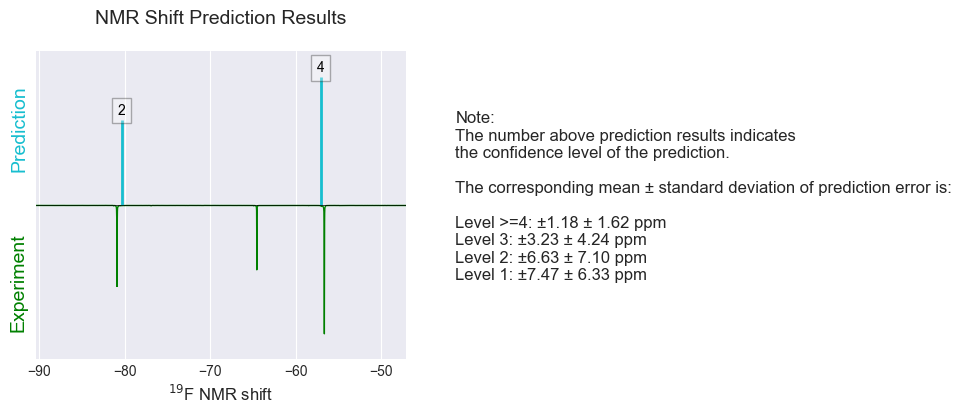

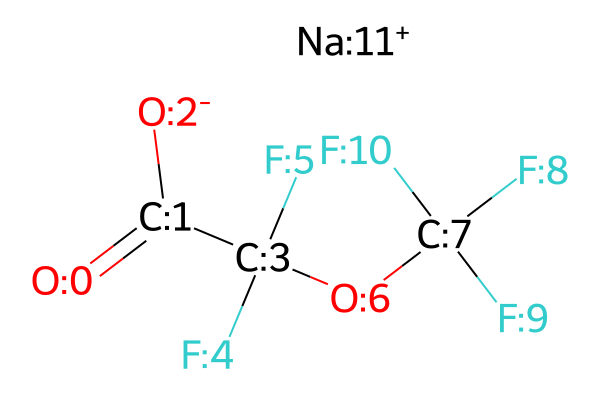

Peak at -56.63029288989877 with relative height 3.0
Peak at -64.53423481271315 with relative height 1.5041078981721578
Peak at -80.8884304696023 with relative height 1.891630431856488
Peak at -80.90195303918796 with relative height 1.8878395133532473


-------------------D-------------------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2948849153.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


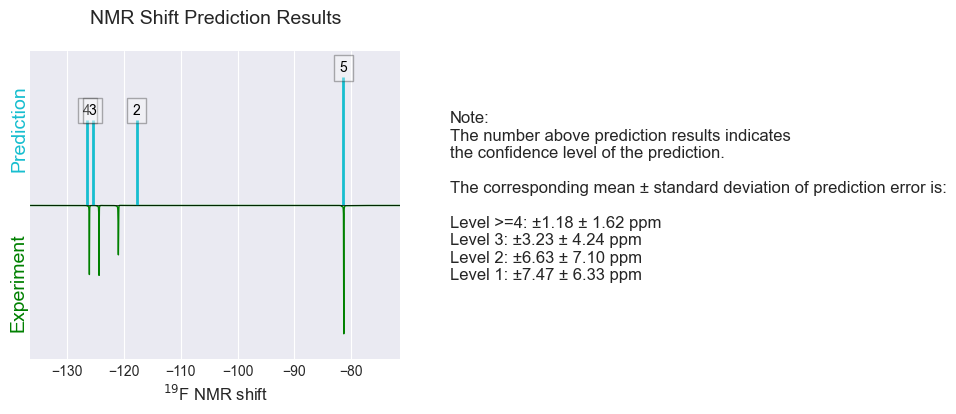

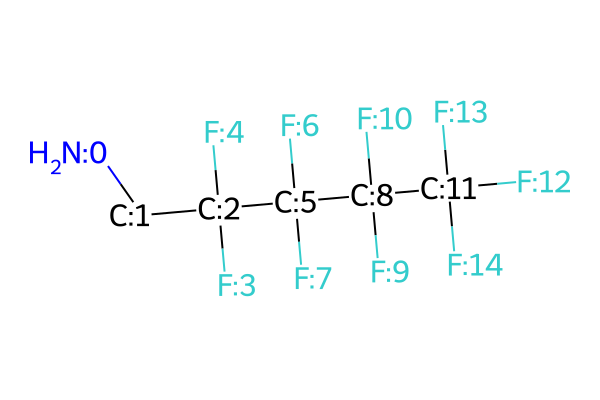

Peak at -63.11452843287595 with relative height 0.5781255422150354
Peak at -81.29023957634494 with relative height 3.0
Peak at -120.9763321764884 with relative height 1.1543076960995604
Peak at -124.37861543197296 with relative height 1.6336785475045479
Peak at -126.08516609509758 with relative height 1.6143224578798607


-------------------E-------------------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2948849153.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


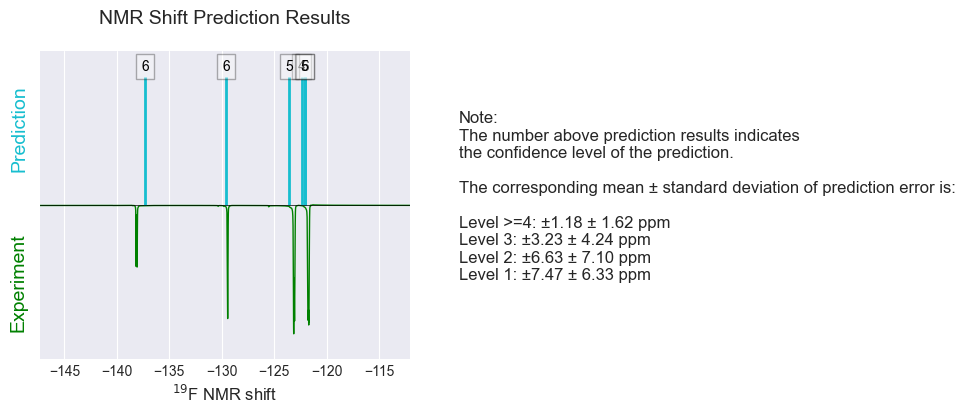

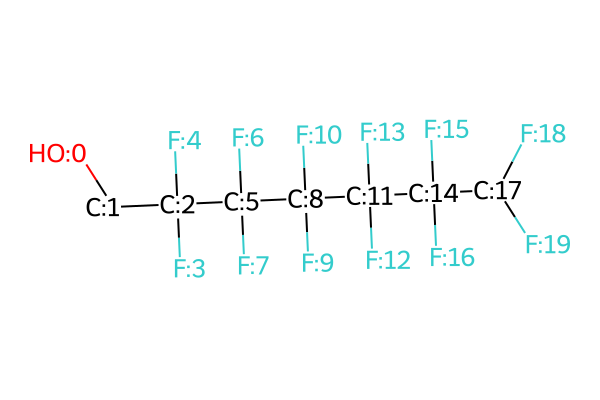

Peak at -63.11327473744389 with relative height 0.32324945176358566
Peak at -121.69043600002234 with relative height 1.8148071046319212
Peak at -121.7120721462018 with relative height 1.8625457188926555
Peak at -121.77833284387636 with relative height 1.7879253785555318
Peak at -123.06297902328096 with relative height 1.8008424751646563
Peak at -123.14005779404523 with relative height 2.0
Peak at -129.43752859140034 with relative height 1.7620894598114178
Peak at -138.07035091699942 with relative height 0.9593514970522459
Peak at -138.1609522791259 with relative height 0.9509365850115046


-------------------8-------------------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2948849153.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


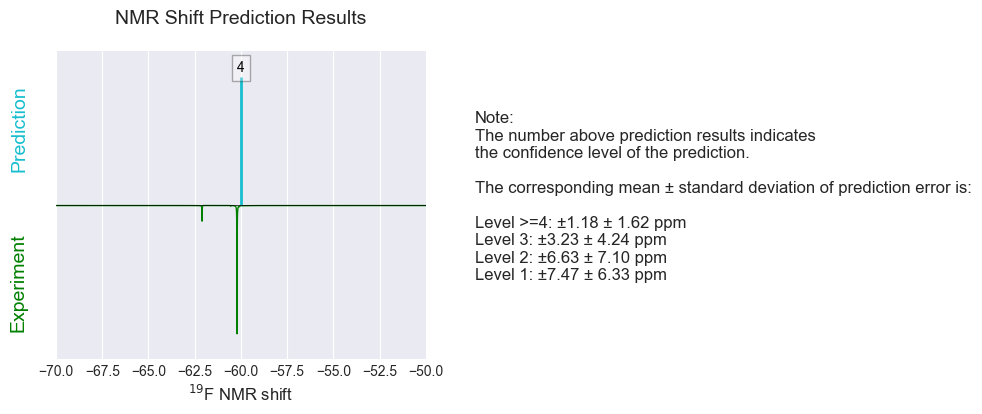

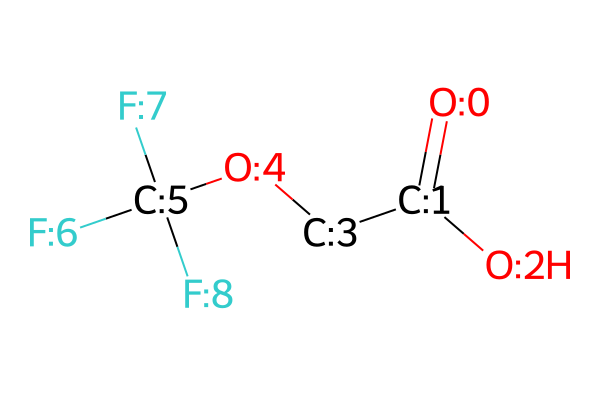

Peak at -60.20976003144585 with relative height 3.0
Peak at -62.10021992631005 with relative height 0.36583428166141757


-------------------9-------------------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2948849153.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


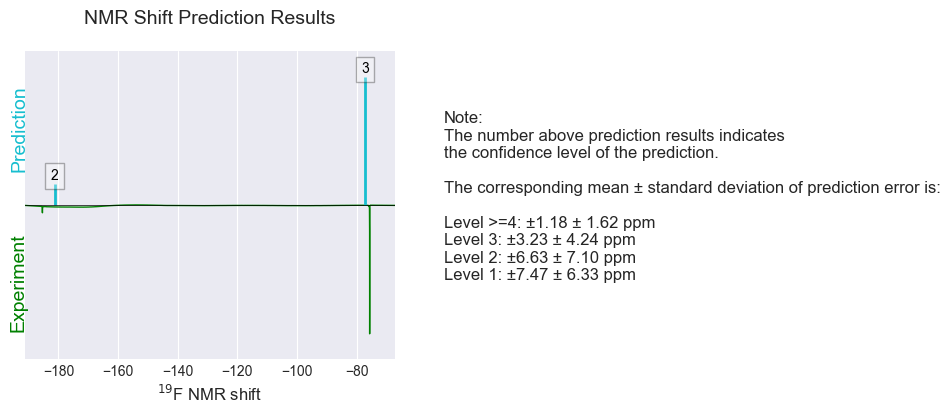

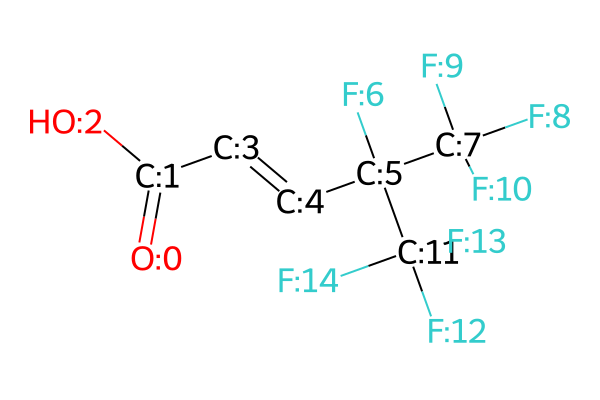

Peak at -62.10004448128715 with relative height 2.9934260172239133
Peak at -75.66456748375856 with relative height 6.0
Peak at -185.3775018631337 with relative height 0.34172306494626514


-------------------5-------------------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2948849153.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


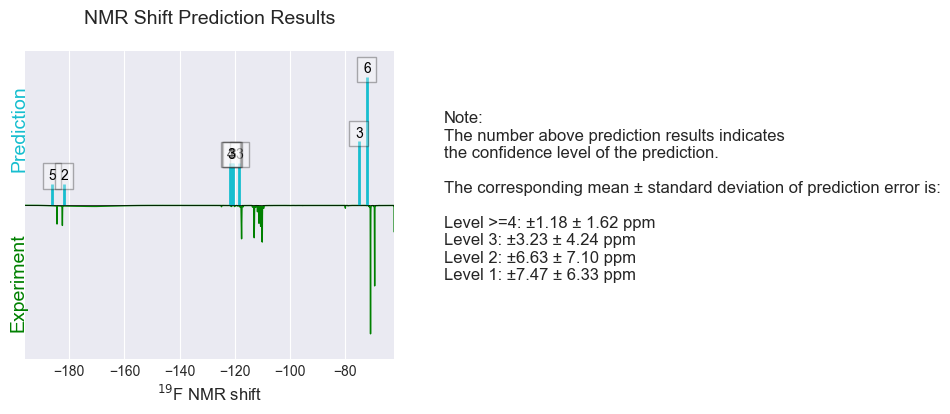

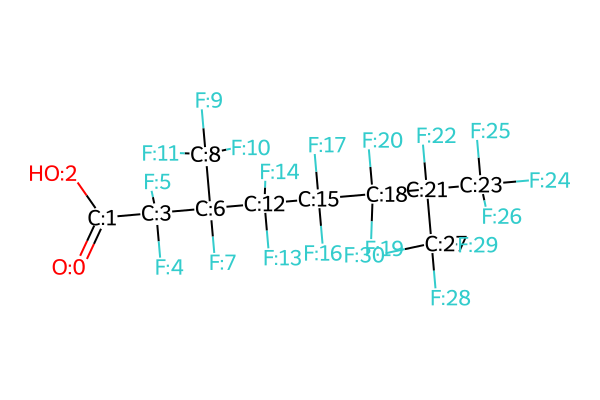

Peak at -62.10265536028726 with relative height 1.2451049729476116
Peak at -69.26423213703617 with relative height 3.759507530343112
Peak at -70.75848106798549 with relative height 6.0
Peak at -79.89030281522594 with relative height 0.12558251573912094
Peak at -109.5197040152534 with relative height 0.13491089630909425
Peak at -110.02544980726702 with relative height 1.7093634483550348
Peak at -110.11334680320522 with relative height 1.6697049351353774
Peak at -110.61233128783896 with relative height 0.9753703766800099
Peak at -111.2194966905505 with relative height 0.83207935212856
Peak at -111.76581032684328 with relative height 0.2940818934550188
Peak at -112.95850494865078 with relative height 1.5077507774029764
Peak at -117.52373969153302 with relative height 1.5572177781317444
Peak at -182.51342622675827 with relative height 0.9337240741274702
Peak at -184.45662596773036 with relative height 0.8667957646432836


-------------------10-------------------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2948849153.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


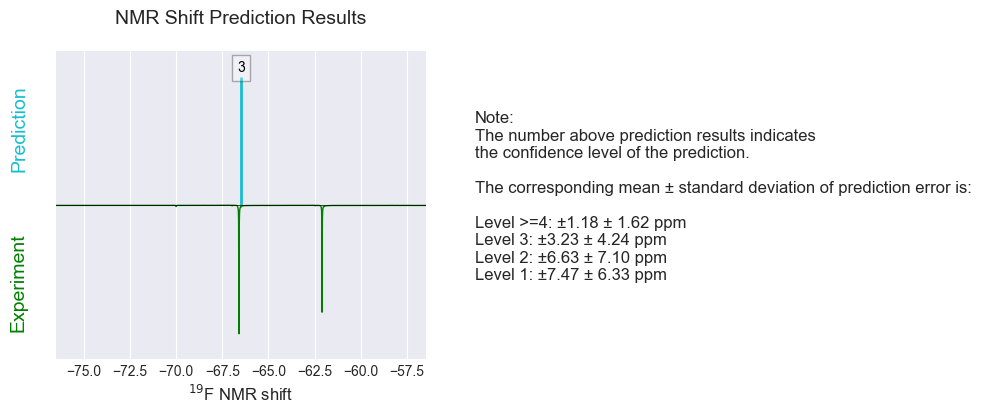

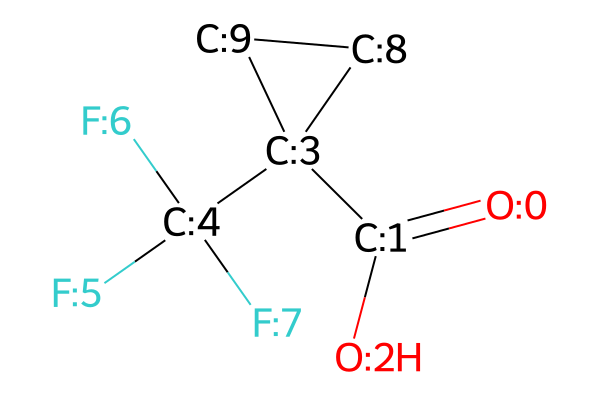

Peak at -62.10056016082488 with relative height 2.493970005442861
Peak at -66.59541372597293 with relative height 3.0


-------------------11-------------------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2948849153.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


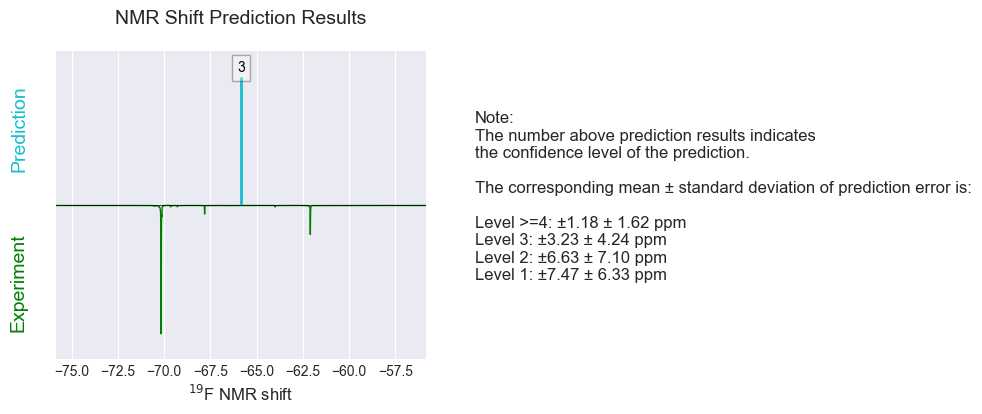

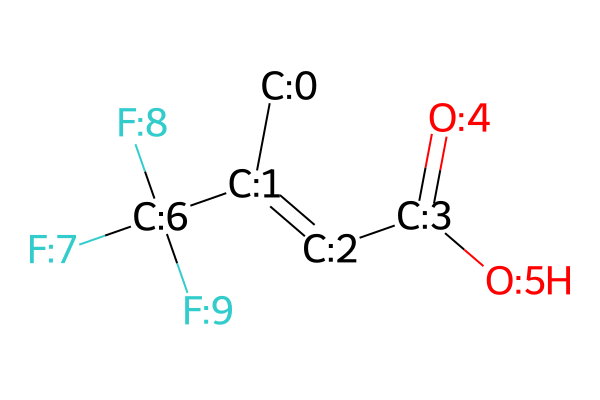

Peak at -62.10025328791582 with relative height 0.6759045477955541
Peak at -67.81489190100052 with relative height 0.19821504889147656
Peak at -70.166467042542 with relative height 3.0
Peak at -80.92232022012735 with relative height 0.19207717189418122


-------------------2-------------------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2948849153.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


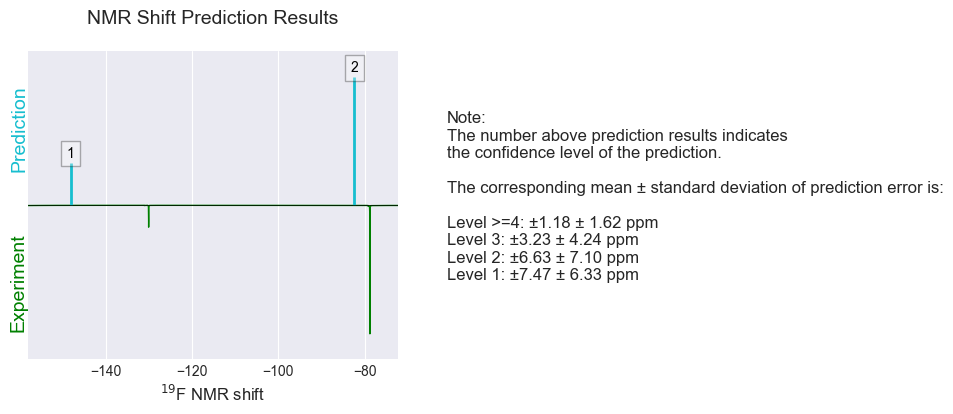

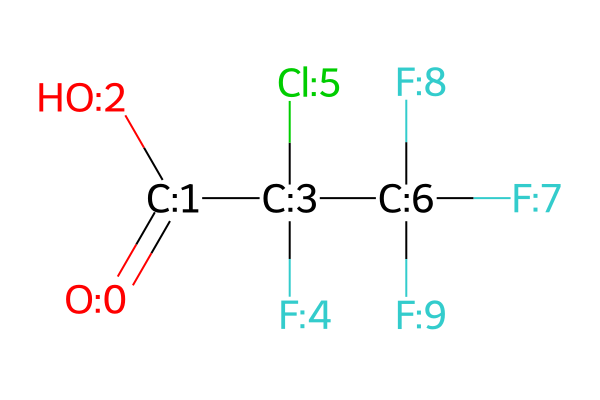

Peak at -62.09995015537203 with relative height 0.41805993631752253
Peak at -78.76792352963679 with relative height 3.0
Peak at -130.07677585315844 with relative height 0.5065679667661704


In [46]:
file_smiles_dict = {
    "136": "C(=O)(C(OC(F)(F)F)(F)F)[O-].[Na+]",
    "D": "C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)N", # 1H,1H-Perfluoropentylamine
    "E": "C(C(C(C(C(C(C(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O", # 2,2,3,3,4,4,5,5,6,6,7,7-dodecafluoroheptan-1-ol
    '8': 'C(C(=O)O)OC(F)(F)F',
    '9': 'C(=C/C(C(F)(F)F)(C(F)(F)F)F)\C(=O)O',
    '5': 'C(=O)(C(C(C(C(C(C(C(F)(F)F)(C(F)(F)F)F)(F)F)(F)F)(F)F)(C(F)(F)F)F)(F)F)O',
    '10':'C1CC1(C(=O)O)C(F)(F)F',
    '11': 'C/C(=C\C(=O)O)/C(F)(F)F',
    '2': 'C(=O)(C(C(F)(F)F)(F)Cl)O',
}
for file_name, smiles in file_smiles_dict.items():
    print(f'-------------------{file_name}-------------------')
    compare_prediction_w_experimental_data(
        smiles=smiles, experimental_data_file_name=f"{file_name}.csv"
    )

# Retain FFNN 2D Model with the whole dataset 

In [31]:
'''
    Use the whole dataset to re-train 2D FFNN model with the atomic features from 5 neighboring spheres of atoms.
    Model architecture will be the optimzied one from the previous training.
'''
# Same data preprocessing as for the Ridge model. Therefore we don't have to save relevant imputer, scaler, and column names to files
class Define_and_Train_FFNN_Model_2D():
    def __init__(self, num_spheres, dataset):
        self.num_spheres = num_spheres
        self.dataset = dataset
        self.X_scaled, self.y = self.step1_data_generation()
        self.model, self.history = self.step2_create_model(self.X_scaled, self.y, config = {'layers': [128, 64, 32], 'dropout': [0.2, 0.1, 0.0]},
        )
        return 

    def step1_data_generation(self):
        get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
        dataset = get_2d_descriptors.getDescriptorsFromDataset(
            self.dataset, self.num_spheres
        )

        # Drop columns with constant values
        dataset = common.drop_constant_col(dataset)

        # Drop columns with >80% values being NaN
        dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
        
        # drop rows with NaN values in the 'NMR_Peaks' column
        dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
        
        # Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
        dataset_dropNaN = dataset_dropNaN.apply(common.safe_to_numeric)
        
        # Drop categorical columns
        dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

        # Conver column names to 'string'
        dataset_dropCat.columns = dataset_dropCat.columns.astype(str)

        y_train = dataset_dropCat["NMR_Peaks"]
        X_train = dataset_dropCat.drop(["NMR_Peaks"], axis=1)
        
        X_train, imputer = common.fill_NaN(X_train)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled)
        X_train_scaled.columns = X_train.columns
        X_train_scaled.index = X_train.index

        # Save imputer
        file_path = os.path.join("..", "artifacts", "models", f"Application_2D_FFNN_imputer_2d_sphere{self.num_spheres}.pkl")
        with open(file_path, "wb") as file:
            pickle.dump(imputer, file)

        # Save column names
        columns = X_train_scaled.columns.tolist()
        file_path = os.path.join("..", "artifacts", "models", f"Application_2D_FFNN_column_names_2d_sphere{self.num_spheres}.pkl")
        with open(file_path, "wb") as f:
            pickle.dump(columns, f)
            
        # Save the scaler to a file
        file_path = os.path.join("..", "artifacts", "models", f"Application_2D_FFNN_scaler_2d_sphere{self.num_spheres}.pkl")
        with open(file_path, "wb") as file:
            pickle.dump(scaler, file)
        
        return X_train_scaled, y_train

    # Define model architecture
    # Our training dataset have ~ 2000 samples, and ~100 features.
    def step2_create_model(self, X_scaled, y, config):
        model = Sequential([
            # Input layer
            Input(shape=(X_scaled.shape[1],)),
            Dense(config['layers'][0], activation='relu'),
            BatchNormalization(),
            Dropout(config['dropout'][0]),

            Dense(config['layers'][1], activation='relu'),
            BatchNormalization(),
            Dropout(config['dropout'][1]),

            # Hidden layers
            Dense(config['layers'][2], activation='relu'),
            BatchNormalization(),
            Dropout(config['dropout'][2]),
            
            # Output layer - for regression task
            Dense(1),
            Lambda(lambda x:-x) # all 19F NMR values are negative in our dataset
        ])
        
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
   
        # Early stopping to prevent overfitting
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )

        # Compile model
        # Use Huber loss for our task, which is less sensitive to outliers. 
        # For small errors ([error] < delta), it behaves like MSE, and for large errors, it behaves like MAE.
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.Huber(delta=7), 
            metrics=['mean_squared_error', 'mean_absolute_error']
        )

        # Split data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

        # Fit the model
        history = model.fit(
            X_train, y_train,
            epochs=200,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, lr_scheduler],
            verbose=0
        )

        # Evaluate the model on validation data
        val_loss, val_mse, val_mae = model.evaluate(X_val, y_val, verbose=0)
        print(f"Validation Loss (Huber loss): {val_loss:.2f}")
        rmse = np.sqrt(val_mse)
        print(f"Validation RMSE: {rmse:.2f}")
        print(f"Validation MAE: {val_mae:.2f}")
        
        # Visualize training history
        plt.figure(figsize=(12, 4))
        
        # Plot training & validation loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Huber Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')

        # Plot training & validation mean absolute error
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mean_squared_error'])
        plt.plot(history.history['val_mean_squared_error'])
        plt.title('Mean Squared Error')
        plt.ylabel('MSE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.tight_layout()
        plt.show()

        # Save the model
        model_path = os.path.join("..", "artifacts", "models", f"Application_2D_FFNN_sphere{self.num_spheres}.h5")
        model.save(model_path)
        print(f">>>> Model saved to {model_path}")
    
        return model, history.history

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3478190374.py:38: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")


Validation Loss (Huber loss): 11.80
Validation RMSE: 7.15
Validation MAE: 2.97


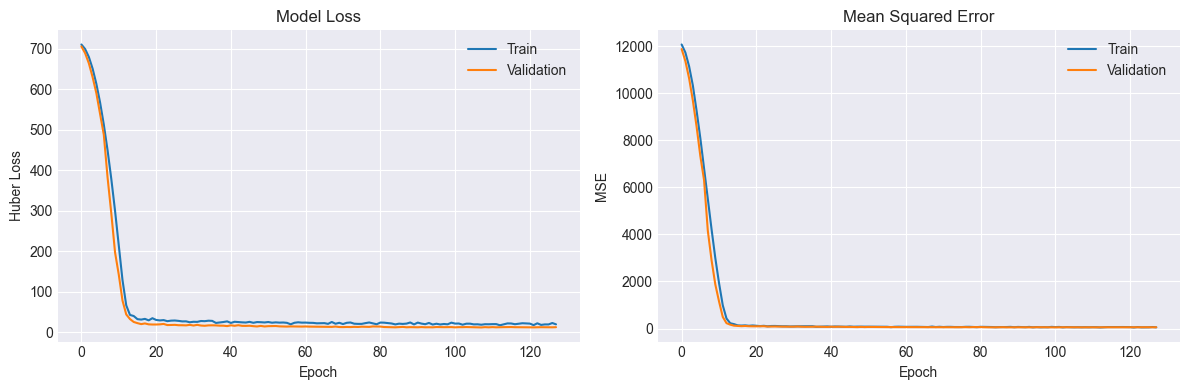

>>>> Model saved to ../artifacts/models/Application_2D_FFNN_sphere5.h5


In [32]:
application_FFNN_2D = Define_and_Train_FFNN_Model_2D(num_spheres=5, dataset=all_fluorinated_compounds)

In [33]:
HOSE_database_all_fluorianted_compounds = hose_code.getHoseCodeContent(
    all_fluorinated_compounds, max_radius=6
)

file_path = os.path.join(
    "..", "artifacts", "temp", "HOSE_database_all_fluorianted_compounds.csv"
)
HOSE_database_all_fluorianted_compounds.to_csv(file_path, encoding="UTF-8")

HOSE_database_all_fluorianted_compounds.head(3)

[14:46:02] UFFTYPER: Warning: hybridization set to SP3 for atom 6


0             1                     2  \
4_COOH_1  F-1;C(//)  F-1;C(CCF//)  F-1;C(CCF/=OO,FFF,/)   
5_COOH_1  F-1;C(//)  F-1;C(CCF//)  F-1;C(CCF/=OO,FFF,/)   
7_COOH_1  F-1;C(//)  F-1;C(CFF//)     F-1;C(CFF/CFF,,/)   

                                 3                          4  \
4_COOH_1  F-1;C(CCF/=OO,FFF,/,,,,)  F-1;C(CCF/=OO,FFF,/,,,,)/   
5_COOH_1  F-1;C(CCF/=OO,FFF,/,,,,)  F-1;C(CCF/=OO,FFF,/,,,,)/   
7_COOH_1    F-1;C(CFF/CFF,,/=OO,,)   F-1;C(CFF/CFF,,/=OO,,),/   

                                   5 NMR_Peaks  
4_COOH_1  F-1;C(CCF/=OO,FFF,/,,,,)//   -122.45  
5_COOH_1  F-1;C(CCF/=OO,FFF,/,,,,)//   -122.45  
7_COOH_1   F-1;C(CFF/CFF,,/=OO,,),//     -83.4

# Apply our application to predict 10 random PFAS from our lab

In [57]:
def visualize_experimental_data_vs_prediction(results, experimental_data_file_name):
    # Set style for better visualization
    plt.style.use("seaborn-v0_8-darkgrid")

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), width_ratios=[3, 1])
    fig.subplots_adjust(hspace=0.1)

    # Prepare data
    code = results["fluorinated_compounds"][0]

    predicted_PFAS_spectra_df = results[
        ["fluorinated_compounds", "atom_index", "ensembled_FFNN_and_HOSE"]
    ]
    predicted_PFAS_spectra_df = predicted_PFAS_spectra_df.pivot(
        index="fluorinated_compounds", columns="atom_index", values="ensembled_FFNN_and_HOSE"
    )

    # Colors for better contrast
    actual_color = "g"  # Green
    predict_color = "C9"  # Blue

    # Get predicted value counts
    predict = predicted_PFAS_spectra_df.loc[code, :].value_counts()

    # Plot in the first subplot (ax1)
    # plot experimental data
    file_path = os.path.join("..", "artifacts", "temp", experimental_data_file_name)
    exp_spectrum = pd.read_csv(file_path)
    x_actual = exp_spectrum.iloc[:, 0]
    y_actual = exp_spectrum.iloc[:, 1]

    y_scaled = (y_actual / np.max(y_actual)) * predict.values.max()

    ax1.plot(x_actual, -y_scaled, color=actual_color, label="actual", linewidth=1)

    # Plot predicted values
    ax1.vlines(
        predict.index,
        ymin=0,
        ymax=predict.values,
        color=predict_color,
        label="Prediction",
        linewidth=2,
    )

    # Add similarity levels
    #     temp = results[results['fluorinated_compounds'] == 'temp']
    for i, j in zip(predict.index, predict.values):
        similarity_level = results[results["ensembled_FFNN_and_HOSE"] == i][
            "similarity_levels"
        ]
        # Show similarity level above each prediction
        if not similarity_level.empty:
            ax1.text(
                i,
                j + 0.05,
                similarity_level.iloc[0],
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                bbox=dict(facecolor="white", alpha=0.3),
            )

    # Set plot limits and labels
    x_min = predict.index.min() - 10
    x_max = predict.index.max() + 10
    y_max = predict.values.max() * 1.2

    ax1.set_xlim([x_min, x_max])
    ax1.set_ylim([-y_max, y_max])

    # Add labels
    ax1.text(
        x_min - 2,
        y_max / 2,
        "Prediction",
        color=predict_color,
        rotation=90,
        ha="center",
        va="center",
        fontsize=14,
    )
    ax1.text(
        x_min - 2,
        -y_max / 2,
        "Experiment",
        color=actual_color,
        rotation=90,
        ha="center",
        va="center",
        fontsize=14,
    )

    ax1.set_xlabel(r"$^{19}$F NMR shift", fontsize=12)
    ax1.set_yticks([])
    ax1.axhline(0, color="k", linewidth=0.5)
    ax1.set_title("NMR Shift Prediction Results", fontsize=14, pad=20)

    # Add confidence level information in the second subplot (ax2)
    confidence_data = {
        "Level": ['>=4', '3', '2', '1'],
        "Error": ['1.18 ± 1.62', '3.23 ± 4.24', '6.63 ± 7.10', '7.47 ± 6.33']
    }

    ax2.axis("off")
    ax2.set_xlim(0, 2)  # Adjust limits as needed
    ax2.set_ylim(0, 2)
    table_text = (
        "Note:\n"
        + "The number above prediction results indicates\n"
        + "the confidence level of the prediction.\n"
        + "The corresponding mean ± standard deviation of prediction error is:\n\n"
    )
    for level, error in zip(confidence_data["Level"], confidence_data["Error"]):
        table_text += f"Level {level}: ±{error} ppm\n"
    ax2.text(
        0,
        1,
        table_text,
        ha="left",
        va="center",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="white", alpha=0.9),
    )

    plt.show()

    details = results[
        [
            "atom_index",
            "similarity_levels",
            "actual",
            "ensembled_FFNN_and_HOSE",
            "ensemble_model_error",
        ]
    ].rename(
        columns={
            "atom_index": "Atom Index",
            "similarity_levels": "Confidence Level",
            "actual": "Report Values",
            "ensembled_FFNN_and_HOSE": "Prediction Results",
            "ensemble_model_error": "Prediction Error",
        }
    )
    details.reset_index(drop=True, inplace=True)
    
    # Display molecular structure if available
    file_path = os.path.join("..", "artifacts", "temp")
    if os.path.exists(os.path.join(file_path, "temp.png")):
        filepath = os.path.join(file_path, "temp.png")
        display(Image(filepath))

    # Display detailed results in a styled table
    # Style the dataframe
    styled_details = (
        details.style.set_properties(**{"text-align": "center"})
        .format({"Prediction Results": "{:.2f}", "Prediction Error": "{:.2f}"})
        .set_table_styles(
            [
                {
                    "selector": "th",
                    "props": [
                        ("background-color", "#f8f9fa"),
                        ("color", "black"),
                        ("font-weight", "bold"),
                        ("text-align", "center"),
                        ("padding", "8px"),
                    ],
                },
                {"selector": "td", "props": [("padding", "8px")]},
            ]
        )
    )

    # Detect peaks in y
    peaks, properties = find_peaks(y_scaled, height=0.1, distance=10, prominence=0.05)

    # Get peak x and y values
    x_peaks = x_actual[peaks]
    y_peaks = y_scaled[peaks]

    # Print peak positions and heights
    for x_peak, y_peak in zip(x_peaks, y_peaks):
        print(f"Peak at {x_peak} with relative height {y_peak}")

    display(styled_details)

In [54]:
def compare_prediction_w_experimental_data(
    smiles,
    experimental_data_file_name, 
    train_fluorinated_compounds_file_path=os.path.join("..", "dataset", "Processed_PFAS_19F_NMR_spectra_data.csv"),
    FFNN_2D_model_path=os.path.join("..", "artifacts", "models", "Application_2D_FFNN_sphere5.h5"), 
    scaler_path=os.path.join("..", "artifacts", "models", "Application_2D_FFNN_scaler_2d_sphere5.pkl"),
    imputer_path=os.path.join("..", "artifacts", "models", "Application_2D_FFNN_imputer_2d_sphere5.pkl"), 
    columns_path=os.path.join("..", "artifacts", "models", "Application_2D_FFNN_column_names_2d_sphere5.pkl"),
    HOSE_Code_database_file_path=os.path.join("..", "artifacts", "temp", "HOSE_database_all_fluorianted_compounds.csv"),
):
    # Load preprocessing tools
    with open(scaler_path, "rb") as file:
        scaler = pickle.load(file)
    with open(imputer_path, "rb") as file:
        imputer = pickle.load(file)
    with open(columns_path, "rb") as file:
        train_columns = pickle.load(file)

    train_dataset = pd.read_csv(train_fluorinated_compounds_file_path, index_col=0)

    # Generate sdf from SMILES
    smiles = common.canonical_smiles([smiles])[0]
    atomic_features_3D.get_sdf_file(smiles)

    # Generate descriptors
    best_model = load_model(FFNN_2D_model_path)
    dataset = atomic_features_3D.get_test_fluorianted_compounds_info(smiles, train_dataset)

    get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
    content = get_2d_descriptors.getDescriptorsFromDataset(dataset, 5)

    content = content.apply(common.safe_to_numeric)
    content.columns = content.columns.astype(str)

    y = content["NMR_Peaks"]
    X = content.drop(["NMR_Peaks"], axis=1)
    X = X[train_columns]  # Ensure correct column alignment

    # Impute and scale
    X_imputed = imputer.transform(X)
    X_imputed_df = pd.DataFrame(X_imputed, columns=train_columns, index=X.index)

    X_scaled = scaler.transform(X_imputed_df)
    X_scaled_df = pd.DataFrame(X_scaled, columns=train_columns, index=X.index)

    # FFNN prediction
    FFNN_results_table = common.get_results_table(best_model=best_model, X=X_scaled_df, y=y)

    # HOSE prediction
    HOSE_results = hose_code.get_HOSE_prediction_results_table(HOSE_Code_database_file_path, dataset)

    # Combine results
    combined_prediction = HOSE_results.copy()
    combined_prediction.rename(columns={"prediction": "HOSE_model_prediction"}, inplace=True)
    combined_prediction = combined_prediction[["actual", "similarity_levels", "HOSE_model_prediction"]]
    combined_prediction["FFNN_model_prediction"] = FFNN_results_table["prediction"]
    combined_prediction["FFNN_model_error"] = np.abs(combined_prediction["FFNN_model_prediction"] - combined_prediction["actual"])

    # Ensemble logic
    ensembled_predictions = []
    for _, row in combined_prediction.iterrows():
        if row["similarity_levels"] > 4:
            ensembled_predictions.append(row["HOSE_model_prediction"])
        else:
            ensembled_predictions.append(row["FFNN_model_prediction"])
    combined_prediction["ensembled_FFNN_and_HOSE"] = ensembled_predictions
    combined_prediction["ensemble_model_error"] = np.abs(combined_prediction["ensembled_FFNN_and_HOSE"] - combined_prediction["actual"])

    # combined_prediction['ensembled_FFNN_and_HOSE'] = combined_prediction["FFNN_model_prediction"]
    # combined_prediction["ensemble_model_error"] = np.abs(combined_prediction["ensembled_FFNN_and_HOSE"] - combined_prediction["actual"])
    
    # Add atom index and compound name
    split_values = [common.safe_split(idx) for idx in combined_prediction.index]
    combined_prediction["atom_index"] = [val[0] for val in split_values]
    combined_prediction["fluorinated_compounds"] = [val[1] for val in split_values]

    # Average predictions for identical environments
    temp_dataset = {"Code": ["temp"], "SMILES": [smiles]}
    for i in range(71):
        temp_dataset[i] = None
    temp_dataset = pd.DataFrame(temp_dataset, index=[0])

    HOSE_codes = hose_code.getHoseCodeContent(dataset)
    combined_temp = combined_prediction.merge(HOSE_codes.drop("NMR_Peaks", axis=1), left_index=True, right_index=True)
    combined_temp_grouped = combined_temp.groupby([0, 1, 2, 3, 4, 5])["ensembled_FFNN_and_HOSE"].transform("mean")
    combined_temp["ensembled_FFNN_and_HOSE"] = combined_temp_grouped
    combined = combined_temp.drop([0, 1, 2, 3, 4, 5], axis=1)

    # Visualize predictions vs experiment
    visualize_experimental_data_vs_prediction(combined, experimental_data_file_name)

    return combined_prediction


In [19]:
# # 43: 27854-30-4  C(CC(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)C(=O)O
# # 136: 21837-98-9  C(=O)(C(OC(F)(F)F)(F)F)[O-].[Na+]
# # 2: 422-64-0     C(=O)(C(C(F)(F)F)(F)F)O

# # 2,3,3,3-Tetrafluoro-2-(1,1,2,3,3,3-hexafluoro-2-(perfluoropropoxy)propoxy)propanoic acid
# # 132: 13252-14-7  C(=O)(C(C(F)(F)F)(OC(C(C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)(F)F)F)O

# # Potassium perfluorohexanesulfonate
# # 66: 3871-99-6   C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)F.[K+]
# # 63: 2926-30-9    C(F)(F)(F)S(=O)(=O)[O-].[Na+]
# # 59: 17372-33-2   C(C(C(F)(F)F)C(F)(F)F)C(=O)O
# # 49:359-49-9   C(C(=O)O)(C(F)(F)F)F
# # 35: 380-60-9    C(C(=O)O)C(C(F)(F)F)(F)F
# file_smiles_dict = {
#     "43": "C(CC(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)C(=O)O",
#     "136": "C(=O)(C(OC(F)(F)F)(F)F)[O-].[Na+]",
#     "2": "C(=O)(C(C(F)(F)F)(F)F)O",
#     #  "132": "C(=O)(C(C(F)(F)F)(OC(C(C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)(F)F)F)O", # Sample bad
#     "66": "C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)F.[K+]",
#     "63": "C(F)(F)(F)S(=O)(=O)[O-].[Na+]",
#     # "59": "C(C(C(F)(F)F)C(F)(F)F)C(=O)O", # Sample bad
#     # "49": "C(C(=O)O)(C(F)(F)F)F", # Sample bad
#     # "35": "C(C(=O)O)C(C(F)(F)F)(F)F", # Sample bad
#     "A": "C(C(C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)O",
#     "B": "C(C(=O)N)(C(F)(F)F)F", # 2,3,3,3-tetrafluoropropanamide  
#     "C": "CCN(CC)C(=O)C(C(F)(F)F)F", # N,N-Diethyl-2,3,3,3-tetrafluoropropionamide
#     "D": "C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)N", # 1H,1H-Perfluoropentylamine
#     "E": "C(C(C(C(C(C(C(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O", # 2,2,3,3,4,4,5,5,6,6,7,7-dodecafluoroheptan-1-ol
#     "F": "C(#N)C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F", # Perfluorooctanonitrile
# }

# # Must provide the experimental data file in the 'temp' folder
# compare_prediction_w_experimental_data(
#     smiles=file_smiles_dict["43"], experimental_data_file_name="43.csv"
# )

## Final

-------------------136-------------------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


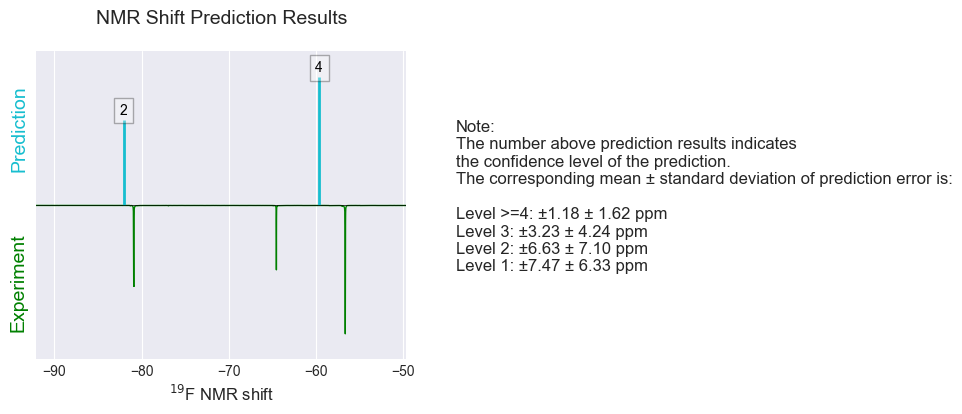

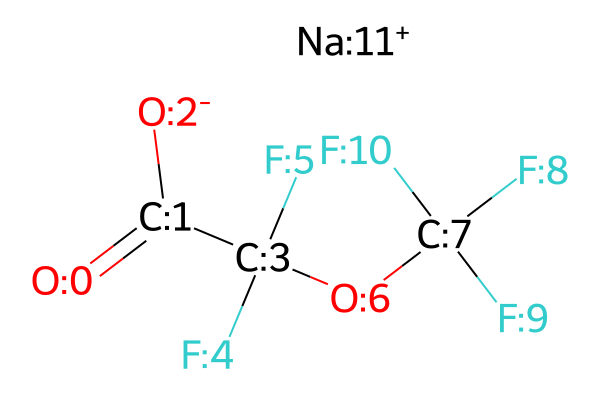

Peak at -56.63029288989877 with relative height 3.0
Peak at -64.53423481271315 with relative height 1.5041078981721578
Peak at -80.8884304696023 with relative height 1.891630431856488
Peak at -80.90195303918796 with relative height 1.8878395133532473


-------------------D-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


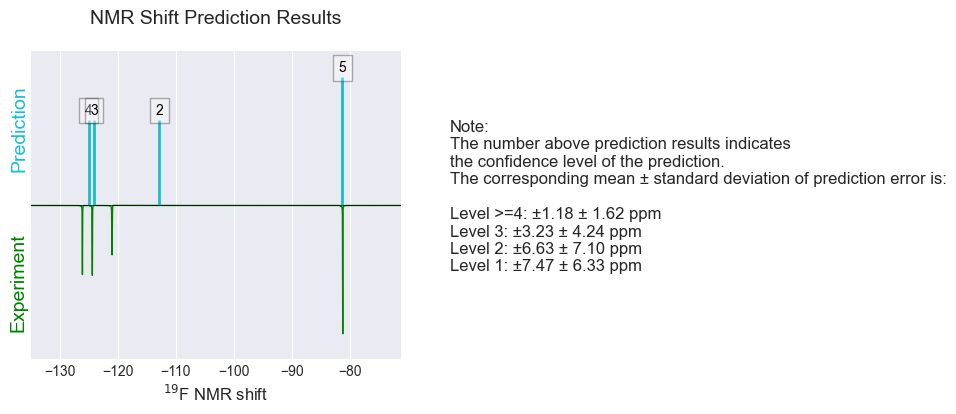

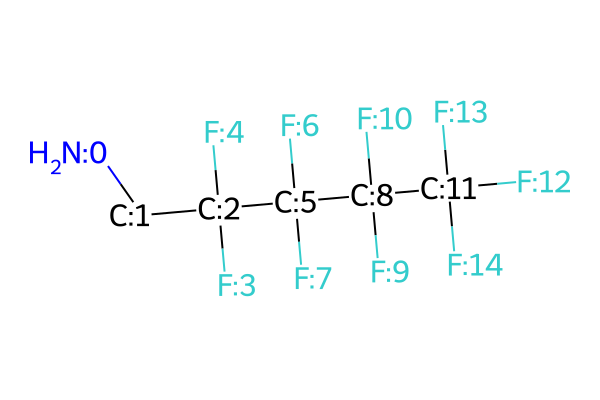

Peak at -63.11452843287595 with relative height 0.5781255422150354
Peak at -81.29023957634494 with relative height 3.0
Peak at -120.9763321764884 with relative height 1.1543076960995604
Peak at -124.37861543197296 with relative height 1.6336785475045479
Peak at -126.08516609509758 with relative height 1.6143224578798607


-------------------E-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


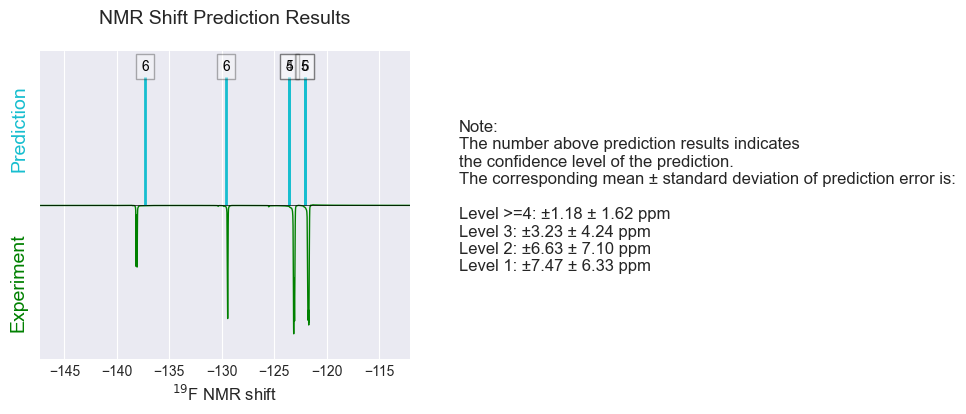

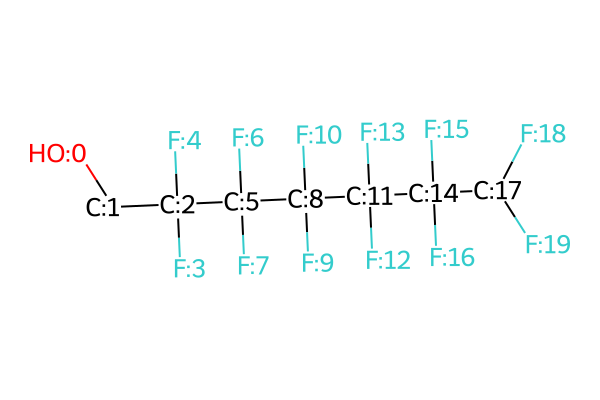

Peak at -63.11327473744389 with relative height 0.32324945176358566
Peak at -121.69043600002234 with relative height 1.8148071046319212
Peak at -121.7120721462018 with relative height 1.8625457188926555
Peak at -121.77833284387636 with relative height 1.7879253785555318
Peak at -123.06297902328096 with relative height 1.8008424751646563
Peak at -123.14005779404523 with relative height 2.0
Peak at -129.43752859140034 with relative height 1.7620894598114178
Peak at -138.07035091699942 with relative height 0.9593514970522459
Peak at -138.1609522791259 with relative height 0.9509365850115046


-------------------8-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


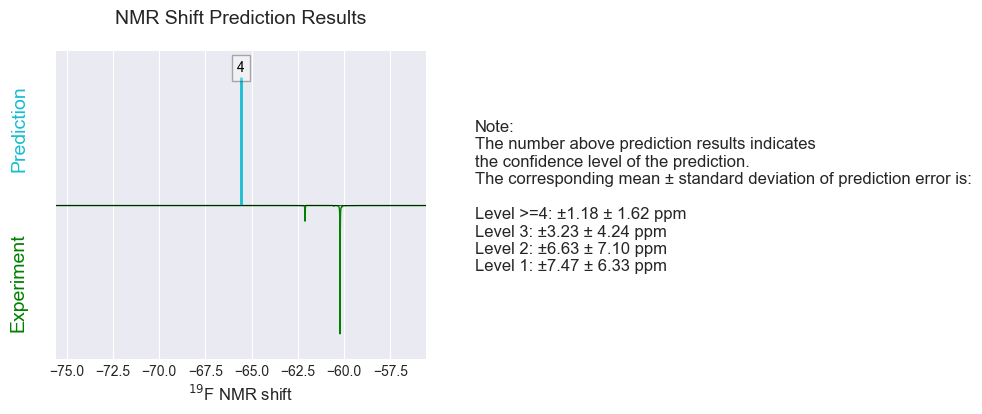

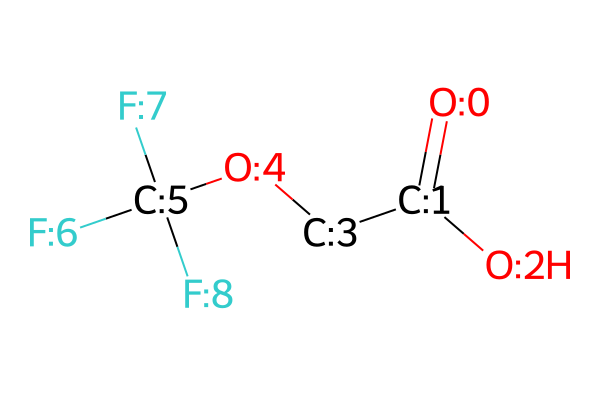

Peak at -60.20976003144585 with relative height 3.0
Peak at -62.10021992631005 with relative height 0.36583428166141757


-------------------9-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


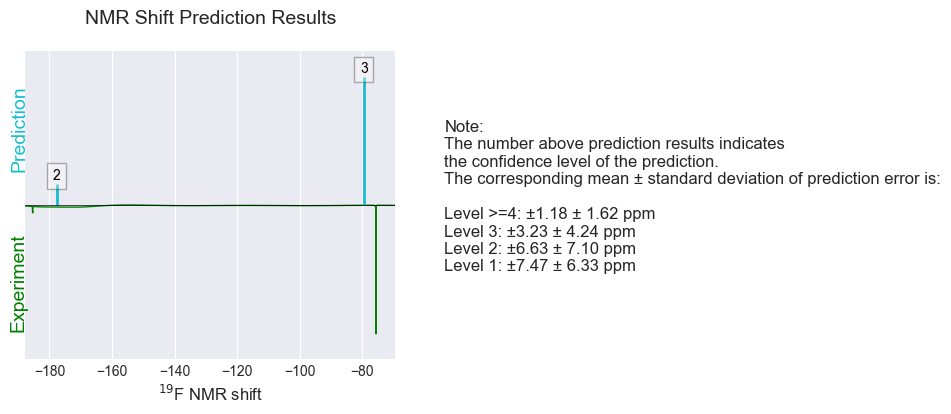

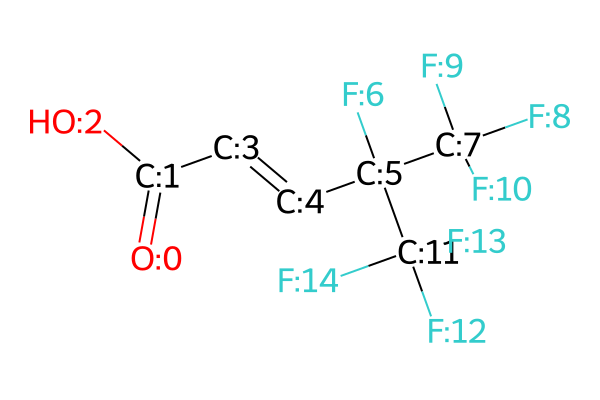

Peak at -62.10004448128715 with relative height 2.9934260172239133
Peak at -75.66456748375856 with relative height 6.0
Peak at -185.3775018631337 with relative height 0.34172306494626514


-------------------5-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


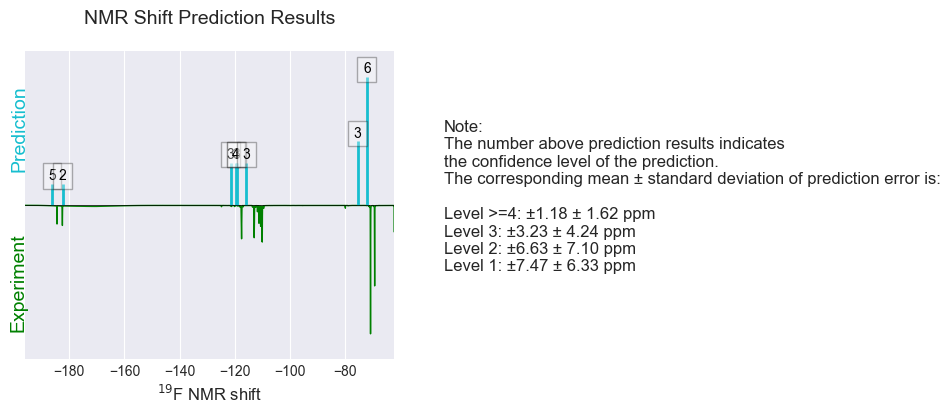

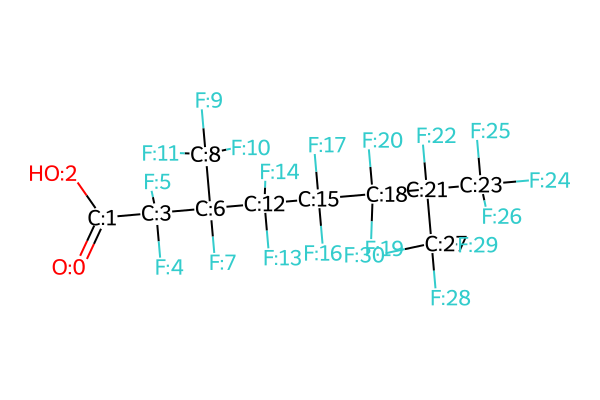

Peak at -62.10265536028726 with relative height 1.2451049729476116
Peak at -69.26423213703617 with relative height 3.759507530343112
Peak at -70.75848106798549 with relative height 6.0
Peak at -79.89030281522594 with relative height 0.12558251573912094
Peak at -109.5197040152534 with relative height 0.13491089630909425
Peak at -110.02544980726702 with relative height 1.7093634483550348
Peak at -110.11334680320522 with relative height 1.6697049351353774
Peak at -110.61233128783896 with relative height 0.9753703766800099
Peak at -111.2194966905505 with relative height 0.83207935212856
Peak at -111.76581032684328 with relative height 0.2940818934550188
Peak at -112.95850494865078 with relative height 1.5077507774029764
Peak at -117.52373969153302 with relative height 1.5572177781317444
Peak at -182.51342622675827 with relative height 0.9337240741274702
Peak at -184.45662596773036 with relative height 0.8667957646432836


-------------------10-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


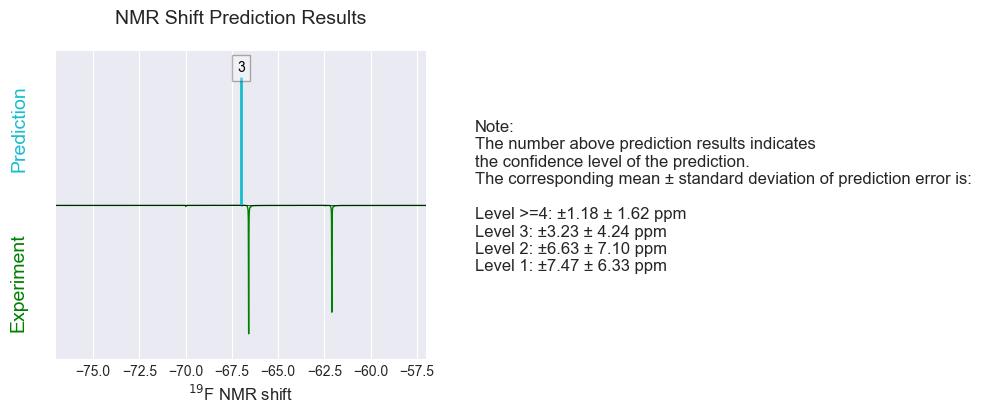

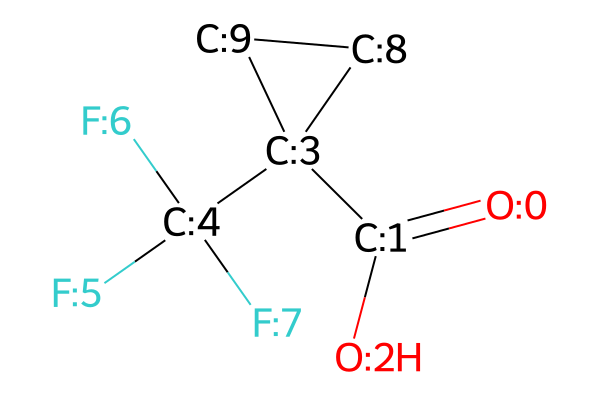

Peak at -62.10056016082488 with relative height 2.493970005442861
Peak at -66.59541372597293 with relative height 3.0


-------------------11-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


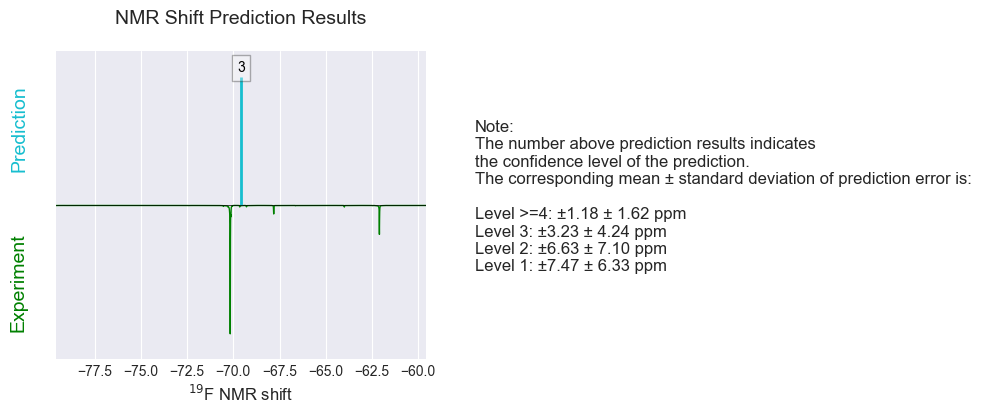

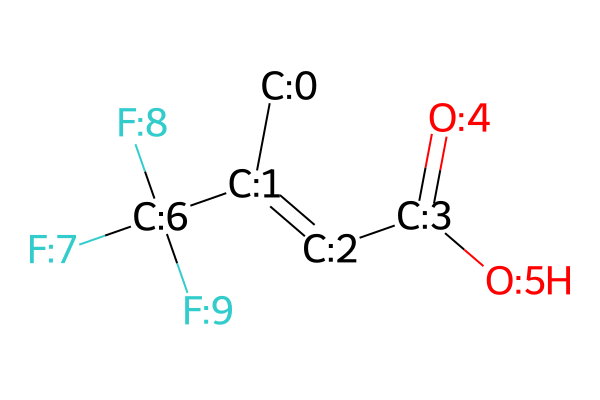

Peak at -62.10025328791582 with relative height 0.6759045477955541
Peak at -67.81489190100052 with relative height 0.19821504889147656
Peak at -70.166467042542 with relative height 3.0
Peak at -80.92232022012735 with relative height 0.19207717189418122


-------------------2-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


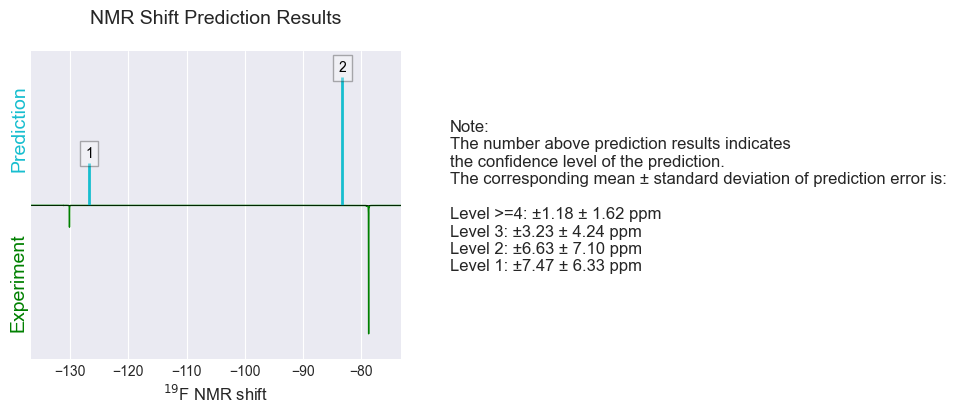

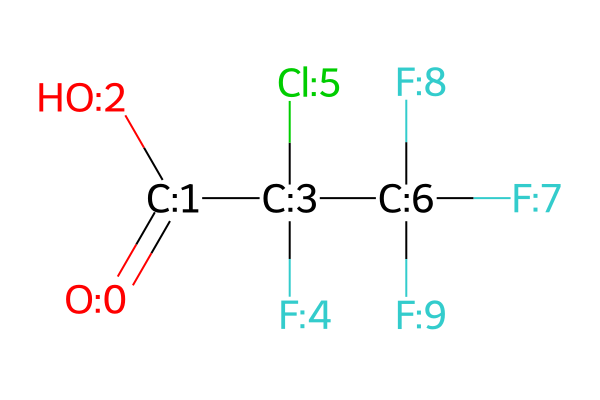

Peak at -62.09995015537203 with relative height 0.41805993631752253
Peak at -78.76792352963679 with relative height 3.0
Peak at -130.07677585315844 with relative height 0.5065679667661704


-------------------A-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


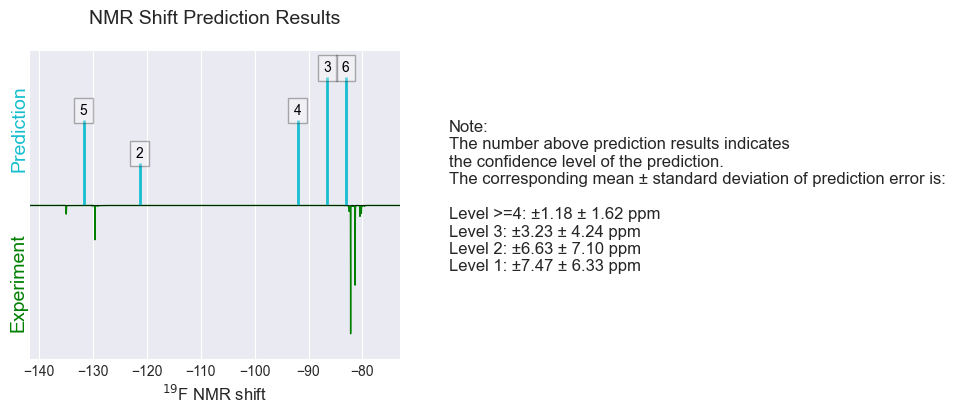

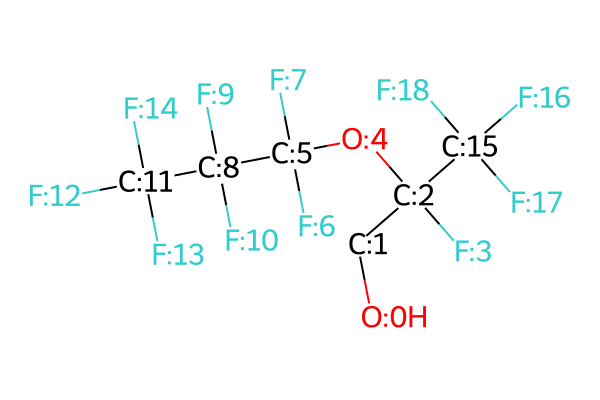

Peak at -63.10957125481491 with relative height 0.6745119233929656
Peak at -80.19806882079493 with relative height 0.1839454844398418
Peak at -80.4604070757447 with relative height 0.254586033369036
Peak at -81.35019352810006 with relative height 1.8618218214373727
Peak at -82.19535543193305 with relative height 3.0
Peak at -82.45769368688282 with relative height 0.14041601116378774
Peak at -129.60150081221016 with relative height 0.779980345901286
Peak at -129.62178469790214 with relative height 0.8021372929053864
Peak at -134.93751500825013 with relative height 0.20106337208280906


-------------------B-------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


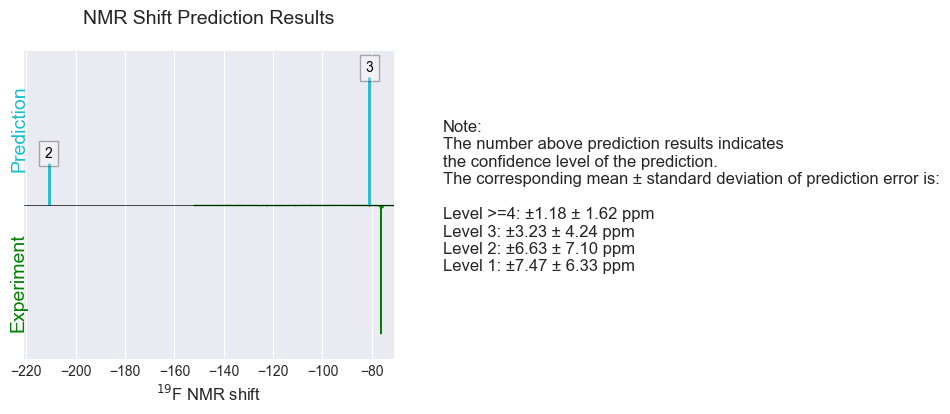

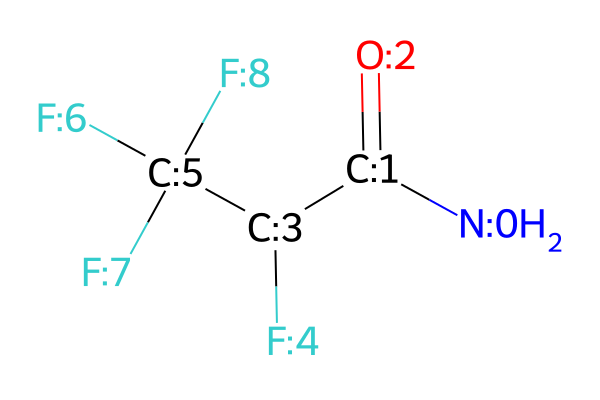

Peak at -63.11043621691024 with relative height 2.6640263703842666
Peak at -76.32728763588548 with relative height 3.0


-------------------C-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


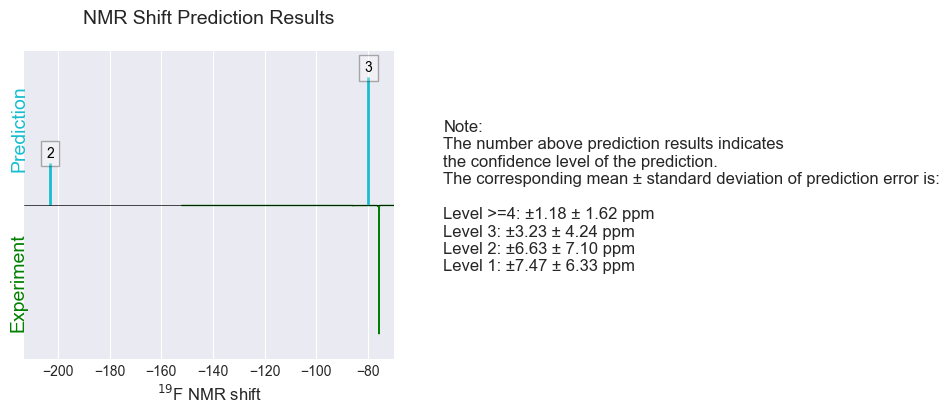

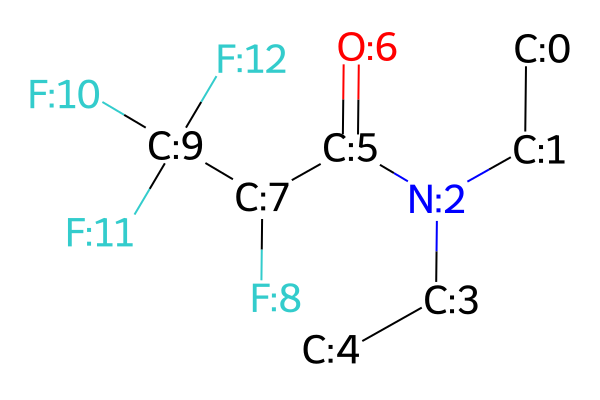

Peak at -63.10921120494494 with relative height 0.47406193587493567
Peak at -75.73660532847992 with relative height 3.0


-------------------F-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


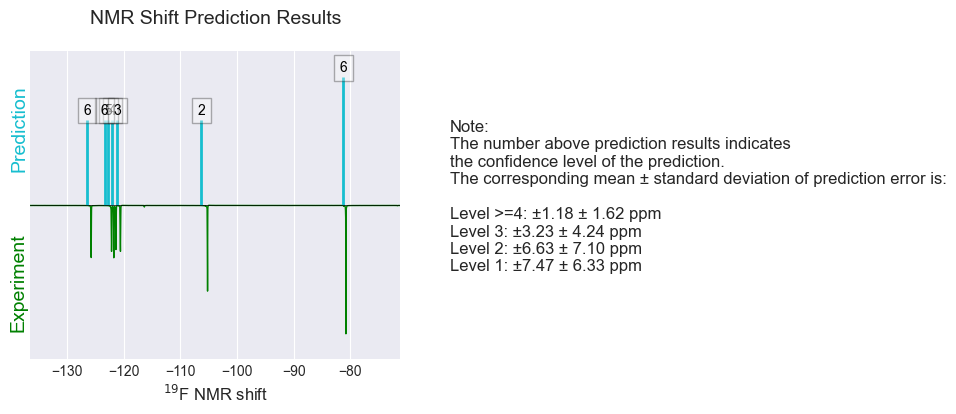

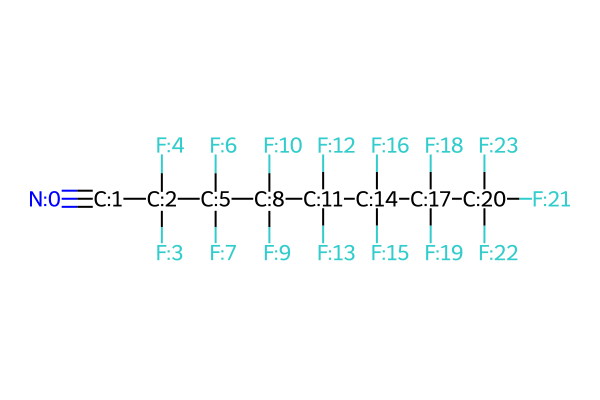

Peak at -63.109739018116926 with relative height 2.120396249291251
Peak at -80.80810538693405 with relative height 3.0
Peak at -105.19474498773232 with relative height 2.0012499269987885
Peak at -120.54694191508416 with relative height 1.072397307821522
Peak at -121.34071797395454 with relative height 1.0301400270888121
Peak at -121.71799824725068 with relative height 1.2227592839393575
Peak at -122.11421014716385 with relative height 1.0733508422796054
Peak at -125.7031056501315 with relative height 1.216804022987302


-------------------66-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


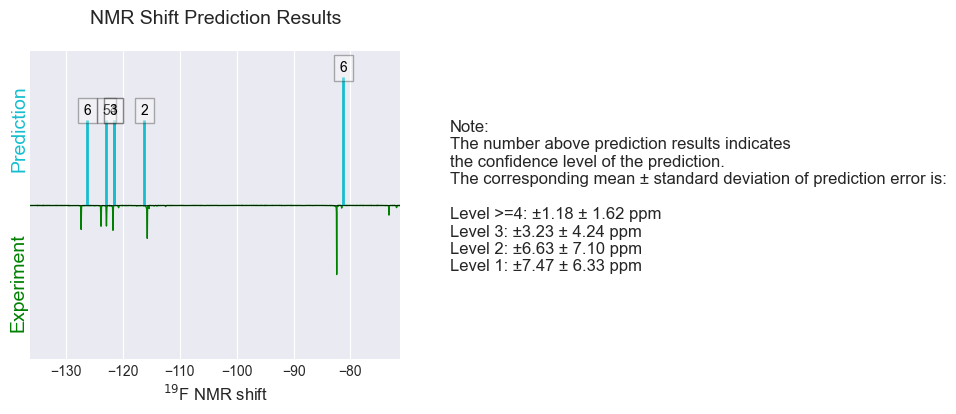

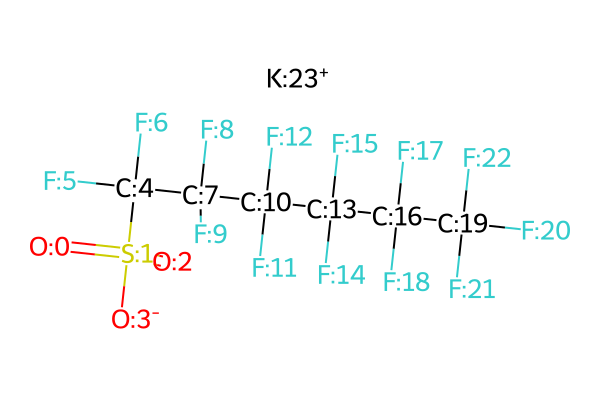

Peak at -64.55316641 with relative height 3.0
Peak at -73.21437223 with relative height 0.22450263495065903
Peak at -82.41242406 with relative height 1.6136601856025696
Peak at -115.7306833 with relative height 0.7692090790459813
Peak at -121.7563403 with relative height 0.5801923298218286
Peak at -122.9098155 with relative height 0.4800566107721073
Peak at -123.8577476 with relative height 0.4850746988892233
Peak at -127.3573886 with relative height 0.5598862792398295


-------------------63-------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/2581115293.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/3110941469.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


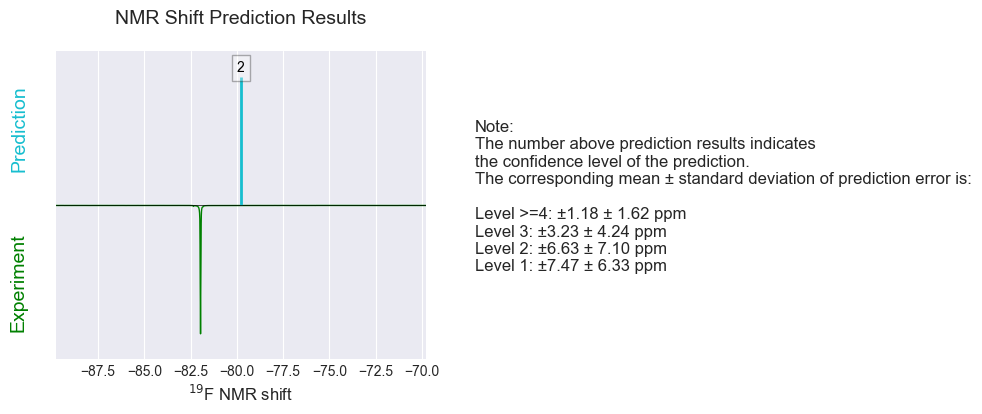

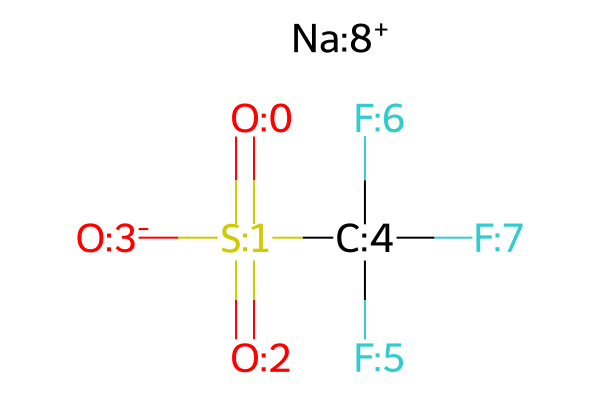

Peak at -63.99874106 with relative height 0.9922201270577755
Peak at -81.96212249 with relative height 3.0
Peak at -114.99776 with relative height 1.2644972380560828
Peak at -122.6826363 with relative height 1.0748623887446898
Peak at -123.6346252 with relative height 1.0620721278736882
Peak at -124.3188672 with relative height 1.2490638496475392
Peak at -126.9760521 with relative height 1.213260427578215


In [58]:
file_smiles_dict = {
    "136": "C(=O)(C(OC(F)(F)F)(F)F)[O-].[Na+]",
    "D": "C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)N", # 1H,1H-Perfluoropentylamine
    "E": "C(C(C(C(C(C(C(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O", # 2,2,3,3,4,4,5,5,6,6,7,7-dodecafluoroheptan-1-ol
    '8': 'C(C(=O)O)OC(F)(F)F',
    '9': 'C(=C/C(C(F)(F)F)(C(F)(F)F)F)\C(=O)O',
    '5': 'C(=O)(C(C(C(C(C(C(C(F)(F)F)(C(F)(F)F)F)(F)F)(F)F)(F)F)(C(F)(F)F)F)(F)F)O',
    '10':'C1CC1(C(=O)O)C(F)(F)F',
    '11': 'C/C(=C\C(=O)O)/C(F)(F)F',
    '2': 'C(=O)(C(C(F)(F)F)(F)Cl)O',

    # Others
    "A": "C(C(C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)O",
    "B": "C(C(=O)N)(C(F)(F)F)F", # 2,3,3,3-tetrafluoropropanamide  
    "C": "CCN(CC)C(=O)C(C(F)(F)F)F", # N,N-Diethyl-2,3,3,3-tetrafluoropropionamide
    "F": "C(#N)C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F", # Perfluorooctanonitrile
    "66": "C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)F.[K+]",
    "63": "C(F)(F)(F)S(=O)(=O)[O-].[Na+]",
}
for file_name, smiles in file_smiles_dict.items():
    print(f'-------------------{file_name}-------------------')
    compare_prediction_w_experimental_data(
        smiles=smiles, experimental_data_file_name=f"{file_name}.csv"
    )

## Extra

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_57101/2475650384.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


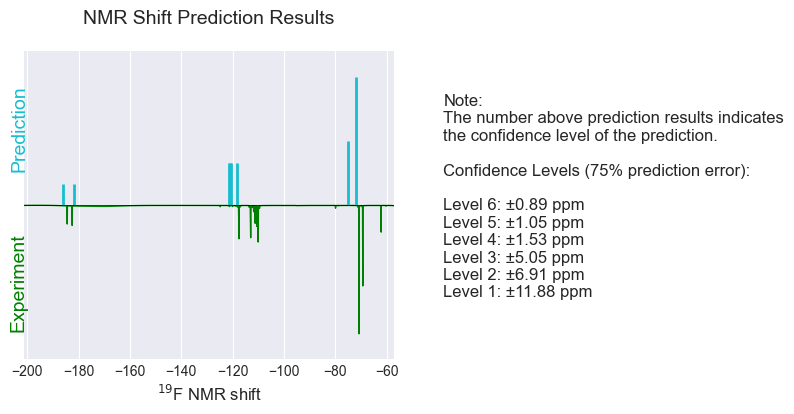

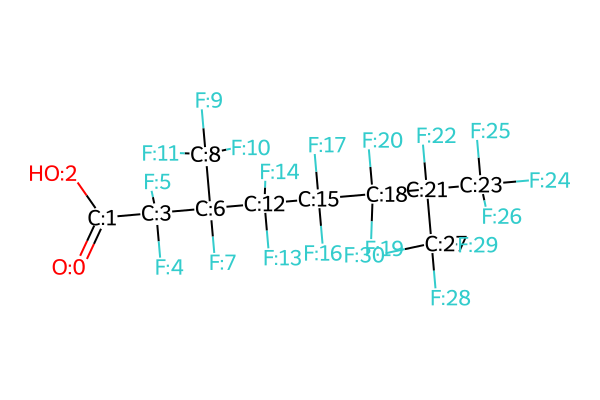

Peak at -62.10265536028726 with relative height 1.2451049729476116
Peak at -69.26423213703617 with relative height 3.759507530343112
Peak at -70.75848106798549 with relative height 6.0
Peak at -79.89030281522594 with relative height 0.12558251573912094
Peak at -109.5197040152534 with relative height 0.13491089630909425
Peak at -110.02544980726702 with relative height 1.7093634483550348
Peak at -110.11334680320522 with relative height 1.6697049351353774
Peak at -110.61233128783896 with relative height 0.9753703766800099
Peak at -111.2194966905505 with relative height 0.83207935212856
Peak at -111.76581032684328 with relative height 0.2940818934550188
Peak at -112.95850494865078 with relative height 1.5077507774029764
Peak at -117.52373969153302 with relative height 1.5572177781317444
Peak at -182.51342622675827 with relative height 0.9337240741274702
Peak at -184.45662596773036 with relative height 0.8667957646432836


In [108]:
temp_dic = {'5': 'C(=O)(C(C(C(C(C(C(C(F)(F)F)(C(F)(F)F)F)(F)F)(F)F)(F)F)(C(F)(F)F)F)(F)F)O'}
file_name = '5'
smiles = temp_dic[file_name]
compare_prediction_w_experimental_data(
        smiles=smiles, experimental_data_file_name=f"{file_name}.csv")

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_57101/1181049973.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


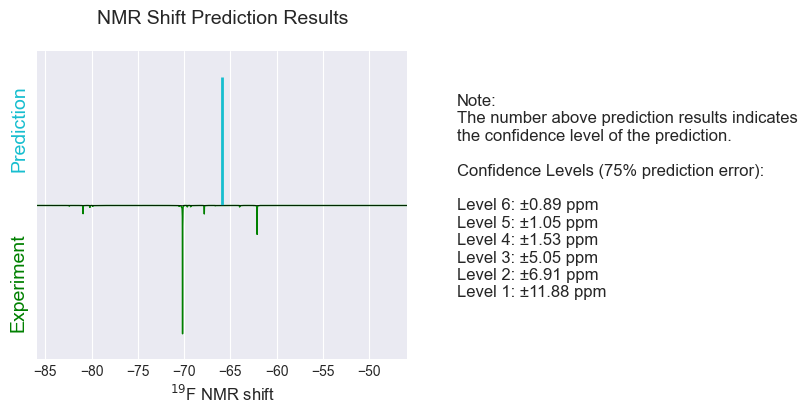

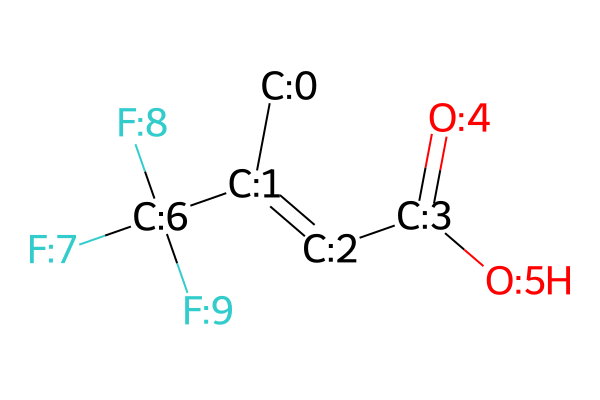

Peak at -62.10025328791582 with relative height 0.6759045477955541
Peak at -67.81489190100052 with relative height 0.19821504889147656
Peak at -70.166467042542 with relative height 3.0
Peak at -80.92232022012735 with relative height 0.19207717189418122


In [112]:
temp_dic = {'11': 'C/C(=C\C(=O)O)/C(F)(F)F'}
file_name = '11'
smiles = temp_dic[file_name]
compare_prediction_w_experimental_data(
        smiles=smiles, experimental_data_file_name=f"{file_name}.csv")


## Error Analysis-XGBoost 3D Model

In [29]:
file_path = os.path.join("..", "artifacts", "results", "Error Analysis of 9 test PFAS.xlsx")
df = pd.read_excel(file_path, sheet_name='XGBoost 3D')
df

PFAS_cpde  atom index  Prediction  Experiment  Confidence level  Error  \
0    No. 136           4      -80.37       -79.4                 2   0.97   
1    No. 136           5      -80.37       -79.4                 2   0.97   
2    No. 136           8      -57.08       -55.2                 4   1.88   
3    No. 136           9      -57.08       -55.2                 4   1.88   
4    No. 136          10      -57.08       -55.2                 4   1.88   
..       ...         ...         ...         ...               ...    ...   
60     No. 9           9      -77.21       -75.6                 3   1.61   
61     No. 9          10      -77.21       -75.6                 3   1.61   
62     No. 9          12      -77.21       -75.6                 3   1.61   
63     No. 9          13      -77.21       -75.6                 3   1.61   
64     No. 9          14      -77.21       -75.6                 3   1.61   

    Unnamed: 6  Unnamed: 7  
0          NaN         NaN  
1          NaN         NaN  
2          NaN        2.12  
3          NaN        2.12  
4          NaN        2.12  
..         ...         ...  
60         NaN         NaN  
61         NaN         NaN  
62         NaN         NaN  
63         NaN         NaN  
64         NaN         NaN  

[65 rows x 8 columns]

In [30]:
error_75_dict = {1: 18.59, 2: 9.37, 3: 6.57, 4: 1.19, 5: 1.00, 6: 0.87}
df['75%_error'] = df['Confidence level'].apply(lambda x: error_75_dict[x])
df

PFAS_cpde  atom index  Prediction  Experiment  Confidence level  Error  \
0    No. 136           4      -80.37       -79.4                 2   0.97   
1    No. 136           5      -80.37       -79.4                 2   0.97   
2    No. 136           8      -57.08       -55.2                 4   1.88   
3    No. 136           9      -57.08       -55.2                 4   1.88   
4    No. 136          10      -57.08       -55.2                 4   1.88   
..       ...         ...         ...         ...               ...    ...   
60     No. 9           9      -77.21       -75.6                 3   1.61   
61     No. 9          10      -77.21       -75.6                 3   1.61   
62     No. 9          12      -77.21       -75.6                 3   1.61   
63     No. 9          13      -77.21       -75.6                 3   1.61   
64     No. 9          14      -77.21       -75.6                 3   1.61   

    Unnamed: 6  Unnamed: 7  75%_error  
0          NaN         NaN       9.37  
1          NaN         NaN       9.37  
2          NaN        2.12       1.19  
3          NaN        2.12       1.19  
4          NaN        2.12       1.19  
..         ...         ...        ...  
60         NaN         NaN       6.57  
61         NaN         NaN       6.57  
62         NaN         NaN       6.57  
63         NaN         NaN       6.57  
64         NaN         NaN       6.57  

[65 rows x 9 columns]

In [32]:
df_temp = df.copy()
df_temp["75%_error"] = df_temp["75%_error"] + 1

num_above_75_error = df_temp[df_temp['Error'] > df_temp['75%_error']+1].shape[0]
print(f'Number of predictions with error above 75%: {num_above_75_error/len(df_temp)*100}%')
print(f'Number of predictions with error below 75%: {(len(df_temp) - num_above_75_error)/len(df_temp)*100}%')
print(f'Number of predictions with error above 75%: {num_above_75_error}')
print(f'Number of predictions with error below 75%: {len(df_temp) - num_above_75_error}')

Number of predictions with error above 75%: 6.153846153846154%
Number of predictions with error below 75%: 93.84615384615384%
Number of predictions with error above 75%: 4
Number of predictions with error below 75%: 61


In [4]:
df.groupby('Confidence level')['Error'].describe()



count       mean       std    min     25%     50%    75%  \
Confidence level                                                             
1                   1.0  18.240000       NaN  18.24  18.240  18.240  18.24   
2                   9.0   2.413333  1.343233   0.56   0.970   2.220   3.57   
3                  23.0   3.529130  2.663461   0.10   1.610   3.600   5.34   
4                  12.0   2.969167  4.101644   0.27   0.615   1.880   2.27   
5                   8.0   0.843750  0.484383   0.42   0.450   0.770   1.08   
6                  12.0   0.906667  0.534880   0.20   0.370   1.035   1.40   

                    max  
Confidence level         
1                 18.24  
2                  4.07  
3                  9.55  
4                 11.59  
5                  1.75  
6                  1.40

In [10]:
df[df['Confidence level'] == 2]['Error'].describe()

count    9.000000
mean     2.413333
std      1.343233
min      0.560000
25%      0.970000
50%      2.220000
75%      3.570000
max      4.070000
Name: Error, dtype: float64

In [12]:
df = df[df['Confidence level'] > 1]

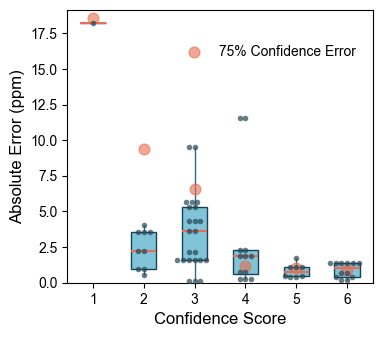

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size
# Set the figure size
plt.rcParams['font.family'] = 'Arial'
cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm

# 75% confidence level error values
confidence_data = {
    "Level": [5, 4, 3, 2, 1, 0],
    "Error": [0.87, 1.00, 1.19, 6.57, 9.37, 18.59]
}
for i, error in zip(confidence_data["Level"], confidence_data["Error"]):
    plt.scatter(i, error, color='#e76f51', s=60, edgecolor='#e76f51', zorder=3, alpha = 0.6, label="75% Confidence Error" if i == 2 else "")


# Create the boxplot to show summary statistics
ax = sns.boxplot(
    x='Confidence level', 
    y='Error', 
    data=df, 
    width=0.5,  # Adjust width for clarity
    showcaps=False,  # Hide top caps for cleaner look
    boxprops={'facecolor':'#81C3D7', 'edgecolor':'#16425B'},  # Light gray fill with black edge
    whiskerprops={'color':'#2F6690'}, 
    medianprops={'color':'#e76f51', 'linewidth':1.5},  # Red median line
    showfliers=False  # Hide outliers
)

# Overlay swarmplot to show individual data points
sns.swarmplot(
    x='Confidence level', 
    y='Error', 
    data=df, 
    color="#264653", 
    size=4,  # Adjust point size
    alpha=0.7  # Make points slightly transparent
)

# Compute and plot the mean Error for each Confidence Level
# mean_values = df.groupby("Confidence level")["Error"].mean()
# for i, mean in enumerate(mean_values):
#     plt.scatter(i, mean, color='#e76f51', s=80, edgecolor='grey', zorder=3, label="Mean" if i == 0 else "")


# Add title and labels
# plt.title("Error Distribution Across Confidence Levels", fontsize=14, fontweight='bold')
plt.xlabel("Confidence Score", fontsize=12)
plt.ylabel("Absolute Error (ppm)", fontsize=12)

# Set the y-axis limit to ensure no negative values appear
plt.ylim(0, None)  # Ensures error values start at 0

# Improve grid visibility
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show legend for mean marker
plt.legend(loc=[0.35, 0.8], frameon = False)
# Show the plot
plt.show()


# Error Analysis FFNN 2D model

In [99]:
file_path = os.path.join("..", "artifacts", "results", "Error Analysis of 9 test PFAS.xlsx")
df = pd.read_excel(file_path, sheet_name='20250630 FFNN 2D')
df

PFAS_cpde  atom index  Prediction  Experiment  Confidence level  Error
0    No. 136           4      -82.06       -79.4                 2   2.66
1    No. 136           5      -82.06       -79.4                 2   2.66
2    No. 136           8      -59.63       -55.2                 4   4.43
3    No. 136           9      -59.63       -55.2                 4   4.43
4    No. 136          10      -59.63       -55.2                 4   4.43
..       ...         ...         ...         ...               ...    ...
63     No. F          18     -126.43      -125.7                 6   0.73
64     No. F          19     -126.43      -125.7                 6   0.73
65     No. F          21      -81.23       -80.8                 6   0.43
66     No. F          22      -81.23       -80.8                 6   0.43
67     No. F          23      -81.23       -80.8                 6   0.43

[68 rows x 6 columns]

In [100]:
error_75_dict = {1: 13.8, 2: 13.73, 3: 7.57, 4: 2.8, 5: 1.75, 6: 1.01}
# df['Confidence level'] = [4 if x >= 4 else x for x in df['Confidence level']]
df['75%_error'] = df['Confidence level'].apply(lambda x: error_75_dict[x])
df

PFAS_cpde  atom index  Prediction  Experiment  Confidence level  Error  \
0    No. 136           4      -82.06       -79.4                 2   2.66   
1    No. 136           5      -82.06       -79.4                 2   2.66   
2    No. 136           8      -59.63       -55.2                 4   4.43   
3    No. 136           9      -59.63       -55.2                 4   4.43   
4    No. 136          10      -59.63       -55.2                 4   4.43   
..       ...         ...         ...         ...               ...    ...   
63     No. F          18     -126.43      -125.7                 6   0.73   
64     No. F          19     -126.43      -125.7                 6   0.73   
65     No. F          21      -81.23       -80.8                 6   0.43   
66     No. F          22      -81.23       -80.8                 6   0.43   
67     No. F          23      -81.23       -80.8                 6   0.43   

    75%_error  
0       13.73  
1       13.73  
2        2.80  
3        2.80  
4        2.80  
..        ...  
63       1.01  
64       1.01  
65       1.01  
66       1.01  
67       1.01  

[68 rows x 7 columns]

In [101]:
df_temp = df.copy()

num_above_75_error = df_temp[df_temp['Error'] > df_temp['75%_error']].shape[0]
print(f'Number of predictions with error above 75%: {num_above_75_error/len(df_temp)*100:.2f}%')
print(f'Number of predictions with error below 75%: {(len(df_temp) - num_above_75_error)/len(df_temp)*100:.2f}%')
print(f'Number of predictions with error above 75%: {num_above_75_error}')
print(f'Number of predictions with error below 75%: {len(df_temp) - num_above_75_error}')

Number of predictions with error above 75%: 22.06%
Number of predictions with error below 75%: 77.94%
Number of predictions with error above 75%: 15
Number of predictions with error below 75%: 53


In [102]:
df_temp = df.copy()
df_temp["75%_error"] = df_temp["75%_error"] + 1

num_above_75_error = df_temp[df_temp['Error'] > df_temp['75%_error']+1].shape[0]
print(f'Number of predictions with error above 75% + 1 ppm: {num_above_75_error/len(df_temp)*100:.2f}%')
print(f'Number of predictions with error below 75% + 1 ppm: {(len(df_temp) - num_above_75_error)/len(df_temp)*100:.2f}%')
print(f'Number of predictions with error above 75% + 1 ppm: {num_above_75_error}')
print(f'Number of predictions with error below 75% + 1 ppm: {len(df_temp) - num_above_75_error}')

Number of predictions with error above 75% + 1 ppm: 5.88%
Number of predictions with error below 75% + 1 ppm: 94.12%
Number of predictions with error above 75% + 1 ppm: 4
Number of predictions with error below 75% + 1 ppm: 64


In [103]:
df.groupby('Confidence level')['Error'].describe()

count      mean       std   min   25%   50%   75%    max
Confidence level                                                          
1                   1.0  3.170000       NaN  3.17  3.17  3.17  3.17   3.17
2                   9.0  3.186667  2.319801  0.12  1.09  2.66  4.50   7.56
3                  23.0  3.606957  3.083243  0.42  0.58  3.96  6.15  10.31
4                   9.0  4.016667  3.550683  0.46  1.41  4.43  4.43   9.56
5                   7.0  0.841429  0.545724  0.42  0.44  0.46  1.19   1.75
6                  19.0  0.848947  0.475136  0.20  0.43  0.73  1.40   1.40

/Users/kiluarao/ML/SCI_Project/NMR 19F/19F_NMR_Spectrum Predictor/.venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_81458/762226440.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=[0.36, 0.8], frameon = False)


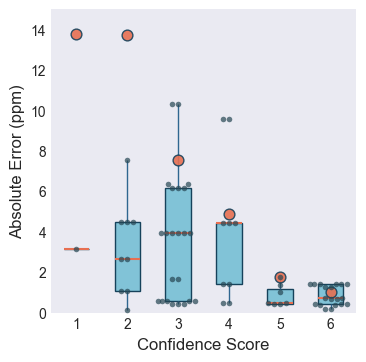

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size
# Set the figure size
plt.rcParams['font.family'] = 'Arial'
cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10 * cm, 10 * cm))  # 8 cm x 8 cm

# 75% confidence level error values
confidence_data = {
    "Level": [5, 4, 3, 2, 1, 0],
    "Error": [1.01, 1.75, 4.90, 7.57, 13.73, 13.8]
}
for i, error in zip(confidence_data["Level"], confidence_data["Error"]):
    plt.scatter(i, error, color='#e76f51', s=60, edgecolor='#16425B', zorder=3, alpha = 0.9)
    # label="75% Error Threshold" if i == 2 else ""


# Create the boxplot to show summary statistics
ax = sns.boxplot(
    x='Confidence level', 
    y='Error', 
    data=df, 
    width=0.5,  # Adjust width for clarity
    showcaps=False,  # Hide top caps for cleaner look
    boxprops={'facecolor':'#81C3D7', 'edgecolor':'#16425B'},  # Light gray fill with black edge
    whiskerprops={'color':'#2F6690'}, 
    medianprops={'color':'#e76f51', 'linewidth':1.5},  # Red median line
    showfliers=False  # Not show outliers
)

# Overlay swarmplot to show individual data points
sns.swarmplot(
    x='Confidence level', 
    y='Error', 
    data=df, 
    color="#264653", 
    size=4,  # Adjust point size
    alpha=0.7  # Make points slightly transparent
)

# Add title and labels
# plt.title("Error Distribution Across Confidence Levels", fontsize=14, fontweight='bold')
plt.xlabel("Confidence Score", fontsize=12)
plt.ylabel("Absolute Error (ppm)", fontsize=12)

# Set the y-axis limit to ensure no negative values appear
plt.ylim(0, 15)  # Ensures error values start at 0

# Improve grid visibility
plt.grid(axis='x', linestyle='--', alpha=0.0)
plt.grid(axis='y', linestyle='--', alpha=0.0)
# Show legend for mean marker
plt.legend(loc=[0.36, 0.8], frameon = False)
# Show the plot
plt.show()


# Retrain XGBoost 2D model with the full dataset

In [63]:
def get_2d_descriptors_w_shifts_train(dataset):    
    """
    Extract 2D atomic descriptors from the dataset using 2D neighbors.
    """
    extractor = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
    descriptors = extractor.getDescriptorsFromDataset(dataset, 5)
    descriptors = descriptors.apply(common.safe_to_numeric)
    descriptors.columns = descriptors.columns.astype(str)
    return descriptors

def get_3d_descriptors_w_shifts_train(dataset):
    descriptors = atomic_features_3D.Combine_descriptors(dataset, num_neighbors=5, with_additional_info=False)
    descriptors = descriptors.apply(common.safe_to_numeric)
    descriptors.columns = descriptors.columns.astype(str)
    return descriptors

def data_preprocessing_1_for_train_dataset(descriptors):
    """
    Preprocess the descriptors for training:
        1. Drop constant columns.
        2. Drop columns with >80% NaN values.
        3. Drop rows with NaN in 'NMR_Peaks'.
        4. Drop categorical columns.
        5. Separate features and target.
    """
    descriptors = common.drop_constant_col(descriptors)
    descriptors = common.drop_high_ratio_NaN_cols(descriptors)
    descriptors = descriptors.dropna(subset=["NMR_Peaks"])
    descriptors = descriptors.apply(common.safe_to_numeric)
    descriptors = common.drop_categorical_columns(descriptors)
    descriptors.columns = descriptors.columns.astype(str)

    y_train = descriptors["NMR_Peaks"]
    X_train = descriptors.drop(columns=["NMR_Peaks"])
    return X_train, y_train, X_train.columns.tolist()


def data_preprocessing_1_for_test_dataset(X_test, train_col_names):
    """
    Align test dataset with training dataset column names and convert to numeric.
    """
    X_test = X_test[train_col_names].apply(common.safe_to_numeric)
    X_test.columns = X_test.columns.astype(str)
    return X_test


def data_preprocessing_2_for_X_train(X_train):
    """
    Impute missing values and scale training features.
    """
    X_train, imputer = common.fill_NaN(X_train)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    return X_train_scaled, imputer, scaler


def data_preprocessing_2_for_X_test(X_test, imputer, scaler):
    """
    Apply imputation and scaling to test features.
    """
    X_test_imputed = imputer.transform(X_test)
    X_test_scaled = scaler.transform(X_test_imputed)
    return pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


def get_XGB_regressor(X, y, model_param):
    """
    Trains an XGBoost Regressor using a validation split.

    Parameters:
        X (pd.DataFrame or np.ndarray): Feature matrix.
        y (pd.Series or np.ndarray): Target variable.
        model_param (dict): Hyperparameters for the XGBRegressor.

    Returns:
        best_model (XGBRegressor): Trained XGBoost model.
    """
    # Split data into training and validation sets
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    # Initialize and configure model
    model = XGBRegressor(early_stopping_rounds=20, **model_param)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

    # Evaluate model performance
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    return model

def get_FFNN_regressor(X, y, config):
    model = Sequential([
        # Input layer
        Input(shape=(X.shape[1],)),
        Dense(config['layers'][0], activation='relu'),
        BatchNormalization(),
        Dropout(config['dropout'][0]),

        Dense(config['layers'][1], activation='relu'),
        BatchNormalization(),
        Dropout(config['dropout'][1]),

        # Hidden layers
        Dense(config['layers'][2], activation='relu'),
        BatchNormalization(),
        Dropout(config['dropout'][2]),
        
        # Output layer - for regression task
        Dense(1),
        Lambda(lambda x:-x) # all 19F NMR values are negative in our dataset
    ])
    
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20)

    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Compile model
    # Use Huber loss for our task, which is less sensitive to outliers. 
    # For small errors ([error] < delta), it behaves like MSE, and for large errors, it behaves like MAE.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.Huber(delta=3), 
        metrics=['mean_squared_error', 'mean_absolute_error']
    )

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

    # Fit the model
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, lr_scheduler],
        verbose=0
    )
    # Evaluate model performance
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    return model


In [66]:
data_path = os.path.join("..", "dataset", "Processed_PFAS_19F_NMR_spectra_data.csv")
all_fluorinated_compounds = pd.read_csv(data_path)

# Optimized in the notebook: 2_XGBoost_model_2D_and_3D_descriptors.ipynb
param_2d_s5 = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
param_3d_n5 = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

print('Performance of XGBoost 2D model after training on the whole dataset')
descriptors_2d = get_2d_descriptors_w_shifts_train(all_fluorinated_compounds)
X_train_2d, y_train_2d, columns_2d = data_preprocessing_1_for_train_dataset(descriptors_2d)
best_xgboost_2d_model = get_XGB_regressor(X_train_2d, y_train_2d, param_2d_s5)

print('\nPerformance of XGBoost 3D model after training on the whole dataset')
descriptors_3d = get_3d_descriptors_w_shifts_train(all_fluorinated_compounds)
X_train_3d, y_train_3d, columns_3d = data_preprocessing_1_for_train_dataset(descriptors_3d)
best_xgboost_3d_model = get_XGB_regressor(X_train_3d, y_train_3d, param_3d_n5)

config = {'layers': [128, 64, 32], 'dropout': [0.2, 0.1, 0.0]}
print('\nPerformance of FFNN 2D model after training on the whole dataset')
X_train_scaled_2d, imputer_2d, scaler_2d  = data_preprocessing_2_for_X_train(X_train_2d)
best_FFNN_model = get_FFNN_regressor(X_train_scaled_2d, y_train_2d, config)


Performance of XGBoost 2D model after training on the whole dataset
MAE: 2.59
RMSE: 5.06
R² Score: 0.97

Performance of XGBoost 3D model after training on the whole dataset
MAE: 2.45
RMSE: 6.02
R² Score: 0.96

Performance of FFNN 2D model after training on the whole dataset
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE: 3.02
RMSE: 6.81
R² Score: 0.95


# Model Explanation

In [53]:
def get_dataset_from_smiles(smiles):
    smiles = common.canonical_smiles([smiles])[0]
    train_fluorinated_compounds_file_path=os.path.join("..", "dataset", "Processed_PFAS 19F NMR spectra data.csv"),
    # Generate sdf file from SMILES
    atomic_features_3D.get_sdf_file(smiles)
    # Generate CDK descriptors and Neighbors information
    atomic_features_3D.get_descriptors_and_neighbors_info()
    # Use the CDK descriptors and Neighbors information to get the features table
    train_dataset = pd.read_csv(train_fluorinated_compounds_file_path, index_col=0)
    dataset = atomic_features_3D.get_test_fluorianted_compounds_info(
        smiles, train_dataset
    )
    return dataset

def get_HOSE_results(dataset, train_fluorinated_compounds):
    # Get Prediction results from HOSE model

    HOSE_Code_database = hose_code.getHoseCodeContent(train_fluorinated_compounds)
    # Get HOSE Code and corresponding 19F NMR values using train dataset
    sphere_dics = hose_code.getTrainDictionary_HOSE(HOSE_Code_database)
    HOSE_Code_database["NMR_Peaks"] = HOSE_Code_database["NMR_Peaks"].astype(float)
    HOSE_Code_database_file_path = os.path.join('..', 'artifacts', 'temp', 'temp.csv')
    HOSE_Code_database.to_csv(HOSE_Code_database_file_path, index=False)
    HOSE_results = hose_code.get_HOSE_prediction_results_table(HOSE_Code_database_file_path, dataset)
    return HOSE_results
        

In [ ]:
# Test PFAS
# SMILES = The PFAS code is: aromatics_18
# The F atom indices are: ['7']
# Corresponding NMR shifts for these F atoms are: [-169.87]
# The SMILES for the molecule is: Oc1c(F)c(F)c(F)c(F)c1F
# XGBoost 2D prediction: ['NaN']
# XGBoost 3D prediction: ['NaN']
# FFNN 2D prediction: ['NaN']
# HOSE Code prediction: ['NaN']

# No. 1
# The PFAS code is: aromatics_15
# The F atom indices are: ['7']
# Corresponding NMR shifts for these F atoms are: [-173.95]
# The SMILES for the molecule is: Nc1c(F)c(F)c(F)c(F)c1F
# XGBoost 2D prediction: [-165.58766]
# XGBoost 3D prediction: [-164.36075]
# FFNN 2D prediction: [-184.77571]
# HOSE Code prediction: [-159.137]

# # No. 2
# The PFAS code is: aromatics_19
# The F atom indices are: ['0' '13']
# Corresponding NMR shifts for these F atoms are: [-150. -150.]
# The SMILES for the molecule is: Fc1c(F)c(F)c(-c2c(F)c(F)c(F)c(F)c2F)c(F)c1F
# XGBoost 2D prediction: [-158.8617 -182.50105]
# XGBoost 3D prediction: [-145.43129 -143.5801]
# FFNN 2D prediction: [-141.20282 -143.67397]
# HOSE Code prediction: [-151.14999999999998 -151.14999999999998]

# No. 3 is F0 and 4 is F2
# The PFAS code is: From_Review_446
# The F atom indices are: ['0' '2']
# Corresponding NMR shifts for these F atoms are: [-104.  -85.]
# The SMILES for the molecule is: FC(F)=C(F)SC(F)(F)F
# XGBoost 2D prediction: [-109.36687 -109.36687]
# XGBoost 3D prediction: [-103.08225 -106.94162]
# FFNN 2D prediction: [-104.38137  -79.22931]
# HOSE Code prediction: [-101.95384615 -101.95384615]

# No. 4
# he PFAS code is: From_Review_434
# The F atom indices are: ['5' '6']
# Corresponding NMR shifts for these F atoms are: [-121. -121.]
# The SMILES for the molecule is: COC(=O)C(F)(F)C(F)(F)N1C(F)(F)C(F)(F)OC(F)(F)C1(F)F
# XGBoost 2D prediction: [-120.47892 -120.47892]
# XGBoost 3D prediction: [-122.31879 -121.52271]
# FFNN 2D prediction: [-112.95885 -112.95885]
# HOSE Code prediction: [-121.89506269 -121.89506269]

# No. 6
# The PFAS code is: From_Review_436
# The F atom indices are: ['5' '6']
# Corresponding NMR shifts for these F atoms are: [-115. -115.]
# The SMILES for the molecule is: COC(=O)C(F)(F)C(F)(F)N(C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F
# XGBoost 2D prediction: [-119.832085 -119.832085]
# XGBoost 3D prediction: [-120.05381  -120.441986]
# FFNN 2D prediction: [-120.95417 -120.95417]
# HOSE Code prediction: [-121. -121.]

In [20]:
all_fluorinated_compounds.head(3)

Group  IsPFAS(haveCF2)  \
0  Per- and polyfluorinated carboxylic acids             True   
1  Per- and polyfluorinated carboxylic acids             True   
2  Per- and polyfluorinated carboxylic acids             True   

             Compound name    Code Solvent_used_for_NMR  \
0  perfluoropropionic acid  COOH_1                CDCl3   
1   perfluorobutanoic acid  COOH_2                CDCl3   
2  perfluoropentanoic acid  COOH_3                CDCl3   

                                SMILES Internal Standard  \
0                O=C(O)C(F)(F)C(F)(F)F               NaN   
1         O=C(O)C(F)(F)C(F)(F)C(F)(F)F               NaN   
2  O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F               NaN   

   FluorineInConjSystem   0   1    2   3       4       5   6       7       8  \
0                   0.0 NaN NaN  NaN NaN -122.45 -122.45 NaN  -83.40  -83.40   
1                   0.0 NaN NaN  NaN NaN -119.78 -119.78 NaN -127.39 -127.39   
2                   0.0 NaN NaN  NaN NaN -119.41 -119.41 NaN -123.99 -123.99   

      9      10      11     12     13     14     15   16  17  18  19  20  21  \
0 -83.4     NaN     NaN    NaN    NaN    NaN    NaN  NaN NaN NaN NaN NaN NaN   
1   NaN  -81.14  -81.14 -81.14    NaN    NaN    NaN  NaN NaN NaN NaN NaN NaN   
2   NaN -126.26 -126.26    NaN -81.19 -81.19 -81.19  NaN NaN NaN NaN NaN NaN   

   22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  \
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

   41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  \
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

   60  61  62  63  64  65  66  67  68  69  70  
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN

In [60]:
PFAS_code = ['aromatics_15', 'aromatics_19', 'From_Review_446', 'From_Review_434', 'From_Review_436']

data_path = os.path.join("..", "dataset", "Processed_PFAS_19F_NMR_spectra_data.csv")
all_fluorinated_compounds = pd.read_csv(data_path)
test_fluorinated_compounds = all_fluorinated_compounds[all_fluorinated_compounds['Code'].isin(PFAS_code)]
train_fluorinated_compounds = all_fluorinated_compounds[~all_fluorinated_compounds['Code'].isin(PFAS_code)]

# Optimized in the notebook: 2_XGBoost_model_2D_and_3D_descriptors.ipynb
param_2d_s5 = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
param_3d_n5 = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

print('Performance of XGBoost 2D model after training on the whole dataset')
descriptors_2d = get_2d_descriptors_w_shifts_train(train_fluorinated_compounds)
X_train_2d, y_train_2d, columns_2d = data_preprocessing_1_for_train_dataset(descriptors_2d)
best_xgboost_2d_model = get_XGB_regressor(X_train_2d, y_train_2d, param_2d_s5)

print('\nPerformance of XGBoost 3D model after training on the whole dataset')
descriptors_3d = get_3d_descriptors_w_shifts_train(train_fluorinated_compounds)
X_train_3d, y_train_3d, columns_3d = data_preprocessing_1_for_train_dataset(descriptors_3d)
best_xgboost_3d_model = get_XGB_regressor(X_train_3d, y_train_3d, param_3d_n5)

config = {'layers': [128, 64, 32], 'dropout': [0.2, 0.1, 0.0]}
print('\nPerformance of FFNN 2D model after training on the whole dataset')
X_train_scaled_2d, imputer_2d, scaler_2d  = data_preprocessing_2_for_X_train(X_train_2d)
best_FFNN_model = get_FFNN_regressor(X_train_scaled_2d, y_train_2d, config)

Performance of XGBoost 2D model after training on the whole dataset
MAE: 2.83
RMSE: 6.08
R² Score: 0.96

Performance of XGBoost 3D model after training on the whole dataset
MAE: 2.32
RMSE: 5.03
R² Score: 0.98

Performance of FFNN 2D model after training on the whole dataset
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE: 3.31
RMSE: 9.59
R² Score: 0.91


In [286]:
descriptors_2d_test = get_2d_descriptors_w_shifts_train(test_fluorinated_compounds)
X_test_2d = descriptors_2d_test.drop(columns=["NMR_Peaks"])
y_test = descriptors_2d_test["NMR_Peaks"]
X_test_2d = data_preprocessing_1_for_test_dataset(X_test_2d, columns_2d)

descriptors_3d_test = get_3d_descriptors_w_shifts_train(test_fluorinated_compounds)
X_test_3d = descriptors_3d_test.drop(columns=["NMR_Peaks"])
y_test_3d = descriptors_3d_test["NMR_Peaks"]
X_test_3d = data_preprocessing_1_for_test_dataset(X_test_3d, columns_3d)

X_test_scaled_2d = data_preprocessing_2_for_X_test(X_test_2d, imputer_2d, scaler_2d)

xgboost_2d_model_predict = best_xgboost_2d_model.predict(X_test_2d)
xgboost_3d_model_predict = best_xgboost_3d_model.predict(X_test_3d)
ffnn_2d_model_predict = best_FFNN_model.predict(X_test_scaled_2d)

/Users/kiluarao/ML/SCI_Project/NMR 19F/19F_NMR_Spectrum Predictor/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [68]:
hose_results = get_HOSE_results(test_fluorinated_compounds, train_fluorinated_compounds)
hose_results

[15:42:39] UFFTYPER: Warning: hybridization set to SP3 for atom 6


actual  prediction       diff  similarity_levels
3_aromatics_15    -162.49 -145.990148  16.499852                  2
5_aromatics_15    -165.34 -158.022083   7.317917                  3
7_aromatics_15    -173.95 -160.162222  13.787778                  4
9_aromatics_15    -165.34 -156.964545   8.375455                  3
11_aromatics_15   -162.49 -145.990148  16.499852                  2
...                   ...         ...        ...                ...
2_From_Review_446  -85.00 -101.284783  16.284783                  2
4_From_Review_446 -155.00 -105.420022  49.579978                  1
7_From_Review_446  -46.00  -76.105455  30.105455                  2
8_From_Review_446  -46.00  -76.105455  30.105455                  2
9_From_Review_446  -46.00  -76.105455  30.105455                  2

[47 rows x 4 columns]

In [69]:
y_test = pd.DataFrame(y_test)
y_test.rename(columns={"NMR_Peaks": "Ground_Truth"}, inplace=True)
y_test['xgboost_2d'] = xgboost_2d_model_predict
y_test['xgboost_3d'] = xgboost_3d_model_predict
y_test['ffnn_2d'] = ffnn_2d_model_predict
y_test['hose'] = hose_results['prediction']
y_test['similarity_levels'] = hose_results['similarity_levels']
y_test.head(3)

Ground_Truth  xgboost_2d  xgboost_3d     ffnn_2d        hose  \
3_aromatics_15       -162.49 -158.539169 -148.616699 -156.055908 -145.990148   
5_aromatics_15       -165.34 -159.771133 -165.152222 -172.017685 -158.022083   
7_aromatics_15       -173.95 -165.118683 -167.111710 -165.407639 -160.162222   

                similarity_levels  
3_aromatics_15                  2  
5_aromatics_15                  3  
7_aromatics_15                  4

In [70]:
idx = ['7_aromatics_15', '0_aromatics_19', '0_From_Review_446', '4_From_Review_446', '5_From_Review_434', '5_From_Review_436']

y_test.loc[idx, :]

Ground_Truth  xgboost_2d  xgboost_3d     ffnn_2d  \
7_aromatics_15          -173.95 -165.118683 -167.111710 -165.407639   
0_aromatics_19          -150.00 -150.046600 -151.188019 -145.232758   
0_From_Review_446       -104.00  -95.575027 -100.066628  -95.752823   
4_From_Review_446       -155.00 -149.393311 -152.532547 -156.199371   
5_From_Review_434       -121.00 -119.531967 -112.160568 -122.276169   
5_From_Review_436       -115.00 -118.818253 -114.844215 -115.734268   

                         hose  similarity_levels  
7_aromatics_15    -160.162222                  4  
0_aromatics_19    -150.796667                  5  
0_From_Review_446 -101.284783                  2  
4_From_Review_446 -105.420022                  1  
5_From_Review_434 -121.801599                  2  
5_From_Review_436 -121.801599                  2

In [73]:
# Save the models:
file_path = os.path.join("..", "artifacts", "models", f"20250702_model_explanation_xgboost_2d.json")
best_xgboost_2d_model.save_model(file_path)

file_path = os.path.join("..", "artifacts", "models", f"20250702_model_explanation_xgboost_3d.json")
best_xgboost_3d_model.save_model(file_path)

file_path = os.path.join("..", "artifacts", "models", f"20250702_model_explanation_ffnn_2d.h5")
best_FFNN_model.save(file_path)

file_path = os.path.join("..", "artifacts", "models", f"20250702_model_explanation_2d_column_names.json")
with open(file_path, "wb") as f:
    pickle.dump(columns_2d, f)

file_path = os.path.join("..", "artifacts", "models", f"20250702_model_explanation_3d_column_names.json")
with open(file_path, "wb") as f:
    pickle.dump(columns_3d, f)


file_path = os.path.join("..", "artifacts", "models", f"20250702_model_explanation_2d_scaler.pkl")
with open(file_path, "wb") as file:
    pickle.dump(scaler_2d, file)


file_path = os.path.join("..", "artifacts", "models", f"20250702_model_explanation_2d_imputer.pkl")
with open(file_path, "wb") as file:
    pickle.dump(imputer_2d, file)

## Model Explanation

In [ ]:
F_idx = ['7_aromatics_15', '0_aromatics_19', '0_From_Review_446', '4_From_Review_446', '5_From_Review_434', '5_From_Review_436']


In [ ]:
def get_readable_feature_name_2d(feature_id):
    # Define the feature names in a dictionary for faster lookup
    feature_names = {
        1: 'mass',
        2: 'hybridization',
        3: 'isAromatic',
        4: 'degree',
        5: 'valence',
        6: 'explicit_valence',
        7: 'isInRing'
    }
    
    # Determine the sphere number
    if feature_id <= 6:
        sphere = 1
        number_of_features_in_previous_spheres = 0
    elif feature_id <= 27:
        sphere = 2
        number_of_features_in_previous_spheres = 7
    else:
        sphere = 3
        number_of_features_in_previous_spheres = 28

    # Calculate item number and feature number
    items_number = (feature_id - number_of_features_in_previous_spheres) // 7 + 1
    feature_number = feature_id + 1 - number_of_features_in_previous_spheres - (items_number - 1) * 7
    
    # Get feature name using dictionary lookup
    feature_name = feature_names.get(feature_number, 'Unknown Feature')  # Default to 'Unknown Feature' if not found
    
    return f"{feature_id}_sphere{sphere}_item{items_number}_{feature_name}'"

X_test_2d.columns = X_test_2d.columns.map(lambda x: get_readable_feature_name_2d(int(x)))
X_test_2d.loc[F_idx, :].to_csv('temp.csv')

In [ ]:
# xgboost_2d_model_predict = best_xgboost_2d_model.predict(X_test_2d)
# xgboost_3d_model_predict = best_xgboost_3d_model.predict(X_test_3d)
# ffnn_2d_model_predict = best_FFNN_model.predict(X_test_scaled_2d)
# y_test
import shap

explainer = shap.Explainer(best_FFNN_model.predict, X_test_scaled_2d)
shap_values = explainer(X_test_scaled_2d)
shap_values

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
203/203 ━━━

.values =
array([[ 0.00000000e+00,  3.81689697e+00, -5.63286615e+00, ...,
         1.02115875e-01,  1.08388442e+00,  6.64538444e-01],
       [ 0.00000000e+00,  5.81855116e+00, -6.51655522e+00, ...,
         5.51288686e-03, -9.39761060e-01, -1.98909029e-01],
       [ 0.00000000e+00,  5.29082286e+00, -6.77156181e+00, ...,
         3.06278797e-02, -1.13418336e+00, -6.79759817e-01],
       ...,
       [ 0.00000000e+00, -1.60903156e+00,  1.88958371e+00, ...,
        -7.50671874e-01,  1.92709391e+00, -3.45081938e-01],
       [ 0.00000000e+00, -1.96079453e+00,  1.84799718e+00, ...,
        -1.06717747e+00,  1.94732033e+00, -1.52322607e-01],
       [ 0.00000000e+00, -2.56522296e+00,  2.36076692e+00, ...,
        -1.24139843e+00,  1.92422664e+00, -6.90912287e-02]])

.base_values =
array([[-111.11945968],
       [-111.11945968],
       [-111.11945968],
       [-111.11945968],
       [-111.11945968],
       [-111.11945968],
       [-111.11945968],
       [-111.11945968],
       [-111.11945968],
 

In [87]:
print(type(shap_values))
print(np.shape(shap_values))

<class 'shap._explanation.Explanation'>
(47, 139)


In [88]:
shap_values_df= pd.DataFrame(shap_values.values, columns = X_test_scaled_2d.columns, index=X_test_scaled_2d.index)
shap_values_df.head(3)

0         1         2         3    5         6         7  \
3_aromatics_15  0.0  3.816897 -5.632866 -3.524007  0.0 -6.052979 -1.074867   
5_aromatics_15  0.0  5.818551 -6.516555 -4.041279  0.0 -7.603183 -1.765518   
7_aromatics_15  0.0  5.290823 -6.771562 -5.363887  0.0 -5.890070 -1.066693   

                       8         9        10        11        12        13  \
3_aromatics_15  1.332640  0.153375  0.029414 -4.824506 -0.647217 -0.146974   
5_aromatics_15  1.932557  0.473029 -0.052153 -4.958854 -0.811862  0.799995   
7_aromatics_15  0.794302  0.429290 -0.218289 -5.259973 -0.554408  0.000264   

                      14        15        16         17         18        19  \
3_aromatics_15  0.411814 -2.179532 -0.398606  -8.191815 -11.345160 -4.822609   
5_aromatics_15  0.228136 -0.824700 -1.323133 -11.071671  -7.816437 -4.556239   
7_aromatics_15  0.747983 -1.643097 -0.501936  -7.818055  -5.921152 -6.769249   

                      20        21        22        23        24        25  \
3_aromatics_15 -4.998463  0.748894 -0.175476  0.143810  2.210413  5.140117   
5_aromatics_15 -3.903731  0.000206 -0.660161  0.257536  2.005546 -0.414192   
7_aromatics_15 -3.419362  0.666438 -0.202077  0.271122  2.369895  5.353744   

                      26        27        28        29        30        31  \
3_aromatics_15  2.209572 -1.308181 -0.068049 -0.636890 -0.545602 -1.115728   
5_aromatics_15  2.718794 -1.435647  0.131130 -0.749752  2.850421 -0.146829   
7_aromatics_15  2.313319 -1.394177  0.141008 -1.238092  1.368707 -0.201583   

                      32        33        34        35        36        37  \
3_aromatics_15 -1.629576 -3.817793 -1.492140 -0.582244  1.657479  1.485163   
5_aromatics_15  2.249693  1.194970  1.762340 -0.013599 -1.134391 -0.064686   
7_aromatics_15  2.265194  1.210956  2.148529  0.063003 -1.359531 -0.012874   

                      38        39        40        41        42        43  \
3_aromatics_15  1.304656  3.683927  2.705213  0.596762  0.162565  0.006884   
5_aromatics_15 -1.188603 -1.641999 -1.214044  0.072068  0.064426 -0.178941   
7_aromatics_15 -0.462374 -1.780678 -1.360773  0.212555  0.166029  0.052889   

                      44        45        46        47        48        49  \
3_aromatics_15 -0.236514 -0.009773 -0.369266 -0.118693  0.030333  0.211672   
5_aromatics_15 -0.423520 -0.104914 -0.495268 -0.314136 -0.057362  0.098845   
7_aromatics_15 -0.249501  0.019591 -0.391826 -0.146115  0.222659  0.213114   

                      50  ...       111       112       113       114  \
3_aromatics_15 -0.808382  ...  0.628136  0.251302 -2.383233 -1.417695   
5_aromatics_15 -0.392331  ...  1.064357  0.173020 -6.235532 -0.762958   
7_aromatics_15 -1.883701  ...  0.728935  0.226984 -3.652382 -1.966794   

                     115       116       117       118       119       120  \
3_aromatics_15  0.691297  0.464563  0.328165 -0.778745 -0.454475 -0.121157   
5_aromatics_15  0.763501  0.299322  0.957336  0.130770 -0.090245  0.095272   
7_aromatics_15  0.618177  0.420912  0.799817 -0.600115  0.134329  1.836410   

                     121       122       123       124       125       126  \
3_aromatics_15 -0.063977 -0.624408 -0.825851 -0.204200 -0.599195  0.056065   
5_aromatics_15  0.676535 -0.153140  0.807506 -0.294156 -0.180667 -0.256274   
7_aromatics_15  2.244389 -0.071139  0.404498 -0.310243 -1.162425  0.035913   

                     127       128       129       130       131       132  \
3_aromatics_15  0.402862  0.816575  0.188815 -0.025478 -0.041048 -0.072601   
5_aromatics_15  0.233695 -0.315763 -0.239281 -0.122418 -0.194483 -0.848582   
7_aromatics_15  0.136828  0.394700  0.227998 -0.091375  0.017107 -0.769323   

                     161       162       163       164       165       166  \
3_aromatics_15 -0.141475  0.277679  0.146533  0.122219  0.701374 -0.374336   
5_aromatics_15 -0.006696  0.274928  0.219526 -0.122269  0.875655 -0.871516   
7_aromatics_15  0.002025  0.273111  0.12

In [91]:
F_idx = ['7_aromatics_15', '0_aromatics_19', '0_From_Review_446', '4_From_Review_446', '5_From_Review_434', '5_From_Review_436']
row_positions = [y_test.index.get_loc(idx) for idx in F_idx]
row_positions

[2, 5, 41, 43, 15, 27]

In [162]:
# Optimized SHAP waterfall plot with better spacing and sizing
def compare_shap_waterfall(sample_indices = [2, 5], shap_values = shap_values, max_display=10):
    n_plots = len(sample_indices)
    fig = plt.figure(figsize=(6*n_plots, max_display))

    for i, sample_idx in enumerate(sample_indices):
        ax = fig.add_subplot(1, n_plots, i+1)
        plt.sca(ax)
        
        shap.plots.waterfall(
            shap_values[sample_idx], 
            max_display=max_display, 
            show=False
        )
        
        # Formatting
        ax.set_title(f"Sample {sample_idx}", fontsize=11, pad=8)
        
        for text in ax.texts:
            text.set_fontsize(8)
        
        ax.tick_params(axis='x', labelsize=9)
        ax.tick_params(axis='y', labelsize=7)
        plt.setp(ax.get_yticklabels(), ha='right')

    plt.tight_layout(pad=2.0)
    plt.show()

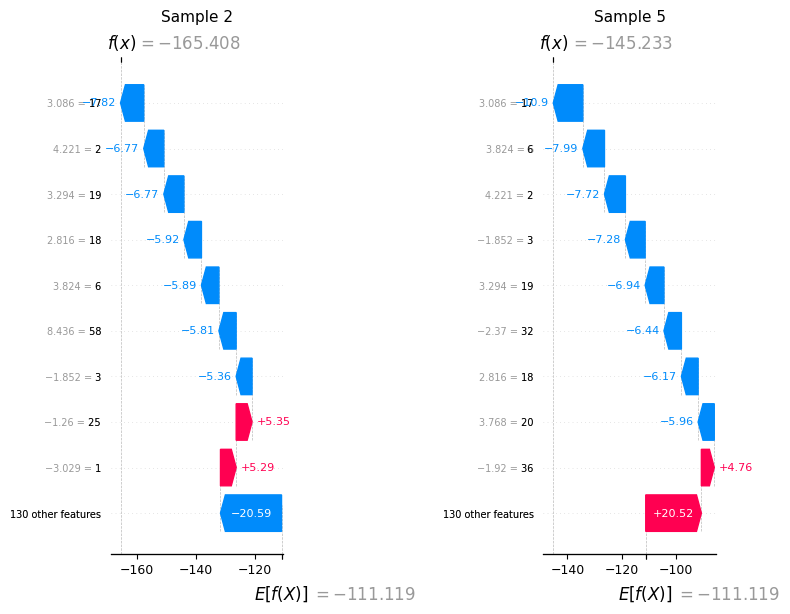

In [163]:
compare_shap_waterfall(sample_indices = [2, 5])

In [272]:
for i in [17, 2, 19, 18, 6]:
    text = common.get_readable_feature_name_2d(i)
    print(text)

The feature_id '17' corresponds to the 'degree' of the atom in Sphere '2', Item '2'
The feature_id '2' corresponds to the 'isAromatic' of the atom in Sphere '1', Item '1'
The feature_id '19' corresponds to the 'explicit_valence' of the atom in Sphere '2', Item '2'
The feature_id '18' corresponds to the 'valence' of the atom in Sphere '2', Item '2'
The feature_id '6' corresponds to the 'isInRing' of the atom in Sphere '1', Item '1'


In [273]:
for i in [17, 6, 2, 3, 19]:
    text = common.get_readable_feature_name_2d(i)
    print(text)

The feature_id '17' corresponds to the 'degree' of the atom in Sphere '2', Item '2'
The feature_id '6' corresponds to the 'isInRing' of the atom in Sphere '1', Item '1'
The feature_id '2' corresponds to the 'isAromatic' of the atom in Sphere '1', Item '1'
The feature_id '3' corresponds to the 'degree' of the atom in Sphere '1', Item '1'
The feature_id '19' corresponds to the 'explicit_valence' of the atom in Sphere '2', Item '2'


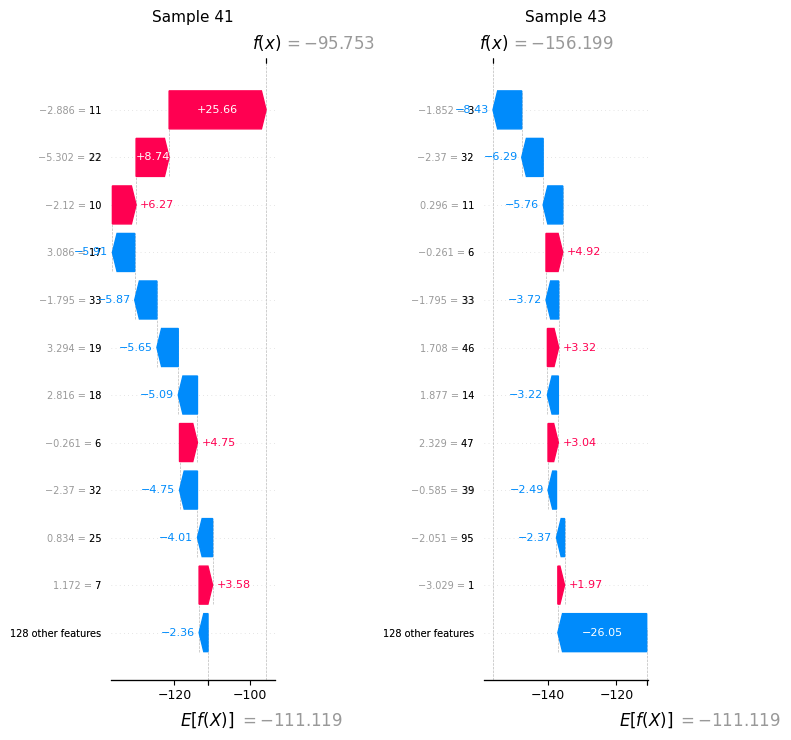

In [109]:
compare_shap_waterfall(sample_indices = [41, 43])

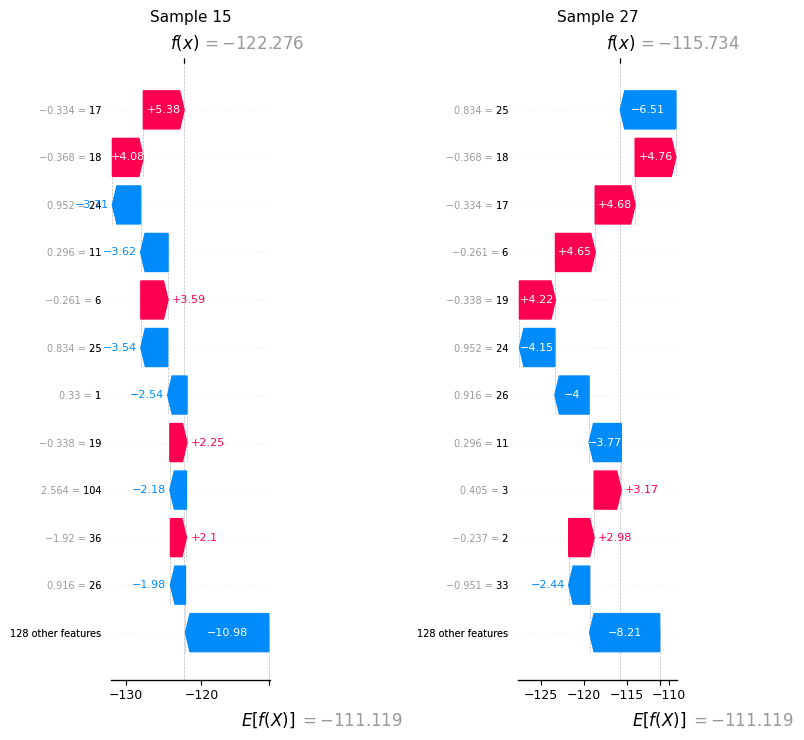

In [110]:
compare_shap_waterfall(sample_indices = [15, 27])

## SHAP importance for features in different spheres

In [114]:
print(f'Shape of shap_values_df: {shap_values_df.shape}')
shap_values_df.head(3)
# F

Shape of shap_values_df: (47, 139)


0         1         2         3    5         6         7  \
3_aromatics_15  0.0  3.816897 -5.632866 -3.524007  0.0 -6.052979 -1.074867   
5_aromatics_15  0.0  5.818551 -6.516555 -4.041279  0.0 -7.603183 -1.765518   
7_aromatics_15  0.0  5.290823 -6.771562 -5.363887  0.0 -5.890070 -1.066693   

                       8         9        10        11        12        13  \
3_aromatics_15  1.332640  0.153375  0.029414 -4.824506 -0.647217 -0.146974   
5_aromatics_15  1.932557  0.473029 -0.052153 -4.958854 -0.811862  0.799995   
7_aromatics_15  0.794302  0.429290 -0.218289 -5.259973 -0.554408  0.000264   

                      14        15        16         17         18        19  \
3_aromatics_15  0.411814 -2.179532 -0.398606  -8.191815 -11.345160 -4.822609   
5_aromatics_15  0.228136 -0.824700 -1.323133 -11.071671  -7.816437 -4.556239   
7_aromatics_15  0.747983 -1.643097 -0.501936  -7.818055  -5.921152 -6.769249   

                      20        21        22        23        24        25  \
3_aromatics_15 -4.998463  0.748894 -0.175476  0.143810  2.210413  5.140117   
5_aromatics_15 -3.903731  0.000206 -0.660161  0.257536  2.005546 -0.414192   
7_aromatics_15 -3.419362  0.666438 -0.202077  0.271122  2.369895  5.353744   

                      26        27        28        29        30        31  \
3_aromatics_15  2.209572 -1.308181 -0.068049 -0.636890 -0.545602 -1.115728   
5_aromatics_15  2.718794 -1.435647  0.131130 -0.749752  2.850421 -0.146829   
7_aromatics_15  2.313319 -1.394177  0.141008 -1.238092  1.368707 -0.201583   

                      32        33        34        35        36        37  \
3_aromatics_15 -1.629576 -3.817793 -1.492140 -0.582244  1.657479  1.485163   
5_aromatics_15  2.249693  1.194970  1.762340 -0.013599 -1.134391 -0.064686   
7_aromatics_15  2.265194  1.210956  2.148529  0.063003 -1.359531 -0.012874   

                      38        39        40        41        42        43  \
3_aromatics_15  1.304656  3.683927  2.705213  0.596762  0.162565  0.006884   
5_aromatics_15 -1.188603 -1.641999 -1.214044  0.072068  0.064426 -0.178941   
7_aromatics_15 -0.462374 -1.780678 -1.360773  0.212555  0.166029  0.052889   

                      44        45        46        47        48        49  \
3_aromatics_15 -0.236514 -0.009773 -0.369266 -0.118693  0.030333  0.211672   
5_aromatics_15 -0.423520 -0.104914 -0.495268 -0.314136 -0.057362  0.098845   
7_aromatics_15 -0.249501  0.019591 -0.391826 -0.146115  0.222659  0.213114   

                      50  ...       111       112       113       114  \
3_aromatics_15 -0.808382  ...  0.628136  0.251302 -2.383233 -1.417695   
5_aromatics_15 -0.392331  ...  1.064357  0.173020 -6.235532 -0.762958   
7_aromatics_15 -1.883701  ...  0.728935  0.226984 -3.652382 -1.966794   

                     115       116       117       118       119       120  \
3_aromatics_15  0.691297  0.464563  0.328165 -0.778745 -0.454475 -0.121157   
5_aromatics_15  0.763501  0.299322  0.957336  0.130770 -0.090245  0.095272   
7_aromatics_15  0.618177  0.420912  0.799817 -0.600115  0.134329  1.836410   

                     121       122       123       124       125       126  \
3_aromatics_15 -0.063977 -0.624408 -0.825851 -0.204200 -0.599195  0.056065   
5_aromatics_15  0.676535 -0.153140  0.807506 -0.294156 -0.180667 -0.256274   
7_aromatics_15  2.244389 -0.071139  0.404498 -0.310243 -1.162425  0.035913   

                     127       128       129       130       131       132  \
3_aromatics_15  0.402862  0.816575  0.188815 -0.025478 -0.041048 -0.072601   
5_aromatics_15  0.233695 -0.315763 -0.239281 -0.122418 -0.194483 -0.848582   
7_aromatics_15  0.136828  0.394700  0.227998 -0.091375  0.017107 -0.769323   

                     161       162       163       164       165       166  \
3_aromatics_15 -0.141475  0.277679  0.146533  0.122219  0.701374 -0.374336   
5_aromatics_15 -0.006696  0.274928  0.219526 -0.122269  0.875655 -0.871516   
7_aromatics_15  0.002025  0.273111  0.12

In [130]:
# For the 139 features, 
# sphere 1 has 1 atoms, 7 features idx = [0-6], 
# sphere 2 has 3 atoms, 21 features, id = [7-27]
# sphere 3 has 9 atoms, 54 features idx = [28, 82]
# sphere 4 has 9 atoms, 54 features idx = [83-136]
# sphere 5 has 10 atoms, 60 features idx = [137-196]
descriptor_list = [
    "mass",
    "hybridization",
    "isAromatic",
    "degree",
    "valence",
    "explicit_valence",
    "isInRing",
]
nums = [0, 1, 2, 3, 4, 5, 6]

sphere_1_features = [str(i) for i in range(0, 7)]
sphere_2_features = [str(i) for i in range(7, 28)]
sphere_3_features = [str(i) for i in range(28, 83)]
sphere_4_features = [str(i) for i in range(83, 137)]
sphere_5_features = [str(i) for i in range(137, 197)]

**While there should be total of 198 features for 2D feature set with 5 spheres, the resulting shap_values_df has 139 features because the data preprocessing step drops some features that are constant or have high NaN ratio.**

In [195]:
# Only keep the features that are present in the shap_values_df.
shap_values_cols = shap_values_df.columns.tolist()
sphere_1_cols = [col for col in sphere_1_features if col in shap_values_cols]
sphere_2_cols = [col for col in sphere_2_features if col in shap_values_cols]
sphere_3_cols = [col for col in sphere_3_features if col in shap_values_cols]
sphere_4_cols = [col for col in sphere_4_features if col in shap_values_cols]
sphere_5_cols = [col for col in sphere_5_features if col in shap_values_cols]

# Sum the SHAP values for each sphere
sphere_1_sum_shap_values = shap_values_df[sphere_1_cols].sum(axis = 1)
sphere_2_sum_shap_values = shap_values_df[sphere_2_cols].sum(axis = 1)
sphere_3_sum_shap_values = shap_values_df[sphere_3_cols].sum(axis = 1)
sphere_4_sum_shap_values = shap_values_df[sphere_4_cols].sum(axis = 1)
sphere_5_sum_shap_values = shap_values_df[sphere_5_cols].sum(axis = 1)

# Create a DataFrame to hold the summed SHAP values for each sphere
shap_in_spheres = pd.DataFrame({
    "sphere_1": sphere_1_sum_shap_values,
    "sphere_2": sphere_2_sum_shap_values,
    "sphere_3": sphere_3_sum_shap_values,
    "sphere_4": sphere_4_sum_shap_values,
    "sphere_5": sphere_5_sum_shap_values,
}, index=shap_values_df.index)

shap_in_spheres.head(3)

sphere_1   sphere_2  sphere_3   sphere_4  sphere_5
3_aromatics_15 -11.392956 -27.733358 -4.755132  -5.809929  4.754927
5_aromatics_15 -12.342466 -31.178499 -2.576874 -12.509097 -2.291290
7_aromatics_15 -12.734696 -21.822111 -8.022559  -1.989720 -9.719093

In [207]:
# shap_values_data are input features for each row
shap_values_data = pd.DataFrame(shap_values.data, columns = X_test_scaled_2d.columns, index=X_test_scaled_2d.index)
sphere_1_shap_data = shap_values_data[sphere_1_cols].sum(axis = 1)
sphere_2_shap_data = shap_values_data[sphere_2_cols].sum(axis = 1)
sphere_3_shap_data = shap_values_data[sphere_3_cols].sum(axis = 1)
sphere_4_shap_data = shap_values_data[sphere_4_cols].sum(axis = 1)
sphere_5_shap_data = shap_values_data[sphere_5_cols].sum(axis = 1)

# Create a DataFrame to hold the summed SHAP data (input features) for each sphere
shap_in_spheres_data = pd.DataFrame({
    "sphere_1": sphere_1_shap_data,
    "sphere_2": sphere_2_shap_data,
    "sphere_3": sphere_3_shap_data,
    "sphere_4": sphere_4_shap_data,
    "sphere_5": sphere_5_shap_data,
}, index=shap_values_data.index)

In [208]:
new_shap = shap.Explanation(
    values=shap_in_spheres.values,                # your modified SHAP values
    base_values=shap_values.base_values,          # original model expected value(s)
    data=shap_in_spheres_data,                        # the input features for those rows
    feature_names=list(shap_in_spheres.columns)        # feature names
)
new_shap.shape

(47, 5)

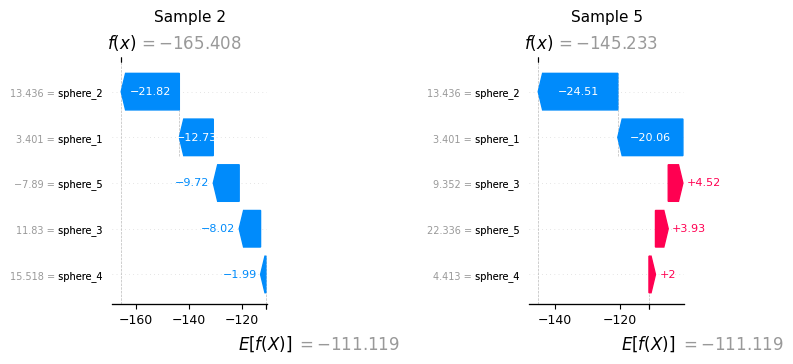

In [209]:
compare_shap_waterfall(sample_indices = [2, 5], shap_values = new_shap, max_display=5)

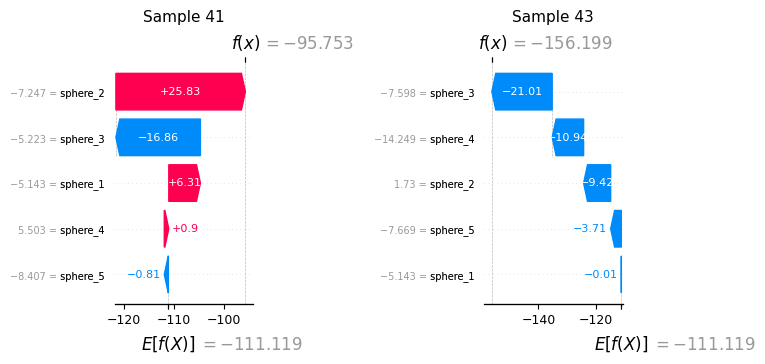

In [210]:
compare_shap_waterfall(sample_indices = [41, 43], shap_values = new_shap, max_display=5)

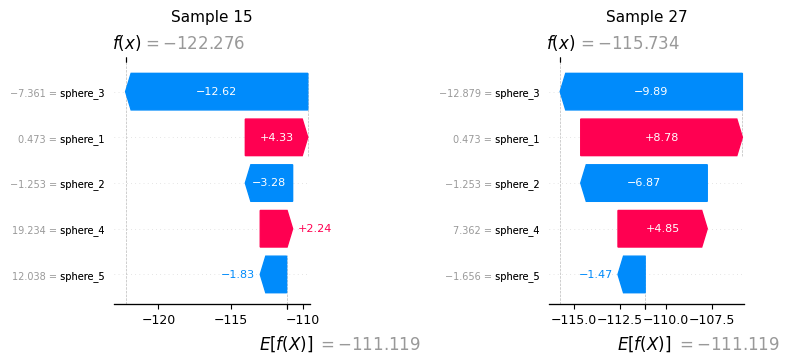

In [211]:
compare_shap_waterfall(sample_indices = [15, 27], shap_values = new_shap, max_display=5)

In [219]:
X_train_2d

0    1    2    3    5    6       7    8    9   10  \
4_COOH_1           12.011  3.0  0.0  4.0  4.0  0.0  12.011  2.0  0.0  3.0   
5_COOH_1           12.011  3.0  0.0  4.0  4.0  0.0  12.011  2.0  0.0  3.0   
7_COOH_1           12.011  3.0  0.0  4.0  4.0  0.0  12.011  3.0  0.0  4.0   
8_COOH_1           12.011  3.0  0.0  4.0  4.0  0.0  12.011  3.0  0.0  4.0   
9_COOH_1           12.011  3.0  0.0  4.0  4.0  0.0  12.011  3.0  0.0  4.0   
...                   ...  ...  ...  ...  ...  ...     ...  ...  ...  ...   
7_From_Review_484  12.011  2.0  1.0  3.0  4.0  1.0  12.011  2.0  1.0  3.0   
0_From_Review_485  12.011  2.0  1.0  3.0  4.0  1.0  14.007  2.0  1.0  2.0   
4_From_Review_485  12.011  2.0  1.0  3.0  4.0  1.0  14.007  2.0  1.0  2.0   
6_From_Review_485  12.011  2.0  1.0  3.0  4.0  1.0  12.011  2.0  1.0  3.0   
8_From_Review_485  12.011  2.0  1.0  3.0  4.0  1.0  12.011  2.0  1.0  3.0   

                    11   12   13      14   15   16   17   18   19   20  \
4_COOH_1           4.0  4.0  0.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   
5_COOH_1           4.0  4.0  0.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   
7_COOH_1           4.0  4.0  0.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   
8_COOH_1           4.0  4.0  0.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   
9_COOH_1           4.0  4.0  0.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   
...                ...  ...  ...     ...  ...  ...  ...  ...  ...  ...   
7_From_Review_484  4.0  4.0  1.0  14.007  2.0  1.0  2.0  3.0  3.0  1.0   
0_From_Review_485  3.0  3.0  1.0  14.007  2.0  1.0  2.0  3.0  3.0  1.0   
4_From_Review_485  3.0  3.0  1.0  12.011  2.0  1.0  3.0  4.0  4.0  1.0   
6_From_Review_485  4.0  4.0  1.0  12.011  2.0  1.0  3.0  4.0  4.0  1.0   
8_From_Review_485  4.0  4.0  1.0  14.007  2.0  1.0  2.0  3.0  3.0  1.0   

                       21   22   23   24   25   26   27      28   29   30  \
4_COOH_1           12.011  3.0  0.0  4.0  4.0  4.0  0.0  15.999  2.0  0.0   
5_COOH_1           12.011  3.0  0.0  4.0  4.0  4.0  0.0  15.999  2.0  0.0   
7_COOH_1           18.998  3.0  0.0  1.0  1.0  1.0  0.0  12.011  2.0  0.0   
8_COOH_1           18.998  3.0  0.0  1.0  1.0  1.0  0.0  12.011  2.0  0.0   
9_COOH_1           18.998  3.0  0.0  1.0  1.0  1.0  0.0  12.011  2.0  0.0   
...                   ...  ...  ...  ...  ...  ...  ...     ...  ...  ...   
7_From_Review_484     NaN  NaN  NaN  NaN  NaN  NaN  NaN  12.011  2.0  1.0   
0_From_Review_485     NaN  NaN  NaN  NaN  NaN  NaN  NaN  12.011  2.0  1.0   
4_From_Review_485     NaN  NaN  NaN  NaN  NaN  NaN  NaN  12.011  2.0  1.0   
6_From_Review_485     NaN  NaN  NaN  NaN  NaN  NaN  NaN  14.007  2.0  1.0   
8_From_Review_485     NaN  NaN  NaN  NaN  NaN  NaN  NaN  12.011  2.0  1.0   

                    31   32   33   34      35   36   37   38   39   40   41  \
4_COOH_1           1.0  2.0  2.0  0.0  15.999  2.0  0.0  1.0  2.0  1.0  0.0   
5_COOH_1           1.0  2.0  2.0  0.0  15.999  2.0  0.0  1.0  2.0  1.0  0.0   
7_COOH_1           3.0  4.0  4.0  0.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   
8_COOH_1           3.0  4.0  4.0  0.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   
9_COOH_1           3.0  4.0  4.0  0.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   
...                ...  ...  ...  ...     ...  ...  ...  ...  ...  ...  ...   
7_From_Review_484  2.0  4.0  3.0  1.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   
0_From_Review_485  3.0  4.0  4.0  1.0  12.011  2.0  1.0  3.0  4.0  4.0  1.0   
4_From_Review_485  3.0  4.0  4.0  1.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   
6_From_Review_485  2.0  3.0  3.0  1.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   
8_From_Review_485  3.0  4.0  4.0  1.0  18.998  3.0  0.0  1.0  1.0  1.0  0.0   

                       42   43   44   45   46   47   48      49   50  ...  \
4_COOH_1           18.998  3.0  0.0  1.0  1.0  1.0  0.0  18.998  3.0  ...   
5_COOH_1           18.998  3.0  0.0  1.0  1.0  1.0  0.0  18.998  3.0  ...   
7_COOH_1           18.998  3.0  0.0  1.0  1.0  1.0  0.0     NaN  NaN  ...   
8_COOH_1           18.998  3

In [225]:
# Analysis the whole training dataset
# Randomly choose 1000 row indices without replacement
# sample_indices = np.random.choice(X_train_scaled_2d.shape[0], size=10, replace=False)
# # Select the corresponding rows
# X_train_sampled = X_train_scaled_2d[sample_indices]

# X_train_nonscaled_sampled = X_train_2d.iloc[sample_indices, :]

explainer_train = shap.Explainer(best_FFNN_model.predict, X_train_scaled_2d)
shap_values_train = explainer(X_train_scaled_2d)
shap_values_train_df = pd.DataFrame(shap_values_train.values, columns = X_train_2d.columns, index=X_train_2d.index)

# Sum the SHAP values for each sphere in the training dataset
sphere_1_train_cols = [col for col in sphere_1_features if col in shap_values_train_df.columns]
sphere_2_train_cols = [col for col in sphere_2_features if col in shap_values_train_df.columns]
sphere_3_train_cols = [col for col in sphere_3_features if col in shap_values_train_df.columns]
sphere_4_train_cols = [col for col in sphere_4_features if col in shap_values_train_df.columns]
sphere_5_train_cols = [col for col in sphere_5_features if col in shap_values_train_df.columns]

# Sum the SHAP values for each sphere
sphere_1_train_sum_shap_values = shap_values_train_df[sphere_1_train_cols].sum(axis = 1)
sphere_2_train_sum_shap_values = shap_values_train_df[sphere_2_train_cols].sum(axis = 1)
sphere_3_train_sum_shap_values = shap_values_train_df[sphere_3_train_cols].sum(axis = 1)
sphere_4_train_sum_shap_values = shap_values_train_df[sphere_4_train_cols].sum(axis = 1)
sphere_5_train_sum_shap_values = shap_values_train_df[sphere_5_train_cols].sum(axis = 1)

# Create a DataFrame to hold the summed SHAP values for each sphere
shap_in_spheres_train = pd.DataFrame({
    "sphere_1": sphere_1_train_sum_shap_values,
    "sphere_2": sphere_2_train_sum_shap_values,
    "sphere_3": sphere_3_train_sum_shap_values,
    "sphere_4": sphere_4_train_sum_shap_values,
    "sphere_5": sphere_5_train_sum_shap_values,
}, index=shap_values_train_df.index)

# shap_values_data are input features for each row
shap_values_train_data = pd.DataFrame(shap_values_train.data, columns = X_train_2d.columns, index=X_train_2d.index)
sphere_1_train_shap_data = shap_values_train_data[sphere_1_train_cols].sum(axis = 1)
sphere_2_train_shap_data = shap_values_train_data[sphere_2_train_cols].sum(axis = 1)
sphere_3_train_shap_data = shap_values_train_data[sphere_3_train_cols].sum(axis = 1)
sphere_4_train_shap_data = shap_values_train_data[sphere_4_train_cols].sum(axis = 1)
sphere_5_train_shap_data = shap_values_train_data[sphere_5_train_cols].sum(axis = 1)

# Create a DataFrame to hold the summed SHAP data (input features) for each sphere
shap_in_spheres_train_data = pd.DataFrame({
    "sphere_1": sphere_1_train_shap_data,
    "sphere_2": sphere_2_train_shap_data,
    "sphere_3": sphere_3_train_shap_data,
    "sphere_4": sphere_4_train_shap_data,
    "sphere_5": sphere_5_train_shap_data,
}, index=shap_values_train_data.index)
new_shap_train = shap.Explanation(
    values=shap_in_spheres_train.values,                # your modified SHAP values
    base_values=shap_values_train.base_values,          # original model expected value(s)
    data=shap_in_spheres_train_data,                        # the input features for those rows
    feature_names=list(shap_in_spheres_train.columns)        # feature names
)

new_shap_train.shape

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
165/165 ━━━

PermutationExplainer explainer:   2%|▏         | 64/3500 [00:00<?, ?it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   2%|▏         | 66/3500 [00:10<04:03, 14.10it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:   2%|▏         | 68/3500 [00:10<07:26,  7.69it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:   2%|▏         | 69/3500 [00:10<07:33,  7.57it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


PermutationExplainer explainer:   2%|▏         | 70/3500 [00:10<07:41,  7.44it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer:   2%|▏         | 71/3500 [00:10<07:46,  7.35it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:   2%|▏         | 72/3500 [00:11<07:50,  7.28it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:   2%|▏         | 73/3500 [00:11<09:30,  6.00it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:   2%|▏         | 74/3500 [00:11<09:07,  6.26it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:   2%|▏         | 75/3500 [00:11<08:46,  6.50it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:   2%|▏         | 76/3500 [00:11<08:35,  6.64it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step


PermutationExplainer explainer:   2%|▏         | 77/3500 [00:11<08:30,  6.71it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


PermutationExplainer explainer:   2%|▏         | 78/3500 [00:12<09:44,  5.86it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


PermutationExplainer explainer:   2%|▏         | 79/3500 [00:12<09:32,  5.98it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:   2%|▏         | 80/3500 [00:12<09:23,  6.07it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:   2%|▏         | 81/3500 [00:12<09:04,  6.28it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:   2%|▏         | 82/3500 [00:12<08:49,  6.45it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:   2%|▏         | 83/3500 [00:12<09:40,  5.88it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   2%|▏         | 84/3500 [00:13<09:09,  6.21it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   2%|▏         | 85/3500 [00:13<08:34,  6.64it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   2%|▏         | 86/3500 [00:13<08:14,  6.90it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


PermutationExplainer explainer:   2%|▏         | 87/3500 [00:13<08:02,  7.07it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:   3%|▎         | 88/3500 [00:13<07:55,  7.18it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   3%|▎         | 89/3500 [00:13<07:47,  7.30it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:   3%|▎         | 90/3500 [00:13<08:41,  6.53it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   3%|▎         | 91/3500 [00:14<08:15,  6.88it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:   3%|▎         | 92/3500 [00:14<07:58,  7.12it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   3%|▎         | 93/3500 [00:14<07:45,  7.32it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   3%|▎         | 94/3500 [00:14<07:34,  7.49it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   3%|▎         | 95/3500 [00:14<07:34,  7.50it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   3%|▎         | 96/3500 [00:14<07:31,  7.54it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:   3%|▎         | 97/3500 [00:14<08:43,  6.50it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   3%|▎         | 98/3500 [00:15<08:28,  6.69it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:   3%|▎         | 99/3500 [00:15<08:08,  6.96it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:   3%|▎         | 100/3500 [00:15<07:53,  7.18it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   3%|▎         | 101/3500 [00:15<07:42,  7.35it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   3%|▎         | 102/3500 [00:15<07:51,  7.21it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   3%|▎         | 103/3500 [00:15<07:59,  7.08it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   3%|▎         | 104/3500 [00:15<08:00,  7.07it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:   3%|▎         | 105/3500 [00:16<08:58,  6.30it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   3%|▎         | 106/3500 [00:16<08:33,  6.61it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   3%|▎         | 107/3500 [00:16<08:17,  6.81it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:   3%|▎         | 108/3500 [00:16<08:01,  7.04it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:   3%|▎         | 109/3500 [00:16<07:47,  7.25it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:   3%|▎         | 110/3500 [00:16<07:41,  7.35it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:   3%|▎         | 111/3500 [00:16<07:38,  7.39it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   3%|▎         | 112/3500 [00:17<08:27,  6.68it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   3%|▎         | 113/3500 [00:17<08:03,  7.00it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:   3%|▎         | 114/3500 [00:17<07:51,  7.18it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:   3%|▎         | 115/3500 [00:17<07:43,  7.30it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   3%|▎         | 116/3500 [00:17<07:37,  7.39it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   3%|▎         | 117/3500 [00:17<07:30,  7.52it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   3%|▎         | 118/3500 [00:17<07:29,  7.53it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:   3%|▎         | 119/3500 [00:17<07:29,  7.52it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:   3%|▎         | 120/3500 [00:18<08:29,  6.64it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:   3%|▎         | 121/3500 [00:18<08:08,  6.92it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   3%|▎         | 122/3500 [00:18<08:00,  7.03it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:   4%|▎         | 123/3500 [00:18<07:54,  7.11it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:   4%|▎         | 124/3500 [00:18<07:57,  7.07it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:   4%|▎         | 125/3500 [00:18<07:52,  7.14it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:   4%|▎         | 126/3500 [00:18<07:43,  7.29it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   4%|▎         | 127/3500 [00:19<07:33,  7.44it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:   4%|▎         | 128/3500 [00:19<08:38,  6.50it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:   4%|▎         | 129/3500 [00:19<08:28,  6.63it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   4%|▎         | 130/3500 [00:19<08:23,  6.69it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   4%|▎         | 131/3500 [00:19<08:17,  6.77it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   4%|▍         | 132/3500 [00:19<08:13,  6.82it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:   4%|▍         | 133/3500 [00:19<08:11,  6.86it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:   4%|▍         | 134/3500 [00:20<08:11,  6.85it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


PermutationExplainer explainer:   4%|▍         | 135/3500 [00:20<09:01,  6.21it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:   4%|▍         | 136/3500 [00:20<08:43,  6.42it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   4%|▍         | 137/3500 [00:20<08:30,  6.59it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   4%|▍         | 138/3500 [00:20<08:18,  6.74it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   4%|▍         | 139/3500 [00:20<08:09,  6.87it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   4%|▍         | 140/3500 [00:21<08:01,  6.98it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:   4%|▍         | 141/3500 [00:21<07:58,  7.02it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   4%|▍         | 142/3500 [00:21<07:55,  7.06it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:   4%|▍         | 143/3500 [00:21<08:42,  6.42it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   4%|▍         | 144/3500 [00:21<08:22,  6.68it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   4%|▍         | 145/3500 [00:21<08:13,  6.80it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:   4%|▍         | 146/3500 [00:21<08:07,  6.88it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   4%|▍         | 147/3500 [00:22<08:07,  6.88it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   4%|▍         | 148/3500 [00:22<08:03,  6.93it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   4%|▍         | 149/3500 [00:22<08:00,  6.97it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   4%|▍         | 150/3500 [00:22<08:58,  6.22it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   4%|▍         | 151/3500 [00:22<08:35,  6.49it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   4%|▍         | 152/3500 [00:22<08:21,  6.68it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:   4%|▍         | 153/3500 [00:22<08:08,  6.85it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   4%|▍         | 154/3500 [00:23<07:59,  6.98it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:   4%|▍         | 155/3500 [00:23<07:51,  7.10it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   4%|▍         | 156/3500 [00:23<07:41,  7.24it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   4%|▍         | 157/3500 [00:23<07:39,  7.27it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:   5%|▍         | 158/3500 [00:23<08:41,  6.40it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   5%|▍         | 159/3500 [00:23<08:29,  6.56it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   5%|▍         | 160/3500 [00:23<08:20,  6.67it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:   5%|▍         | 161/3500 [00:24<08:12,  6.77it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   5%|▍         | 162/3500 [00:24<08:07,  6.85it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   5%|▍         | 163/3500 [00:24<08:00,  6.94it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:   5%|▍         | 164/3500 [00:24<07:59,  6.96it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   5%|▍         | 165/3500 [00:24<08:52,  6.26it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   5%|▍         | 166/3500 [00:24<08:28,  6.55it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   5%|▍         | 167/3500 [00:25<08:12,  6.77it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:   5%|▍         | 168/3500 [00:25<08:00,  6.94it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:   5%|▍         | 169/3500 [00:25<07:52,  7.05it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   5%|▍         | 170/3500 [00:25<07:43,  7.18it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:   5%|▍         | 171/3500 [00:25<07:36,  7.30it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   5%|▍         | 172/3500 [00:25<08:44,  6.34it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   5%|▍         | 173/3500 [00:25<08:30,  6.52it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:   5%|▍         | 174/3500 [00:26<08:11,  6.76it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   5%|▌         | 175/3500 [00:26<08:02,  6.89it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   5%|▌         | 176/3500 [00:26<07:49,  7.08it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:   5%|▌         | 177/3500 [00:26<07:38,  7.24it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   5%|▌         | 178/3500 [00:26<07:32,  7.34it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   5%|▌         | 179/3500 [00:26<08:25,  6.57it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   5%|▌         | 180/3500 [00:26<08:05,  6.84it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   5%|▌         | 181/3500 [00:27<07:51,  7.04it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   5%|▌         | 182/3500 [00:27<07:40,  7.20it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   5%|▌         | 183/3500 [00:27<07:31,  7.34it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   5%|▌         | 184/3500 [00:27<07:23,  7.47it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   5%|▌         | 185/3500 [00:27<07:26,  7.42it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:   5%|▌         | 186/3500 [00:27<07:27,  7.40it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   5%|▌         | 187/3500 [00:27<08:23,  6.58it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   5%|▌         | 188/3500 [00:28<08:07,  6.79it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   5%|▌         | 189/3500 [00:28<07:54,  6.98it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   5%|▌         | 190/3500 [00:28<07:44,  7.13it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:   5%|▌         | 191/3500 [00:28<07:34,  7.29it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:   5%|▌         | 192/3500 [00:28<07:24,  7.45it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   6%|▌         | 193/3500 [00:28<07:17,  7.57it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   6%|▌         | 194/3500 [00:28<08:03,  6.84it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   6%|▌         | 195/3500 [00:28<07:51,  7.01it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   6%|▌         | 196/3500 [00:29<07:41,  7.16it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   6%|▌         | 197/3500 [00:29<07:34,  7.27it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   6%|▌         | 198/3500 [00:29<07:26,  7.40it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   6%|▌         | 199/3500 [00:29<07:18,  7.53it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   6%|▌         | 200/3500 [00:29<07:14,  7.59it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   6%|▌         | 201/3500 [00:29<07:12,  7.63it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   6%|▌         | 202/3500 [00:29<08:20,  6.59it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   6%|▌         | 203/3500 [00:30<08:04,  6.80it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   6%|▌         | 204/3500 [00:30<07:52,  6.97it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   6%|▌         | 205/3500 [00:30<07:44,  7.10it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   6%|▌         | 206/3500 [00:30<07:38,  7.18it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   6%|▌         | 207/3500 [00:30<07:31,  7.29it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   6%|▌         | 208/3500 [00:30<07:26,  7.37it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   6%|▌         | 209/3500 [00:30<08:14,  6.65it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   6%|▌         | 210/3500 [00:31<08:09,  6.72it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   6%|▌         | 211/3500 [00:31<07:57,  6.89it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   6%|▌         | 212/3500 [00:31<07:51,  6.97it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   6%|▌         | 213/3500 [00:31<07:38,  7.18it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:   6%|▌         | 214/3500 [00:31<07:31,  7.28it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   6%|▌         | 215/3500 [00:31<07:27,  7.34it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   6%|▌         | 216/3500 [00:31<07:25,  7.38it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   6%|▌         | 217/3500 [00:32<08:18,  6.59it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   6%|▌         | 218/3500 [00:32<08:01,  6.82it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   6%|▋         | 219/3500 [00:32<07:45,  7.04it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   6%|▋         | 220/3500 [00:32<07:33,  7.24it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   6%|▋         | 221/3500 [00:32<07:23,  7.39it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:   6%|▋         | 222/3500 [00:32<07:31,  7.27it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   6%|▋         | 223/3500 [00:32<07:31,  7.26it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   6%|▋         | 224/3500 [00:33<08:17,  6.59it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   6%|▋         | 225/3500 [00:33<08:09,  6.69it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   6%|▋         | 226/3500 [00:33<07:52,  6.94it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   6%|▋         | 227/3500 [00:33<07:36,  7.17it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   7%|▋         | 228/3500 [00:33<07:26,  7.32it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   7%|▋         | 229/3500 [00:33<07:15,  7.52it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:   7%|▋         | 230/3500 [00:33<07:12,  7.55it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   7%|▋         | 231/3500 [00:34<07:13,  7.54it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   7%|▋         | 232/3500 [00:34<08:13,  6.62it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   7%|▋         | 233/3500 [00:34<07:54,  6.88it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:   7%|▋         | 234/3500 [00:34<07:41,  7.07it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   7%|▋         | 235/3500 [00:34<07:28,  7.28it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   7%|▋         | 236/3500 [00:34<07:21,  7.39it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   7%|▋         | 237/3500 [00:34<07:22,  7.37it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:   7%|▋         | 238/3500 [00:35<07:30,  7.24it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   7%|▋         | 239/3500 [00:35<07:29,  7.25it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   7%|▋         | 240/3500 [00:35<08:24,  6.46it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   7%|▋         | 241/3500 [00:35<08:01,  6.78it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   7%|▋         | 242/3500 [00:35<07:47,  6.97it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   7%|▋         | 243/3500 [00:35<07:33,  7.18it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   7%|▋         | 244/3500 [00:35<07:24,  7.32it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   7%|▋         | 245/3500 [00:35<07:18,  7.43it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:   7%|▋         | 246/3500 [00:36<07:12,  7.52it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:   7%|▋         | 247/3500 [00:36<08:06,  6.68it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   7%|▋         | 248/3500 [00:36<07:49,  6.93it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   7%|▋         | 249/3500 [00:36<07:33,  7.18it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:   7%|▋         | 250/3500 [00:36<07:22,  7.34it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:   7%|▋         | 251/3500 [00:36<07:19,  7.39it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   7%|▋         | 252/3500 [00:36<07:17,  7.42it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:   7%|▋         | 253/3500 [00:37<07:15,  7.45it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   7%|▋         | 254/3500 [00:37<07:17,  7.42it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   7%|▋         | 255/3500 [00:37<08:05,  6.69it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:   7%|▋         | 256/3500 [00:37<07:45,  6.97it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   7%|▋         | 257/3500 [00:37<07:29,  7.21it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:   7%|▋         | 258/3500 [00:37<07:32,  7.16it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:   7%|▋         | 259/3500 [00:37<07:32,  7.15it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   7%|▋         | 260/3500 [00:38<07:28,  7.22it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   7%|▋         | 261/3500 [00:38<07:26,  7.26it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:   7%|▋         | 262/3500 [00:38<08:27,  6.38it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   8%|▊         | 263/3500 [00:38<08:06,  6.66it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   8%|▊         | 264/3500 [00:38<07:51,  6.86it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   8%|▊         | 265/3500 [00:38<07:40,  7.02it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   8%|▊         | 266/3500 [00:38<07:35,  7.10it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   8%|▊         | 267/3500 [00:39<07:30,  7.17it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   8%|▊         | 268/3500 [00:39<07:28,  7.21it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   8%|▊         | 269/3500 [00:39<07:25,  7.25it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   8%|▊         | 270/3500 [00:39<08:21,  6.43it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:   8%|▊         | 271/3500 [00:39<08:09,  6.59it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   8%|▊         | 272/3500 [00:39<07:53,  6.81it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   8%|▊         | 273/3500 [00:39<07:42,  6.98it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:   8%|▊         | 274/3500 [00:40<07:35,  7.08it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   8%|▊         | 275/3500 [00:40<07:27,  7.21it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   8%|▊         | 276/3500 [00:40<07:17,  7.37it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:   8%|▊         | 277/3500 [00:40<08:06,  6.63it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   8%|▊         | 278/3500 [00:40<07:51,  6.83it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:   8%|▊         | 279/3500 [00:40<07:40,  6.99it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   8%|▊         | 280/3500 [00:40<07:33,  7.10it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   8%|▊         | 281/3500 [00:41<07:28,  7.17it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   8%|▊         | 282/3500 [00:41<07:24,  7.24it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   8%|▊         | 283/3500 [00:41<07:22,  7.27it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:   8%|▊         | 284/3500 [00:41<08:22,  6.40it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:   8%|▊         | 285/3500 [00:41<08:09,  6.57it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   8%|▊         | 286/3500 [00:41<07:50,  6.83it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   8%|▊         | 287/3500 [00:42<07:39,  6.99it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:   8%|▊         | 288/3500 [00:42<07:31,  7.11it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   8%|▊         | 289/3500 [00:42<07:23,  7.24it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   8%|▊         | 290/3500 [00:42<07:16,  7.36it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:   8%|▊         | 291/3500 [00:42<08:04,  6.62it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   8%|▊         | 292/3500 [00:42<07:46,  6.88it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:   8%|▊         | 293/3500 [00:42<07:31,  7.11it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   8%|▊         | 294/3500 [00:42<07:24,  7.21it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:   8%|▊         | 295/3500 [00:43<07:20,  7.28it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   8%|▊         | 296/3500 [00:43<07:22,  7.24it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   8%|▊         | 297/3500 [00:43<07:21,  7.25it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   9%|▊         | 298/3500 [00:43<08:10,  6.53it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   9%|▊         | 299/3500 [00:43<07:56,  6.72it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   9%|▊         | 300/3500 [00:43<07:44,  6.89it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   9%|▊         | 301/3500 [00:44<07:37,  6.99it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   9%|▊         | 302/3500 [00:44<07:37,  6.98it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:   9%|▊         | 303/3500 [00:44<07:32,  7.07it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   9%|▊         | 304/3500 [00:44<07:28,  7.12it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   9%|▊         | 305/3500 [00:44<08:19,  6.39it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   9%|▊         | 306/3500 [00:44<07:57,  6.69it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   9%|▉         | 307/3500 [00:44<07:40,  6.93it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   9%|▉         | 308/3500 [00:45<07:31,  7.07it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:   9%|▉         | 309/3500 [00:45<07:32,  7.04it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:   9%|▉         | 310/3500 [00:45<07:31,  7.07it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   9%|▉         | 311/3500 [00:45<07:30,  7.08it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   9%|▉         | 312/3500 [00:45<08:23,  6.33it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:   9%|▉         | 313/3500 [00:45<07:58,  6.66it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   9%|▉         | 314/3500 [00:45<07:41,  6.91it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:   9%|▉         | 315/3500 [00:46<07:31,  7.05it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   9%|▉         | 316/3500 [00:46<07:24,  7.16it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:   9%|▉         | 317/3500 [00:46<07:21,  7.20it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:   9%|▉         | 318/3500 [00:46<07:16,  7.29it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   9%|▉         | 319/3500 [00:46<08:04,  6.57it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:   9%|▉         | 320/3500 [00:46<07:44,  6.84it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer:   9%|▉         | 321/3500 [00:46<07:30,  7.06it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:   9%|▉         | 322/3500 [00:47<07:29,  7.07it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:   9%|▉         | 323/3500 [00:47<07:28,  7.09it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:   9%|▉         | 324/3500 [00:47<07:25,  7.13it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:   9%|▉         | 325/3500 [00:47<07:26,  7.11it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   9%|▉         | 326/3500 [00:47<08:14,  6.41it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:   9%|▉         | 327/3500 [00:47<07:54,  6.69it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:   9%|▉         | 328/3500 [00:47<07:34,  6.98it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   9%|▉         | 329/3500 [00:48<07:22,  7.16it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:   9%|▉         | 330/3500 [00:48<07:12,  7.33it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:   9%|▉         | 331/3500 [00:48<07:03,  7.48it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:   9%|▉         | 332/3500 [00:48<07:03,  7.48it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  10%|▉         | 333/3500 [00:48<07:03,  7.49it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  10%|▉         | 334/3500 [00:48<07:56,  6.65it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  10%|▉         | 335/3500 [00:48<07:38,  6.90it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  10%|▉         | 336/3500 [00:49<07:21,  7.16it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  10%|▉         | 337/3500 [00:49<07:12,  7.31it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  10%|▉         | 338/3500 [00:49<07:06,  7.41it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  10%|▉         | 339/3500 [00:49<07:12,  7.31it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  10%|▉         | 340/3500 [00:49<07:45,  6.79it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  10%|▉         | 341/3500 [00:49<08:31,  6.18it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  10%|▉         | 342/3500 [00:49<08:11,  6.43it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  10%|▉         | 343/3500 [00:50<07:49,  6.72it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  10%|▉         | 344/3500 [00:50<07:36,  6.91it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  10%|▉         | 345/3500 [00:50<07:22,  7.13it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  10%|▉         | 346/3500 [00:50<07:08,  7.36it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  10%|▉         | 347/3500 [00:50<07:01,  7.48it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  10%|▉         | 348/3500 [00:50<07:53,  6.66it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  10%|▉         | 349/3500 [00:50<07:32,  6.97it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  10%|█         | 350/3500 [00:51<07:18,  7.18it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  10%|█         | 351/3500 [00:51<07:10,  7.31it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  10%|█         | 352/3500 [00:51<07:02,  7.45it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  10%|█         | 353/3500 [00:51<07:00,  7.49it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  10%|█         | 354/3500 [00:51<06:59,  7.49it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  10%|█         | 355/3500 [00:51<07:55,  6.61it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  10%|█         | 356/3500 [00:51<07:40,  6.82it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  10%|█         | 357/3500 [00:51<07:25,  7.06it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  10%|█         | 358/3500 [00:52<07:13,  7.24it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  10%|█         | 359/3500 [00:52<07:06,  7.37it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  10%|█         | 360/3500 [00:52<07:06,  7.36it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  10%|█         | 361/3500 [00:52<07:09,  7.31it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step


PermutationExplainer explainer:  10%|█         | 362/3500 [00:52<08:31,  6.14it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  10%|█         | 363/3500 [00:52<08:14,  6.34it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  10%|█         | 364/3500 [00:53<07:55,  6.59it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  10%|█         | 365/3500 [00:53<07:40,  6.80it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  10%|█         | 366/3500 [00:53<07:31,  6.94it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  10%|█         | 367/3500 [00:53<07:20,  7.10it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  11%|█         | 368/3500 [00:53<07:17,  7.16it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  11%|█         | 369/3500 [00:53<08:23,  6.21it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  11%|█         | 370/3500 [00:53<08:11,  6.37it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  11%|█         | 371/3500 [00:54<07:55,  6.58it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  11%|█         | 372/3500 [00:54<07:44,  6.73it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  11%|█         | 373/3500 [00:54<07:29,  6.96it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  11%|█         | 374/3500 [00:54<07:21,  7.08it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  11%|█         | 375/3500 [00:54<07:12,  7.23it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  11%|█         | 376/3500 [00:54<07:59,  6.51it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  11%|█         | 377/3500 [00:54<07:38,  6.82it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  11%|█         | 378/3500 [00:55<07:21,  7.08it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  11%|█         | 379/3500 [00:55<07:12,  7.21it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  11%|█         | 380/3500 [00:55<07:08,  7.28it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  11%|█         | 381/3500 [00:55<07:06,  7.31it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  11%|█         | 382/3500 [00:55<07:03,  7.37it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  11%|█         | 383/3500 [00:55<07:51,  6.62it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  11%|█         | 384/3500 [00:55<07:31,  6.90it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  11%|█         | 385/3500 [00:56<07:16,  7.14it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  11%|█         | 386/3500 [00:56<07:22,  7.05it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  11%|█         | 387/3500 [00:56<07:23,  7.02it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  11%|█         | 388/3500 [00:56<07:25,  6.99it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  11%|█         | 389/3500 [00:56<07:26,  6.96it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  11%|█         | 390/3500 [00:56<08:17,  6.26it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  11%|█         | 391/3500 [00:56<08:00,  6.48it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  11%|█         | 392/3500 [00:57<07:38,  6.78it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  11%|█         | 393/3500 [00:57<07:23,  7.01it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  11%|█▏        | 394/3500 [00:57<07:10,  7.21it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  11%|█▏        | 395/3500 [00:57<07:03,  7.34it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  11%|█▏        | 396/3500 [00:57<06:58,  7.42it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  11%|█▏        | 397/3500 [00:57<07:51,  6.58it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  11%|█▏        | 398/3500 [00:57<07:34,  6.82it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  11%|█▏        | 399/3500 [00:58<07:22,  7.01it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  11%|█▏        | 400/3500 [00:58<07:11,  7.18it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  11%|█▏        | 401/3500 [00:58<06:59,  7.39it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  11%|█▏        | 402/3500 [00:58<06:52,  7.50it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  12%|█▏        | 403/3500 [00:58<06:59,  7.39it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  12%|█▏        | 404/3500 [00:58<07:59,  6.46it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  12%|█▏        | 405/3500 [00:58<07:45,  6.64it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  12%|█▏        | 406/3500 [00:59<07:36,  6.78it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  12%|█▏        | 407/3500 [00:59<07:20,  7.01it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  12%|█▏        | 408/3500 [00:59<07:13,  7.14it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  12%|█▏        | 409/3500 [00:59<07:08,  7.22it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  12%|█▏        | 410/3500 [00:59<07:06,  7.25it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  12%|█▏        | 411/3500 [00:59<07:55,  6.49it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  12%|█▏        | 412/3500 [00:59<07:37,  6.75it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  12%|█▏        | 413/3500 [01:00<07:23,  6.96it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


PermutationExplainer explainer:  12%|█▏        | 414/3500 [01:00<07:19,  7.01it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer:  12%|█▏        | 415/3500 [01:00<07:26,  6.92it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  12%|█▏        | 416/3500 [01:00<07:38,  6.72it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  12%|█▏        | 417/3500 [01:00<07:30,  6.84it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  12%|█▏        | 418/3500 [01:00<08:37,  5.96it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  12%|█▏        | 419/3500 [01:01<08:15,  6.22it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  12%|█▏        | 420/3500 [01:01<07:58,  6.44it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  12%|█▏        | 421/3500 [01:01<07:47,  6.58it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  12%|█▏        | 422/3500 [01:01<07:39,  6.70it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  12%|█▏        | 423/3500 [01:01<07:40,  6.68it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  12%|█▏        | 424/3500 [01:01<07:48,  6.57it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  12%|█▏        | 425/3500 [01:01<08:43,  5.88it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  12%|█▏        | 426/3500 [01:02<08:17,  6.18it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


PermutationExplainer explainer:  12%|█▏        | 427/3500 [01:02<08:01,  6.38it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  12%|█▏        | 428/3500 [01:02<07:50,  6.52it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


PermutationExplainer explainer:  12%|█▏        | 429/3500 [01:02<07:38,  6.70it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  12%|█▏        | 430/3500 [01:02<07:36,  6.73it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  12%|█▏        | 431/3500 [01:02<07:34,  6.76it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  12%|█▏        | 432/3500 [01:03<08:34,  5.97it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  12%|█▏        | 433/3500 [01:03<08:11,  6.23it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  12%|█▏        | 434/3500 [01:03<08:00,  6.38it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  12%|█▏        | 435/3500 [01:03<07:49,  6.52it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  12%|█▏        | 436/3500 [01:03<07:44,  6.60it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  12%|█▏        | 437/3500 [01:03<07:31,  6.79it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  13%|█▎        | 438/3500 [01:03<07:35,  6.73it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  13%|█▎        | 439/3500 [01:04<08:14,  6.19it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  13%|█▎        | 440/3500 [01:04<07:50,  6.50it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  13%|█▎        | 441/3500 [01:04<07:33,  6.74it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  13%|█▎        | 442/3500 [01:04<07:16,  7.01it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  13%|█▎        | 443/3500 [01:04<07:04,  7.20it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  13%|█▎        | 444/3500 [01:04<06:58,  7.30it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  13%|█▎        | 445/3500 [01:04<07:46,  6.55it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  13%|█▎        | 446/3500 [01:05<07:33,  6.74it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  13%|█▎        | 447/3500 [01:05<07:22,  6.90it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  13%|█▎        | 448/3500 [01:05<07:17,  6.98it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  13%|█▎        | 449/3500 [01:05<07:10,  7.09it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  13%|█▎        | 450/3500 [01:05<07:05,  7.18it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  13%|█▎        | 451/3500 [01:05<07:46,  6.53it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  13%|█▎        | 452/3500 [01:05<07:28,  6.79it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  13%|█▎        | 453/3500 [01:06<07:12,  7.04it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  13%|█▎        | 454/3500 [01:06<07:01,  7.23it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  13%|█▎        | 455/3500 [01:06<06:59,  7.26it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  13%|█▎        | 456/3500 [01:06<06:54,  7.34it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  13%|█▎        | 457/3500 [01:06<07:46,  6.52it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  13%|█▎        | 458/3500 [01:06<07:31,  6.74it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  13%|█▎        | 459/3500 [01:06<07:14,  6.99it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  13%|█▎        | 460/3500 [01:07<07:05,  7.15it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  13%|█▎        | 461/3500 [01:07<06:55,  7.31it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  13%|█▎        | 462/3500 [01:07<06:58,  7.27it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  13%|█▎        | 463/3500 [01:07<07:47,  6.50it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  13%|█▎        | 464/3500 [01:07<07:36,  6.66it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  13%|█▎        | 465/3500 [01:07<07:24,  6.82it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  13%|█▎        | 466/3500 [01:07<07:12,  7.02it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  13%|█▎        | 467/3500 [01:08<07:06,  7.11it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  13%|█▎        | 468/3500 [01:08<07:48,  6.47it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  13%|█▎        | 469/3500 [01:08<07:25,  6.81it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  13%|█▎        | 470/3500 [01:08<07:10,  7.03it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  13%|█▎        | 471/3500 [01:08<07:00,  7.20it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  13%|█▎        | 472/3500 [01:08<06:52,  7.34it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  14%|█▎        | 473/3500 [01:08<06:45,  7.46it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  14%|█▎        | 474/3500 [01:09<07:33,  6.67it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  14%|█▎        | 475/3500 [01:09<07:13,  6.98it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  14%|█▎        | 476/3500 [01:09<07:04,  7.12it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  14%|█▎        | 477/3500 [01:09<06:59,  7.20it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  14%|█▎        | 478/3500 [01:09<06:55,  7.27it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  14%|█▎        | 479/3500 [01:09<06:51,  7.34it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  14%|█▎        | 480/3500 [01:10<07:39,  6.57it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  14%|█▎        | 481/3500 [01:10<07:22,  6.83it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  14%|█▍        | 482/3500 [01:10<07:10,  7.02it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  14%|█▍        | 483/3500 [01:10<07:03,  7.13it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  14%|█▍        | 484/3500 [01:10<06:59,  7.19it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  14%|█▍        | 485/3500 [01:10<07:00,  7.18it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  14%|█▍        | 486/3500 [01:10<07:49,  6.42it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  14%|█▍        | 487/3500 [01:11<07:33,  6.64it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  14%|█▍        | 488/3500 [01:11<07:26,  6.75it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  14%|█▍        | 489/3500 [01:11<07:19,  6.85it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  14%|█▍        | 490/3500 [01:11<07:10,  6.98it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


PermutationExplainer explainer:  14%|█▍        | 491/3500 [01:11<07:52,  6.36it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  14%|█▍        | 492/3500 [01:11<07:33,  6.63it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  14%|█▍        | 493/3500 [01:11<07:17,  6.88it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  14%|█▍        | 494/3500 [01:12<07:05,  7.06it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  14%|█▍        | 495/3500 [01:12<07:04,  7.09it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  14%|█▍        | 496/3500 [01:12<06:57,  7.19it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  14%|█▍        | 497/3500 [01:12<06:56,  7.22it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  14%|█▍        | 498/3500 [01:12<07:42,  6.49it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  14%|█▍        | 499/3500 [01:12<07:32,  6.63it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  14%|█▍        | 500/3500 [01:12<07:17,  6.86it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  14%|█▍        | 501/3500 [01:13<07:03,  7.08it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  14%|█▍        | 502/3500 [01:13<06:56,  7.21it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  14%|█▍        | 503/3500 [01:13<06:59,  7.15it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  14%|█▍        | 504/3500 [01:13<07:48,  6.40it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  14%|█▍        | 505/3500 [01:13<07:28,  6.67it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  14%|█▍        | 506/3500 [01:13<07:17,  6.84it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  14%|█▍        | 507/3500 [01:13<07:08,  6.99it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  15%|█▍        | 508/3500 [01:14<06:58,  7.14it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  15%|█▍        | 509/3500 [01:14<06:51,  7.27it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  15%|█▍        | 510/3500 [01:14<06:46,  7.36it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  15%|█▍        | 511/3500 [01:14<07:33,  6.60it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  15%|█▍        | 512/3500 [01:14<07:17,  6.82it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  15%|█▍        | 513/3500 [01:14<07:01,  7.09it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  15%|█▍        | 514/3500 [01:14<06:51,  7.26it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  15%|█▍        | 515/3500 [01:15<06:48,  7.32it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  15%|█▍        | 516/3500 [01:15<07:34,  6.57it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  15%|█▍        | 517/3500 [01:15<07:17,  6.82it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  15%|█▍        | 518/3500 [01:15<07:09,  6.95it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  15%|█▍        | 519/3500 [01:15<06:58,  7.12it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  15%|█▍        | 520/3500 [01:15<06:48,  7.30it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  15%|█▍        | 521/3500 [01:15<06:43,  7.39it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  15%|█▍        | 522/3500 [01:16<07:39,  6.48it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  15%|█▍        | 523/3500 [01:16<07:25,  6.68it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  15%|█▍        | 524/3500 [01:16<07:18,  6.79it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  15%|█▌        | 525/3500 [01:16<07:12,  6.88it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  15%|█▌        | 526/3500 [01:16<07:03,  7.03it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  15%|█▌        | 527/3500 [01:16<07:48,  6.34it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  15%|█▌        | 528/3500 [01:16<07:30,  6.60it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  15%|█▌        | 529/3500 [01:17<07:19,  6.76it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  15%|█▌        | 530/3500 [01:17<07:32,  6.56it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  15%|█▌        | 531/3500 [01:17<07:42,  6.41it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  15%|█▌        | 532/3500 [01:17<07:47,  6.35it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  15%|█▌        | 533/3500 [01:17<08:41,  5.69it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  15%|█▌        | 534/3500 [01:17<08:27,  5.85it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  15%|█▌        | 535/3500 [01:18<08:21,  5.91it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  15%|█▌        | 536/3500 [01:18<07:55,  6.24it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  15%|█▌        | 537/3500 [01:18<07:35,  6.50it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  15%|█▌        | 538/3500 [01:18<08:12,  6.01it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  15%|█▌        | 539/3500 [01:18<07:47,  6.34it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  15%|█▌        | 540/3500 [01:18<07:27,  6.62it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  15%|█▌        | 541/3500 [01:19<07:11,  6.86it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  15%|█▌        | 542/3500 [01:19<07:01,  7.02it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  16%|█▌        | 543/3500 [01:19<07:36,  6.48it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  16%|█▌        | 544/3500 [01:19<07:21,  6.69it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  16%|█▌        | 545/3500 [01:19<07:10,  6.86it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  16%|█▌        | 546/3500 [01:19<07:05,  6.95it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  16%|█▌        | 547/3500 [01:19<06:54,  7.12it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  16%|█▌        | 548/3500 [01:20<06:50,  7.19it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  16%|█▌        | 549/3500 [01:20<06:50,  7.18it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  16%|█▌        | 550/3500 [01:20<07:35,  6.47it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  16%|█▌        | 551/3500 [01:20<07:15,  6.77it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  16%|█▌        | 552/3500 [01:20<06:59,  7.02it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


PermutationExplainer explainer:  16%|█▌        | 553/3500 [01:20<06:51,  7.17it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  16%|█▌        | 554/3500 [01:20<06:43,  7.30it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  16%|█▌        | 555/3500 [01:21<06:40,  7.35it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  16%|█▌        | 556/3500 [01:21<07:26,  6.59it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  16%|█▌        | 557/3500 [01:21<07:11,  6.81it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  16%|█▌        | 558/3500 [01:21<07:00,  6.99it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  16%|█▌        | 559/3500 [01:21<06:52,  7.13it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  16%|█▌        | 560/3500 [01:21<06:45,  7.25it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  16%|█▌        | 561/3500 [01:21<07:29,  6.54it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  16%|█▌        | 562/3500 [01:22<07:19,  6.69it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  16%|█▌        | 563/3500 [01:22<07:13,  6.78it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  16%|█▌        | 564/3500 [01:22<07:01,  6.97it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  16%|█▌        | 565/3500 [01:22<06:54,  7.08it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  16%|█▌        | 566/3500 [01:22<06:50,  7.15it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  16%|█▌        | 567/3500 [01:22<07:36,  6.43it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  16%|█▌        | 568/3500 [01:22<07:18,  6.69it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  16%|█▋        | 569/3500 [01:23<07:01,  6.95it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  16%|█▋        | 570/3500 [01:23<06:49,  7.15it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  16%|█▋        | 571/3500 [01:23<06:41,  7.30it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  16%|█▋        | 572/3500 [01:23<07:27,  6.54it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  16%|█▋        | 573/3500 [01:23<07:09,  6.81it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  16%|█▋        | 574/3500 [01:23<06:53,  7.08it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  16%|█▋        | 575/3500 [01:23<06:45,  7.22it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  16%|█▋        | 576/3500 [01:24<06:39,  7.32it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  16%|█▋        | 577/3500 [01:24<07:26,  6.55it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  17%|█▋        | 578/3500 [01:24<07:11,  6.77it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  17%|█▋        | 579/3500 [01:24<06:58,  6.97it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  17%|█▋        | 580/3500 [01:24<06:47,  7.16it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  17%|█▋        | 581/3500 [01:24<06:39,  7.30it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  17%|█▋        | 582/3500 [01:24<06:33,  7.41it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  17%|█▋        | 583/3500 [01:25<07:28,  6.50it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  17%|█▋        | 584/3500 [01:25<07:17,  6.67it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  17%|█▋        | 585/3500 [01:25<07:07,  6.82it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  17%|█▋        | 586/3500 [01:25<07:26,  6.53it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  17%|█▋        | 587/3500 [01:25<07:12,  6.74it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  17%|█▋        | 588/3500 [01:25<07:51,  6.17it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  17%|█▋        | 589/3500 [01:26<07:26,  6.52it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  17%|█▋        | 590/3500 [01:26<07:11,  6.75it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  17%|█▋        | 591/3500 [01:26<06:58,  6.95it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  17%|█▋        | 592/3500 [01:26<07:02,  6.89it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  17%|█▋        | 593/3500 [01:26<07:53,  6.14it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  17%|█▋        | 594/3500 [01:26<07:39,  6.32it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  17%|█▋        | 595/3500 [01:26<07:23,  6.55it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  17%|█▋        | 596/3500 [01:27<07:14,  6.68it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  17%|█▋        | 597/3500 [01:27<07:05,  6.81it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  17%|█▋        | 598/3500 [01:27<07:46,  6.23it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  17%|█▋        | 599/3500 [01:27<07:18,  6.62it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  17%|█▋        | 600/3500 [01:27<06:59,  6.91it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  17%|█▋        | 601/3500 [01:27<06:49,  7.09it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  17%|█▋        | 602/3500 [01:27<06:43,  7.18it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  17%|█▋        | 603/3500 [01:28<06:40,  7.24it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  17%|█▋        | 604/3500 [01:28<07:27,  6.47it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  17%|█▋        | 605/3500 [01:28<07:05,  6.80it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  17%|█▋        | 606/3500 [01:28<06:52,  7.01it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  17%|█▋        | 607/3500 [01:28<06:41,  7.21it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  17%|█▋        | 608/3500 [01:28<06:52,  7.02it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  17%|█▋        | 609/3500 [01:28<07:46,  6.19it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  17%|█▋        | 610/3500 [01:29<07:37,  6.31it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  17%|█▋        | 611/3500 [01:29<07:22,  6.53it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  17%|█▋        | 612/3500 [01:29<07:10,  6.71it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  18%|█▊        | 613/3500 [01:29<06:59,  6.88it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  18%|█▊        | 614/3500 [01:29<06:55,  6.94it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  18%|█▊        | 615/3500 [01:29<07:36,  6.32it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  18%|█▊        | 616/3500 [01:30<07:11,  6.69it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  18%|█▊        | 617/3500 [01:30<06:56,  6.93it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  18%|█▊        | 618/3500 [01:30<06:43,  7.13it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  18%|█▊        | 619/3500 [01:30<06:39,  7.21it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  18%|█▊        | 620/3500 [01:30<07:28,  6.42it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  18%|█▊        | 621/3500 [01:30<07:17,  6.58it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  18%|█▊        | 622/3500 [01:30<07:06,  6.75it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  18%|█▊        | 623/3500 [01:31<06:57,  6.89it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  18%|█▊        | 624/3500 [01:31<06:45,  7.09it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  18%|█▊        | 625/3500 [01:31<07:24,  6.46it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  18%|█▊        | 626/3500 [01:31<07:22,  6.50it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  18%|█▊        | 627/3500 [01:31<07:18,  6.55it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  18%|█▊        | 628/3500 [01:31<07:16,  6.58it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  18%|█▊        | 629/3500 [01:31<07:07,  6.72it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  18%|█▊        | 630/3500 [01:32<07:50,  6.10it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  18%|█▊        | 631/3500 [01:32<07:27,  6.41it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  18%|█▊        | 632/3500 [01:32<07:12,  6.63it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  18%|█▊        | 633/3500 [01:32<06:54,  6.91it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  18%|█▊        | 634/3500 [01:32<06:44,  7.09it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  18%|█▊        | 635/3500 [01:32<07:23,  6.46it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  18%|█▊        | 636/3500 [01:33<07:02,  6.78it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  18%|█▊        | 637/3500 [01:33<06:48,  7.01it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  18%|█▊        | 638/3500 [01:33<06:39,  7.17it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  18%|█▊        | 639/3500 [01:33<06:35,  7.23it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  18%|█▊        | 640/3500 [01:33<07:19,  6.50it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  18%|█▊        | 641/3500 [01:33<07:04,  6.73it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  18%|█▊        | 642/3500 [01:33<06:50,  6.96it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  18%|█▊        | 643/3500 [01:33<06:39,  7.16it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  18%|█▊        | 644/3500 [01:34<06:33,  7.26it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  18%|█▊        | 645/3500 [01:34<06:29,  7.33it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  18%|█▊        | 646/3500 [01:34<07:30,  6.34it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  18%|█▊        | 647/3500 [01:34<07:24,  6.41it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  19%|█▊        | 648/3500 [01:34<07:18,  6.50it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  19%|█▊        | 649/3500 [01:34<07:06,  6.69it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  19%|█▊        | 650/3500 [01:35<06:59,  6.79it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  19%|█▊        | 651/3500 [01:35<07:40,  6.18it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  19%|█▊        | 652/3500 [01:35<07:20,  6.46it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  19%|█▊        | 653/3500 [01:35<06:59,  6.78it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  19%|█▊        | 654/3500 [01:35<06:45,  7.02it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  19%|█▊        | 655/3500 [01:35<06:34,  7.22it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  19%|█▊        | 656/3500 [01:35<07:15,  6.53it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  19%|█▉        | 657/3500 [01:36<06:57,  6.81it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  19%|█▉        | 658/3500 [01:36<06:44,  7.03it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  19%|█▉        | 659/3500 [01:36<06:32,  7.24it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  19%|█▉        | 660/3500 [01:36<06:25,  7.36it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  19%|█▉        | 661/3500 [01:36<07:11,  6.58it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  19%|█▉        | 662/3500 [01:36<06:56,  6.81it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  19%|█▉        | 663/3500 [01:36<06:46,  6.97it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  19%|█▉        | 664/3500 [01:37<06:38,  7.11it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  19%|█▉        | 665/3500 [01:37<06:29,  7.27it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  19%|█▉        | 666/3500 [01:37<07:10,  6.59it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  19%|█▉        | 667/3500 [01:37<06:49,  6.92it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  19%|█▉        | 668/3500 [01:37<06:58,  6.77it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  19%|█▉        | 669/3500 [01:37<06:57,  6.77it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  19%|█▉        | 670/3500 [01:37<06:53,  6.85it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  19%|█▉        | 671/3500 [01:38<07:37,  6.18it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  19%|█▉        | 672/3500 [01:38<07:19,  6.43it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  19%|█▉        | 673/3500 [01:38<07:10,  6.57it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  19%|█▉        | 674/3500 [01:38<07:04,  6.66it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  19%|█▉        | 675/3500 [01:38<07:00,  6.72it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  19%|█▉        | 676/3500 [01:38<07:42,  6.10it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  19%|█▉        | 677/3500 [01:39<07:24,  6.35it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  19%|█▉        | 678/3500 [01:39<07:11,  6.55it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  19%|█▉        | 679/3500 [01:39<07:00,  6.71it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  19%|█▉        | 680/3500 [01:39<07:00,  6.71it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step


PermutationExplainer explainer:  19%|█▉        | 681/3500 [01:39<07:46,  6.04it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  19%|█▉        | 682/3500 [01:39<07:31,  6.23it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  20%|█▉        | 683/3500 [01:40<07:18,  6.42it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  20%|█▉        | 684/3500 [01:40<07:05,  6.63it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  20%|█▉        | 685/3500 [01:40<06:59,  6.72it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


PermutationExplainer explainer:  20%|█▉        | 686/3500 [01:40<06:47,  6.90it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  20%|█▉        | 687/3500 [01:40<06:38,  7.05it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  20%|█▉        | 688/3500 [01:40<07:16,  6.44it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  20%|█▉        | 689/3500 [01:40<07:12,  6.49it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  20%|█▉        | 690/3500 [01:41<07:07,  6.57it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  20%|█▉        | 691/3500 [01:41<06:57,  6.73it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  20%|█▉        | 692/3500 [01:41<06:53,  6.78it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  20%|█▉        | 693/3500 [01:41<07:37,  6.13it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  20%|█▉        | 694/3500 [01:41<07:19,  6.38it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  20%|█▉        | 695/3500 [01:41<06:57,  6.72it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  20%|█▉        | 696/3500 [01:41<06:43,  6.94it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  20%|█▉        | 697/3500 [01:42<06:32,  7.14it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  20%|█▉        | 698/3500 [01:42<07:15,  6.44it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  20%|█▉        | 699/3500 [01:42<06:57,  6.72it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  20%|██        | 700/3500 [01:42<06:55,  6.73it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  20%|██        | 701/3500 [01:42<06:54,  6.76it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  20%|██        | 702/3500 [01:42<06:49,  6.84it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  20%|██        | 703/3500 [01:43<07:30,  6.21it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  20%|██        | 704/3500 [01:43<07:16,  6.41it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  20%|██        | 705/3500 [01:43<07:03,  6.60it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  20%|██        | 706/3500 [01:43<06:47,  6.85it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  20%|██        | 707/3500 [01:43<06:35,  7.07it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  20%|██        | 708/3500 [01:43<07:13,  6.44it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  20%|██        | 709/3500 [01:43<06:58,  6.67it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  20%|██        | 710/3500 [01:44<06:45,  6.88it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  20%|██        | 711/3500 [01:44<06:35,  7.05it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  20%|██        | 712/3500 [01:44<06:25,  7.23it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  20%|██        | 713/3500 [01:44<06:35,  7.04it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  20%|██        | 714/3500 [01:44<07:26,  6.24it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  20%|██        | 715/3500 [01:44<07:11,  6.45it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  20%|██        | 716/3500 [01:44<07:04,  6.56it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  20%|██        | 717/3500 [01:45<06:53,  6.73it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  21%|██        | 718/3500 [01:45<06:47,  6.82it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  21%|██        | 719/3500 [01:45<07:20,  6.32it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  21%|██        | 720/3500 [01:45<06:56,  6.68it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  21%|██        | 721/3500 [01:45<06:37,  6.98it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  21%|██        | 722/3500 [01:45<06:28,  7.15it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  21%|██        | 723/3500 [01:45<06:23,  7.24it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  21%|██        | 724/3500 [01:46<07:09,  6.46it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  21%|██        | 725/3500 [01:46<06:52,  6.73it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  21%|██        | 726/3500 [01:46<06:40,  6.93it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  21%|██        | 727/3500 [01:46<06:27,  7.15it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  21%|██        | 728/3500 [01:46<06:23,  7.23it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  21%|██        | 729/3500 [01:46<07:05,  6.52it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  21%|██        | 730/3500 [01:46<07:01,  6.57it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  21%|██        | 731/3500 [01:47<06:58,  6.61it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  21%|██        | 732/3500 [01:47<06:50,  6.74it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  21%|██        | 733/3500 [01:47<06:46,  6.81it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  21%|██        | 734/3500 [01:47<07:33,  6.10it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  21%|██        | 735/3500 [01:47<07:15,  6.36it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  21%|██        | 736/3500 [01:47<06:53,  6.68it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  21%|██        | 737/3500 [01:48<06:38,  6.94it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  21%|██        | 738/3500 [01:48<06:24,  7.17it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  21%|██        | 739/3500 [01:48<07:07,  6.46it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  21%|██        | 740/3500 [01:48<06:49,  6.73it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  21%|██        | 741/3500 [01:48<06:34,  6.99it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  21%|██        | 742/3500 [01:48<06:24,  7.18it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  21%|██        | 743/3500 [01:48<06:17,  7.30it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  21%|██▏       | 744/3500 [01:49<07:02,  6.53it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  21%|██▏       | 745/3500 [01:49<06:44,  6.80it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  21%|██▏       | 746/3500 [01:49<06:36,  6.94it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  21%|██▏       | 747/3500 [01:49<06:25,  7.14it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  21%|██▏       | 748/3500 [01:49<06:18,  7.28it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  21%|██▏       | 749/3500 [01:49<06:59,  6.56it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  21%|██▏       | 750/3500 [01:49<06:46,  6.77it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  21%|██▏       | 751/3500 [01:50<06:47,  6.74it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  21%|██▏       | 752/3500 [01:50<06:51,  6.68it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  22%|██▏       | 753/3500 [01:50<06:56,  6.59it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  22%|██▏       | 754/3500 [01:50<07:33,  6.06it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  22%|██▏       | 755/3500 [01:50<07:13,  6.33it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  22%|██▏       | 756/3500 [01:50<06:57,  6.58it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  22%|██▏       | 757/3500 [01:51<06:43,  6.79it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  22%|██▏       | 758/3500 [01:51<06:35,  6.93it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  22%|██▏       | 759/3500 [01:51<07:10,  6.37it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  22%|██▏       | 760/3500 [01:51<06:55,  6.59it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  22%|██▏       | 761/3500 [01:51<06:45,  6.76it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  22%|██▏       | 762/3500 [01:51<06:32,  6.97it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  22%|██▏       | 763/3500 [01:51<06:24,  7.11it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  22%|██▏       | 764/3500 [01:52<07:19,  6.22it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  22%|██▏       | 765/3500 [01:52<07:10,  6.36it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  22%|██▏       | 766/3500 [01:52<07:01,  6.48it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  22%|██▏       | 767/3500 [01:52<06:51,  6.64it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  22%|██▏       | 768/3500 [01:52<07:19,  6.21it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  22%|██▏       | 769/3500 [01:52<07:09,  6.36it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  22%|██▏       | 770/3500 [01:52<06:56,  6.56it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  22%|██▏       | 771/3500 [01:53<06:38,  6.85it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  22%|██▏       | 772/3500 [01:53<06:25,  7.08it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step


PermutationExplainer explainer:  22%|██▏       | 773/3500 [01:53<07:08,  6.36it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  22%|██▏       | 774/3500 [01:53<06:51,  6.62it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  22%|██▏       | 775/3500 [01:53<06:36,  6.87it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  22%|██▏       | 776/3500 [01:53<06:29,  6.99it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  22%|██▏       | 777/3500 [01:53<06:29,  6.99it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  22%|██▏       | 778/3500 [01:54<07:14,  6.26it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  22%|██▏       | 779/3500 [01:54<06:57,  6.52it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  22%|██▏       | 780/3500 [01:54<06:43,  6.74it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  22%|██▏       | 781/3500 [01:54<06:29,  6.97it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  22%|██▏       | 782/3500 [01:54<06:24,  7.07it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  22%|██▏       | 783/3500 [01:54<07:03,  6.41it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  22%|██▏       | 784/3500 [01:55<06:47,  6.66it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  22%|██▏       | 785/3500 [01:55<06:34,  6.87it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  22%|██▏       | 786/3500 [01:55<06:22,  7.10it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  22%|██▏       | 787/3500 [01:55<06:12,  7.28it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  23%|██▎       | 788/3500 [01:55<06:56,  6.51it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  23%|██▎       | 789/3500 [01:55<06:37,  6.82it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  23%|██▎       | 790/3500 [01:55<06:39,  6.78it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  23%|██▎       | 791/3500 [01:56<06:40,  6.76it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  23%|██▎       | 792/3500 [01:56<07:19,  6.16it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  23%|██▎       | 793/3500 [01:56<07:07,  6.34it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  23%|██▎       | 794/3500 [01:56<06:54,  6.53it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  23%|██▎       | 795/3500 [01:56<06:45,  6.67it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  23%|██▎       | 796/3500 [01:56<06:31,  6.91it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  23%|██▎       | 797/3500 [01:57<07:08,  6.30it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  23%|██▎       | 798/3500 [01:57<06:47,  6.63it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  23%|██▎       | 799/3500 [01:57<06:46,  6.65it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  23%|██▎       | 800/3500 [01:57<06:45,  6.65it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  23%|██▎       | 801/3500 [01:57<06:40,  6.74it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  23%|██▎       | 802/3500 [01:57<07:21,  6.11it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  23%|██▎       | 803/3500 [01:57<07:03,  6.36it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  23%|██▎       | 804/3500 [01:58<06:50,  6.57it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  23%|██▎       | 805/3500 [01:58<06:32,  6.86it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  23%|██▎       | 806/3500 [01:58<06:23,  7.03it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  23%|██▎       | 807/3500 [01:58<07:01,  6.39it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  23%|██▎       | 808/3500 [01:58<06:43,  6.68it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  23%|██▎       | 809/3500 [01:58<06:28,  6.92it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  23%|██▎       | 810/3500 [01:58<06:16,  7.15it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  23%|██▎       | 811/3500 [01:59<06:54,  6.49it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  23%|██▎       | 812/3500 [01:59<06:53,  6.50it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  23%|██▎       | 813/3500 [01:59<06:49,  6.56it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  23%|██▎       | 814/3500 [01:59<06:47,  6.59it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  23%|██▎       | 815/3500 [01:59<06:43,  6.65it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  23%|██▎       | 816/3500 [01:59<07:20,  6.09it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  23%|██▎       | 817/3500 [02:00<06:59,  6.40it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  23%|██▎       | 818/3500 [02:00<06:44,  6.64it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  23%|██▎       | 819/3500 [02:00<06:44,  6.64it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


PermutationExplainer explainer:  23%|██▎       | 820/3500 [02:00<06:44,  6.62it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  23%|██▎       | 821/3500 [02:00<07:29,  5.95it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  23%|██▎       | 822/3500 [02:00<07:09,  6.23it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  24%|██▎       | 823/3500 [02:00<06:53,  6.47it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  24%|██▎       | 824/3500 [02:01<06:47,  6.57it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step


PermutationExplainer explainer:  24%|██▎       | 825/3500 [02:01<07:30,  5.94it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  24%|██▎       | 826/3500 [02:01<07:04,  6.30it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  24%|██▎       | 827/3500 [02:01<06:50,  6.51it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  24%|██▎       | 828/3500 [02:01<06:43,  6.63it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  24%|██▎       | 829/3500 [02:01<06:40,  6.67it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  24%|██▎       | 830/3500 [02:02<07:43,  5.76it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  24%|██▎       | 831/3500 [02:02<07:56,  5.61it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  24%|██▍       | 832/3500 [02:02<07:34,  5.88it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  24%|██▍       | 833/3500 [02:02<07:17,  6.09it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  24%|██▍       | 834/3500 [02:02<07:03,  6.29it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  24%|██▍       | 835/3500 [02:02<07:44,  5.74it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  24%|██▍       | 836/3500 [02:03<07:18,  6.08it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  24%|██▍       | 837/3500 [02:03<07:02,  6.31it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  24%|██▍       | 838/3500 [02:03<06:43,  6.60it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  24%|██▍       | 839/3500 [02:03<06:51,  6.46it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  24%|██▍       | 840/3500 [02:03<07:31,  5.90it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  24%|██▍       | 841/3500 [02:03<07:09,  6.19it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  24%|██▍       | 842/3500 [02:04<06:56,  6.38it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  24%|██▍       | 843/3500 [02:04<06:37,  6.68it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  24%|██▍       | 844/3500 [02:04<06:21,  6.96it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  24%|██▍       | 845/3500 [02:04<06:58,  6.35it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  24%|██▍       | 846/3500 [02:04<06:47,  6.52it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  24%|██▍       | 847/3500 [02:04<06:38,  6.66it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  24%|██▍       | 848/3500 [02:04<06:36,  6.69it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  24%|██▍       | 849/3500 [02:05<06:33,  6.73it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  24%|██▍       | 850/3500 [02:05<07:15,  6.09it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  24%|██▍       | 851/3500 [02:05<06:56,  6.35it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  24%|██▍       | 852/3500 [02:05<06:34,  6.70it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  24%|██▍       | 853/3500 [02:05<06:19,  6.97it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  24%|██▍       | 854/3500 [02:05<06:08,  7.18it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  24%|██▍       | 855/3500 [02:06<06:46,  6.51it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  24%|██▍       | 856/3500 [02:06<06:31,  6.75it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  24%|██▍       | 857/3500 [02:06<06:19,  6.96it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  25%|██▍       | 858/3500 [02:06<06:13,  7.08it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  25%|██▍       | 859/3500 [02:06<06:05,  7.23it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  25%|██▍       | 860/3500 [02:06<06:45,  6.50it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  25%|██▍       | 861/3500 [02:06<06:28,  6.79it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  25%|██▍       | 862/3500 [02:07<06:15,  7.02it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  25%|██▍       | 863/3500 [02:07<06:17,  6.99it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step


PermutationExplainer explainer:  25%|██▍       | 864/3500 [02:07<07:05,  6.19it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  25%|██▍       | 865/3500 [02:07<06:48,  6.45it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  25%|██▍       | 866/3500 [02:07<06:42,  6.55it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  25%|██▍       | 867/3500 [02:07<06:35,  6.66it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  25%|██▍       | 868/3500 [02:07<06:30,  6.75it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  25%|██▍       | 869/3500 [02:08<06:18,  6.96it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  25%|██▍       | 870/3500 [02:08<06:53,  6.36it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  25%|██▍       | 871/3500 [02:08<06:31,  6.72it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  25%|██▍       | 872/3500 [02:08<06:17,  6.96it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  25%|██▍       | 873/3500 [02:08<06:10,  7.08it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  25%|██▍       | 874/3500 [02:08<06:04,  7.21it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  25%|██▌       | 875/3500 [02:08<06:45,  6.47it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  25%|██▌       | 876/3500 [02:09<06:29,  6.74it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  25%|██▌       | 877/3500 [02:09<06:18,  6.93it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  25%|██▌       | 878/3500 [02:09<06:07,  7.14it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  25%|██▌       | 879/3500 [02:09<06:00,  7.27it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  25%|██▌       | 880/3500 [02:09<06:49,  6.40it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  25%|██▌       | 881/3500 [02:09<06:39,  6.56it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  25%|██▌       | 882/3500 [02:09<06:32,  6.66it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  25%|██▌       | 883/3500 [02:10<06:24,  6.81it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


PermutationExplainer explainer:  25%|██▌       | 884/3500 [02:10<07:03,  6.17it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  25%|██▌       | 885/3500 [02:10<06:46,  6.44it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  25%|██▌       | 886/3500 [02:10<06:31,  6.68it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  25%|██▌       | 887/3500 [02:10<06:22,  6.83it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  25%|██▌       | 888/3500 [02:10<06:16,  6.94it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  25%|██▌       | 889/3500 [02:11<07:03,  6.17it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  25%|██▌       | 890/3500 [02:11<06:53,  6.31it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  25%|██▌       | 891/3500 [02:11<06:46,  6.42it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  25%|██▌       | 892/3500 [02:11<06:33,  6.63it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  26%|██▌       | 893/3500 [02:11<07:09,  6.07it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  26%|██▌       | 894/3500 [02:11<06:47,  6.40it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  26%|██▌       | 895/3500 [02:11<06:31,  6.66it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  26%|██▌       | 896/3500 [02:12<06:17,  6.89it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  26%|██▌       | 897/3500 [02:12<06:06,  7.09it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  26%|██▌       | 898/3500 [02:12<06:45,  6.41it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  26%|██▌       | 899/3500 [02:12<06:27,  6.71it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  26%|██▌       | 900/3500 [02:12<06:23,  6.77it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  26%|██▌       | 901/3500 [02:12<06:18,  6.86it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  26%|██▌       | 902/3500 [02:13<06:21,  6.80it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  26%|██▌       | 903/3500 [02:13<07:11,  6.02it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  26%|██▌       | 904/3500 [02:13<06:57,  6.22it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  26%|██▌       | 905/3500 [02:13<06:38,  6.51it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  26%|██▌       | 906/3500 [02:13<06:27,  6.70it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  26%|██▌       | 907/3500 [02:13<06:17,  6.87it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  26%|██▌       | 908/3500 [02:13<06:55,  6.23it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  26%|██▌       | 909/3500 [02:14<06:31,  6.61it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  26%|██▌       | 910/3500 [02:14<06:14,  6.91it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  26%|██▌       | 911/3500 [02:14<06:06,  7.06it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  26%|██▌       | 912/3500 [02:14<05:59,  7.21it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  26%|██▌       | 913/3500 [02:14<06:36,  6.53it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  26%|██▌       | 914/3500 [02:14<06:22,  6.76it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  26%|██▌       | 915/3500 [02:14<06:19,  6.81it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  26%|██▌       | 916/3500 [02:15<06:16,  6.86it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  26%|██▌       | 917/3500 [02:15<07:02,  6.12it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  26%|██▌       | 918/3500 [02:15<06:49,  6.31it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  26%|██▋       | 919/3500 [02:15<06:41,  6.42it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  26%|██▋       | 920/3500 [02:15<06:31,  6.59it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  26%|██▋       | 921/3500 [02:15<06:21,  6.76it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  26%|██▋       | 922/3500 [02:16<06:54,  6.22it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  26%|██▋       | 923/3500 [02:16<06:35,  6.51it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  26%|██▋       | 924/3500 [02:16<06:25,  6.68it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  26%|██▋       | 925/3500 [02:16<06:18,  6.81it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  26%|██▋       | 926/3500 [02:16<06:53,  6.22it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  26%|██▋       | 927/3500 [02:16<06:33,  6.54it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  27%|██▋       | 928/3500 [02:16<06:17,  6.81it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  27%|██▋       | 929/3500 [02:17<06:06,  7.02it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  27%|██▋       | 930/3500 [02:17<06:06,  7.01it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  27%|██▋       | 931/3500 [02:17<06:05,  7.02it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  27%|██▋       | 932/3500 [02:17<06:57,  6.16it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  27%|██▋       | 933/3500 [02:17<06:44,  6.35it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  27%|██▋       | 934/3500 [02:17<06:37,  6.45it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  27%|██▋       | 935/3500 [02:18<06:27,  6.62it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  27%|██▋       | 936/3500 [02:18<06:18,  6.77it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  27%|██▋       | 937/3500 [02:18<06:55,  6.17it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  27%|██▋       | 938/3500 [02:18<06:34,  6.50it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  27%|██▋       | 939/3500 [02:18<06:16,  6.80it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  27%|██▋       | 940/3500 [02:18<06:02,  7.07it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  27%|██▋       | 941/3500 [02:18<05:56,  7.19it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  27%|██▋       | 942/3500 [02:19<06:32,  6.52it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  27%|██▋       | 943/3500 [02:19<06:17,  6.77it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  27%|██▋       | 944/3500 [02:19<06:08,  6.94it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  27%|██▋       | 945/3500 [02:19<06:41,  6.37it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  27%|██▋       | 946/3500 [02:19<06:27,  6.59it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  27%|██▋       | 947/3500 [02:19<06:22,  6.68it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  27%|██▋       | 948/3500 [02:19<06:16,  6.79it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  27%|██▋       | 949/3500 [02:20<06:17,  6.76it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  27%|██▋       | 950/3500 [02:20<07:06,  5.98it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  27%|██▋       | 951/3500 [02:20<06:53,  6.16it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  27%|██▋       | 952/3500 [02:20<06:47,  6.26it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  27%|██▋       | 953/3500 [02:20<06:27,  6.57it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  27%|██▋       | 954/3500 [02:20<06:16,  6.76it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  27%|██▋       | 955/3500 [02:21<06:53,  6.16it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  27%|██▋       | 956/3500 [02:21<06:41,  6.34it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  27%|██▋       | 957/3500 [02:21<06:29,  6.54it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  27%|██▋       | 958/3500 [02:21<06:11,  6.84it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  27%|██▋       | 959/3500 [02:21<06:56,  6.10it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  27%|██▋       | 960/3500 [02:21<06:33,  6.46it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  27%|██▋       | 961/3500 [02:21<06:14,  6.78it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  27%|██▋       | 962/3500 [02:22<06:06,  6.92it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  28%|██▊       | 963/3500 [02:22<05:58,  7.08it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  28%|██▊       | 964/3500 [02:22<06:34,  6.42it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  28%|██▊       | 965/3500 [02:22<06:16,  6.73it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  28%|██▊       | 966/3500 [02:22<06:11,  6.81it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  28%|██▊       | 967/3500 [02:22<06:10,  6.84it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  28%|██▊       | 968/3500 [02:23<06:53,  6.12it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  28%|██▊       | 969/3500 [02:23<06:42,  6.29it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  28%|██▊       | 970/3500 [02:23<06:34,  6.42it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  28%|██▊       | 971/3500 [02:23<06:20,  6.66it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  28%|██▊       | 972/3500 [02:23<06:13,  6.77it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  28%|██▊       | 973/3500 [02:23<06:45,  6.23it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  28%|██▊       | 974/3500 [02:23<06:30,  6.47it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  28%|██▊       | 975/3500 [02:24<06:12,  6.77it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  28%|██▊       | 976/3500 [02:24<05:58,  7.05it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  28%|██▊       | 977/3500 [02:24<06:34,  6.39it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  28%|██▊       | 978/3500 [02:24<06:13,  6.76it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  28%|██▊       | 979/3500 [02:24<05:58,  7.03it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  28%|██▊       | 980/3500 [02:24<05:50,  7.19it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  28%|██▊       | 981/3500 [02:24<05:43,  7.33it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  28%|██▊       | 982/3500 [02:25<06:23,  6.57it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  28%|██▊       | 983/3500 [02:25<06:05,  6.89it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  28%|██▊       | 984/3500 [02:25<05:54,  7.09it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  28%|██▊       | 985/3500 [02:25<05:49,  7.20it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step


PermutationExplainer explainer:  28%|██▊       | 986/3500 [02:25<06:59,  5.99it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  28%|██▊       | 987/3500 [02:25<06:35,  6.36it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  28%|██▊       | 988/3500 [02:26<06:15,  6.70it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  28%|██▊       | 989/3500 [02:26<06:00,  6.97it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  28%|██▊       | 990/3500 [02:26<05:52,  7.12it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  28%|██▊       | 991/3500 [02:26<06:36,  6.32it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  28%|██▊       | 992/3500 [02:26<06:30,  6.43it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  28%|██▊       | 993/3500 [02:26<06:24,  6.53it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  28%|██▊       | 994/3500 [02:26<06:21,  6.57it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  28%|██▊       | 995/3500 [02:27<07:04,  5.90it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  28%|██▊       | 996/3500 [02:27<06:51,  6.09it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  28%|██▊       | 997/3500 [02:27<06:42,  6.22it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  29%|██▊       | 998/3500 [02:27<06:34,  6.34it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


PermutationExplainer explainer:  29%|██▊       | 999/3500 [02:27<07:35,  5.49it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step


PermutationExplainer explainer:  29%|██▊       | 1000/3500 [02:28<07:38,  5.45it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  29%|██▊       | 1001/3500 [02:28<07:19,  5.69it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


PermutationExplainer explainer:  29%|██▊       | 1002/3500 [02:28<07:28,  5.57it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  29%|██▊       | 1003/3500 [02:28<07:20,  5.67it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  29%|██▊       | 1004/3500 [02:28<07:57,  5.23it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  29%|██▊       | 1005/3500 [02:28<07:18,  5.68it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  29%|██▊       | 1006/3500 [02:29<07:02,  5.90it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  29%|██▉       | 1007/3500 [02:29<06:55,  6.00it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  29%|██▉       | 1008/3500 [02:29<06:47,  6.12it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  29%|██▉       | 1009/3500 [02:29<07:35,  5.47it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  29%|██▉       | 1010/3500 [02:29<07:14,  5.73it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  29%|██▉       | 1011/3500 [02:29<07:00,  5.92it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  29%|██▉       | 1012/3500 [02:30<06:38,  6.25it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step


PermutationExplainer explainer:  29%|██▉       | 1013/3500 [02:30<07:24,  5.60it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  29%|██▉       | 1014/3500 [02:30<06:58,  5.94it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  29%|██▉       | 1015/3500 [02:30<06:47,  6.10it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  29%|██▉       | 1016/3500 [02:30<06:41,  6.19it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step


PermutationExplainer explainer:  29%|██▉       | 1017/3500 [02:30<07:20,  5.63it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  29%|██▉       | 1018/3500 [02:31<07:05,  5.84it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  29%|██▉       | 1019/3500 [02:31<06:42,  6.16it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  29%|██▉       | 1020/3500 [02:31<06:24,  6.45it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  29%|██▉       | 1021/3500 [02:31<06:57,  5.94it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  29%|██▉       | 1022/3500 [02:31<06:36,  6.25it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  29%|██▉       | 1023/3500 [02:31<06:22,  6.47it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  29%|██▉       | 1024/3500 [02:32<06:07,  6.73it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  29%|██▉       | 1025/3500 [02:32<05:57,  6.93it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  29%|██▉       | 1026/3500 [02:32<06:37,  6.23it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  29%|██▉       | 1027/3500 [02:32<06:17,  6.55it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  29%|██▉       | 1028/3500 [02:32<06:08,  6.71it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  29%|██▉       | 1029/3500 [02:32<05:58,  6.89it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  29%|██▉       | 1030/3500 [02:32<05:55,  6.96it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  29%|██▉       | 1031/3500 [02:33<06:35,  6.24it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  29%|██▉       | 1032/3500 [02:33<06:26,  6.39it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  30%|██▉       | 1033/3500 [02:33<06:22,  6.45it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  30%|██▉       | 1034/3500 [02:33<06:18,  6.52it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  30%|██▉       | 1035/3500 [02:33<06:49,  6.02it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  30%|██▉       | 1036/3500 [02:33<06:30,  6.32it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  30%|██▉       | 1037/3500 [02:34<06:13,  6.59it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  30%|██▉       | 1038/3500 [02:34<06:02,  6.80it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  30%|██▉       | 1039/3500 [02:34<06:28,  6.33it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  30%|██▉       | 1040/3500 [02:34<09:54,  4.14it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  30%|██▉       | 1041/3500 [02:34<08:30,  4.82it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  30%|██▉       | 1042/3500 [02:35<07:32,  5.44it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  30%|██▉       | 1043/3500 [02:35<07:32,  5.43it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  30%|██▉       | 1044/3500 [02:35<06:52,  5.95it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  30%|██▉       | 1045/3500 [02:35<06:24,  6.39it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  30%|██▉       | 1046/3500 [02:35<06:02,  6.77it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  30%|██▉       | 1047/3500 [02:35<06:36,  6.19it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  30%|██▉       | 1048/3500 [02:35<06:14,  6.54it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  30%|██▉       | 1049/3500 [02:36<06:01,  6.78it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  30%|███       | 1050/3500 [02:36<05:50,  6.98it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  30%|███       | 1051/3500 [02:36<06:30,  6.27it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  30%|███       | 1052/3500 [02:36<06:13,  6.55it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  30%|███       | 1053/3500 [02:36<06:05,  6.70it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  30%|███       | 1054/3500 [02:36<05:56,  6.86it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  30%|███       | 1055/3500 [02:36<05:48,  7.01it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  30%|███       | 1056/3500 [02:37<06:24,  6.36it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  30%|███       | 1057/3500 [02:37<06:06,  6.67it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  30%|███       | 1058/3500 [02:37<05:52,  6.93it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  30%|███       | 1059/3500 [02:37<05:44,  7.08it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  30%|███       | 1060/3500 [02:37<06:27,  6.30it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  30%|███       | 1061/3500 [02:37<06:14,  6.52it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  30%|███       | 1062/3500 [02:38<05:56,  6.83it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  30%|███       | 1063/3500 [02:38<05:47,  7.01it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  30%|███       | 1064/3500 [02:38<06:26,  6.30it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  30%|███       | 1065/3500 [02:38<06:09,  6.59it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  30%|███       | 1066/3500 [02:38<05:53,  6.88it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  30%|███       | 1067/3500 [02:38<05:42,  7.11it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  31%|███       | 1068/3500 [02:38<06:19,  6.41it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  31%|███       | 1069/3500 [02:39<06:02,  6.71it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  31%|███       | 1070/3500 [02:39<05:51,  6.92it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  31%|███       | 1071/3500 [02:39<05:46,  7.02it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  31%|███       | 1072/3500 [02:39<06:18,  6.42it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  31%|███       | 1073/3500 [02:39<06:21,  6.36it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  31%|███       | 1074/3500 [02:39<06:02,  6.69it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  31%|███       | 1075/3500 [02:39<05:56,  6.80it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  31%|███       | 1076/3500 [02:40<06:30,  6.20it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  31%|███       | 1077/3500 [02:40<06:13,  6.49it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  31%|███       | 1078/3500 [02:40<05:55,  6.82it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  31%|███       | 1079/3500 [02:40<05:45,  7.02it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  31%|███       | 1080/3500 [02:40<06:18,  6.40it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  31%|███       | 1081/3500 [02:40<05:57,  6.76it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  31%|███       | 1082/3500 [02:40<05:43,  7.05it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  31%|███       | 1083/3500 [02:41<05:35,  7.21it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  31%|███       | 1084/3500 [02:41<06:10,  6.52it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  31%|███       | 1085/3500 [02:41<05:56,  6.77it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  31%|███       | 1086/3500 [02:41<05:45,  6.98it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  31%|███       | 1087/3500 [02:41<05:39,  7.11it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  31%|███       | 1088/3500 [02:41<06:15,  6.43it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  31%|███       | 1089/3500 [02:42<05:57,  6.74it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  31%|███       | 1090/3500 [02:42<05:44,  7.00it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  31%|███       | 1091/3500 [02:42<05:35,  7.18it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  31%|███       | 1092/3500 [02:42<06:22,  6.29it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  31%|███       | 1093/3500 [02:42<06:15,  6.42it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  31%|███▏      | 1094/3500 [02:42<06:11,  6.48it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  31%|███▏      | 1095/3500 [02:42<05:57,  6.72it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  31%|███▏      | 1096/3500 [02:43<06:25,  6.23it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  31%|███▏      | 1097/3500 [02:43<06:24,  6.25it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  31%|███▏      | 1098/3500 [02:43<06:21,  6.29it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  31%|███▏      | 1099/3500 [02:43<06:20,  6.31it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  31%|███▏      | 1100/3500 [02:43<07:00,  5.71it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  31%|███▏      | 1101/3500 [02:43<06:58,  5.74it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  31%|███▏      | 1102/3500 [02:44<06:50,  5.84it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  32%|███▏      | 1103/3500 [02:44<06:45,  5.92it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


PermutationExplainer explainer:  32%|███▏      | 1104/3500 [02:44<07:22,  5.41it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  32%|███▏      | 1105/3500 [02:44<07:07,  5.60it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  32%|███▏      | 1106/3500 [02:44<06:55,  5.76it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


PermutationExplainer explainer:  32%|███▏      | 1107/3500 [02:45<06:48,  5.85it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  32%|███▏      | 1108/3500 [02:45<07:10,  5.55it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  32%|███▏      | 1109/3500 [02:45<06:48,  5.85it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  32%|███▏      | 1110/3500 [02:45<06:32,  6.09it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  32%|███▏      | 1111/3500 [02:45<06:20,  6.29it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  32%|███▏      | 1112/3500 [02:45<06:09,  6.46it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  32%|███▏      | 1113/3500 [02:46<06:43,  5.91it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  32%|███▏      | 1114/3500 [02:46<06:29,  6.13it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  32%|███▏      | 1115/3500 [02:46<06:16,  6.33it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  32%|███▏      | 1116/3500 [02:46<06:08,  6.47it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  32%|███▏      | 1117/3500 [02:46<06:06,  6.50it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  32%|███▏      | 1118/3500 [02:46<06:42,  5.92it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  32%|███▏      | 1119/3500 [02:46<06:24,  6.20it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  32%|███▏      | 1120/3500 [02:47<06:10,  6.43it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  32%|███▏      | 1121/3500 [02:47<06:00,  6.60it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  32%|███▏      | 1122/3500 [02:47<06:37,  5.98it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  32%|███▏      | 1123/3500 [02:47<06:25,  6.16it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  32%|███▏      | 1124/3500 [02:47<06:13,  6.36it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  32%|███▏      | 1125/3500 [02:47<06:07,  6.47it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  32%|███▏      | 1126/3500 [02:48<06:53,  5.75it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  32%|███▏      | 1127/3500 [02:48<06:45,  5.85it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  32%|███▏      | 1128/3500 [02:48<06:28,  6.11it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  32%|███▏      | 1129/3500 [02:48<06:13,  6.34it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  32%|███▏      | 1130/3500 [02:48<06:35,  5.99it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  32%|███▏      | 1131/3500 [02:48<06:15,  6.31it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  32%|███▏      | 1132/3500 [02:49<06:01,  6.55it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  32%|███▏      | 1133/3500 [02:49<05:55,  6.66it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  32%|███▏      | 1134/3500 [02:49<06:36,  5.97it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  32%|███▏      | 1135/3500 [02:49<06:16,  6.28it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  32%|███▏      | 1136/3500 [02:49<06:02,  6.52it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  32%|███▏      | 1137/3500 [02:49<05:56,  6.62it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  33%|███▎      | 1138/3500 [02:50<06:43,  5.86it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  33%|███▎      | 1139/3500 [02:50<06:27,  6.10it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  33%|███▎      | 1140/3500 [02:50<06:15,  6.28it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


PermutationExplainer explainer:  33%|███▎      | 1141/3500 [02:50<06:15,  6.29it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  33%|███▎      | 1142/3500 [02:50<06:52,  5.72it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer:  33%|███▎      | 1143/3500 [02:50<06:36,  5.94it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  33%|███▎      | 1144/3500 [02:50<06:31,  6.02it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  33%|███▎      | 1145/3500 [02:51<06:17,  6.23it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  33%|███▎      | 1146/3500 [02:51<06:55,  5.67it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  33%|███▎      | 1147/3500 [02:51<06:32,  6.00it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  33%|███▎      | 1148/3500 [02:51<06:16,  6.24it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  33%|███▎      | 1149/3500 [02:51<06:06,  6.42it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  33%|███▎      | 1150/3500 [02:52<06:49,  5.74it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  33%|███▎      | 1151/3500 [02:52<06:37,  5.92it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  33%|███▎      | 1152/3500 [02:52<06:26,  6.07it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  33%|███▎      | 1153/3500 [02:52<06:10,  6.34it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  33%|███▎      | 1154/3500 [02:52<06:39,  5.87it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  33%|███▎      | 1155/3500 [02:52<06:21,  6.15it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  33%|███▎      | 1156/3500 [02:52<06:12,  6.30it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  33%|███▎      | 1157/3500 [02:53<06:06,  6.40it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  33%|███▎      | 1158/3500 [02:53<06:38,  5.87it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  33%|███▎      | 1159/3500 [02:53<06:22,  6.11it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  33%|███▎      | 1160/3500 [02:53<06:05,  6.40it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  33%|███▎      | 1161/3500 [02:53<05:56,  6.57it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  33%|███▎      | 1162/3500 [02:53<05:45,  6.77it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  33%|███▎      | 1163/3500 [02:54<06:20,  6.14it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  33%|███▎      | 1164/3500 [02:54<05:58,  6.51it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  33%|███▎      | 1165/3500 [02:54<05:45,  6.76it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  33%|███▎      | 1166/3500 [02:54<05:34,  6.97it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  33%|███▎      | 1167/3500 [02:54<06:15,  6.22it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  33%|███▎      | 1168/3500 [02:54<06:00,  6.47it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  33%|███▎      | 1169/3500 [02:54<05:50,  6.65it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  33%|███▎      | 1170/3500 [02:55<05:44,  6.77it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  33%|███▎      | 1171/3500 [02:55<06:27,  6.01it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  33%|███▎      | 1172/3500 [02:55<06:16,  6.18it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  34%|███▎      | 1173/3500 [02:55<06:03,  6.41it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  34%|███▎      | 1174/3500 [02:55<05:50,  6.63it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  34%|███▎      | 1175/3500 [02:55<06:46,  5.72it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  34%|███▎      | 1176/3500 [02:56<06:42,  5.78it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  34%|███▎      | 1177/3500 [02:56<06:39,  5.82it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  34%|███▎      | 1178/3500 [02:56<06:37,  5.84it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  34%|███▎      | 1179/3500 [02:56<07:17,  5.30it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  34%|███▎      | 1180/3500 [02:56<07:02,  5.49it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


PermutationExplainer explainer:  34%|███▎      | 1181/3500 [02:57<06:55,  5.58it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


PermutationExplainer explainer:  34%|███▍      | 1182/3500 [02:57<06:49,  5.66it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  34%|███▍      | 1183/3500 [02:57<07:27,  5.18it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  34%|███▍      | 1184/3500 [02:57<07:11,  5.37it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  34%|███▍      | 1185/3500 [02:57<07:02,  5.48it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


PermutationExplainer explainer:  34%|███▍      | 1186/3500 [02:57<06:54,  5.59it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


PermutationExplainer explainer:  34%|███▍      | 1187/3500 [02:58<07:29,  5.15it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  34%|███▍      | 1188/3500 [02:58<07:13,  5.33it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  34%|███▍      | 1189/3500 [02:58<07:03,  5.46it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  34%|███▍      | 1190/3500 [02:58<06:56,  5.54it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  34%|███▍      | 1191/3500 [02:58<07:35,  5.06it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  34%|███▍      | 1192/3500 [02:59<07:17,  5.27it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  34%|███▍      | 1193/3500 [02:59<07:09,  5.37it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  34%|███▍      | 1194/3500 [02:59<07:08,  5.39it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  34%|███▍      | 1195/3500 [02:59<07:41,  4.99it/s]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


PermutationExplainer explainer:  34%|███▍      | 1196/3500 [02:59<07:25,  5.17it/s]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


PermutationExplainer explainer:  34%|███▍      | 1197/3500 [03:00<07:15,  5.28it/s]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  34%|███▍      | 1198/3500 [03:00<07:12,  5.32it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  34%|███▍      | 1199/3500 [03:00<08:10,  4.69it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  34%|███▍      | 1200/3500 [03:00<07:48,  4.91it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  34%|███▍      | 1201/3500 [03:00<07:37,  5.03it/s]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  34%|███▍      | 1202/3500 [03:01<07:30,  5.10it/s]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  34%|███▍      | 1203/3500 [03:01<07:24,  5.16it/s]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  34%|███▍      | 1204/3500 [03:01<08:02,  4.75it/s]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  34%|███▍      | 1205/3500 [03:01<07:45,  4.93it/s]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  34%|███▍      | 1206/3500 [03:01<07:38,  5.01it/s]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  34%|███▍      | 1207/3500 [03:02<07:25,  5.15it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  35%|███▍      | 1208/3500 [03:02<08:04,  4.73it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  35%|███▍      | 1209/3500 [03:02<07:45,  4.92it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  35%|███▍      | 1210/3500 [03:02<07:29,  5.10it/s]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  35%|███▍      | 1211/3500 [03:02<07:24,  5.15it/s]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


PermutationExplainer explainer:  35%|███▍      | 1212/3500 [03:03<08:05,  4.71it/s]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  35%|███▍      | 1213/3500 [03:03<07:43,  4.94it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  35%|███▍      | 1214/3500 [03:03<07:33,  5.04it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  35%|███▍      | 1215/3500 [03:03<07:30,  5.07it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  35%|███▍      | 1216/3500 [03:03<08:06,  4.69it/s]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  35%|███▍      | 1217/3500 [03:04<07:53,  4.82it/s]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  35%|███▍      | 1218/3500 [03:04<07:23,  5.14it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  35%|███▍      | 1219/3500 [03:04<07:04,  5.37it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  35%|███▍      | 1220/3500 [03:04<07:36,  5.00it/s]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  35%|███▍      | 1221/3500 [03:04<07:15,  5.24it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  35%|███▍      | 1222/3500 [03:05<06:55,  5.48it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  35%|███▍      | 1223/3500 [03:05<06:40,  5.68it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  35%|███▍      | 1224/3500 [03:05<07:17,  5.20it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  35%|███▌      | 1225/3500 [03:05<06:59,  5.42it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  35%|███▌      | 1226/3500 [03:05<06:34,  5.76it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  35%|███▌      | 1227/3500 [03:05<06:27,  5.87it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  35%|███▌      | 1228/3500 [03:06<07:02,  5.38it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  35%|███▌      | 1229/3500 [03:06<06:48,  5.56it/s]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  35%|███▌      | 1230/3500 [03:06<06:35,  5.74it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  35%|███▌      | 1231/3500 [03:06<06:20,  5.97it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  35%|███▌      | 1232/3500 [03:06<06:51,  5.51it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  35%|███▌      | 1233/3500 [03:06<06:32,  5.78it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  35%|███▌      | 1234/3500 [03:07<06:25,  5.87it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  35%|███▌      | 1235/3500 [03:07<06:27,  5.84it/s]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  35%|███▌      | 1236/3500 [03:07<07:05,  5.32it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  35%|███▌      | 1237/3500 [03:07<06:46,  5.56it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  35%|███▌      | 1238/3500 [03:07<06:32,  5.77it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  35%|███▌      | 1239/3500 [03:08<06:20,  5.95it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  35%|███▌      | 1240/3500 [03:08<06:55,  5.44it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  35%|███▌      | 1241/3500 [03:08<06:35,  5.70it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  35%|███▌      | 1242/3500 [03:08<06:23,  5.89it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  36%|███▌      | 1243/3500 [03:08<06:20,  5.94it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  36%|███▌      | 1244/3500 [03:08<07:02,  5.33it/s]

259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  36%|███▌      | 1245/3500 [03:09<07:00,  5.37it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  36%|███▌      | 1246/3500 [03:09<06:47,  5.53it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  36%|███▌      | 1247/3500 [03:09<06:38,  5.65it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  36%|███▌      | 1248/3500 [03:09<06:29,  5.78it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  36%|███▌      | 1249/3500 [03:09<07:08,  5.25it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  36%|███▌      | 1250/3500 [03:10<06:45,  5.55it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  36%|███▌      | 1251/3500 [03:10<06:30,  5.76it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  36%|███▌      | 1252/3500 [03:10<06:19,  5.93it/s]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  36%|███▌      | 1253/3500 [03:10<06:57,  5.38it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  36%|███▌      | 1254/3500 [03:10<06:37,  5.65it/s]

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  36%|███▌      | 1255/3500 [03:10<06:39,  5.61it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  36%|███▌      | 1256/3500 [03:11<06:29,  5.76it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  36%|███▌      | 1257/3500 [03:11<07:07,  5.24it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  36%|███▌      | 1258/3500 [03:11<06:44,  5.54it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  36%|███▌      | 1259/3500 [03:11<06:31,  5.72it/s]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  36%|███▌      | 1260/3500 [03:11<06:23,  5.83it/s]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  36%|███▌      | 1261/3500 [03:12<06:59,  5.34it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  36%|███▌      | 1262/3500 [03:12<06:37,  5.63it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  36%|███▌      | 1263/3500 [03:12<06:14,  5.98it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  36%|███▌      | 1264/3500 [03:12<05:55,  6.29it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  36%|███▌      | 1265/3500 [03:12<06:26,  5.79it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  36%|███▌      | 1266/3500 [03:12<06:06,  6.10it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  36%|███▌      | 1267/3500 [03:12<05:50,  6.37it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  36%|███▌      | 1268/3500 [03:13<05:40,  6.56it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  36%|███▋      | 1269/3500 [03:13<06:09,  6.04it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  36%|███▋      | 1270/3500 [03:13<05:48,  6.40it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  36%|███▋      | 1271/3500 [03:13<05:34,  6.67it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  36%|███▋      | 1272/3500 [03:13<05:27,  6.81it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  36%|███▋      | 1273/3500 [03:13<06:05,  6.09it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  36%|███▋      | 1274/3500 [03:14<05:50,  6.34it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  36%|███▋      | 1275/3500 [03:14<05:41,  6.51it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  36%|███▋      | 1276/3500 [03:14<05:31,  6.71it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  36%|███▋      | 1277/3500 [03:14<05:25,  6.83it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  37%|███▋      | 1278/3500 [03:14<06:00,  6.16it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  37%|███▋      | 1279/3500 [03:14<05:44,  6.45it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  37%|███▋      | 1280/3500 [03:14<05:30,  6.72it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  37%|███▋      | 1281/3500 [03:15<05:25,  6.81it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  37%|███▋      | 1282/3500 [03:15<06:03,  6.11it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  37%|███▋      | 1283/3500 [03:15<05:49,  6.34it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  37%|███▋      | 1284/3500 [03:15<05:39,  6.52it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  37%|███▋      | 1285/3500 [03:15<05:29,  6.72it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  37%|███▋      | 1286/3500 [03:15<06:04,  6.07it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  37%|███▋      | 1287/3500 [03:16<05:45,  6.41it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  37%|███▋      | 1288/3500 [03:16<05:30,  6.69it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  37%|███▋      | 1289/3500 [03:16<05:21,  6.89it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  37%|███▋      | 1290/3500 [03:16<05:51,  6.28it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  37%|███▋      | 1291/3500 [03:16<05:38,  6.53it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  37%|███▋      | 1292/3500 [03:16<05:28,  6.72it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  37%|███▋      | 1293/3500 [03:16<05:58,  6.16it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  37%|███▋      | 1294/3500 [03:17<05:43,  6.42it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  37%|███▋      | 1295/3500 [03:17<05:30,  6.68it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  37%|███▋      | 1296/3500 [03:17<05:19,  6.91it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  37%|███▋      | 1297/3500 [03:17<05:54,  6.22it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  37%|███▋      | 1298/3500 [03:17<05:41,  6.44it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  37%|███▋      | 1299/3500 [03:17<05:35,  6.56it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  37%|███▋      | 1300/3500 [03:18<05:29,  6.67it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  37%|███▋      | 1301/3500 [03:18<06:04,  6.03it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  37%|███▋      | 1302/3500 [03:18<05:45,  6.36it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  37%|███▋      | 1303/3500 [03:18<05:33,  6.58it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


PermutationExplainer explainer:  37%|███▋      | 1304/3500 [03:18<05:23,  6.78it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  37%|███▋      | 1305/3500 [03:18<06:08,  5.96it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  37%|███▋      | 1306/3500 [03:18<05:48,  6.29it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  37%|███▋      | 1307/3500 [03:19<05:39,  6.45it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  37%|███▋      | 1308/3500 [03:19<05:35,  6.54it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  37%|███▋      | 1309/3500 [03:19<06:08,  5.95it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  37%|███▋      | 1310/3500 [03:19<06:17,  5.80it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  37%|███▋      | 1311/3500 [03:19<05:58,  6.11it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  37%|███▋      | 1312/3500 [03:19<06:18,  5.78it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  38%|███▊      | 1313/3500 [03:20<05:55,  6.16it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  38%|███▊      | 1314/3500 [03:20<05:36,  6.49it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  38%|███▊      | 1315/3500 [03:20<05:32,  6.57it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  38%|███▊      | 1316/3500 [03:20<06:04,  5.99it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  38%|███▊      | 1317/3500 [03:20<05:49,  6.24it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  38%|███▊      | 1318/3500 [03:20<05:36,  6.49it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  38%|███▊      | 1319/3500 [03:21<06:05,  5.97it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  38%|███▊      | 1320/3500 [03:21<05:47,  6.28it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  38%|███▊      | 1321/3500 [03:21<05:31,  6.58it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  38%|███▊      | 1322/3500 [03:21<05:25,  6.69it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  38%|███▊      | 1323/3500 [03:21<05:54,  6.14it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  38%|███▊      | 1324/3500 [03:21<05:35,  6.49it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  38%|███▊      | 1325/3500 [03:21<05:22,  6.75it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  38%|███▊      | 1326/3500 [03:22<05:14,  6.92it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  38%|███▊      | 1327/3500 [03:22<05:52,  6.17it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  38%|███▊      | 1328/3500 [03:22<05:34,  6.50it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  38%|███▊      | 1329/3500 [03:22<05:25,  6.66it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  38%|███▊      | 1330/3500 [03:22<05:15,  6.87it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  38%|███▊      | 1331/3500 [03:22<05:47,  6.24it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  38%|███▊      | 1332/3500 [03:23<05:32,  6.51it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  38%|███▊      | 1333/3500 [03:23<05:20,  6.75it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  38%|███▊      | 1334/3500 [03:23<05:49,  6.20it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  38%|███▊      | 1335/3500 [03:23<05:33,  6.50it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  38%|███▊      | 1336/3500 [03:23<05:25,  6.64it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  38%|███▊      | 1337/3500 [03:23<05:21,  6.72it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


PermutationExplainer explainer:  38%|███▊      | 1338/3500 [03:24<06:00,  5.99it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  38%|███▊      | 1339/3500 [03:24<05:50,  6.17it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  38%|███▊      | 1340/3500 [03:24<05:36,  6.43it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  38%|███▊      | 1341/3500 [03:24<05:27,  6.59it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  38%|███▊      | 1342/3500 [03:24<05:53,  6.11it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  38%|███▊      | 1343/3500 [03:24<05:35,  6.43it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  38%|███▊      | 1344/3500 [03:24<05:20,  6.72it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  38%|███▊      | 1345/3500 [03:25<05:49,  6.17it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  38%|███▊      | 1346/3500 [03:25<05:32,  6.47it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  38%|███▊      | 1347/3500 [03:25<05:20,  6.71it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  39%|███▊      | 1348/3500 [03:25<05:10,  6.92it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  39%|███▊      | 1349/3500 [03:25<05:42,  6.28it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  39%|███▊      | 1350/3500 [03:25<05:28,  6.54it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  39%|███▊      | 1351/3500 [03:25<05:19,  6.73it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  39%|███▊      | 1352/3500 [03:26<05:24,  6.63it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  39%|███▊      | 1353/3500 [03:26<05:55,  6.03it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  39%|███▊      | 1354/3500 [03:26<05:36,  6.38it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  39%|███▊      | 1355/3500 [03:26<05:23,  6.63it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  39%|███▊      | 1356/3500 [03:26<05:13,  6.84it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  39%|███▉      | 1357/3500 [03:26<05:58,  5.98it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  39%|███▉      | 1358/3500 [03:27<05:52,  6.08it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  39%|███▉      | 1359/3500 [03:27<05:47,  6.16it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  39%|███▉      | 1360/3500 [03:27<05:41,  6.26it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  39%|███▉      | 1361/3500 [03:27<06:20,  5.61it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  39%|███▉      | 1362/3500 [03:27<05:55,  6.01it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  39%|███▉      | 1363/3500 [03:27<05:42,  6.24it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  39%|███▉      | 1364/3500 [03:28<05:24,  6.58it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  39%|███▉      | 1365/3500 [03:28<05:16,  6.75it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  39%|███▉      | 1366/3500 [03:28<05:46,  6.16it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  39%|███▉      | 1367/3500 [03:28<05:37,  6.32it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  39%|███▉      | 1368/3500 [03:28<05:24,  6.56it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  39%|███▉      | 1369/3500 [03:28<05:14,  6.78it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  39%|███▉      | 1370/3500 [03:29<05:52,  6.04it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  39%|███▉      | 1371/3500 [03:29<05:45,  6.16it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  39%|███▉      | 1372/3500 [03:29<05:36,  6.33it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  39%|███▉      | 1373/3500 [03:29<06:02,  5.87it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  39%|███▉      | 1374/3500 [03:29<05:38,  6.27it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  39%|███▉      | 1375/3500 [03:29<05:28,  6.47it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  39%|███▉      | 1376/3500 [03:29<05:21,  6.61it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  39%|███▉      | 1377/3500 [03:30<05:49,  6.07it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  39%|███▉      | 1378/3500 [03:30<05:31,  6.40it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  39%|███▉      | 1379/3500 [03:30<05:25,  6.52it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step


PermutationExplainer explainer:  39%|███▉      | 1380/3500 [03:30<05:58,  5.91it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  39%|███▉      | 1381/3500 [03:30<05:39,  6.23it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  39%|███▉      | 1382/3500 [03:30<05:26,  6.48it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  40%|███▉      | 1383/3500 [03:31<05:16,  6.69it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  40%|███▉      | 1384/3500 [03:31<05:57,  5.92it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  40%|███▉      | 1385/3500 [03:31<05:47,  6.08it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  40%|███▉      | 1386/3500 [03:31<05:41,  6.19it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  40%|███▉      | 1387/3500 [03:31<05:34,  6.32it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  40%|███▉      | 1388/3500 [03:31<06:06,  5.76it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  40%|███▉      | 1389/3500 [03:32<05:50,  6.03it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  40%|███▉      | 1390/3500 [03:32<05:38,  6.23it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  40%|███▉      | 1391/3500 [03:32<06:00,  5.85it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  40%|███▉      | 1392/3500 [03:32<05:40,  6.20it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  40%|███▉      | 1393/3500 [03:32<05:25,  6.48it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  40%|███▉      | 1394/3500 [03:32<05:14,  6.70it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  40%|███▉      | 1395/3500 [03:33<05:49,  6.03it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  40%|███▉      | 1396/3500 [03:33<05:33,  6.32it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  40%|███▉      | 1397/3500 [03:33<05:18,  6.60it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  40%|███▉      | 1398/3500 [03:33<05:08,  6.80it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  40%|███▉      | 1399/3500 [03:33<05:46,  6.07it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  40%|████      | 1400/3500 [03:33<05:34,  6.28it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  40%|████      | 1401/3500 [03:33<05:23,  6.49it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  40%|████      | 1402/3500 [03:34<05:50,  5.99it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  40%|████      | 1403/3500 [03:34<05:30,  6.34it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  40%|████      | 1404/3500 [03:34<05:17,  6.61it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  40%|████      | 1405/3500 [03:34<05:07,  6.82it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  40%|████      | 1406/3500 [03:34<05:40,  6.15it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  40%|████      | 1407/3500 [03:34<05:28,  6.38it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  40%|████      | 1408/3500 [03:35<05:15,  6.63it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  40%|████      | 1409/3500 [03:35<05:42,  6.11it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  40%|████      | 1410/3500 [03:35<05:32,  6.29it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  40%|████      | 1411/3500 [03:35<05:24,  6.43it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  40%|████      | 1412/3500 [03:35<05:16,  6.60it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  40%|████      | 1413/3500 [03:35<05:47,  6.00it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


PermutationExplainer explainer:  40%|████      | 1414/3500 [03:36<05:28,  6.35it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  40%|████      | 1415/3500 [03:36<05:16,  6.58it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  40%|████      | 1416/3500 [03:36<05:04,  6.84it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  40%|████      | 1417/3500 [03:36<05:38,  6.15it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  41%|████      | 1418/3500 [03:36<05:28,  6.35it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  41%|████      | 1419/3500 [03:36<05:22,  6.45it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  41%|████      | 1420/3500 [03:36<05:16,  6.57it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  41%|████      | 1421/3500 [03:37<05:47,  5.98it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  41%|████      | 1422/3500 [03:37<05:33,  6.24it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  41%|████      | 1423/3500 [03:37<05:22,  6.43it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  41%|████      | 1424/3500 [03:37<05:53,  5.87it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  41%|████      | 1425/3500 [03:37<05:38,  6.12it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  41%|████      | 1426/3500 [03:37<05:24,  6.40it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  41%|████      | 1427/3500 [03:38<05:14,  6.58it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  41%|████      | 1428/3500 [03:38<05:10,  6.67it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  41%|████      | 1429/3500 [03:38<05:42,  6.05it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  41%|████      | 1430/3500 [03:38<05:27,  6.32it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  41%|████      | 1431/3500 [03:38<05:17,  6.52it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  41%|████      | 1432/3500 [03:38<05:06,  6.76it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  41%|████      | 1433/3500 [03:39<05:35,  6.16it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  41%|████      | 1434/3500 [03:39<05:19,  6.46it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  41%|████      | 1435/3500 [03:39<05:13,  6.59it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  41%|████      | 1436/3500 [03:39<05:09,  6.66it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  41%|████      | 1437/3500 [03:39<05:42,  6.02it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  41%|████      | 1438/3500 [03:39<05:30,  6.23it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  41%|████      | 1439/3500 [03:39<05:18,  6.47it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  41%|████      | 1440/3500 [03:40<05:43,  6.00it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  41%|████      | 1441/3500 [03:40<05:27,  6.29it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  41%|████      | 1442/3500 [03:40<05:17,  6.47it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  41%|████      | 1443/3500 [03:40<05:12,  6.59it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  41%|████▏     | 1444/3500 [03:40<05:03,  6.76it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  41%|████▏     | 1445/3500 [03:40<05:34,  6.15it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  41%|████▏     | 1446/3500 [03:41<05:18,  6.46it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  41%|████▏     | 1447/3500 [03:41<05:07,  6.68it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  41%|████▏     | 1448/3500 [03:41<05:09,  6.63it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  41%|████▏     | 1449/3500 [03:41<05:42,  5.99it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  41%|████▏     | 1450/3500 [03:41<05:35,  6.11it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  41%|████▏     | 1451/3500 [03:41<05:25,  6.29it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  41%|████▏     | 1452/3500 [03:42<05:55,  5.76it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  42%|████▏     | 1453/3500 [03:42<05:35,  6.11it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  42%|████▏     | 1454/3500 [03:42<05:23,  6.33it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  42%|████▏     | 1455/3500 [03:42<05:13,  6.52it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  42%|████▏     | 1456/3500 [03:42<05:09,  6.61it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  42%|████▏     | 1457/3500 [03:42<05:37,  6.05it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


PermutationExplainer explainer:  42%|████▏     | 1458/3500 [03:42<05:21,  6.35it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  42%|████▏     | 1459/3500 [03:43<05:12,  6.54it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  42%|████▏     | 1460/3500 [03:43<05:03,  6.72it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  42%|████▏     | 1461/3500 [03:43<05:36,  6.07it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  42%|████▏     | 1462/3500 [03:43<05:21,  6.33it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  42%|████▏     | 1463/3500 [03:43<05:16,  6.43it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  42%|████▏     | 1464/3500 [03:43<05:47,  5.86it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  42%|████▏     | 1465/3500 [03:44<05:34,  6.09it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  42%|████▏     | 1466/3500 [03:44<05:23,  6.29it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  42%|████▏     | 1467/3500 [03:44<05:16,  6.43it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  42%|████▏     | 1468/3500 [03:44<05:50,  5.80it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  42%|████▏     | 1469/3500 [03:44<05:36,  6.04it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  42%|████▏     | 1470/3500 [03:44<05:23,  6.28it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  42%|████▏     | 1471/3500 [03:45<05:15,  6.44it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  42%|████▏     | 1472/3500 [03:45<05:45,  5.87it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  42%|████▏     | 1473/3500 [03:45<05:31,  6.11it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  42%|████▏     | 1474/3500 [03:45<05:23,  6.27it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  42%|████▏     | 1475/3500 [03:45<05:14,  6.43it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  42%|████▏     | 1476/3500 [03:45<05:45,  5.85it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  42%|████▏     | 1477/3500 [03:46<05:37,  6.00it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  42%|████▏     | 1478/3500 [03:46<05:25,  6.22it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  42%|████▏     | 1479/3500 [03:46<05:17,  6.36it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  42%|████▏     | 1480/3500 [03:46<05:44,  5.86it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  42%|████▏     | 1481/3500 [03:46<05:28,  6.14it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  42%|████▏     | 1482/3500 [03:46<05:15,  6.40it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  42%|████▏     | 1483/3500 [03:47<05:40,  5.92it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  42%|████▏     | 1484/3500 [03:47<05:22,  6.24it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  42%|████▏     | 1485/3500 [03:47<05:20,  6.29it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  42%|████▏     | 1486/3500 [03:47<05:16,  6.35it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  42%|████▏     | 1487/3500 [03:47<05:52,  5.72it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  43%|████▎     | 1488/3500 [03:47<05:37,  5.96it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  43%|████▎     | 1489/3500 [03:48<05:29,  6.11it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  43%|████▎     | 1490/3500 [03:48<05:23,  6.20it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  43%|████▎     | 1491/3500 [03:48<05:56,  5.63it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  43%|████▎     | 1492/3500 [03:48<05:42,  5.87it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  43%|████▎     | 1493/3500 [03:48<05:27,  6.12it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  43%|████▎     | 1494/3500 [03:48<05:17,  6.31it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  43%|████▎     | 1495/3500 [03:49<05:45,  5.80it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  43%|████▎     | 1496/3500 [03:49<05:28,  6.10it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  43%|████▎     | 1497/3500 [03:49<05:18,  6.29it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  43%|████▎     | 1498/3500 [03:49<05:43,  5.83it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  43%|████▎     | 1499/3500 [03:49<05:28,  6.10it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  43%|████▎     | 1500/3500 [03:49<05:16,  6.32it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  43%|████▎     | 1501/3500 [03:49<05:16,  6.32it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  43%|████▎     | 1502/3500 [03:50<05:53,  5.65it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  43%|████▎     | 1503/3500 [03:50<05:37,  5.91it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  43%|████▎     | 1504/3500 [03:50<05:26,  6.11it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  43%|████▎     | 1505/3500 [03:50<05:12,  6.38it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  43%|████▎     | 1506/3500 [03:50<05:36,  5.93it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  43%|████▎     | 1507/3500 [03:50<05:21,  6.20it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  43%|████▎     | 1508/3500 [03:51<05:10,  6.42it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  43%|████▎     | 1509/3500 [03:51<05:38,  5.88it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  43%|████▎     | 1510/3500 [03:51<05:31,  6.01it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  43%|████▎     | 1511/3500 [03:51<05:26,  6.10it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  43%|████▎     | 1512/3500 [03:51<05:17,  6.27it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  43%|████▎     | 1513/3500 [03:51<05:50,  5.67it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  43%|████▎     | 1514/3500 [03:52<05:31,  5.99it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  43%|████▎     | 1515/3500 [03:52<05:17,  6.26it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step


PermutationExplainer explainer:  43%|████▎     | 1516/3500 [03:52<05:39,  5.84it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  43%|████▎     | 1517/3500 [03:52<05:23,  6.14it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  43%|████▎     | 1518/3500 [03:52<05:10,  6.39it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  43%|████▎     | 1519/3500 [03:52<05:03,  6.53it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  43%|████▎     | 1520/3500 [03:53<05:32,  5.95it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  43%|████▎     | 1521/3500 [03:53<05:21,  6.16it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  43%|████▎     | 1522/3500 [03:53<05:07,  6.42it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  44%|████▎     | 1523/3500 [03:53<05:31,  5.96it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  44%|████▎     | 1524/3500 [03:53<05:16,  6.24it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  44%|████▎     | 1525/3500 [03:53<05:16,  6.23it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  44%|████▎     | 1526/3500 [03:54<05:16,  6.24it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  44%|████▎     | 1527/3500 [03:54<05:47,  5.68it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  44%|████▎     | 1528/3500 [03:54<05:31,  5.95it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  44%|████▎     | 1529/3500 [03:54<05:18,  6.19it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  44%|████▎     | 1530/3500 [03:54<05:06,  6.42it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  44%|████▎     | 1531/3500 [03:54<05:36,  5.85it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  44%|████▍     | 1532/3500 [03:55<05:20,  6.13it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  44%|████▍     | 1533/3500 [03:55<05:09,  6.36it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  44%|████▍     | 1534/3500 [03:55<05:00,  6.54it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  44%|████▍     | 1535/3500 [03:55<05:30,  5.95it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


PermutationExplainer explainer:  44%|████▍     | 1536/3500 [03:55<05:39,  5.79it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  44%|████▍     | 1537/3500 [03:55<05:20,  6.13it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  44%|████▍     | 1538/3500 [03:56<05:18,  6.16it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  44%|████▍     | 1539/3500 [03:56<05:55,  5.51it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  44%|████▍     | 1540/3500 [03:56<05:36,  5.83it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  44%|████▍     | 1541/3500 [03:56<05:23,  6.06it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  44%|████▍     | 1542/3500 [03:56<05:11,  6.29it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  44%|████▍     | 1543/3500 [03:56<05:36,  5.82it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  44%|████▍     | 1544/3500 [03:57<05:23,  6.05it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  44%|████▍     | 1545/3500 [03:57<05:13,  6.23it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  44%|████▍     | 1546/3500 [03:57<05:35,  5.83it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  44%|████▍     | 1547/3500 [03:57<05:19,  6.12it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  44%|████▍     | 1548/3500 [03:57<05:07,  6.35it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  44%|████▍     | 1549/3500 [03:57<04:58,  6.53it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  44%|████▍     | 1550/3500 [03:58<05:27,  5.96it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  44%|████▍     | 1551/3500 [03:58<05:32,  5.86it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  44%|████▍     | 1552/3500 [03:58<05:19,  6.09it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  44%|████▍     | 1553/3500 [03:58<05:43,  5.66it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  44%|████▍     | 1554/3500 [03:58<05:21,  6.06it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  44%|████▍     | 1555/3500 [03:58<05:06,  6.35it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  44%|████▍     | 1556/3500 [03:58<04:55,  6.58it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  44%|████▍     | 1557/3500 [03:59<05:22,  6.02it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  45%|████▍     | 1558/3500 [03:59<05:08,  6.30it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  45%|████▍     | 1559/3500 [03:59<04:59,  6.47it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  45%|████▍     | 1560/3500 [03:59<05:24,  5.97it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  45%|████▍     | 1561/3500 [03:59<05:11,  6.22it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  45%|████▍     | 1562/3500 [03:59<05:04,  6.37it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  45%|████▍     | 1563/3500 [04:00<04:58,  6.49it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  45%|████▍     | 1564/3500 [04:00<05:47,  5.56it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer:  45%|████▍     | 1565/3500 [04:00<05:49,  5.54it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  45%|████▍     | 1566/3500 [04:00<05:39,  5.69it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


PermutationExplainer explainer:  45%|████▍     | 1567/3500 [04:00<06:49,  4.73it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


PermutationExplainer explainer:  45%|████▍     | 1568/3500 [04:01<06:11,  5.19it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  45%|████▍     | 1569/3500 [04:01<05:48,  5.55it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


PermutationExplainer explainer:  45%|████▍     | 1570/3500 [04:01<05:28,  5.88it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  45%|████▍     | 1571/3500 [04:01<06:04,  5.29it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  45%|████▍     | 1572/3500 [04:01<05:52,  5.47it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  45%|████▍     | 1573/3500 [04:02<05:39,  5.68it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  45%|████▍     | 1574/3500 [04:02<06:10,  5.20it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


PermutationExplainer explainer:  45%|████▌     | 1575/3500 [04:02<05:56,  5.40it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  45%|████▌     | 1576/3500 [04:02<05:46,  5.56it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  45%|████▌     | 1577/3500 [04:02<05:37,  5.70it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


PermutationExplainer explainer:  45%|████▌     | 1578/3500 [04:02<06:09,  5.20it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


PermutationExplainer explainer:  45%|████▌     | 1579/3500 [04:03<05:47,  5.53it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


PermutationExplainer explainer:  45%|████▌     | 1580/3500 [04:03<05:31,  5.79it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step


PermutationExplainer explainer:  45%|████▌     | 1581/3500 [04:03<05:54,  5.41it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  45%|████▌     | 1582/3500 [04:03<05:43,  5.58it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:  45%|████▌     | 1583/3500 [04:03<05:40,  5.62it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


PermutationExplainer explainer:  45%|████▌     | 1584/3500 [04:03<05:32,  5.77it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  45%|████▌     | 1585/3500 [04:04<06:15,  5.10it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  45%|████▌     | 1586/3500 [04:04<05:50,  5.47it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  45%|████▌     | 1587/3500 [04:04<05:31,  5.77it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


PermutationExplainer explainer:  45%|████▌     | 1588/3500 [04:04<05:50,  5.45it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  45%|████▌     | 1589/3500 [04:04<05:27,  5.84it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  45%|████▌     | 1590/3500 [04:05<05:11,  6.13it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  45%|████▌     | 1591/3500 [04:05<04:58,  6.40it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  45%|████▌     | 1592/3500 [04:05<05:28,  5.81it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  46%|████▌     | 1593/3500 [04:05<05:12,  6.10it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  46%|████▌     | 1594/3500 [04:05<05:00,  6.34it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  46%|████▌     | 1595/3500 [04:05<05:37,  5.65it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  46%|████▌     | 1596/3500 [04:06<05:24,  5.88it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  46%|████▌     | 1597/3500 [04:06<05:30,  5.76it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  46%|████▌     | 1598/3500 [04:06<05:45,  5.51it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  46%|████▌     | 1599/3500 [04:06<05:28,  5.79it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  46%|████▌     | 1600/3500 [04:06<05:13,  6.06it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  46%|████▌     | 1601/3500 [04:06<05:02,  6.27it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  46%|████▌     | 1602/3500 [04:07<04:53,  6.47it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  46%|████▌     | 1603/3500 [04:07<05:20,  5.92it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  46%|████▌     | 1604/3500 [04:07<05:05,  6.21it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  46%|████▌     | 1605/3500 [04:07<04:54,  6.43it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  46%|████▌     | 1606/3500 [04:07<04:48,  6.57it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


PermutationExplainer explainer:  46%|████▌     | 1607/3500 [04:07<05:13,  6.04it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  46%|████▌     | 1608/3500 [04:07<05:00,  6.31it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


PermutationExplainer explainer:  46%|████▌     | 1609/3500 [04:08<04:51,  6.49it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  46%|████▌     | 1610/3500 [04:08<05:22,  5.87it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  46%|████▌     | 1611/3500 [04:08<05:16,  5.97it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  46%|████▌     | 1612/3500 [04:08<05:05,  6.18it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  46%|████▌     | 1613/3500 [04:08<04:57,  6.34it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  46%|████▌     | 1614/3500 [04:08<04:48,  6.54it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  46%|████▌     | 1615/3500 [04:09<05:16,  5.97it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  46%|████▌     | 1616/3500 [04:09<05:00,  6.27it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  46%|████▌     | 1617/3500 [04:09<04:48,  6.53it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  46%|████▌     | 1618/3500 [04:09<04:50,  6.49it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  46%|████▋     | 1619/3500 [04:09<04:43,  6.63it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  46%|████▋     | 1620/3500 [04:09<05:11,  6.04it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  46%|████▋     | 1621/3500 [04:10<04:58,  6.29it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  46%|████▋     | 1622/3500 [04:10<04:50,  6.47it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  46%|████▋     | 1623/3500 [04:10<04:44,  6.60it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  46%|████▋     | 1624/3500 [04:10<05:08,  6.08it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  46%|████▋     | 1625/3500 [04:10<04:54,  6.37it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  46%|████▋     | 1626/3500 [04:10<04:43,  6.60it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  46%|████▋     | 1627/3500 [04:11<05:16,  5.92it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  47%|████▋     | 1628/3500 [04:11<05:06,  6.11it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  47%|████▋     | 1629/3500 [04:11<04:56,  6.31it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  47%|████▋     | 1630/3500 [04:11<04:49,  6.47it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  47%|████▋     | 1631/3500 [04:11<05:16,  5.91it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  47%|████▋     | 1632/3500 [04:11<05:02,  6.18it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  47%|████▋     | 1633/3500 [04:11<04:48,  6.47it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  47%|████▋     | 1634/3500 [04:12<05:08,  6.05it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  47%|████▋     | 1635/3500 [04:12<04:55,  6.31it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  47%|████▋     | 1636/3500 [04:12<04:44,  6.55it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  47%|████▋     | 1637/3500 [04:12<04:34,  6.78it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


PermutationExplainer explainer:  47%|████▋     | 1638/3500 [04:12<04:51,  6.39it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  47%|████▋     | 1639/3500 [04:12<05:15,  5.89it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  47%|████▋     | 1640/3500 [04:13<04:58,  6.24it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  47%|████▋     | 1641/3500 [04:13<04:48,  6.45it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  47%|████▋     | 1642/3500 [04:13<05:16,  5.86it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  47%|████▋     | 1643/3500 [04:13<04:57,  6.24it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  47%|████▋     | 1644/3500 [04:13<04:46,  6.47it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  47%|████▋     | 1645/3500 [04:13<04:37,  6.69it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  47%|████▋     | 1646/3500 [04:14<05:09,  5.99it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  47%|████▋     | 1647/3500 [04:14<05:01,  6.15it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  47%|████▋     | 1648/3500 [04:14<04:50,  6.38it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  47%|████▋     | 1649/3500 [04:14<05:14,  5.89it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  47%|████▋     | 1650/3500 [04:14<04:59,  6.18it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  47%|████▋     | 1651/3500 [04:14<04:49,  6.39it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  47%|████▋     | 1652/3500 [04:14<04:37,  6.65it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  47%|████▋     | 1653/3500 [04:15<05:06,  6.03it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  47%|████▋     | 1654/3500 [04:15<04:51,  6.33it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  47%|████▋     | 1655/3500 [04:15<04:39,  6.60it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  47%|████▋     | 1656/3500 [04:15<04:31,  6.80it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  47%|████▋     | 1657/3500 [04:15<04:26,  6.91it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  47%|████▋     | 1658/3500 [04:15<04:52,  6.29it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  47%|████▋     | 1659/3500 [04:16<04:41,  6.55it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  47%|████▋     | 1660/3500 [04:16<04:35,  6.67it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  47%|████▋     | 1661/3500 [04:16<05:01,  6.09it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  47%|████▋     | 1662/3500 [04:16<04:50,  6.33it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  48%|████▊     | 1663/3500 [04:16<04:43,  6.49it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  48%|████▊     | 1664/3500 [04:16<05:05,  6.01it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  48%|████▊     | 1665/3500 [04:17<04:52,  6.28it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  48%|████▊     | 1666/3500 [04:17<04:41,  6.52it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  48%|████▊     | 1667/3500 [04:17<04:39,  6.55it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  48%|████▊     | 1668/3500 [04:17<05:16,  5.79it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  48%|████▊     | 1669/3500 [04:17<05:00,  6.09it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  48%|████▊     | 1670/3500 [04:17<04:49,  6.33it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  48%|████▊     | 1671/3500 [04:18<05:13,  5.84it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  48%|████▊     | 1672/3500 [04:18<04:58,  6.13it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


PermutationExplainer explainer:  48%|████▊     | 1673/3500 [04:18<05:04,  5.99it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  48%|████▊     | 1674/3500 [04:18<04:50,  6.28it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  48%|████▊     | 1675/3500 [04:18<05:21,  5.68it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  48%|████▊     | 1676/3500 [04:18<05:00,  6.06it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  48%|████▊     | 1677/3500 [04:18<04:45,  6.37it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  48%|████▊     | 1678/3500 [04:19<04:35,  6.62it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  48%|████▊     | 1679/3500 [04:19<05:06,  5.93it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  48%|████▊     | 1680/3500 [04:19<04:51,  6.24it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  48%|████▊     | 1681/3500 [04:19<04:39,  6.50it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  48%|████▊     | 1682/3500 [04:19<04:30,  6.72it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  48%|████▊     | 1683/3500 [04:19<04:56,  6.12it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  48%|████▊     | 1684/3500 [04:20<04:44,  6.39it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  48%|████▊     | 1685/3500 [04:20<04:35,  6.58it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  48%|████▊     | 1686/3500 [04:20<05:02,  5.99it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  48%|████▊     | 1687/3500 [04:20<04:50,  6.23it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  48%|████▊     | 1688/3500 [04:20<04:40,  6.45it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  48%|████▊     | 1689/3500 [04:20<04:33,  6.63it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  48%|████▊     | 1690/3500 [04:21<05:00,  6.02it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  48%|████▊     | 1691/3500 [04:21<04:46,  6.31it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  48%|████▊     | 1692/3500 [04:21<04:44,  6.35it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


PermutationExplainer explainer:  48%|████▊     | 1693/3500 [04:21<05:15,  5.73it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  48%|████▊     | 1694/3500 [04:21<04:58,  6.05it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  48%|████▊     | 1695/3500 [04:21<04:48,  6.25it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  48%|████▊     | 1696/3500 [04:22<05:07,  5.86it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  48%|████▊     | 1697/3500 [04:22<04:54,  6.13it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  49%|████▊     | 1698/3500 [04:22<04:42,  6.38it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  49%|████▊     | 1699/3500 [04:22<04:33,  6.60it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  49%|████▊     | 1700/3500 [04:22<04:25,  6.79it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  49%|████▊     | 1701/3500 [04:22<04:52,  6.16it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  49%|████▊     | 1702/3500 [04:22<04:38,  6.44it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  49%|████▊     | 1703/3500 [04:23<04:27,  6.71it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


PermutationExplainer explainer:  49%|████▊     | 1704/3500 [04:23<04:59,  6.00it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  49%|████▊     | 1705/3500 [04:23<04:44,  6.31it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  49%|████▊     | 1706/3500 [04:23<04:34,  6.54it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  49%|████▉     | 1707/3500 [04:23<04:28,  6.68it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  49%|████▉     | 1708/3500 [04:23<04:52,  6.12it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  49%|████▉     | 1709/3500 [04:24<04:37,  6.46it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step


PermutationExplainer explainer:  49%|████▉     | 1710/3500 [04:24<04:55,  6.05it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  49%|████▉     | 1711/3500 [04:24<05:14,  5.69it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  49%|████▉     | 1712/3500 [04:24<04:56,  6.03it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  49%|████▉     | 1713/3500 [04:24<04:44,  6.28it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  49%|████▉     | 1714/3500 [04:24<05:08,  5.80it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  49%|████▉     | 1715/3500 [04:25<04:51,  6.13it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  49%|████▉     | 1716/3500 [04:25<04:38,  6.40it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  49%|████▉     | 1717/3500 [04:25<04:30,  6.59it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  49%|████▉     | 1718/3500 [04:25<04:53,  6.08it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  49%|████▉     | 1719/3500 [04:25<04:48,  6.17it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  49%|████▉     | 1720/3500 [04:25<04:44,  6.26it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  49%|████▉     | 1721/3500 [04:26<05:10,  5.74it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  49%|████▉     | 1722/3500 [04:26<05:01,  5.91it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  49%|████▉     | 1723/3500 [04:26<05:02,  5.87it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  49%|████▉     | 1724/3500 [04:26<04:52,  6.07it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  49%|████▉     | 1725/3500 [04:26<05:19,  5.56it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  49%|████▉     | 1726/3500 [04:26<05:04,  5.83it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  49%|████▉     | 1727/3500 [04:27<04:52,  6.06it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  49%|████▉     | 1728/3500 [04:27<05:10,  5.71it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  49%|████▉     | 1729/3500 [04:27<04:52,  6.05it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  49%|████▉     | 1730/3500 [04:27<04:39,  6.33it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


PermutationExplainer explainer:  49%|████▉     | 1731/3500 [04:27<05:10,  5.71it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  49%|████▉     | 1732/3500 [04:27<04:59,  5.91it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  50%|████▉     | 1733/3500 [04:28<04:48,  6.13it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  50%|████▉     | 1734/3500 [04:28<04:41,  6.27it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  50%|████▉     | 1735/3500 [04:28<05:07,  5.74it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  50%|████▉     | 1736/3500 [04:28<04:54,  6.00it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  50%|████▉     | 1737/3500 [04:28<04:41,  6.26it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  50%|████▉     | 1738/3500 [04:28<05:02,  5.83it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  50%|████▉     | 1739/3500 [04:29<04:45,  6.17it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


PermutationExplainer explainer:  50%|████▉     | 1740/3500 [04:29<04:54,  5.98it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  50%|████▉     | 1741/3500 [04:29<05:09,  5.68it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  50%|████▉     | 1742/3500 [04:29<04:58,  5.89it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  50%|████▉     | 1743/3500 [04:29<04:52,  6.01it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


PermutationExplainer explainer:  50%|████▉     | 1744/3500 [04:29<05:13,  5.59it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  50%|████▉     | 1745/3500 [04:30<04:59,  5.86it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  50%|████▉     | 1746/3500 [04:30<04:48,  6.09it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step


PermutationExplainer explainer:  50%|████▉     | 1747/3500 [04:30<05:09,  5.66it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  50%|████▉     | 1748/3500 [04:30<04:50,  6.02it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  50%|████▉     | 1749/3500 [04:30<04:39,  6.27it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  50%|█████     | 1750/3500 [04:30<04:30,  6.48it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  50%|█████     | 1751/3500 [04:31<04:53,  5.96it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  50%|█████     | 1752/3500 [04:31<04:38,  6.29it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  50%|█████     | 1753/3500 [04:31<04:28,  6.50it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  50%|█████     | 1754/3500 [04:31<04:54,  5.92it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  50%|█████     | 1755/3500 [04:31<04:49,  6.04it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  50%|█████     | 1756/3500 [04:31<04:44,  6.13it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  50%|█████     | 1757/3500 [04:32<05:08,  5.64it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  50%|█████     | 1758/3500 [04:32<04:54,  5.91it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  50%|█████     | 1759/3500 [04:32<04:45,  6.10it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  50%|█████     | 1760/3500 [04:32<04:37,  6.27it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  50%|█████     | 1761/3500 [04:32<04:57,  5.85it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  50%|█████     | 1762/3500 [04:32<04:41,  6.18it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  50%|█████     | 1763/3500 [04:33<04:30,  6.42it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  50%|█████     | 1764/3500 [04:33<04:53,  5.91it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  50%|█████     | 1765/3500 [04:33<04:40,  6.19it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  50%|█████     | 1766/3500 [04:33<04:30,  6.40it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  50%|█████     | 1767/3500 [04:33<04:52,  5.93it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  51%|█████     | 1768/3500 [04:33<04:35,  6.28it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


PermutationExplainer explainer:  51%|█████     | 1769/3500 [04:34<04:47,  6.01it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  51%|█████     | 1770/3500 [04:34<04:43,  6.10it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  51%|█████     | 1771/3500 [04:34<05:10,  5.56it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  51%|█████     | 1772/3500 [04:34<04:57,  5.81it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  51%|█████     | 1773/3500 [04:34<04:48,  5.99it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  51%|█████     | 1774/3500 [04:34<04:38,  6.21it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  51%|█████     | 1775/3500 [04:35<05:03,  5.69it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  51%|█████     | 1776/3500 [04:35<04:45,  6.04it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  51%|█████     | 1777/3500 [04:35<04:32,  6.32it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  51%|█████     | 1778/3500 [04:35<04:49,  5.94it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  51%|█████     | 1779/3500 [04:35<04:34,  6.27it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  51%|█████     | 1780/3500 [04:35<04:26,  6.45it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  51%|█████     | 1781/3500 [04:36<04:49,  5.95it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  51%|█████     | 1782/3500 [04:36<04:37,  6.19it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  51%|█████     | 1783/3500 [04:36<04:28,  6.39it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step


PermutationExplainer explainer:  51%|█████     | 1784/3500 [04:36<04:50,  5.90it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  51%|█████     | 1785/3500 [04:36<04:34,  6.24it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  51%|█████     | 1786/3500 [04:36<04:25,  6.46it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  51%|█████     | 1787/3500 [04:36<04:25,  6.45it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  51%|█████     | 1788/3500 [04:37<04:26,  6.41it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  51%|█████     | 1789/3500 [04:37<04:57,  5.76it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  51%|█████     | 1790/3500 [04:37<04:45,  5.99it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  51%|█████     | 1791/3500 [04:37<04:36,  6.17it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  51%|█████     | 1792/3500 [04:37<04:59,  5.71it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step


PermutationExplainer explainer:  51%|█████     | 1793/3500 [04:38<04:58,  5.72it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  51%|█████▏    | 1794/3500 [04:38<04:40,  6.08it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  51%|█████▏    | 1795/3500 [04:38<04:56,  5.75it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  51%|█████▏    | 1796/3500 [04:38<04:38,  6.11it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  51%|█████▏    | 1797/3500 [04:38<04:25,  6.42it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  51%|█████▏    | 1798/3500 [04:38<04:47,  5.92it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  51%|█████▏    | 1799/3500 [04:38<04:30,  6.28it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  51%|█████▏    | 1800/3500 [04:39<04:20,  6.53it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  51%|█████▏    | 1801/3500 [04:39<04:41,  6.03it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  51%|█████▏    | 1802/3500 [04:39<04:29,  6.30it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  52%|█████▏    | 1803/3500 [04:39<04:22,  6.47it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  52%|█████▏    | 1804/3500 [04:39<04:16,  6.61it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  52%|█████▏    | 1805/3500 [04:39<04:40,  6.05it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  52%|█████▏    | 1806/3500 [04:40<04:26,  6.36it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  52%|█████▏    | 1807/3500 [04:40<04:17,  6.59it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  52%|█████▏    | 1808/3500 [04:40<04:18,  6.55it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  52%|█████▏    | 1809/3500 [04:40<04:46,  5.90it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  52%|█████▏    | 1810/3500 [04:40<04:33,  6.18it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  52%|█████▏    | 1811/3500 [04:40<04:23,  6.41it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  52%|█████▏    | 1812/3500 [04:41<04:47,  5.86it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  52%|█████▏    | 1813/3500 [04:41<04:34,  6.14it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  52%|█████▏    | 1814/3500 [04:41<04:24,  6.37it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  52%|█████▏    | 1815/3500 [04:41<04:47,  5.87it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  52%|█████▏    | 1816/3500 [04:41<04:32,  6.17it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  52%|█████▏    | 1817/3500 [04:41<04:26,  6.31it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  52%|█████▏    | 1818/3500 [04:42<04:52,  5.74it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  52%|█████▏    | 1819/3500 [04:42<04:38,  6.03it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  52%|█████▏    | 1820/3500 [04:42<04:30,  6.20it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  52%|█████▏    | 1821/3500 [04:42<04:50,  5.78it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer:  52%|█████▏    | 1822/3500 [04:42<04:35,  6.09it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  52%|█████▏    | 1823/3500 [04:42<04:24,  6.34it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  52%|█████▏    | 1824/3500 [04:42<04:17,  6.52it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  52%|█████▏    | 1825/3500 [04:43<04:42,  5.92it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  52%|█████▏    | 1826/3500 [04:43<04:30,  6.19it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  52%|█████▏    | 1827/3500 [04:43<04:18,  6.47it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  52%|█████▏    | 1828/3500 [04:43<04:11,  6.66it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  52%|█████▏    | 1829/3500 [04:43<04:33,  6.11it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  52%|█████▏    | 1830/3500 [04:43<04:28,  6.22it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  52%|█████▏    | 1831/3500 [04:44<04:24,  6.31it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  52%|█████▏    | 1832/3500 [04:44<04:46,  5.82it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  52%|█████▏    | 1833/3500 [04:44<04:34,  6.08it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  52%|█████▏    | 1834/3500 [04:44<04:23,  6.32it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  52%|█████▏    | 1835/3500 [04:44<04:43,  5.88it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  52%|█████▏    | 1836/3500 [04:44<04:30,  6.15it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  52%|█████▏    | 1837/3500 [04:45<04:19,  6.42it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  53%|█████▎    | 1838/3500 [04:45<04:39,  5.95it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  53%|█████▎    | 1839/3500 [04:45<04:24,  6.27it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  53%|█████▎    | 1840/3500 [04:45<04:22,  6.33it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  53%|█████▎    | 1841/3500 [04:45<04:45,  5.81it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  53%|█████▎    | 1842/3500 [04:45<04:32,  6.09it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  53%|█████▎    | 1843/3500 [04:46<04:21,  6.34it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  53%|█████▎    | 1844/3500 [04:46<04:41,  5.88it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  53%|█████▎    | 1845/3500 [04:46<04:27,  6.19it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  53%|█████▎    | 1846/3500 [04:46<04:14,  6.50it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  53%|█████▎    | 1847/3500 [04:46<04:38,  5.93it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  53%|█████▎    | 1848/3500 [04:46<04:28,  6.15it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


PermutationExplainer explainer:  53%|█████▎    | 1849/3500 [04:47<04:23,  6.26it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  53%|█████▎    | 1850/3500 [04:47<04:47,  5.74it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  53%|█████▎    | 1851/3500 [04:47<04:35,  5.99it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  53%|█████▎    | 1852/3500 [04:47<04:26,  6.18it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  53%|█████▎    | 1853/3500 [04:47<04:48,  5.71it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  53%|█████▎    | 1854/3500 [04:47<04:38,  5.91it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  53%|█████▎    | 1855/3500 [04:48<04:32,  6.04it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  53%|█████▎    | 1856/3500 [04:48<04:51,  5.64it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  53%|█████▎    | 1857/3500 [04:48<04:38,  5.91it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  53%|█████▎    | 1858/3500 [04:48<04:26,  6.15it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  53%|█████▎    | 1859/3500 [04:48<04:47,  5.72it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  53%|█████▎    | 1860/3500 [04:48<04:33,  6.00it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  53%|█████▎    | 1861/3500 [04:49<04:24,  6.20it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  53%|█████▎    | 1862/3500 [04:49<04:46,  5.71it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  53%|█████▎    | 1863/3500 [04:49<04:38,  5.87it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  53%|█████▎    | 1864/3500 [04:49<04:30,  6.05it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  53%|█████▎    | 1865/3500 [04:49<04:51,  5.61it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  53%|█████▎    | 1866/3500 [04:49<04:38,  5.87it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  53%|█████▎    | 1867/3500 [04:50<04:25,  6.16it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


PermutationExplainer explainer:  53%|█████▎    | 1868/3500 [04:50<04:49,  5.64it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  53%|█████▎    | 1869/3500 [04:50<04:36,  5.91it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  53%|█████▎    | 1870/3500 [04:50<04:22,  6.21it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  53%|█████▎    | 1871/3500 [04:50<04:41,  5.79it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  53%|█████▎    | 1872/3500 [04:50<04:30,  6.02it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  54%|█████▎    | 1873/3500 [04:51<04:23,  6.17it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  54%|█████▎    | 1874/3500 [04:51<04:44,  5.72it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  54%|█████▎    | 1875/3500 [04:51<04:31,  5.98it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  54%|█████▎    | 1876/3500 [04:51<04:19,  6.25it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  54%|█████▎    | 1877/3500 [04:51<04:39,  5.80it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  54%|█████▎    | 1878/3500 [04:51<04:25,  6.11it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  54%|█████▎    | 1879/3500 [04:52<04:15,  6.35it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  54%|█████▎    | 1880/3500 [04:52<04:32,  5.95it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  54%|█████▎    | 1881/3500 [04:52<04:24,  6.12it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  54%|█████▍    | 1882/3500 [04:52<04:15,  6.32it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  54%|█████▍    | 1883/3500 [04:52<04:39,  5.78it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  54%|█████▍    | 1884/3500 [04:52<04:25,  6.09it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  54%|█████▍    | 1885/3500 [04:53<04:14,  6.35it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  54%|█████▍    | 1886/3500 [04:53<04:32,  5.92it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  54%|█████▍    | 1887/3500 [04:53<04:21,  6.18it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  54%|█████▍    | 1888/3500 [04:53<04:11,  6.40it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  54%|█████▍    | 1889/3500 [04:53<04:33,  5.90it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  54%|█████▍    | 1890/3500 [04:53<04:19,  6.20it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  54%|█████▍    | 1891/3500 [04:54<04:11,  6.41it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  54%|█████▍    | 1892/3500 [04:54<04:30,  5.95it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  54%|█████▍    | 1893/3500 [04:54<04:17,  6.24it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  54%|█████▍    | 1894/3500 [04:54<04:10,  6.41it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  54%|█████▍    | 1895/3500 [04:54<04:34,  5.85it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  54%|█████▍    | 1896/3500 [04:54<04:22,  6.11it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  54%|█████▍    | 1897/3500 [04:55<04:16,  6.26it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  54%|█████▍    | 1898/3500 [04:55<04:38,  5.74it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  54%|█████▍    | 1899/3500 [04:55<04:26,  6.01it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  54%|█████▍    | 1900/3500 [04:55<04:11,  6.37it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  54%|█████▍    | 1901/3500 [04:55<04:31,  5.89it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  54%|█████▍    | 1902/3500 [04:55<04:17,  6.20it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  54%|█████▍    | 1903/3500 [04:56<04:08,  6.43it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  54%|█████▍    | 1904/3500 [04:56<04:29,  5.92it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  54%|█████▍    | 1905/3500 [04:56<04:17,  6.20it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  54%|█████▍    | 1906/3500 [04:56<04:09,  6.38it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  54%|█████▍    | 1907/3500 [04:56<04:04,  6.50it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  55%|█████▍    | 1908/3500 [04:56<03:55,  6.75it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  55%|█████▍    | 1909/3500 [04:56<04:20,  6.10it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  55%|█████▍    | 1910/3500 [04:57<04:09,  6.37it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  55%|█████▍    | 1911/3500 [04:57<04:05,  6.47it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  55%|█████▍    | 1912/3500 [04:57<04:29,  5.89it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  55%|█████▍    | 1913/3500 [04:57<04:19,  6.11it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  55%|█████▍    | 1914/3500 [04:57<04:13,  6.26it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  55%|█████▍    | 1915/3500 [04:57<04:33,  5.79it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  55%|█████▍    | 1916/3500 [04:58<04:19,  6.10it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  55%|█████▍    | 1917/3500 [04:58<04:09,  6.35it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  55%|█████▍    | 1918/3500 [04:58<04:01,  6.56it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  55%|█████▍    | 1919/3500 [04:58<04:22,  6.02it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  55%|█████▍    | 1920/3500 [04:58<04:10,  6.30it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  55%|█████▍    | 1921/3500 [04:58<04:01,  6.54it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  55%|█████▍    | 1922/3500 [04:59<03:55,  6.71it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  55%|█████▍    | 1923/3500 [04:59<04:17,  6.12it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  55%|█████▍    | 1924/3500 [04:59<04:06,  6.40it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  55%|█████▌    | 1925/3500 [04:59<03:59,  6.57it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  55%|█████▌    | 1926/3500 [04:59<04:21,  6.02it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  55%|█████▌    | 1927/3500 [04:59<04:12,  6.23it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  55%|█████▌    | 1928/3500 [05:00<04:05,  6.39it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


PermutationExplainer explainer:  55%|█████▌    | 1929/3500 [05:00<04:25,  5.91it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer:  55%|█████▌    | 1930/3500 [05:00<04:23,  5.96it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


PermutationExplainer explainer:  55%|█████▌    | 1931/3500 [05:00<04:22,  5.98it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  55%|█████▌    | 1932/3500 [05:00<04:57,  5.27it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  55%|█████▌    | 1933/3500 [05:00<04:47,  5.45it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  55%|█████▌    | 1934/3500 [05:01<04:39,  5.61it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  55%|█████▌    | 1935/3500 [05:01<05:01,  5.19it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  55%|█████▌    | 1936/3500 [05:01<04:53,  5.32it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


PermutationExplainer explainer:  55%|█████▌    | 1937/3500 [05:01<04:42,  5.54it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  55%|█████▌    | 1938/3500 [05:01<05:19,  4.90it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


PermutationExplainer explainer:  55%|█████▌    | 1939/3500 [05:02<05:00,  5.19it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  55%|█████▌    | 1940/3500 [05:02<04:46,  5.44it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


PermutationExplainer explainer:  55%|█████▌    | 1941/3500 [05:02<05:12,  4.99it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


PermutationExplainer explainer:  55%|█████▌    | 1942/3500 [05:02<04:51,  5.35it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


PermutationExplainer explainer:  56%|█████▌    | 1943/3500 [05:02<04:38,  5.59it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


PermutationExplainer explainer:  56%|█████▌    | 1944/3500 [05:03<04:59,  5.20it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


PermutationExplainer explainer:  56%|█████▌    | 1945/3500 [05:03<04:49,  5.36it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


PermutationExplainer explainer:  56%|█████▌    | 1946/3500 [05:03<04:40,  5.55it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


PermutationExplainer explainer:  56%|█████▌    | 1947/3500 [05:03<05:09,  5.02it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  56%|█████▌    | 1948/3500 [05:03<04:56,  5.23it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  56%|█████▌    | 1949/3500 [05:03<04:44,  5.44it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


PermutationExplainer explainer:  56%|█████▌    | 1950/3500 [05:04<05:14,  4.93it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  56%|█████▌    | 1951/3500 [05:04<04:52,  5.30it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


PermutationExplainer explainer:  56%|█████▌    | 1952/3500 [05:04<04:33,  5.65it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


PermutationExplainer explainer:  56%|█████▌    | 1953/3500 [05:04<04:55,  5.23it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


PermutationExplainer explainer:  56%|█████▌    | 1954/3500 [05:04<04:36,  5.59it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  56%|█████▌    | 1955/3500 [05:05<04:29,  5.74it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  56%|█████▌    | 1956/3500 [05:05<04:41,  5.48it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  56%|█████▌    | 1957/3500 [05:05<04:23,  5.85it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  56%|█████▌    | 1958/3500 [05:05<04:07,  6.22it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  56%|█████▌    | 1959/3500 [05:05<04:29,  5.72it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  56%|█████▌    | 1960/3500 [05:05<04:14,  6.06it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  56%|█████▌    | 1961/3500 [05:06<04:02,  6.34it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  56%|█████▌    | 1962/3500 [05:06<04:21,  5.89it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  56%|█████▌    | 1963/3500 [05:06<04:08,  6.18it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  56%|█████▌    | 1964/3500 [05:06<03:58,  6.44it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  56%|█████▌    | 1965/3500 [05:06<04:15,  6.00it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  56%|█████▌    | 1966/3500 [05:06<04:13,  6.06it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  56%|█████▌    | 1967/3500 [05:07<04:11,  6.10it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  56%|█████▌    | 1968/3500 [05:07<04:33,  5.61it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  56%|█████▋    | 1969/3500 [05:07<04:22,  5.82it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  56%|█████▋    | 1970/3500 [05:07<04:13,  6.04it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  56%|█████▋    | 1971/3500 [05:07<04:35,  5.55it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  56%|█████▋    | 1972/3500 [05:07<04:17,  5.93it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  56%|█████▋    | 1973/3500 [05:08<04:05,  6.22it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


PermutationExplainer explainer:  56%|█████▋    | 1974/3500 [05:08<04:21,  5.83it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  56%|█████▋    | 1975/3500 [05:08<04:08,  6.15it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  56%|█████▋    | 1976/3500 [05:08<03:57,  6.42it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  56%|█████▋    | 1977/3500 [05:08<04:18,  5.90it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  57%|█████▋    | 1978/3500 [05:08<04:06,  6.18it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  57%|█████▋    | 1979/3500 [05:09<03:57,  6.40it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  57%|█████▋    | 1980/3500 [05:09<04:16,  5.93it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  57%|█████▋    | 1981/3500 [05:09<04:02,  6.25it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


PermutationExplainer explainer:  57%|█████▋    | 1982/3500 [05:09<03:56,  6.41it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  57%|█████▋    | 1983/3500 [05:09<04:25,  5.72it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  57%|█████▋    | 1984/3500 [05:09<04:17,  5.89it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  57%|█████▋    | 1985/3500 [05:10<04:13,  5.98it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  57%|█████▋    | 1986/3500 [05:10<04:09,  6.06it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  57%|█████▋    | 1987/3500 [05:10<04:33,  5.54it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  57%|█████▋    | 1988/3500 [05:10<04:19,  5.82it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  57%|█████▋    | 1989/3500 [05:10<04:08,  6.09it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  57%|█████▋    | 1990/3500 [05:10<04:25,  5.69it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  57%|█████▋    | 1991/3500 [05:11<04:09,  6.06it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  57%|█████▋    | 1992/3500 [05:11<03:57,  6.36it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  57%|█████▋    | 1993/3500 [05:11<04:16,  5.86it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer:  57%|█████▋    | 1994/3500 [05:11<04:06,  6.11it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  57%|█████▋    | 1995/3500 [05:11<04:04,  6.15it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  57%|█████▋    | 1996/3500 [05:11<04:25,  5.66it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  57%|█████▋    | 1997/3500 [05:12<04:11,  5.99it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  57%|█████▋    | 1998/3500 [05:12<04:00,  6.26it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  57%|█████▋    | 1999/3500 [05:12<04:16,  5.85it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  57%|█████▋    | 2000/3500 [05:12<04:10,  5.99it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  57%|█████▋    | 2001/3500 [05:12<04:05,  6.10it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  57%|█████▋    | 2002/3500 [05:12<04:29,  5.55it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  57%|█████▋    | 2003/3500 [05:13<04:18,  5.78it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  57%|█████▋    | 2004/3500 [05:13<04:09,  6.00it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  57%|█████▋    | 2005/3500 [05:13<04:33,  5.46it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  57%|█████▋    | 2006/3500 [05:13<04:16,  5.83it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  57%|█████▋    | 2007/3500 [05:13<04:04,  6.11it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  57%|█████▋    | 2008/3500 [05:13<04:23,  5.65it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer:  57%|█████▋    | 2009/3500 [05:14<04:09,  5.98it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  57%|█████▋    | 2010/3500 [05:14<04:00,  6.20it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  57%|█████▋    | 2011/3500 [05:14<04:52,  5.09it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer:  57%|█████▋    | 2012/3500 [05:14<04:41,  5.29it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  58%|█████▊    | 2013/3500 [05:14<04:21,  5.69it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  58%|█████▊    | 2014/3500 [05:14<04:06,  6.03it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  58%|█████▊    | 2015/3500 [05:15<04:20,  5.71it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  58%|█████▊    | 2016/3500 [05:15<04:05,  6.05it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


PermutationExplainer explainer:  58%|█████▊    | 2017/3500 [05:15<04:12,  5.88it/s]

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  58%|█████▊    | 2018/3500 [05:15<04:50,  5.10it/s]

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  58%|█████▊    | 2019/3500 [05:15<04:47,  5.16it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  58%|█████▊    | 2020/3500 [05:16<04:29,  5.49it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  58%|█████▊    | 2021/3500 [05:16<04:43,  5.21it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  58%|█████▊    | 2022/3500 [05:16<04:33,  5.41it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  58%|█████▊    | 2023/3500 [05:16<04:21,  5.64it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  58%|█████▊    | 2024/3500 [05:16<04:39,  5.28it/s]

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  58%|█████▊    | 2025/3500 [05:17<04:57,  4.96it/s]

248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  58%|█████▊    | 2026/3500 [05:17<04:49,  5.09it/s]

248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  58%|█████▊    | 2027/3500 [05:17<05:10,  4.75it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  58%|█████▊    | 2028/3500 [05:17<04:55,  4.97it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  58%|█████▊    | 2029/3500 [05:17<04:46,  5.14it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  58%|█████▊    | 2030/3500 [05:18<05:05,  4.81it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  58%|█████▊    | 2031/3500 [05:18<04:48,  5.10it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  58%|█████▊    | 2032/3500 [05:18<04:34,  5.34it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  58%|█████▊    | 2033/3500 [05:18<04:52,  5.02it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  58%|█████▊    | 2034/3500 [05:18<04:36,  5.30it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  58%|█████▊    | 2035/3500 [05:19<04:26,  5.50it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  58%|█████▊    | 2036/3500 [05:19<04:45,  5.13it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  58%|█████▊    | 2037/3500 [05:19<04:32,  5.38it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  58%|█████▊    | 2038/3500 [05:19<04:23,  5.54it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  58%|█████▊    | 2039/3500 [05:19<04:44,  5.14it/s]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  58%|█████▊    | 2040/3500 [05:19<04:41,  5.19it/s]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  58%|█████▊    | 2041/3500 [05:20<04:37,  5.26it/s]

277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  58%|█████▊    | 2042/3500 [05:20<04:39,  5.22it/s]

277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  58%|█████▊    | 2043/3500 [05:20<05:06,  4.75it/s]

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  58%|█████▊    | 2044/3500 [05:20<05:00,  4.85it/s]

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  58%|█████▊    | 2045/3500 [05:21<04:56,  4.91it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  58%|█████▊    | 2046/3500 [05:21<04:40,  5.19it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step


PermutationExplainer explainer:  58%|█████▊    | 2047/3500 [05:21<04:54,  4.94it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  59%|█████▊    | 2048/3500 [05:21<04:37,  5.23it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  59%|█████▊    | 2049/3500 [05:21<04:22,  5.53it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


PermutationExplainer explainer:  59%|█████▊    | 2050/3500 [05:21<04:35,  5.26it/s]

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  59%|█████▊    | 2051/3500 [05:22<04:34,  5.28it/s]

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  59%|█████▊    | 2052/3500 [05:22<04:32,  5.32it/s]

287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  59%|█████▊    | 2053/3500 [05:22<05:03,  4.76it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  59%|█████▊    | 2054/3500 [05:22<04:42,  5.11it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  59%|█████▊    | 2055/3500 [05:22<04:25,  5.43it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  59%|█████▊    | 2056/3500 [05:23<04:50,  4.98it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  59%|█████▉    | 2057/3500 [05:23<04:40,  5.15it/s]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  59%|█████▉    | 2058/3500 [05:23<04:33,  5.27it/s]

255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  59%|█████▉    | 2059/3500 [05:23<04:57,  4.84it/s]

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  59%|█████▉    | 2060/3500 [05:23<04:48,  4.98it/s]

280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  59%|█████▉    | 2061/3500 [05:24<04:47,  5.01it/s]

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  59%|█████▉    | 2062/3500 [05:24<05:10,  4.63it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  59%|█████▉    | 2063/3500 [05:24<04:56,  4.84it/s]

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  59%|█████▉    | 2064/3500 [05:24<04:49,  4.97it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  59%|█████▉    | 2065/3500 [05:24<05:03,  4.73it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  59%|█████▉    | 2066/3500 [05:25<04:50,  4.93it/s]

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  59%|█████▉    | 2067/3500 [05:25<04:48,  4.97it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  59%|█████▉    | 2068/3500 [05:25<05:04,  4.70it/s]

266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  59%|█████▉    | 2069/3500 [05:25<04:55,  4.84it/s]

266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  59%|█████▉    | 2070/3500 [05:25<04:49,  4.94it/s]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  59%|█████▉    | 2071/3500 [05:26<05:06,  4.67it/s]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  59%|█████▉    | 2072/3500 [05:26<04:52,  4.88it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  59%|█████▉    | 2073/3500 [05:26<04:35,  5.17it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  59%|█████▉    | 2074/3500 [05:26<04:27,  5.33it/s]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  59%|█████▉    | 2075/3500 [05:26<04:45,  4.99it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  59%|█████▉    | 2076/3500 [05:27<04:30,  5.27it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  59%|█████▉    | 2077/3500 [05:27<04:20,  5.47it/s]

279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  59%|█████▉    | 2078/3500 [05:27<04:49,  4.91it/s]

280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  59%|█████▉    | 2079/3500 [05:27<04:46,  4.95it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  59%|█████▉    | 2080/3500 [05:27<04:27,  5.32it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  59%|█████▉    | 2081/3500 [05:28<04:10,  5.66it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  59%|█████▉    | 2082/3500 [05:28<04:23,  5.39it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  60%|█████▉    | 2083/3500 [05:28<04:09,  5.69it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  60%|█████▉    | 2084/3500 [05:28<03:57,  5.95it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step


PermutationExplainer explainer:  60%|█████▉    | 2085/3500 [05:28<04:15,  5.55it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  60%|█████▉    | 2086/3500 [05:28<04:01,  5.85it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  60%|█████▉    | 2087/3500 [05:29<04:05,  5.77it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  60%|█████▉    | 2088/3500 [05:29<04:27,  5.29it/s]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  60%|█████▉    | 2089/3500 [05:29<04:22,  5.38it/s]

255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  60%|█████▉    | 2090/3500 [05:29<04:23,  5.35it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  60%|█████▉    | 2091/3500 [05:29<04:48,  4.88it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  60%|█████▉    | 2092/3500 [05:30<04:27,  5.26it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  60%|█████▉    | 2093/3500 [05:30<04:20,  5.39it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  60%|█████▉    | 2094/3500 [05:30<04:43,  4.96it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  60%|█████▉    | 2095/3500 [05:30<04:31,  5.18it/s]

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  60%|█████▉    | 2096/3500 [05:30<04:30,  5.19it/s]

266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  60%|█████▉    | 2097/3500 [05:31<04:57,  4.72it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  60%|█████▉    | 2098/3500 [05:31<04:37,  5.05it/s]

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  60%|█████▉    | 2099/3500 [05:31<04:36,  5.07it/s]

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  60%|██████    | 2100/3500 [05:31<04:57,  4.70it/s]

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  60%|██████    | 2101/3500 [05:31<04:52,  4.79it/s]

255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  60%|██████    | 2102/3500 [05:32<04:44,  4.91it/s]

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  60%|██████    | 2103/3500 [05:32<05:08,  4.53it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  60%|██████    | 2104/3500 [05:32<04:50,  4.80it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  60%|██████    | 2105/3500 [05:32<04:41,  4.95it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  60%|██████    | 2106/3500 [05:33<05:00,  4.64it/s]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  60%|██████    | 2107/3500 [05:33<04:47,  4.84it/s]

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  60%|██████    | 2108/3500 [05:33<04:39,  4.98it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  60%|██████    | 2109/3500 [05:33<04:26,  5.23it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  60%|██████    | 2110/3500 [05:33<04:44,  4.89it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  60%|██████    | 2111/3500 [05:33<04:30,  5.14it/s]

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  60%|██████    | 2112/3500 [05:34<04:33,  5.08it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  60%|██████    | 2113/3500 [05:34<04:47,  4.82it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  60%|██████    | 2114/3500 [05:34<04:34,  5.05it/s]

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  60%|██████    | 2115/3500 [05:34<04:35,  5.04it/s]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  60%|██████    | 2116/3500 [05:35<04:57,  4.66it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  60%|██████    | 2117/3500 [05:35<04:37,  4.98it/s]

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  61%|██████    | 2118/3500 [05:35<04:36,  5.01it/s]

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  61%|██████    | 2119/3500 [05:35<04:31,  5.09it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  61%|██████    | 2120/3500 [05:35<04:46,  4.82it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  61%|██████    | 2121/3500 [05:36<04:36,  4.99it/s]

248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  61%|██████    | 2122/3500 [05:36<04:29,  5.11it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  61%|██████    | 2123/3500 [05:36<04:51,  4.73it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  61%|██████    | 2124/3500 [05:36<05:00,  4.58it/s]

266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  61%|██████    | 2125/3500 [05:36<04:49,  4.75it/s]

265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  61%|██████    | 2126/3500 [05:37<05:07,  4.47it/s]

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  61%|██████    | 2127/3500 [05:37<04:52,  4.69it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  61%|██████    | 2128/3500 [05:37<04:39,  4.92it/s]

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  61%|██████    | 2129/3500 [05:37<04:32,  5.03it/s]

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  61%|██████    | 2130/3500 [05:37<04:51,  4.70it/s]

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  61%|██████    | 2131/3500 [05:38<04:39,  4.90it/s]

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  61%|██████    | 2132/3500 [05:38<04:33,  5.01it/s]

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  61%|██████    | 2133/3500 [05:38<04:53,  4.66it/s]

248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  61%|██████    | 2134/3500 [05:38<04:40,  4.87it/s]

248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  61%|██████    | 2135/3500 [05:38<04:32,  5.00it/s]

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  61%|██████    | 2136/3500 [05:39<04:57,  4.58it/s]

265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  61%|██████    | 2137/3500 [05:39<04:47,  4.74it/s]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  61%|██████    | 2138/3500 [05:39<04:37,  4.91it/s]

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  61%|██████    | 2139/3500 [05:39<04:59,  4.54it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  61%|██████    | 2140/3500 [05:39<04:39,  4.87it/s]

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  61%|██████    | 2141/3500 [05:40<04:32,  4.99it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  61%|██████    | 2142/3500 [05:40<04:51,  4.65it/s]

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  61%|██████    | 2143/3500 [05:40<04:40,  4.84it/s]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  61%|██████▏   | 2144/3500 [05:40<04:32,  4.98it/s]

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  61%|██████▏   | 2145/3500 [05:41<04:54,  4.61it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  61%|██████▏   | 2146/3500 [05:41<04:41,  4.82it/s]

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  61%|██████▏   | 2147/3500 [05:41<04:33,  4.95it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  61%|██████▏   | 2148/3500 [05:41<04:51,  4.64it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  61%|██████▏   | 2149/3500 [05:41<04:35,  4.90it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  61%|██████▏   | 2150/3500 [05:42<04:26,  5.06it/s]

259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  61%|██████▏   | 2151/3500 [05:42<04:49,  4.66it/s]

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  61%|██████▏   | 2152/3500 [05:42<04:40,  4.81it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  62%|██████▏   | 2153/3500 [05:42<04:29,  4.99it/s]

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  62%|██████▏   | 2154/3500 [05:42<05:17,  4.24it/s]

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  62%|██████▏   | 2155/3500 [05:43<05:01,  4.47it/s]

296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  62%|██████▏   | 2156/3500 [05:43<04:52,  4.59it/s]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  62%|██████▏   | 2157/3500 [05:43<05:06,  4.39it/s]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  62%|██████▏   | 2158/3500 [05:43<04:46,  4.68it/s]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  62%|██████▏   | 2159/3500 [05:44<04:36,  4.84it/s]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  62%|██████▏   | 2160/3500 [05:44<04:51,  4.60it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  62%|██████▏   | 2161/3500 [05:44<04:34,  4.88it/s]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  62%|██████▏   | 2162/3500 [05:44<04:25,  5.05it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  62%|██████▏   | 2163/3500 [05:44<04:41,  4.75it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  62%|██████▏   | 2164/3500 [05:45<04:28,  4.98it/s]

255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  62%|██████▏   | 2165/3500 [05:45<04:25,  5.02it/s]

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  62%|██████▏   | 2166/3500 [05:45<04:46,  4.65it/s]

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  62%|██████▏   | 2167/3500 [05:45<04:37,  4.81it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  62%|██████▏   | 2168/3500 [05:45<04:22,  5.07it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  62%|██████▏   | 2169/3500 [05:46<04:44,  4.68it/s]

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  62%|██████▏   | 2170/3500 [05:46<04:37,  4.79it/s]

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  62%|██████▏   | 2171/3500 [05:46<04:31,  4.89it/s]

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  62%|██████▏   | 2172/3500 [05:46<04:57,  4.46it/s]

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  62%|██████▏   | 2173/3500 [05:46<04:45,  4.65it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  62%|██████▏   | 2174/3500 [05:47<04:28,  4.94it/s]

269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  62%|██████▏   | 2175/3500 [05:47<04:50,  4.55it/s]

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  62%|██████▏   | 2176/3500 [05:47<04:35,  4.80it/s]

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  62%|██████▏   | 2177/3500 [05:47<04:25,  4.99it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  62%|██████▏   | 2178/3500 [05:47<04:33,  4.84it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  62%|██████▏   | 2179/3500 [05:48<04:31,  4.86it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  62%|██████▏   | 2180/3500 [05:48<04:20,  5.08it/s]

277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  62%|██████▏   | 2181/3500 [05:48<04:47,  4.59it/s]

277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  62%|██████▏   | 2182/3500 [05:48<04:41,  4.67it/s]

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  62%|██████▏   | 2183/3500 [05:49<04:35,  4.78it/s]

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  62%|██████▏   | 2184/3500 [05:49<04:37,  4.75it/s]

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  62%|██████▏   | 2185/3500 [05:49<05:09,  4.26it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  62%|██████▏   | 2186/3500 [05:49<04:42,  4.66it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  62%|██████▏   | 2187/3500 [05:49<04:22,  5.00it/s]

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  63%|██████▎   | 2188/3500 [05:50<04:43,  4.63it/s]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  63%|██████▎   | 2189/3500 [05:50<04:31,  4.82it/s]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  63%|██████▎   | 2190/3500 [05:50<04:19,  5.06it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  63%|██████▎   | 2191/3500 [05:50<04:38,  4.70it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  63%|██████▎   | 2192/3500 [05:50<04:25,  4.93it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  63%|██████▎   | 2193/3500 [05:51<04:11,  5.21it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  63%|██████▎   | 2194/3500 [05:51<04:25,  4.92it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  63%|██████▎   | 2195/3500 [05:51<04:06,  5.30it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  63%|██████▎   | 2196/3500 [05:51<03:56,  5.51it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  63%|██████▎   | 2197/3500 [05:51<04:10,  5.20it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  63%|██████▎   | 2198/3500 [05:51<03:55,  5.53it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  63%|██████▎   | 2199/3500 [05:52<03:44,  5.79it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  63%|██████▎   | 2200/3500 [05:52<04:05,  5.29it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  63%|██████▎   | 2201/3500 [05:52<03:53,  5.56it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  63%|██████▎   | 2202/3500 [05:52<03:43,  5.81it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  63%|██████▎   | 2203/3500 [05:52<03:59,  5.42it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  63%|██████▎   | 2204/3500 [05:53<03:46,  5.71it/s]

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


PermutationExplainer explainer:  63%|██████▎   | 2205/3500 [05:53<04:30,  4.79it/s]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  63%|██████▎   | 2206/3500 [05:53<04:15,  5.06it/s]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  63%|██████▎   | 2207/3500 [05:53<04:04,  5.30it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  63%|██████▎   | 2208/3500 [05:53<03:51,  5.58it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  63%|██████▎   | 2209/3500 [05:54<04:12,  5.12it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  63%|██████▎   | 2210/3500 [05:54<03:57,  5.43it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  63%|██████▎   | 2211/3500 [05:54<03:56,  5.46it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  63%|██████▎   | 2212/3500 [05:54<04:17,  5.00it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  63%|██████▎   | 2213/3500 [05:54<04:03,  5.29it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  63%|██████▎   | 2214/3500 [05:54<03:59,  5.37it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  63%|██████▎   | 2215/3500 [05:55<04:13,  5.07it/s]

257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  63%|██████▎   | 2216/3500 [05:55<04:12,  5.09it/s]

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  63%|██████▎   | 2217/3500 [05:55<04:05,  5.23it/s]

257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  63%|██████▎   | 2218/3500 [05:55<04:29,  4.76it/s]

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  63%|██████▎   | 2219/3500 [05:56<04:17,  4.97it/s]

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  63%|██████▎   | 2220/3500 [05:56<04:17,  4.97it/s]

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  63%|██████▎   | 2221/3500 [05:56<04:40,  4.56it/s]

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  63%|██████▎   | 2222/3500 [05:56<04:32,  4.69it/s]

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  64%|██████▎   | 2223/3500 [05:56<04:36,  4.61it/s]

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  64%|██████▎   | 2224/3500 [05:57<04:50,  4.39it/s]

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  64%|██████▎   | 2225/3500 [05:57<04:34,  4.65it/s]

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  64%|██████▎   | 2226/3500 [05:57<04:25,  4.80it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  64%|██████▎   | 2227/3500 [05:57<04:35,  4.63it/s]

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


PermutationExplainer explainer:  64%|██████▎   | 2228/3500 [05:58<04:42,  4.50it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  64%|██████▎   | 2229/3500 [05:58<04:21,  4.87it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  64%|██████▎   | 2230/3500 [05:58<04:31,  4.67it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  64%|██████▎   | 2231/3500 [05:58<04:18,  4.91it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  64%|██████▍   | 2232/3500 [05:58<04:04,  5.18it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  64%|██████▍   | 2233/3500 [05:58<04:22,  4.82it/s]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  64%|██████▍   | 2234/3500 [05:59<04:13,  4.99it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  64%|██████▍   | 2235/3500 [05:59<04:03,  5.19it/s]

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  64%|██████▍   | 2236/3500 [05:59<04:23,  4.79it/s]

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  64%|██████▍   | 2237/3500 [05:59<04:15,  4.94it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  64%|██████▍   | 2238/3500 [05:59<04:07,  5.10it/s]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  64%|██████▍   | 2239/3500 [06:00<04:28,  4.70it/s]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  64%|██████▍   | 2240/3500 [06:00<04:32,  4.62it/s]

269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  64%|██████▍   | 2241/3500 [06:00<04:31,  4.64it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  64%|██████▍   | 2242/3500 [06:00<04:55,  4.25it/s]

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  64%|██████▍   | 2243/3500 [06:01<04:48,  4.35it/s]

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  64%|██████▍   | 2244/3500 [06:01<04:41,  4.47it/s]

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  64%|██████▍   | 2245/3500 [06:01<05:08,  4.07it/s]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  64%|██████▍   | 2246/3500 [06:01<04:53,  4.28it/s]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


PermutationExplainer explainer:  64%|██████▍   | 2247/3500 [06:02<04:38,  4.50it/s]

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


PermutationExplainer explainer:  64%|██████▍   | 2248/3500 [06:02<05:18,  3.93it/s]

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  64%|██████▍   | 2249/3500 [06:02<05:09,  4.04it/s]

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  64%|██████▍   | 2250/3500 [06:02<05:03,  4.12it/s]

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  64%|██████▍   | 2251/3500 [06:03<05:48,  3.59it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  64%|██████▍   | 2252/3500 [06:03<05:22,  3.87it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  64%|██████▍   | 2253/3500 [06:03<05:08,  4.05it/s]

265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  64%|██████▍   | 2254/3500 [06:03<05:28,  3.79it/s]

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  64%|██████▍   | 2255/3500 [06:04<05:09,  4.03it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  64%|██████▍   | 2256/3500 [06:04<04:38,  4.47it/s]

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  64%|██████▍   | 2257/3500 [06:04<04:32,  4.56it/s]

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  65%|██████▍   | 2258/3500 [06:04<04:45,  4.35it/s]

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  65%|██████▍   | 2259/3500 [06:04<04:30,  4.59it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  65%|██████▍   | 2260/3500 [06:05<04:17,  4.81it/s]

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  65%|██████▍   | 2261/3500 [06:05<04:36,  4.48it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  65%|██████▍   | 2262/3500 [06:05<04:20,  4.75it/s]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  65%|██████▍   | 2263/3500 [06:05<04:07,  5.00it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  65%|██████▍   | 2264/3500 [06:06<04:22,  4.71it/s]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  65%|██████▍   | 2265/3500 [06:06<04:08,  4.98it/s]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  65%|██████▍   | 2266/3500 [06:06<03:58,  5.18it/s]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  65%|██████▍   | 2267/3500 [06:06<04:19,  4.74it/s]

257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  65%|██████▍   | 2268/3500 [06:06<04:10,  4.91it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  65%|██████▍   | 2269/3500 [06:06<04:00,  5.12it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  65%|██████▍   | 2270/3500 [06:07<03:59,  5.14it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  65%|██████▍   | 2271/3500 [06:07<04:15,  4.81it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  65%|██████▍   | 2272/3500 [06:07<04:02,  5.07it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  65%|██████▍   | 2273/3500 [06:07<03:54,  5.23it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  65%|██████▍   | 2274/3500 [06:08<04:33,  4.48it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  65%|██████▌   | 2275/3500 [06:08<04:16,  4.77it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  65%|██████▌   | 2276/3500 [06:08<04:03,  5.03it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  65%|██████▌   | 2277/3500 [06:08<04:15,  4.78it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  65%|██████▌   | 2278/3500 [06:08<03:59,  5.10it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  65%|██████▌   | 2279/3500 [06:08<03:47,  5.36it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  65%|██████▌   | 2280/3500 [06:09<04:07,  4.93it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  65%|██████▌   | 2281/3500 [06:09<03:53,  5.21it/s]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  65%|██████▌   | 2282/3500 [06:09<03:48,  5.32it/s]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  65%|██████▌   | 2283/3500 [06:09<04:07,  4.92it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  65%|██████▌   | 2284/3500 [06:09<03:55,  5.16it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  65%|██████▌   | 2285/3500 [06:10<03:48,  5.31it/s]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  65%|██████▌   | 2286/3500 [06:10<03:42,  5.45it/s]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  65%|██████▌   | 2287/3500 [06:10<04:05,  4.94it/s]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  65%|██████▌   | 2288/3500 [06:10<04:08,  4.89it/s]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  65%|██████▌   | 2289/3500 [06:11<04:13,  4.78it/s]

272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  65%|██████▌   | 2290/3500 [06:11<04:08,  4.86it/s]

272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  65%|██████▌   | 2291/3500 [06:11<04:30,  4.46it/s]

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


PermutationExplainer explainer:  65%|██████▌   | 2292/3500 [06:11<04:22,  4.60it/s]

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  66%|██████▌   | 2293/3500 [06:11<04:17,  4.69it/s]

272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  66%|██████▌   | 2294/3500 [06:12<04:12,  4.78it/s]

272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  66%|██████▌   | 2295/3500 [06:12<04:34,  4.39it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


PermutationExplainer explainer:  66%|██████▌   | 2296/3500 [06:12<04:26,  4.51it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  66%|██████▌   | 2297/3500 [06:12<04:08,  4.84it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  66%|██████▌   | 2298/3500 [06:12<04:21,  4.61it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  66%|██████▌   | 2299/3500 [06:13<04:09,  4.80it/s]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  66%|██████▌   | 2300/3500 [06:13<04:00,  4.99it/s]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  66%|██████▌   | 2301/3500 [06:13<04:14,  4.71it/s]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  66%|██████▌   | 2302/3500 [06:13<04:04,  4.90it/s]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  66%|██████▌   | 2303/3500 [06:13<03:57,  5.04it/s]

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  66%|██████▌   | 2304/3500 [06:14<04:14,  4.69it/s]

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  66%|██████▌   | 2305/3500 [06:14<04:04,  4.89it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


PermutationExplainer explainer:  66%|██████▌   | 2306/3500 [06:14<04:06,  4.85it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  66%|██████▌   | 2307/3500 [06:14<03:47,  5.23it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  66%|██████▌   | 2308/3500 [06:14<03:58,  5.01it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  66%|██████▌   | 2309/3500 [06:15<03:42,  5.35it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  66%|██████▌   | 2310/3500 [06:15<03:28,  5.71it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  66%|██████▌   | 2311/3500 [06:15<03:18,  5.99it/s]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  66%|██████▌   | 2312/3500 [06:15<03:44,  5.29it/s]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  66%|██████▌   | 2313/3500 [06:15<03:38,  5.43it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  66%|██████▌   | 2314/3500 [06:15<03:29,  5.66it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  66%|██████▌   | 2315/3500 [06:16<03:46,  5.24it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  66%|██████▌   | 2316/3500 [06:16<03:31,  5.61it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step


PermutationExplainer explainer:  66%|██████▌   | 2317/3500 [06:16<03:41,  5.34it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step


PermutationExplainer explainer:  66%|██████▌   | 2318/3500 [06:16<03:45,  5.24it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  66%|██████▋   | 2319/3500 [06:16<03:29,  5.64it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  66%|██████▋   | 2320/3500 [06:17<03:52,  5.08it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  66%|██████▋   | 2321/3500 [06:17<03:40,  5.34it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  66%|██████▋   | 2322/3500 [06:17<03:32,  5.53it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  66%|██████▋   | 2323/3500 [06:17<03:49,  5.13it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  66%|██████▋   | 2324/3500 [06:17<03:32,  5.53it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  66%|██████▋   | 2325/3500 [06:18<03:21,  5.84it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  66%|██████▋   | 2326/3500 [06:18<03:39,  5.36it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  66%|██████▋   | 2327/3500 [06:18<03:33,  5.50it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  67%|██████▋   | 2328/3500 [06:18<03:45,  5.21it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  67%|██████▋   | 2329/3500 [06:18<03:34,  5.45it/s]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  67%|██████▋   | 2330/3500 [06:18<03:31,  5.53it/s]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  67%|██████▋   | 2331/3500 [06:19<03:28,  5.62it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  67%|██████▋   | 2332/3500 [06:19<03:38,  5.36it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  67%|██████▋   | 2333/3500 [06:19<03:25,  5.69it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  67%|██████▋   | 2334/3500 [06:19<03:20,  5.80it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  67%|██████▋   | 2335/3500 [06:19<03:18,  5.87it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  67%|██████▋   | 2336/3500 [06:20<03:32,  5.46it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  67%|██████▋   | 2337/3500 [06:20<03:24,  5.69it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  67%|██████▋   | 2338/3500 [06:20<03:16,  5.90it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  67%|██████▋   | 2339/3500 [06:20<03:12,  6.04it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


PermutationExplainer explainer:  67%|██████▋   | 2340/3500 [06:20<03:44,  5.16it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  67%|██████▋   | 2341/3500 [06:20<03:30,  5.51it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  67%|██████▋   | 2342/3500 [06:21<03:22,  5.71it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  67%|██████▋   | 2343/3500 [06:21<03:41,  5.23it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  67%|██████▋   | 2344/3500 [06:21<03:34,  5.39it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  67%|██████▋   | 2345/3500 [06:21<03:30,  5.49it/s]

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  67%|██████▋   | 2346/3500 [06:21<03:33,  5.41it/s]

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  67%|██████▋   | 2347/3500 [06:22<03:59,  4.82it/s]

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  67%|██████▋   | 2348/3500 [06:22<03:53,  4.94it/s]

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  67%|██████▋   | 2349/3500 [06:22<03:49,  5.02it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  67%|██████▋   | 2350/3500 [06:22<03:35,  5.35it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  67%|██████▋   | 2351/3500 [06:22<03:49,  5.02it/s]

257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  67%|██████▋   | 2352/3500 [06:23<03:44,  5.11it/s]

257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  67%|██████▋   | 2353/3500 [06:23<03:42,  5.15it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  67%|██████▋   | 2354/3500 [06:23<03:30,  5.44it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  67%|██████▋   | 2355/3500 [06:23<03:46,  5.06it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  67%|██████▋   | 2356/3500 [06:23<03:39,  5.21it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  67%|██████▋   | 2357/3500 [06:23<03:35,  5.31it/s]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  67%|██████▋   | 2358/3500 [06:24<03:50,  4.96it/s]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  67%|██████▋   | 2359/3500 [06:24<03:39,  5.20it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  67%|██████▋   | 2360/3500 [06:24<03:32,  5.36it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  67%|██████▋   | 2361/3500 [06:24<03:25,  5.55it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  67%|██████▋   | 2362/3500 [06:25<03:56,  4.81it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  68%|██████▊   | 2363/3500 [06:25<03:43,  5.09it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  68%|██████▊   | 2364/3500 [06:25<03:32,  5.34it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  68%|██████▊   | 2365/3500 [06:25<03:25,  5.52it/s]

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  68%|██████▊   | 2366/3500 [06:25<03:52,  4.88it/s]

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  68%|██████▊   | 2367/3500 [06:25<03:48,  4.96it/s]

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  68%|██████▊   | 2368/3500 [06:26<03:45,  5.01it/s]

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  68%|██████▊   | 2369/3500 [06:26<03:56,  4.77it/s]

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  68%|██████▊   | 2370/3500 [06:26<04:18,  4.37it/s]

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  68%|██████▊   | 2371/3500 [06:26<04:07,  4.57it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  68%|██████▊   | 2372/3500 [06:27<03:44,  5.03it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  68%|██████▊   | 2373/3500 [06:27<03:49,  4.91it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  68%|██████▊   | 2374/3500 [06:27<03:32,  5.30it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  68%|██████▊   | 2375/3500 [06:27<03:20,  5.61it/s]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  68%|██████▊   | 2376/3500 [06:27<03:24,  5.50it/s]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  68%|██████▊   | 2377/3500 [06:27<03:47,  4.93it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


PermutationExplainer explainer:  68%|██████▊   | 2378/3500 [06:28<03:36,  5.18it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  68%|██████▊   | 2379/3500 [06:28<03:29,  5.35it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  68%|██████▊   | 2380/3500 [06:28<03:44,  4.99it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  68%|██████▊   | 2381/3500 [06:28<03:31,  5.29it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  68%|██████▊   | 2382/3500 [06:28<03:28,  5.37it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  68%|██████▊   | 2383/3500 [06:29<03:46,  4.93it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  68%|██████▊   | 2384/3500 [06:29<03:57,  4.70it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  68%|██████▊   | 2385/3500 [06:29<03:45,  4.95it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  68%|██████▊   | 2386/3500 [06:29<03:39,  5.09it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  68%|██████▊   | 2387/3500 [06:29<03:57,  4.69it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  68%|██████▊   | 2388/3500 [06:30<03:42,  4.99it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  68%|██████▊   | 2389/3500 [06:30<03:32,  5.23it/s]

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  68%|██████▊   | 2390/3500 [06:30<03:50,  4.82it/s]

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  68%|██████▊   | 2391/3500 [06:30<03:43,  4.97it/s]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  68%|██████▊   | 2392/3500 [06:30<03:38,  5.06it/s]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  68%|██████▊   | 2393/3500 [06:31<04:00,  4.61it/s]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  68%|██████▊   | 2394/3500 [06:31<03:49,  4.82it/s]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  68%|██████▊   | 2395/3500 [06:31<03:41,  5.00it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  68%|██████▊   | 2396/3500 [06:31<03:47,  4.86it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  68%|██████▊   | 2397/3500 [06:31<03:28,  5.30it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  69%|██████▊   | 2398/3500 [06:32<03:19,  5.53it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  69%|██████▊   | 2399/3500 [06:32<03:31,  5.20it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  69%|██████▊   | 2400/3500 [06:32<03:21,  5.47it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  69%|██████▊   | 2401/3500 [06:32<03:29,  5.24it/s]

248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  69%|██████▊   | 2402/3500 [06:32<03:31,  5.19it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  69%|██████▊   | 2403/3500 [06:33<03:19,  5.50it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer:  69%|██████▊   | 2404/3500 [06:33<03:32,  5.15it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


PermutationExplainer explainer:  69%|██████▊   | 2405/3500 [06:33<03:35,  5.09it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  69%|██████▊   | 2406/3500 [06:33<03:20,  5.45it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  69%|██████▉   | 2407/3500 [06:33<03:29,  5.22it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  69%|██████▉   | 2408/3500 [06:33<03:18,  5.51it/s]

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  69%|██████▉   | 2409/3500 [06:34<03:22,  5.38it/s]

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  69%|██████▉   | 2410/3500 [06:34<03:44,  4.84it/s]

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  69%|██████▉   | 2411/3500 [06:34<03:39,  4.95it/s]

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  69%|██████▉   | 2412/3500 [06:34<03:35,  5.05it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  69%|██████▉   | 2413/3500 [06:34<03:26,  5.26it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  69%|██████▉   | 2414/3500 [06:35<03:41,  4.89it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  69%|██████▉   | 2415/3500 [06:35<03:38,  4.97it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  69%|██████▉   | 2416/3500 [06:35<03:48,  4.74it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  69%|██████▉   | 2417/3500 [06:35<03:36,  4.99it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  69%|██████▉   | 2418/3500 [06:36<03:30,  5.14it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


PermutationExplainer explainer:  69%|██████▉   | 2419/3500 [06:36<03:52,  4.65it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  69%|██████▉   | 2420/3500 [06:36<03:41,  4.89it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  69%|██████▉   | 2421/3500 [06:36<03:36,  4.99it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  69%|██████▉   | 2422/3500 [06:36<03:26,  5.22it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  69%|██████▉   | 2423/3500 [06:37<03:46,  4.76it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  69%|██████▉   | 2424/3500 [06:37<03:35,  4.99it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  69%|██████▉   | 2425/3500 [06:37<03:27,  5.19it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


PermutationExplainer explainer:  69%|██████▉   | 2426/3500 [06:37<03:52,  4.61it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  69%|██████▉   | 2427/3500 [06:37<03:52,  4.62it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  69%|██████▉   | 2428/3500 [06:38<03:37,  4.94it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  69%|██████▉   | 2429/3500 [06:38<03:24,  5.23it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  69%|██████▉   | 2430/3500 [06:38<03:37,  4.93it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  69%|██████▉   | 2431/3500 [06:38<03:23,  5.24it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  69%|██████▉   | 2432/3500 [06:38<03:14,  5.49it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  70%|██████▉   | 2433/3500 [06:38<03:07,  5.68it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  70%|██████▉   | 2434/3500 [06:39<03:29,  5.09it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  70%|██████▉   | 2435/3500 [06:39<03:20,  5.32it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  70%|██████▉   | 2436/3500 [06:39<03:08,  5.64it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  70%|██████▉   | 2437/3500 [06:39<03:22,  5.26it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  70%|██████▉   | 2438/3500 [06:39<03:09,  5.60it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  70%|██████▉   | 2439/3500 [06:40<03:00,  5.88it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  70%|██████▉   | 2440/3500 [06:40<03:20,  5.30it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  70%|██████▉   | 2441/3500 [06:40<03:14,  5.46it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  70%|██████▉   | 2442/3500 [06:40<03:10,  5.56it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  70%|██████▉   | 2443/3500 [06:40<03:27,  5.09it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  70%|██████▉   | 2444/3500 [06:41<03:19,  5.30it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  70%|██████▉   | 2445/3500 [06:41<03:14,  5.41it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  70%|██████▉   | 2446/3500 [06:41<03:12,  5.46it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  70%|██████▉   | 2447/3500 [06:41<03:56,  4.46it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  70%|██████▉   | 2448/3500 [06:41<03:38,  4.82it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  70%|██████▉   | 2449/3500 [06:42<03:20,  5.25it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  70%|███████   | 2450/3500 [06:42<03:28,  5.04it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  70%|███████   | 2451/3500 [06:42<03:15,  5.36it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  70%|███████   | 2452/3500 [06:42<03:08,  5.56it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  70%|███████   | 2453/3500 [06:42<03:05,  5.66it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  70%|███████   | 2454/3500 [06:42<03:01,  5.76it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  70%|███████   | 2455/3500 [06:43<03:18,  5.26it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  70%|███████   | 2456/3500 [06:43<03:11,  5.46it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


PermutationExplainer explainer:  70%|███████   | 2457/3500 [06:43<03:06,  5.60it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


PermutationExplainer explainer:  70%|███████   | 2458/3500 [06:43<03:25,  5.08it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  70%|███████   | 2459/3500 [06:43<03:18,  5.25it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  70%|███████   | 2460/3500 [06:44<03:12,  5.42it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  70%|███████   | 2461/3500 [06:44<03:28,  4.98it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  70%|███████   | 2462/3500 [06:44<03:18,  5.22it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  70%|███████   | 2463/3500 [06:44<03:12,  5.38it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  70%|███████   | 2464/3500 [06:44<03:24,  5.05it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  70%|███████   | 2465/3500 [06:45<03:15,  5.29it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  70%|███████   | 2466/3500 [06:45<03:10,  5.41it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  70%|███████   | 2467/3500 [06:45<03:20,  5.15it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  71%|███████   | 2468/3500 [06:45<03:24,  5.05it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  71%|███████   | 2469/3500 [06:45<03:12,  5.36it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  71%|███████   | 2470/3500 [06:45<03:17,  5.21it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  71%|███████   | 2471/3500 [06:46<03:03,  5.60it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  71%|███████   | 2472/3500 [06:46<02:53,  5.91it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  71%|███████   | 2473/3500 [06:46<03:09,  5.43it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  71%|███████   | 2474/3500 [06:46<03:02,  5.63it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  71%|███████   | 2475/3500 [06:46<02:52,  5.93it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  71%|███████   | 2476/3500 [06:46<02:47,  6.12it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  71%|███████   | 2477/3500 [06:47<03:02,  5.60it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  71%|███████   | 2478/3500 [06:47<03:05,  5.51it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  71%|███████   | 2479/3500 [06:47<03:23,  5.01it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  71%|███████   | 2480/3500 [06:47<03:12,  5.29it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  71%|███████   | 2481/3500 [06:47<03:19,  5.10it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  71%|███████   | 2482/3500 [06:48<03:08,  5.39it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  71%|███████   | 2483/3500 [06:48<03:00,  5.64it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  71%|███████   | 2484/3500 [06:48<03:19,  5.10it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  71%|███████   | 2485/3500 [06:48<03:09,  5.35it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  71%|███████   | 2486/3500 [06:48<03:04,  5.48it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  71%|███████   | 2487/3500 [06:49<03:01,  5.57it/s]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  71%|███████   | 2488/3500 [06:49<03:22,  5.01it/s]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  71%|███████   | 2489/3500 [06:49<03:30,  4.80it/s]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  71%|███████   | 2490/3500 [06:49<03:20,  5.03it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  71%|███████   | 2491/3500 [06:49<03:27,  4.86it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  71%|███████   | 2492/3500 [06:50<03:13,  5.22it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  71%|███████   | 2493/3500 [06:50<03:05,  5.43it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  71%|███████▏  | 2494/3500 [06:50<03:20,  5.02it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  71%|███████▏  | 2495/3500 [06:50<03:12,  5.22it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  71%|███████▏  | 2496/3500 [06:50<03:05,  5.41it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  71%|███████▏  | 2497/3500 [06:51<03:23,  4.94it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  71%|███████▏  | 2498/3500 [06:51<03:10,  5.27it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  71%|███████▏  | 2499/3500 [06:51<02:59,  5.57it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  71%|███████▏  | 2500/3500 [06:51<03:15,  5.10it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  71%|███████▏  | 2501/3500 [06:51<03:08,  5.30it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  71%|███████▏  | 2502/3500 [06:51<03:00,  5.52it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  72%|███████▏  | 2503/3500 [06:52<02:54,  5.71it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  72%|███████▏  | 2504/3500 [06:52<03:07,  5.31it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  72%|███████▏  | 2505/3500 [06:52<02:57,  5.60it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


PermutationExplainer explainer:  72%|███████▏  | 2506/3500 [06:52<02:57,  5.61it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  72%|███████▏  | 2507/3500 [06:52<02:49,  5.85it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  72%|███████▏  | 2508/3500 [06:53<03:04,  5.39it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  72%|███████▏  | 2509/3500 [06:53<03:19,  4.96it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  72%|███████▏  | 2510/3500 [06:53<03:15,  5.07it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  72%|███████▏  | 2511/3500 [06:53<03:30,  4.69it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  72%|███████▏  | 2512/3500 [06:53<03:27,  4.77it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


PermutationExplainer explainer:  72%|███████▏  | 2513/3500 [06:54<03:39,  4.49it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  72%|███████▏  | 2514/3500 [06:54<03:20,  4.91it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  72%|███████▏  | 2515/3500 [06:54<03:24,  4.81it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  72%|███████▏  | 2516/3500 [06:54<03:08,  5.22it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  72%|███████▏  | 2517/3500 [06:54<03:01,  5.42it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  72%|███████▏  | 2518/3500 [06:55<03:15,  5.01it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  72%|███████▏  | 2519/3500 [06:55<03:09,  5.18it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  72%|███████▏  | 2520/3500 [06:55<03:05,  5.29it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  72%|███████▏  | 2521/3500 [06:55<03:13,  5.06it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  72%|███████▏  | 2522/3500 [06:55<02:59,  5.44it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  72%|███████▏  | 2523/3500 [06:56<02:51,  5.69it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  72%|███████▏  | 2524/3500 [06:56<03:02,  5.36it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  72%|███████▏  | 2525/3500 [06:56<02:51,  5.67it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  72%|███████▏  | 2526/3500 [06:56<02:44,  5.92it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  72%|███████▏  | 2527/3500 [06:56<02:59,  5.43it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  72%|███████▏  | 2528/3500 [06:56<02:51,  5.68it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


PermutationExplainer explainer:  72%|███████▏  | 2529/3500 [06:57<03:00,  5.37it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  72%|███████▏  | 2530/3500 [06:57<03:11,  5.06it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  72%|███████▏  | 2531/3500 [06:57<03:02,  5.32it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  72%|███████▏  | 2532/3500 [06:57<02:53,  5.56it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  72%|███████▏  | 2533/3500 [06:57<03:04,  5.24it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  72%|███████▏  | 2534/3500 [06:58<02:53,  5.57it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  72%|███████▏  | 2535/3500 [06:58<02:53,  5.58it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  72%|███████▏  | 2536/3500 [06:58<02:46,  5.80it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  72%|███████▏  | 2537/3500 [06:58<02:59,  5.36it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  73%|███████▎  | 2538/3500 [06:58<02:49,  5.66it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


PermutationExplainer explainer:  73%|███████▎  | 2539/3500 [06:58<02:51,  5.59it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


PermutationExplainer explainer:  73%|███████▎  | 2540/3500 [06:59<03:06,  5.13it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  73%|███████▎  | 2541/3500 [06:59<03:02,  5.27it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  73%|███████▎  | 2542/3500 [06:59<02:50,  5.61it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  73%|███████▎  | 2543/3500 [06:59<03:01,  5.27it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  73%|███████▎  | 2544/3500 [06:59<02:49,  5.63it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  73%|███████▎  | 2545/3500 [07:00<02:45,  5.75it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


PermutationExplainer explainer:  73%|███████▎  | 2546/3500 [07:00<02:42,  5.86it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  73%|███████▎  | 2547/3500 [07:00<03:15,  4.87it/s]

265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


PermutationExplainer explainer:  73%|███████▎  | 2548/3500 [07:00<03:30,  4.53it/s]

265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


PermutationExplainer explainer:  73%|███████▎  | 2549/3500 [07:01<04:23,  3.60it/s]

265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  73%|███████▎  | 2550/3500 [07:01<04:18,  3.68it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


PermutationExplainer explainer:  73%|███████▎  | 2551/3500 [07:01<04:31,  3.50it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


PermutationExplainer explainer:  73%|███████▎  | 2552/3500 [07:01<04:02,  3.91it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  73%|███████▎  | 2553/3500 [07:02<03:46,  4.18it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  73%|███████▎  | 2554/3500 [07:02<03:34,  4.42it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  73%|███████▎  | 2555/3500 [07:02<03:44,  4.21it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  73%|███████▎  | 2556/3500 [07:02<03:29,  4.51it/s]

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  73%|███████▎  | 2557/3500 [07:02<03:33,  4.42it/s]

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  73%|███████▎  | 2558/3500 [07:03<03:35,  4.37it/s]

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  73%|███████▎  | 2559/3500 [07:03<03:58,  3.95it/s]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


PermutationExplainer explainer:  73%|███████▎  | 2560/3500 [07:03<03:48,  4.12it/s]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  73%|███████▎  | 2561/3500 [07:03<03:42,  4.23it/s]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step


PermutationExplainer explainer:  73%|███████▎  | 2562/3500 [07:04<03:59,  3.92it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  73%|███████▎  | 2563/3500 [07:04<03:44,  4.17it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  73%|███████▎  | 2564/3500 [07:04<03:24,  4.58it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  73%|███████▎  | 2565/3500 [07:04<03:07,  4.99it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  73%|███████▎  | 2566/3500 [07:05<03:14,  4.80it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  73%|███████▎  | 2567/3500 [07:05<03:01,  5.15it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  73%|███████▎  | 2568/3500 [07:05<02:51,  5.45it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


PermutationExplainer explainer:  73%|███████▎  | 2569/3500 [07:05<03:14,  4.79it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  73%|███████▎  | 2570/3500 [07:05<02:59,  5.19it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  73%|███████▎  | 2571/3500 [07:05<02:49,  5.49it/s]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  73%|███████▎  | 2572/3500 [07:06<03:02,  5.09it/s]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  74%|███████▎  | 2573/3500 [07:06<02:54,  5.30it/s]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  74%|███████▎  | 2574/3500 [07:06<02:48,  5.51it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  74%|███████▎  | 2575/3500 [07:06<02:57,  5.23it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  74%|███████▎  | 2576/3500 [07:06<02:47,  5.53it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  74%|███████▎  | 2577/3500 [07:07<02:40,  5.76it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  74%|███████▎  | 2578/3500 [07:07<02:59,  5.13it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  74%|███████▎  | 2579/3500 [07:07<02:56,  5.22it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  74%|███████▎  | 2580/3500 [07:07<02:54,  5.28it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  74%|███████▎  | 2581/3500 [07:07<02:47,  5.49it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  74%|███████▍  | 2582/3500 [07:08<02:59,  5.12it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  74%|███████▍  | 2583/3500 [07:08<02:51,  5.34it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  74%|███████▍  | 2584/3500 [07:08<02:44,  5.58it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  74%|███████▍  | 2585/3500 [07:08<02:55,  5.22it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  74%|███████▍  | 2586/3500 [07:08<02:45,  5.51it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  74%|███████▍  | 2587/3500 [07:08<02:38,  5.75it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  74%|███████▍  | 2588/3500 [07:09<02:50,  5.36it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  74%|███████▍  | 2589/3500 [07:09<03:03,  4.96it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  74%|███████▍  | 2590/3500 [07:09<02:50,  5.33it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  74%|███████▍  | 2591/3500 [07:09<02:47,  5.42it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  74%|███████▍  | 2592/3500 [07:09<03:00,  5.04it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  74%|███████▍  | 2593/3500 [07:10<02:55,  5.17it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  74%|███████▍  | 2594/3500 [07:10<02:52,  5.26it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  74%|███████▍  | 2595/3500 [07:10<02:47,  5.39it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  74%|███████▍  | 2596/3500 [07:10<02:58,  5.08it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  74%|███████▍  | 2597/3500 [07:10<02:50,  5.29it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  74%|███████▍  | 2598/3500 [07:10<02:44,  5.50it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


PermutationExplainer explainer:  74%|███████▍  | 2599/3500 [07:11<02:57,  5.06it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


PermutationExplainer explainer:  74%|███████▍  | 2600/3500 [07:11<02:50,  5.26it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  74%|███████▍  | 2601/3500 [07:11<02:47,  5.38it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  74%|███████▍  | 2602/3500 [07:11<03:00,  4.97it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  74%|███████▍  | 2603/3500 [07:11<02:49,  5.31it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  74%|███████▍  | 2604/3500 [07:12<02:40,  5.58it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  74%|███████▍  | 2605/3500 [07:12<02:57,  5.05it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  74%|███████▍  | 2606/3500 [07:12<02:51,  5.20it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  74%|███████▍  | 2607/3500 [07:12<02:49,  5.28it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  75%|███████▍  | 2608/3500 [07:12<02:41,  5.52it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


PermutationExplainer explainer:  75%|███████▍  | 2609/3500 [07:13<03:09,  4.71it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  75%|███████▍  | 2610/3500 [07:13<02:57,  5.02it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  75%|███████▍  | 2611/3500 [07:13<02:48,  5.27it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  75%|███████▍  | 2612/3500 [07:13<02:38,  5.61it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  75%|███████▍  | 2613/3500 [07:13<02:31,  5.85it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  75%|███████▍  | 2614/3500 [07:14<02:46,  5.32it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  75%|███████▍  | 2615/3500 [07:14<02:40,  5.52it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


PermutationExplainer explainer:  75%|███████▍  | 2616/3500 [07:14<02:52,  5.13it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  75%|███████▍  | 2617/3500 [07:14<02:43,  5.40it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  75%|███████▍  | 2618/3500 [07:14<02:36,  5.63it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  75%|███████▍  | 2619/3500 [07:14<02:48,  5.22it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  75%|███████▍  | 2620/3500 [07:15<02:38,  5.55it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  75%|███████▍  | 2621/3500 [07:15<02:31,  5.79it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  75%|███████▍  | 2622/3500 [07:15<02:42,  5.39it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  75%|███████▍  | 2623/3500 [07:15<02:36,  5.62it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  75%|███████▍  | 2624/3500 [07:15<02:30,  5.82it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  75%|███████▌  | 2625/3500 [07:16<02:45,  5.29it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  75%|███████▌  | 2626/3500 [07:16<02:37,  5.55it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  75%|███████▌  | 2627/3500 [07:16<02:32,  5.74it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  75%|███████▌  | 2628/3500 [07:16<02:28,  5.88it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


PermutationExplainer explainer:  75%|███████▌  | 2629/3500 [07:16<02:52,  5.05it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  75%|███████▌  | 2630/3500 [07:16<02:40,  5.42it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  75%|███████▌  | 2631/3500 [07:17<02:32,  5.71it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  75%|███████▌  | 2632/3500 [07:17<02:41,  5.39it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  75%|███████▌  | 2633/3500 [07:17<02:31,  5.71it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  75%|███████▌  | 2634/3500 [07:17<02:25,  5.95it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  75%|███████▌  | 2635/3500 [07:17<02:38,  5.44it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  75%|███████▌  | 2636/3500 [07:17<02:31,  5.69it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  75%|███████▌  | 2637/3500 [07:18<02:27,  5.85it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  75%|███████▌  | 2638/3500 [07:18<02:24,  5.97it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  75%|███████▌  | 2639/3500 [07:18<02:21,  6.08it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  75%|███████▌  | 2640/3500 [07:18<02:36,  5.49it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  75%|███████▌  | 2641/3500 [07:18<02:30,  5.69it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  75%|███████▌  | 2642/3500 [07:19<02:26,  5.85it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  76%|███████▌  | 2643/3500 [07:19<02:25,  5.90it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  76%|███████▌  | 2644/3500 [07:19<02:38,  5.38it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  76%|███████▌  | 2645/3500 [07:19<02:38,  5.38it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  76%|███████▌  | 2646/3500 [07:19<02:34,  5.52it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  76%|███████▌  | 2647/3500 [07:20<02:57,  4.82it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  76%|███████▌  | 2648/3500 [07:20<02:59,  4.75it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  76%|███████▌  | 2649/3500 [07:20<02:48,  5.06it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  76%|███████▌  | 2650/3500 [07:20<02:42,  5.24it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  76%|███████▌  | 2651/3500 [07:20<02:55,  4.83it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  76%|███████▌  | 2652/3500 [07:21<02:47,  5.08it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  76%|███████▌  | 2653/3500 [07:21<02:37,  5.39it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  76%|███████▌  | 2654/3500 [07:21<02:30,  5.61it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  76%|███████▌  | 2655/3500 [07:21<02:26,  5.78it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  76%|███████▌  | 2656/3500 [07:21<02:40,  5.27it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  76%|███████▌  | 2657/3500 [07:21<02:33,  5.49it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  76%|███████▌  | 2658/3500 [07:22<02:28,  5.67it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  76%|███████▌  | 2659/3500 [07:22<02:42,  5.18it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  76%|███████▌  | 2660/3500 [07:22<02:34,  5.44it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  76%|███████▌  | 2661/3500 [07:22<02:28,  5.67it/s]

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  76%|███████▌  | 2662/3500 [07:22<02:29,  5.61it/s]

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  76%|███████▌  | 2663/3500 [07:22<02:33,  5.46it/s]

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  76%|███████▌  | 2664/3500 [07:23<02:45,  5.05it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  76%|███████▌  | 2665/3500 [07:23<02:37,  5.30it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  76%|███████▌  | 2666/3500 [07:23<02:32,  5.48it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  76%|███████▌  | 2667/3500 [07:23<02:57,  4.68it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  76%|███████▌  | 2668/3500 [07:23<02:46,  4.99it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  76%|███████▋  | 2669/3500 [07:24<02:38,  5.23it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  76%|███████▋  | 2670/3500 [07:24<02:35,  5.35it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  76%|███████▋  | 2671/3500 [07:24<02:47,  4.95it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  76%|███████▋  | 2672/3500 [07:24<02:38,  5.23it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  76%|███████▋  | 2673/3500 [07:24<02:31,  5.46it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  76%|███████▋  | 2674/3500 [07:25<02:27,  5.60it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  76%|███████▋  | 2675/3500 [07:25<02:44,  5.02it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


PermutationExplainer explainer:  76%|███████▋  | 2676/3500 [07:25<02:40,  5.14it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  76%|███████▋  | 2677/3500 [07:25<02:39,  5.15it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  77%|███████▋  | 2678/3500 [07:25<02:47,  4.92it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  77%|███████▋  | 2679/3500 [07:26<02:37,  5.22it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  77%|███████▋  | 2680/3500 [07:26<02:33,  5.34it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  77%|███████▋  | 2681/3500 [07:26<02:39,  5.13it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  77%|███████▋  | 2682/3500 [07:26<02:30,  5.45it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  77%|███████▋  | 2683/3500 [07:26<02:30,  5.42it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  77%|███████▋  | 2684/3500 [07:26<02:25,  5.60it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  77%|███████▋  | 2685/3500 [07:27<02:37,  5.18it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


PermutationExplainer explainer:  77%|███████▋  | 2686/3500 [07:27<02:41,  5.04it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  77%|███████▋  | 2687/3500 [07:27<02:31,  5.35it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  77%|███████▋  | 2688/3500 [07:27<02:42,  5.00it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  77%|███████▋  | 2689/3500 [07:27<02:33,  5.29it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  77%|███████▋  | 2690/3500 [07:28<02:26,  5.53it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  77%|███████▋  | 2691/3500 [07:28<02:21,  5.70it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  77%|███████▋  | 2692/3500 [07:28<02:32,  5.29it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  77%|███████▋  | 2693/3500 [07:28<02:26,  5.50it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  77%|███████▋  | 2694/3500 [07:28<02:22,  5.67it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  77%|███████▋  | 2695/3500 [07:29<02:18,  5.82it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step


PermutationExplainer explainer:  77%|███████▋  | 2696/3500 [07:29<02:29,  5.37it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  77%|███████▋  | 2697/3500 [07:29<02:28,  5.42it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step


PermutationExplainer explainer:  77%|███████▋  | 2698/3500 [07:29<02:37,  5.09it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  77%|███████▋  | 2699/3500 [07:29<02:30,  5.32it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  77%|███████▋  | 2700/3500 [07:29<02:24,  5.54it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  77%|███████▋  | 2701/3500 [07:30<02:22,  5.60it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  77%|███████▋  | 2702/3500 [07:30<02:36,  5.11it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  77%|███████▋  | 2703/3500 [07:30<02:32,  5.24it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  77%|███████▋  | 2704/3500 [07:30<02:29,  5.31it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  77%|███████▋  | 2705/3500 [07:31<02:57,  4.48it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  77%|███████▋  | 2706/3500 [07:31<02:45,  4.79it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  77%|███████▋  | 2707/3500 [07:31<02:33,  5.16it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  77%|███████▋  | 2708/3500 [07:31<02:25,  5.45it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  77%|███████▋  | 2709/3500 [07:31<02:19,  5.66it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  77%|███████▋  | 2710/3500 [07:31<02:34,  5.11it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  77%|███████▋  | 2711/3500 [07:32<02:27,  5.36it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  77%|███████▋  | 2712/3500 [07:32<02:21,  5.57it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  78%|███████▊  | 2713/3500 [07:32<02:18,  5.68it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  78%|███████▊  | 2714/3500 [07:32<02:30,  5.22it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  78%|███████▊  | 2715/3500 [07:32<02:24,  5.45it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  78%|███████▊  | 2716/3500 [07:32<02:18,  5.68it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  78%|███████▊  | 2717/3500 [07:33<02:13,  5.85it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  78%|███████▊  | 2718/3500 [07:33<02:27,  5.31it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  78%|███████▊  | 2719/3500 [07:33<02:19,  5.59it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step


PermutationExplainer explainer:  78%|███████▊  | 2720/3500 [07:33<02:35,  5.02it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  78%|███████▊  | 2721/3500 [07:33<02:27,  5.29it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  78%|███████▊  | 2722/3500 [07:34<02:22,  5.47it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  78%|███████▊  | 2723/3500 [07:34<02:17,  5.64it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  78%|███████▊  | 2724/3500 [07:34<02:43,  4.75it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  78%|███████▊  | 2725/3500 [07:34<02:31,  5.11it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  78%|███████▊  | 2726/3500 [07:34<02:24,  5.34it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  78%|███████▊  | 2727/3500 [07:35<02:19,  5.53it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  78%|███████▊  | 2728/3500 [07:35<02:31,  5.09it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  78%|███████▊  | 2729/3500 [07:35<02:24,  5.35it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  78%|███████▊  | 2730/3500 [07:35<02:19,  5.54it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  78%|███████▊  | 2731/3500 [07:35<02:14,  5.73it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  78%|███████▊  | 2732/3500 [07:36<02:23,  5.35it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  78%|███████▊  | 2733/3500 [07:36<02:21,  5.43it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  78%|███████▊  | 2734/3500 [07:36<02:15,  5.67it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  78%|███████▊  | 2735/3500 [07:36<02:12,  5.78it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  78%|███████▊  | 2736/3500 [07:36<02:25,  5.24it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  78%|███████▊  | 2737/3500 [07:36<02:18,  5.51it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  78%|███████▊  | 2738/3500 [07:37<02:12,  5.73it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  78%|███████▊  | 2739/3500 [07:37<02:08,  5.91it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  78%|███████▊  | 2740/3500 [07:37<02:24,  5.26it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  78%|███████▊  | 2741/3500 [07:37<02:21,  5.37it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  78%|███████▊  | 2742/3500 [07:37<02:18,  5.48it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


PermutationExplainer explainer:  78%|███████▊  | 2743/3500 [07:38<02:46,  4.55it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  78%|███████▊  | 2744/3500 [07:38<02:33,  4.93it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  78%|███████▊  | 2745/3500 [07:38<02:27,  5.10it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  78%|███████▊  | 2746/3500 [07:38<02:39,  4.73it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  78%|███████▊  | 2747/3500 [07:38<02:32,  4.95it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  79%|███████▊  | 2748/3500 [07:39<02:27,  5.12it/s]

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  79%|███████▊  | 2749/3500 [07:39<02:23,  5.25it/s]

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  79%|███████▊  | 2750/3500 [07:39<02:39,  4.70it/s]

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  79%|███████▊  | 2751/3500 [07:39<02:31,  4.94it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  79%|███████▊  | 2752/3500 [07:39<02:25,  5.13it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  79%|███████▊  | 2753/3500 [07:40<02:37,  4.73it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  79%|███████▊  | 2754/3500 [07:40<02:34,  4.82it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  79%|███████▊  | 2755/3500 [07:40<02:43,  4.56it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  79%|███████▊  | 2756/3500 [07:40<02:35,  4.79it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  79%|███████▉  | 2757/3500 [07:40<02:29,  4.98it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  79%|███████▉  | 2758/3500 [07:41<02:40,  4.63it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  79%|███████▉  | 2759/3500 [07:41<02:31,  4.89it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  79%|███████▉  | 2760/3500 [07:41<02:26,  5.03it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  79%|███████▉  | 2761/3500 [07:41<02:38,  4.66it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  79%|███████▉  | 2762/3500 [07:42<02:39,  4.63it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  79%|███████▉  | 2763/3500 [07:42<02:28,  4.97it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  79%|███████▉  | 2764/3500 [07:42<02:19,  5.27it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  79%|███████▉  | 2765/3500 [07:42<02:27,  4.98it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  79%|███████▉  | 2766/3500 [07:42<02:21,  5.21it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  79%|███████▉  | 2767/3500 [07:42<02:18,  5.31it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  79%|███████▉  | 2768/3500 [07:43<02:28,  4.94it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  79%|███████▉  | 2769/3500 [07:43<02:29,  4.89it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  79%|███████▉  | 2770/3500 [07:43<02:20,  5.19it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  79%|███████▉  | 2771/3500 [07:43<02:14,  5.44it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  79%|███████▉  | 2772/3500 [07:43<02:22,  5.12it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  79%|███████▉  | 2773/3500 [07:44<02:14,  5.39it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  79%|███████▉  | 2774/3500 [07:44<02:09,  5.62it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  79%|███████▉  | 2775/3500 [07:44<02:04,  5.80it/s]

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  79%|███████▉  | 2776/3500 [07:44<02:19,  5.20it/s]

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  79%|███████▉  | 2777/3500 [07:44<02:20,  5.15it/s]

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  79%|███████▉  | 2778/3500 [07:45<02:17,  5.24it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  79%|███████▉  | 2779/3500 [07:45<02:27,  4.89it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


PermutationExplainer explainer:  79%|███████▉  | 2780/3500 [07:45<02:31,  4.74it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


PermutationExplainer explainer:  79%|███████▉  | 2781/3500 [07:45<02:53,  4.15it/s]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  79%|███████▉  | 2782/3500 [07:45<02:47,  4.29it/s]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  80%|███████▉  | 2783/3500 [07:46<02:35,  4.62it/s]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  80%|███████▉  | 2784/3500 [07:46<02:26,  4.88it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  80%|███████▉  | 2785/3500 [07:46<02:20,  5.08it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  80%|███████▉  | 2786/3500 [07:46<02:29,  4.77it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  80%|███████▉  | 2787/3500 [07:46<02:23,  4.98it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  80%|███████▉  | 2788/3500 [07:47<02:34,  4.61it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  80%|███████▉  | 2789/3500 [07:47<02:24,  4.92it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  80%|███████▉  | 2790/3500 [07:47<02:17,  5.18it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  80%|███████▉  | 2791/3500 [07:47<02:10,  5.45it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  80%|███████▉  | 2792/3500 [07:47<02:16,  5.17it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  80%|███████▉  | 2793/3500 [07:48<02:09,  5.45it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  80%|███████▉  | 2794/3500 [07:48<02:07,  5.54it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  80%|███████▉  | 2795/3500 [07:48<02:04,  5.68it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  80%|███████▉  | 2796/3500 [07:48<02:01,  5.79it/s]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step


PermutationExplainer explainer:  80%|███████▉  | 2797/3500 [07:48<02:15,  5.20it/s]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:  80%|███████▉  | 2798/3500 [07:49<02:22,  4.92it/s]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  80%|███████▉  | 2799/3500 [07:49<02:19,  5.04it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  80%|████████  | 2800/3500 [07:49<02:28,  4.72it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  80%|████████  | 2801/3500 [07:49<02:20,  4.96it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  80%|████████  | 2802/3500 [07:49<02:14,  5.20it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  80%|████████  | 2803/3500 [07:50<02:22,  4.89it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  80%|████████  | 2804/3500 [07:50<02:14,  5.17it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  80%|████████  | 2805/3500 [07:50<02:08,  5.40it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  80%|████████  | 2806/3500 [07:50<02:19,  4.98it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  80%|████████  | 2807/3500 [07:50<02:13,  5.19it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  80%|████████  | 2808/3500 [07:50<02:07,  5.42it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  80%|████████  | 2809/3500 [07:51<02:22,  4.86it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  80%|████████  | 2810/3500 [07:51<02:16,  5.06it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  80%|████████  | 2811/3500 [07:51<02:12,  5.18it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step


PermutationExplainer explainer:  80%|████████  | 2812/3500 [07:51<02:19,  4.94it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  80%|████████  | 2813/3500 [07:51<02:11,  5.23it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  80%|████████  | 2814/3500 [07:52<02:04,  5.49it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  80%|████████  | 2815/3500 [07:52<02:14,  5.11it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


PermutationExplainer explainer:  80%|████████  | 2816/3500 [07:52<02:16,  5.01it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  80%|████████  | 2817/3500 [07:52<02:08,  5.30it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  81%|████████  | 2818/3500 [07:52<02:17,  4.97it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  81%|████████  | 2819/3500 [07:53<02:09,  5.26it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  81%|████████  | 2820/3500 [07:53<02:05,  5.42it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  81%|████████  | 2821/3500 [07:53<02:17,  4.93it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  81%|████████  | 2822/3500 [07:53<02:13,  5.08it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  81%|████████  | 2823/3500 [07:53<02:12,  5.11it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  81%|████████  | 2824/3500 [07:54<02:07,  5.30it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  81%|████████  | 2825/3500 [07:54<02:20,  4.82it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  81%|████████  | 2826/3500 [07:54<02:12,  5.07it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  81%|████████  | 2827/3500 [07:54<02:05,  5.37it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  81%|████████  | 2828/3500 [07:54<02:00,  5.57it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  81%|████████  | 2829/3500 [07:55<02:11,  5.12it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  81%|████████  | 2830/3500 [07:55<02:04,  5.37it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  81%|████████  | 2831/3500 [07:55<02:01,  5.51it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  81%|████████  | 2832/3500 [07:55<02:11,  5.09it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  81%|████████  | 2833/3500 [07:55<02:04,  5.38it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step


PermutationExplainer explainer:  81%|████████  | 2834/3500 [07:56<02:27,  4.51it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  81%|████████  | 2835/3500 [07:56<02:17,  4.82it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  81%|████████  | 2836/3500 [07:56<02:11,  5.05it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  81%|████████  | 2837/3500 [07:56<02:05,  5.26it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  81%|████████  | 2838/3500 [07:56<02:16,  4.85it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  81%|████████  | 2839/3500 [07:57<02:07,  5.19it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  81%|████████  | 2840/3500 [07:57<02:01,  5.45it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  81%|████████  | 2841/3500 [07:57<02:10,  5.04it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  81%|████████  | 2842/3500 [07:57<02:03,  5.33it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  81%|████████  | 2843/3500 [07:57<01:58,  5.55it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  81%|████████▏ | 2844/3500 [07:57<02:07,  5.13it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  81%|████████▏ | 2845/3500 [07:58<02:01,  5.40it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  81%|████████▏ | 2846/3500 [07:58<01:58,  5.53it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  81%|████████▏ | 2847/3500 [07:58<02:07,  5.10it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  81%|████████▏ | 2848/3500 [07:58<02:00,  5.39it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  81%|████████▏ | 2849/3500 [07:58<01:56,  5.61it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  81%|████████▏ | 2850/3500 [07:59<02:04,  5.23it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  81%|████████▏ | 2851/3500 [07:59<01:58,  5.46it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  81%|████████▏ | 2852/3500 [07:59<02:06,  5.11it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  82%|████████▏ | 2853/3500 [07:59<02:14,  4.82it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  82%|████████▏ | 2854/3500 [07:59<02:05,  5.15it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  82%|████████▏ | 2855/3500 [08:00<01:59,  5.38it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


PermutationExplainer explainer:  82%|████████▏ | 2856/3500 [08:00<02:13,  4.83it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


PermutationExplainer explainer:  82%|████████▏ | 2857/3500 [08:00<02:21,  4.54it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  82%|████████▏ | 2858/3500 [08:00<02:16,  4.69it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


PermutationExplainer explainer:  82%|████████▏ | 2859/3500 [08:01<02:29,  4.30it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


PermutationExplainer explainer:  82%|████████▏ | 2860/3500 [08:01<02:23,  4.47it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


PermutationExplainer explainer:  82%|████████▏ | 2861/3500 [08:01<02:18,  4.61it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


PermutationExplainer explainer:  82%|████████▏ | 2862/3500 [08:01<02:29,  4.26it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  82%|████████▏ | 2863/3500 [08:01<02:23,  4.45it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


PermutationExplainer explainer:  82%|████████▏ | 2864/3500 [08:02<02:55,  3.63it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


PermutationExplainer explainer:  82%|████████▏ | 2865/3500 [08:02<02:42,  3.91it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


PermutationExplainer explainer:  82%|████████▏ | 2866/3500 [08:02<02:30,  4.22it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


PermutationExplainer explainer:  82%|████████▏ | 2867/3500 [08:03<02:50,  3.71it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


PermutationExplainer explainer:  82%|████████▏ | 2868/3500 [08:03<02:41,  3.92it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  82%|████████▏ | 2869/3500 [08:03<02:34,  4.08it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


PermutationExplainer explainer:  82%|████████▏ | 2870/3500 [08:03<02:39,  3.95it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


PermutationExplainer explainer:  82%|████████▏ | 2871/3500 [08:04<02:40,  3.92it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  82%|████████▏ | 2872/3500 [08:04<02:30,  4.19it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


PermutationExplainer explainer:  82%|████████▏ | 2873/3500 [08:04<02:24,  4.33it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  82%|████████▏ | 2874/3500 [08:04<02:27,  4.25it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  82%|████████▏ | 2875/3500 [08:04<02:13,  4.70it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  82%|████████▏ | 2876/3500 [08:05<02:03,  5.03it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  82%|████████▏ | 2877/3500 [08:05<02:10,  4.79it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  82%|████████▏ | 2878/3500 [08:05<02:01,  5.13it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  82%|████████▏ | 2879/3500 [08:05<01:55,  5.39it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  82%|████████▏ | 2880/3500 [08:05<01:50,  5.62it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  82%|████████▏ | 2881/3500 [08:05<01:57,  5.25it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  82%|████████▏ | 2882/3500 [08:06<01:52,  5.52it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  82%|████████▏ | 2883/3500 [08:06<01:50,  5.61it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  82%|████████▏ | 2884/3500 [08:06<01:59,  5.16it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  82%|████████▏ | 2885/3500 [08:06<01:54,  5.35it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  82%|████████▏ | 2886/3500 [08:06<01:50,  5.56it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  82%|████████▏ | 2887/3500 [08:07<02:00,  5.07it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  83%|████████▎ | 2888/3500 [08:07<02:05,  4.88it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  83%|████████▎ | 2889/3500 [08:07<01:58,  5.17it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  83%|████████▎ | 2890/3500 [08:07<02:04,  4.88it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  83%|████████▎ | 2891/3500 [08:07<01:57,  5.20it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  83%|████████▎ | 2892/3500 [08:08<01:52,  5.43it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  83%|████████▎ | 2893/3500 [08:08<02:00,  5.05it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  83%|████████▎ | 2894/3500 [08:08<01:53,  5.33it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  83%|████████▎ | 2895/3500 [08:08<01:48,  5.56it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  83%|████████▎ | 2896/3500 [08:08<01:58,  5.11it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  83%|████████▎ | 2897/3500 [08:08<01:52,  5.38it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  83%|████████▎ | 2898/3500 [08:09<01:45,  5.68it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  83%|████████▎ | 2899/3500 [08:09<01:56,  5.14it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  83%|████████▎ | 2900/3500 [08:09<01:53,  5.30it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  83%|████████▎ | 2901/3500 [08:09<01:49,  5.47it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  83%|████████▎ | 2902/3500 [08:09<01:59,  5.01it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  83%|████████▎ | 2903/3500 [08:10<01:53,  5.27it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  83%|████████▎ | 2904/3500 [08:10<01:48,  5.48it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  83%|████████▎ | 2905/3500 [08:10<01:57,  5.06it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


PermutationExplainer explainer:  83%|████████▎ | 2906/3500 [08:10<02:06,  4.71it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  83%|████████▎ | 2907/3500 [08:10<02:00,  4.93it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  83%|████████▎ | 2908/3500 [08:11<02:02,  4.83it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  83%|████████▎ | 2909/3500 [08:11<01:54,  5.18it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step


PermutationExplainer explainer:  83%|████████▎ | 2910/3500 [08:11<02:13,  4.43it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  83%|████████▎ | 2911/3500 [08:11<02:17,  4.27it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  83%|████████▎ | 2912/3500 [08:12<02:04,  4.72it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step


PermutationExplainer explainer:  83%|████████▎ | 2913/3500 [08:12<02:05,  4.68it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  83%|████████▎ | 2914/3500 [08:12<01:55,  5.07it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  83%|████████▎ | 2915/3500 [08:12<01:49,  5.34it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  83%|████████▎ | 2916/3500 [08:12<01:58,  4.94it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  83%|████████▎ | 2917/3500 [08:12<01:50,  5.27it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  83%|████████▎ | 2918/3500 [08:13<02:05,  4.63it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  83%|████████▎ | 2919/3500 [08:13<01:59,  4.88it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  83%|████████▎ | 2920/3500 [08:13<01:51,  5.21it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  83%|████████▎ | 2921/3500 [08:13<01:59,  4.86it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  83%|████████▎ | 2922/3500 [08:14<01:50,  5.25it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  84%|████████▎ | 2923/3500 [08:14<01:43,  5.59it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


PermutationExplainer explainer:  84%|████████▎ | 2924/3500 [08:14<01:47,  5.34it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  84%|████████▎ | 2925/3500 [08:14<01:41,  5.65it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  84%|████████▎ | 2926/3500 [08:14<01:47,  5.32it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  84%|████████▎ | 2927/3500 [08:14<01:40,  5.69it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  84%|████████▎ | 2928/3500 [08:15<01:36,  5.93it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  84%|████████▎ | 2929/3500 [08:15<01:33,  6.13it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  84%|████████▎ | 2930/3500 [08:15<01:41,  5.62it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  84%|████████▎ | 2931/3500 [08:15<01:36,  5.89it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  84%|████████▍ | 2932/3500 [08:15<01:33,  6.10it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  84%|████████▍ | 2933/3500 [08:15<01:43,  5.48it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  84%|████████▍ | 2934/3500 [08:16<01:37,  5.79it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  84%|████████▍ | 2935/3500 [08:16<01:33,  6.03it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  84%|████████▍ | 2936/3500 [08:16<01:30,  6.24it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  84%|████████▍ | 2937/3500 [08:16<01:42,  5.49it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  84%|████████▍ | 2938/3500 [08:16<01:39,  5.63it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  84%|████████▍ | 2939/3500 [08:16<01:35,  5.86it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  84%|████████▍ | 2940/3500 [08:17<01:45,  5.31it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step


PermutationExplainer explainer:  84%|████████▍ | 2941/3500 [08:17<01:48,  5.15it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  84%|████████▍ | 2942/3500 [08:17<01:42,  5.42it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  84%|████████▍ | 2943/3500 [08:17<01:50,  5.05it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  84%|████████▍ | 2944/3500 [08:17<01:43,  5.39it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  84%|████████▍ | 2945/3500 [08:18<01:36,  5.74it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  84%|████████▍ | 2946/3500 [08:18<01:43,  5.36it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  84%|████████▍ | 2947/3500 [08:18<01:37,  5.67it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  84%|████████▍ | 2948/3500 [08:18<01:35,  5.80it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  84%|████████▍ | 2949/3500 [08:18<01:43,  5.30it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  84%|████████▍ | 2950/3500 [08:18<01:38,  5.56it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  84%|████████▍ | 2951/3500 [08:19<01:44,  5.28it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  84%|████████▍ | 2952/3500 [08:19<01:37,  5.63it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  84%|████████▍ | 2953/3500 [08:19<01:32,  5.91it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  84%|████████▍ | 2954/3500 [08:19<01:41,  5.37it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  84%|████████▍ | 2955/3500 [08:19<01:36,  5.64it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  84%|████████▍ | 2956/3500 [08:20<01:32,  5.89it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  84%|████████▍ | 2957/3500 [08:20<01:39,  5.44it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


PermutationExplainer explainer:  85%|████████▍ | 2958/3500 [08:20<01:42,  5.28it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  85%|████████▍ | 2959/3500 [08:20<01:39,  5.41it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  85%|████████▍ | 2960/3500 [08:20<01:45,  5.14it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  85%|████████▍ | 2961/3500 [08:20<01:36,  5.56it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  85%|████████▍ | 2962/3500 [08:21<01:32,  5.84it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  85%|████████▍ | 2963/3500 [08:21<01:42,  5.26it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  85%|████████▍ | 2964/3500 [08:21<01:36,  5.53it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  85%|████████▍ | 2965/3500 [08:21<01:32,  5.78it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  85%|████████▍ | 2966/3500 [08:21<01:29,  5.98it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  85%|████████▍ | 2967/3500 [08:22<01:36,  5.53it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  85%|████████▍ | 2968/3500 [08:22<01:31,  5.84it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  85%|████████▍ | 2969/3500 [08:22<01:29,  5.95it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  85%|████████▍ | 2970/3500 [08:22<01:27,  6.04it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  85%|████████▍ | 2971/3500 [08:22<01:35,  5.51it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  85%|████████▍ | 2972/3500 [08:22<01:31,  5.77it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  85%|████████▍ | 2973/3500 [08:23<01:28,  5.97it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  85%|████████▍ | 2974/3500 [08:23<01:37,  5.42it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


PermutationExplainer explainer:  85%|████████▌ | 2975/3500 [08:23<01:41,  5.15it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  85%|████████▌ | 2976/3500 [08:23<01:37,  5.39it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  85%|████████▌ | 2977/3500 [08:23<01:42,  5.11it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  85%|████████▌ | 2978/3500 [08:24<01:34,  5.54it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  85%|████████▌ | 2979/3500 [08:24<01:30,  5.75it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  85%|████████▌ | 2980/3500 [08:24<01:38,  5.27it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  85%|████████▌ | 2981/3500 [08:24<01:33,  5.58it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  85%|████████▌ | 2982/3500 [08:24<01:28,  5.82it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  85%|████████▌ | 2983/3500 [08:24<01:27,  5.93it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  85%|████████▌ | 2984/3500 [08:25<01:36,  5.37it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  85%|████████▌ | 2985/3500 [08:25<01:31,  5.64it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  85%|████████▌ | 2986/3500 [08:25<02:20,  3.65it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  85%|████████▌ | 2987/3500 [08:25<02:00,  4.24it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  85%|████████▌ | 2988/3500 [08:26<02:00,  4.26it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  85%|████████▌ | 2989/3500 [08:26<01:49,  4.68it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  85%|████████▌ | 2990/3500 [08:26<01:40,  5.06it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  85%|████████▌ | 2991/3500 [08:26<01:33,  5.43it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  85%|████████▌ | 2992/3500 [08:26<01:49,  4.64it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  86%|████████▌ | 2993/3500 [08:27<01:40,  5.04it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  86%|████████▌ | 2994/3500 [08:27<01:49,  4.63it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  86%|████████▌ | 2995/3500 [08:27<01:42,  4.92it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step


PermutationExplainer explainer:  86%|████████▌ | 2996/3500 [08:27<01:46,  4.72it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  86%|████████▌ | 2997/3500 [08:27<01:40,  4.99it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


PermutationExplainer explainer:  86%|████████▌ | 2998/3500 [08:28<01:37,  5.14it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


PermutationExplainer explainer:  86%|████████▌ | 2999/3500 [08:28<01:34,  5.28it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


PermutationExplainer explainer:  86%|████████▌ | 3000/3500 [08:28<01:44,  4.77it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  86%|████████▌ | 3001/3500 [08:28<01:35,  5.24it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  86%|████████▌ | 3002/3500 [08:28<01:40,  4.98it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  86%|████████▌ | 3003/3500 [08:29<01:31,  5.41it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


PermutationExplainer explainer:  86%|████████▌ | 3004/3500 [08:29<01:35,  5.19it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  86%|████████▌ | 3005/3500 [08:29<01:29,  5.54it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  86%|████████▌ | 3006/3500 [08:29<01:23,  5.91it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  86%|████████▌ | 3007/3500 [08:29<01:19,  6.18it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  86%|████████▌ | 3008/3500 [08:29<01:29,  5.47it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step


PermutationExplainer explainer:  86%|████████▌ | 3009/3500 [08:30<01:36,  5.08it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  86%|████████▌ | 3010/3500 [08:30<01:31,  5.38it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step


PermutationExplainer explainer:  86%|████████▌ | 3011/3500 [08:30<01:35,  5.11it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  86%|████████▌ | 3012/3500 [08:30<01:29,  5.47it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  86%|████████▌ | 3013/3500 [08:30<01:24,  5.79it/s]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  86%|████████▌ | 3014/3500 [08:30<01:20,  6.01it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  86%|████████▌ | 3015/3500 [08:31<01:26,  5.64it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  86%|████████▌ | 3016/3500 [08:31<01:22,  5.89it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  86%|████████▌ | 3017/3500 [08:31<01:19,  6.11it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  86%|████████▌ | 3018/3500 [08:31<01:16,  6.29it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  86%|████████▋ | 3019/3500 [08:31<01:25,  5.63it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  86%|████████▋ | 3020/3500 [08:31<01:20,  5.97it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  86%|████████▋ | 3021/3500 [08:32<01:23,  5.72it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  86%|████████▋ | 3022/3500 [08:32<01:21,  5.85it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  86%|████████▋ | 3023/3500 [08:32<01:22,  5.79it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  86%|████████▋ | 3024/3500 [08:32<01:19,  5.98it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  86%|████████▋ | 3025/3500 [08:32<01:27,  5.42it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


PermutationExplainer explainer:  86%|████████▋ | 3026/3500 [08:33<01:29,  5.30it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  86%|████████▋ | 3027/3500 [08:33<01:30,  5.25it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  87%|████████▋ | 3028/3500 [08:33<01:25,  5.50it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  87%|████████▋ | 3029/3500 [08:33<01:20,  5.82it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  87%|████████▋ | 3030/3500 [08:33<01:17,  6.03it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  87%|████████▋ | 3031/3500 [08:33<01:16,  6.15it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  87%|████████▋ | 3032/3500 [08:34<01:24,  5.54it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  87%|████████▋ | 3033/3500 [08:34<01:19,  5.85it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  87%|████████▋ | 3034/3500 [08:34<01:16,  6.09it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  87%|████████▋ | 3035/3500 [08:34<01:29,  5.18it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  87%|████████▋ | 3036/3500 [08:34<01:26,  5.39it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  87%|████████▋ | 3037/3500 [08:35<01:23,  5.57it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  87%|████████▋ | 3038/3500 [08:35<01:29,  5.18it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  87%|████████▋ | 3039/3500 [08:35<01:24,  5.46it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  87%|████████▋ | 3040/3500 [08:35<01:19,  5.81it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  87%|████████▋ | 3041/3500 [08:35<01:23,  5.48it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  87%|████████▋ | 3042/3500 [08:35<01:18,  5.80it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  87%|████████▋ | 3043/3500 [08:36<01:25,  5.36it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  87%|████████▋ | 3044/3500 [08:36<01:21,  5.60it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  87%|████████▋ | 3045/3500 [08:36<01:26,  5.23it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  87%|████████▋ | 3046/3500 [08:36<01:21,  5.60it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  87%|████████▋ | 3047/3500 [08:36<01:25,  5.31it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  87%|████████▋ | 3048/3500 [08:37<01:22,  5.47it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  87%|████████▋ | 3049/3500 [08:37<01:20,  5.59it/s]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step


PermutationExplainer explainer:  87%|████████▋ | 3050/3500 [08:37<01:25,  5.26it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  87%|████████▋ | 3051/3500 [08:37<01:19,  5.62it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  87%|████████▋ | 3052/3500 [08:37<01:16,  5.88it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  87%|████████▋ | 3053/3500 [08:37<01:13,  6.08it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  87%|████████▋ | 3054/3500 [08:38<01:19,  5.58it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  87%|████████▋ | 3055/3500 [08:38<01:15,  5.91it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  87%|████████▋ | 3056/3500 [08:38<01:12,  6.15it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  87%|████████▋ | 3057/3500 [08:38<01:18,  5.63it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  87%|████████▋ | 3058/3500 [08:38<01:15,  5.85it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  87%|████████▋ | 3059/3500 [08:38<01:12,  6.05it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step


PermutationExplainer explainer:  87%|████████▋ | 3060/3500 [08:39<01:26,  5.09it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  87%|████████▋ | 3061/3500 [08:39<01:20,  5.45it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  87%|████████▋ | 3062/3500 [08:39<01:16,  5.75it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  88%|████████▊ | 3063/3500 [08:39<01:12,  5.99it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  88%|████████▊ | 3064/3500 [08:39<01:20,  5.41it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  88%|████████▊ | 3065/3500 [08:40<01:18,  5.57it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step


PermutationExplainer explainer:  88%|████████▊ | 3066/3500 [08:40<01:23,  5.17it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  88%|████████▊ | 3067/3500 [08:40<01:18,  5.52it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  88%|████████▊ | 3068/3500 [08:40<01:16,  5.66it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  88%|████████▊ | 3069/3500 [08:40<01:23,  5.17it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  88%|████████▊ | 3070/3500 [08:40<01:20,  5.35it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  88%|████████▊ | 3071/3500 [08:41<01:17,  5.56it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  88%|████████▊ | 3072/3500 [08:41<01:22,  5.17it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  88%|████████▊ | 3073/3500 [08:41<01:19,  5.39it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step


PermutationExplainer explainer:  88%|████████▊ | 3074/3500 [08:41<01:25,  4.97it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


PermutationExplainer explainer:  88%|████████▊ | 3075/3500 [08:41<01:22,  5.17it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step


PermutationExplainer explainer:  88%|████████▊ | 3076/3500 [08:42<01:27,  4.84it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  88%|████████▊ | 3077/3500 [08:42<01:30,  4.65it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


PermutationExplainer explainer:  88%|████████▊ | 3078/3500 [08:42<01:25,  4.92it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  88%|████████▊ | 3079/3500 [08:42<01:28,  4.77it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  88%|████████▊ | 3080/3500 [08:42<01:22,  5.08it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  88%|████████▊ | 3081/3500 [08:43<01:18,  5.33it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


PermutationExplainer explainer:  88%|████████▊ | 3082/3500 [08:43<01:23,  5.00it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  88%|████████▊ | 3083/3500 [08:43<01:19,  5.27it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  88%|████████▊ | 3084/3500 [08:43<01:19,  5.22it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  88%|████████▊ | 3085/3500 [08:43<01:21,  5.09it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  88%|████████▊ | 3086/3500 [08:44<01:18,  5.27it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  88%|████████▊ | 3087/3500 [08:44<01:14,  5.56it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  88%|████████▊ | 3088/3500 [08:44<01:12,  5.72it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  88%|████████▊ | 3089/3500 [08:44<01:17,  5.29it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  88%|████████▊ | 3090/3500 [08:44<01:13,  5.60it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step


PermutationExplainer explainer:  88%|████████▊ | 3091/3500 [08:45<01:17,  5.30it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  88%|████████▊ | 3092/3500 [08:45<01:13,  5.56it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  88%|████████▊ | 3093/3500 [08:45<01:10,  5.76it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  88%|████████▊ | 3094/3500 [08:45<01:15,  5.40it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  88%|████████▊ | 3095/3500 [08:45<01:18,  5.16it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  88%|████████▊ | 3096/3500 [08:45<01:13,  5.53it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  88%|████████▊ | 3097/3500 [08:46<01:09,  5.83it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  89%|████████▊ | 3098/3500 [08:46<01:14,  5.37it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  89%|████████▊ | 3099/3500 [08:46<01:09,  5.73it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  89%|████████▊ | 3100/3500 [08:46<01:07,  5.97it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  89%|████████▊ | 3101/3500 [08:46<01:12,  5.50it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  89%|████████▊ | 3102/3500 [08:46<01:08,  5.84it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  89%|████████▊ | 3103/3500 [08:47<01:05,  6.04it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  89%|████████▊ | 3104/3500 [08:47<01:11,  5.57it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  89%|████████▊ | 3105/3500 [08:47<01:08,  5.75it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  89%|████████▊ | 3106/3500 [08:47<01:06,  5.89it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:  89%|████████▉ | 3107/3500 [08:47<01:10,  5.55it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  89%|████████▉ | 3108/3500 [08:47<01:06,  5.90it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  89%|████████▉ | 3109/3500 [08:48<01:03,  6.20it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


PermutationExplainer explainer:  89%|████████▉ | 3110/3500 [08:48<01:17,  5.04it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  89%|████████▉ | 3111/3500 [08:48<01:12,  5.35it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  89%|████████▉ | 3112/3500 [08:48<01:17,  4.99it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  89%|████████▉ | 3113/3500 [08:48<01:12,  5.37it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  89%|████████▉ | 3114/3500 [08:49<01:15,  5.13it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  89%|████████▉ | 3115/3500 [08:49<01:09,  5.52it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  89%|████████▉ | 3116/3500 [08:49<01:06,  5.81it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  89%|████████▉ | 3117/3500 [08:49<01:11,  5.37it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  89%|████████▉ | 3118/3500 [08:49<01:07,  5.66it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  89%|████████▉ | 3119/3500 [08:49<01:05,  5.79it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  89%|████████▉ | 3120/3500 [08:50<01:11,  5.32it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  89%|████████▉ | 3121/3500 [08:50<01:08,  5.54it/s]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  89%|████████▉ | 3122/3500 [08:50<01:14,  5.09it/s]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  89%|████████▉ | 3123/3500 [08:50<01:11,  5.26it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  89%|████████▉ | 3124/3500 [08:51<01:16,  4.89it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  89%|████████▉ | 3125/3500 [08:51<01:12,  5.15it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step


PermutationExplainer explainer:  89%|████████▉ | 3126/3500 [08:51<01:20,  4.66it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  89%|████████▉ | 3127/3500 [08:51<01:16,  4.87it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  89%|████████▉ | 3128/3500 [08:51<01:10,  5.27it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  89%|████████▉ | 3129/3500 [08:51<01:06,  5.56it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  89%|████████▉ | 3130/3500 [08:52<01:10,  5.23it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  89%|████████▉ | 3131/3500 [08:52<01:06,  5.56it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  89%|████████▉ | 3132/3500 [08:52<01:09,  5.31it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  90%|████████▉ | 3133/3500 [08:52<01:05,  5.61it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  90%|████████▉ | 3134/3500 [08:52<01:02,  5.85it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  90%|████████▉ | 3135/3500 [08:52<01:00,  6.06it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  90%|████████▉ | 3136/3500 [08:53<01:06,  5.48it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  90%|████████▉ | 3137/3500 [08:53<01:03,  5.68it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  90%|████████▉ | 3138/3500 [08:53<01:09,  5.21it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  90%|████████▉ | 3139/3500 [08:53<01:06,  5.47it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  90%|████████▉ | 3140/3500 [08:53<01:10,  5.14it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  90%|████████▉ | 3141/3500 [08:54<01:06,  5.42it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  90%|████████▉ | 3142/3500 [08:54<01:17,  4.64it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  90%|████████▉ | 3143/3500 [08:54<01:11,  5.01it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  90%|████████▉ | 3144/3500 [08:54<01:13,  4.86it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  90%|████████▉ | 3145/3500 [08:54<01:08,  5.21it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  90%|████████▉ | 3146/3500 [08:55<01:08,  5.15it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  90%|████████▉ | 3147/3500 [08:55<01:04,  5.44it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  90%|████████▉ | 3148/3500 [08:55<01:01,  5.76it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  90%|████████▉ | 3149/3500 [08:55<00:58,  6.00it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  90%|█████████ | 3150/3500 [08:55<01:02,  5.59it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  90%|█████████ | 3151/3500 [08:55<00:58,  5.92it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  90%|█████████ | 3152/3500 [08:56<00:56,  6.17it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


PermutationExplainer explainer:  90%|█████████ | 3153/3500 [08:56<01:01,  5.63it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  90%|█████████ | 3154/3500 [08:56<00:58,  5.89it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step


PermutationExplainer explainer:  90%|█████████ | 3155/3500 [08:56<01:07,  5.14it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  90%|█████████ | 3156/3500 [08:56<01:02,  5.53it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


PermutationExplainer explainer:  90%|█████████ | 3157/3500 [08:57<01:04,  5.29it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


PermutationExplainer explainer:  90%|█████████ | 3158/3500 [08:57<01:04,  5.33it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  90%|█████████ | 3159/3500 [08:57<01:08,  4.96it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  90%|█████████ | 3160/3500 [08:57<01:04,  5.26it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  90%|█████████ | 3161/3500 [08:57<01:00,  5.61it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  90%|█████████ | 3162/3500 [08:58<01:04,  5.27it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  90%|█████████ | 3163/3500 [08:58<01:00,  5.61it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  90%|█████████ | 3164/3500 [08:58<00:57,  5.88it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  90%|█████████ | 3165/3500 [08:58<01:01,  5.45it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  90%|█████████ | 3166/3500 [08:58<00:57,  5.78it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  90%|█████████ | 3167/3500 [08:58<00:54,  6.06it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


PermutationExplainer explainer:  91%|█████████ | 3168/3500 [08:59<00:58,  5.63it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  91%|█████████ | 3169/3500 [08:59<00:57,  5.71it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  91%|█████████ | 3170/3500 [08:59<01:04,  5.11it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  91%|█████████ | 3171/3500 [08:59<01:01,  5.39it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  91%|█████████ | 3172/3500 [08:59<00:57,  5.69it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  91%|█████████ | 3173/3500 [09:00<01:02,  5.27it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step


PermutationExplainer explainer:  91%|█████████ | 3174/3500 [09:00<01:04,  5.06it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  91%|█████████ | 3175/3500 [09:00<01:14,  4.38it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  91%|█████████ | 3176/3500 [09:00<01:09,  4.68it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


PermutationExplainer explainer:  91%|█████████ | 3177/3500 [09:00<01:06,  4.85it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


PermutationExplainer explainer:  91%|█████████ | 3178/3500 [09:01<01:13,  4.40it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


PermutationExplainer explainer:  91%|█████████ | 3179/3500 [09:01<01:08,  4.65it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  91%|█████████ | 3180/3500 [09:01<01:06,  4.81it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


PermutationExplainer explainer:  91%|█████████ | 3181/3500 [09:01<01:12,  4.40it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


PermutationExplainer explainer:  91%|█████████ | 3182/3500 [09:02<01:09,  4.59it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


PermutationExplainer explainer:  91%|█████████ | 3183/3500 [09:02<01:13,  4.31it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


PermutationExplainer explainer:  91%|█████████ | 3184/3500 [09:02<01:10,  4.48it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  91%|█████████ | 3185/3500 [09:02<01:13,  4.26it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  91%|█████████ | 3186/3500 [09:02<01:10,  4.43it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


PermutationExplainer explainer:  91%|█████████ | 3187/3500 [09:03<01:08,  4.56it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


PermutationExplainer explainer:  91%|█████████ | 3188/3500 [09:03<01:14,  4.17it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  91%|█████████ | 3189/3500 [09:03<01:08,  4.52it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  91%|█████████ | 3190/3500 [09:03<01:17,  4.00it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


PermutationExplainer explainer:  91%|█████████ | 3191/3500 [09:04<01:12,  4.29it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


PermutationExplainer explainer:  91%|█████████ | 3192/3500 [09:04<01:13,  4.20it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  91%|█████████ | 3193/3500 [09:04<01:07,  4.52it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  91%|█████████▏| 3194/3500 [09:04<01:09,  4.39it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  91%|█████████▏| 3195/3500 [09:04<01:02,  4.91it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  91%|█████████▏| 3196/3500 [09:05<00:57,  5.31it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  91%|█████████▏| 3197/3500 [09:05<00:59,  5.13it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  91%|█████████▏| 3198/3500 [09:05<00:54,  5.55it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  91%|█████████▏| 3199/3500 [09:05<00:56,  5.32it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  91%|█████████▏| 3200/3500 [09:05<00:54,  5.55it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  91%|█████████▏| 3201/3500 [09:06<00:52,  5.74it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  91%|█████████▏| 3202/3500 [09:06<00:56,  5.31it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  92%|█████████▏| 3203/3500 [09:06<00:53,  5.59it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  92%|█████████▏| 3204/3500 [09:06<00:56,  5.27it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  92%|█████████▏| 3205/3500 [09:06<00:52,  5.57it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


PermutationExplainer explainer:  92%|█████████▏| 3206/3500 [09:07<01:01,  4.81it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  92%|█████████▏| 3207/3500 [09:07<00:55,  5.25it/s]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  92%|█████████▏| 3208/3500 [09:07<00:57,  5.07it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  92%|█████████▏| 3209/3500 [09:07<00:53,  5.47it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  92%|█████████▏| 3210/3500 [09:07<00:54,  5.35it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  92%|█████████▏| 3211/3500 [09:07<00:51,  5.60it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  92%|█████████▏| 3212/3500 [09:08<00:49,  5.87it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  92%|█████████▏| 3213/3500 [09:08<00:47,  6.09it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  92%|█████████▏| 3214/3500 [09:08<00:51,  5.52it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  92%|█████████▏| 3215/3500 [09:08<00:49,  5.71it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  92%|█████████▏| 3216/3500 [09:08<00:53,  5.34it/s]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  92%|█████████▏| 3217/3500 [09:08<00:50,  5.63it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  92%|█████████▏| 3218/3500 [09:09<00:52,  5.36it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  92%|█████████▏| 3219/3500 [09:09<00:49,  5.65it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  92%|█████████▏| 3220/3500 [09:09<00:47,  5.87it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


PermutationExplainer explainer:  92%|█████████▏| 3221/3500 [09:09<00:52,  5.33it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  92%|█████████▏| 3222/3500 [09:09<00:53,  5.15it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  92%|█████████▏| 3223/3500 [09:10<00:55,  5.00it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  92%|█████████▏| 3224/3500 [09:10<00:51,  5.37it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  92%|█████████▏| 3225/3500 [09:10<00:53,  5.12it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  92%|█████████▏| 3226/3500 [09:10<00:50,  5.48it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  92%|█████████▏| 3227/3500 [09:10<00:52,  5.21it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  92%|█████████▏| 3228/3500 [09:11<00:49,  5.46it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step


PermutationExplainer explainer:  92%|█████████▏| 3229/3500 [09:11<00:52,  5.13it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  92%|█████████▏| 3230/3500 [09:11<00:50,  5.38it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  92%|█████████▏| 3231/3500 [09:11<00:47,  5.68it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  92%|█████████▏| 3232/3500 [09:11<00:45,  5.89it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  92%|█████████▏| 3233/3500 [09:11<00:48,  5.50it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  92%|█████████▏| 3234/3500 [09:12<00:45,  5.82it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  92%|█████████▏| 3235/3500 [09:12<00:48,  5.41it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  92%|█████████▏| 3236/3500 [09:12<00:46,  5.73it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  92%|█████████▏| 3237/3500 [09:12<00:48,  5.38it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


PermutationExplainer explainer:  93%|█████████▎| 3238/3500 [09:12<00:52,  5.04it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  93%|█████████▎| 3239/3500 [09:13<00:53,  4.91it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  93%|█████████▎| 3240/3500 [09:13<00:48,  5.32it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


PermutationExplainer explainer:  93%|█████████▎| 3241/3500 [09:13<00:51,  5.02it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  93%|█████████▎| 3242/3500 [09:13<00:48,  5.28it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  93%|█████████▎| 3243/3500 [09:13<00:51,  5.00it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  93%|█████████▎| 3244/3500 [09:14<00:48,  5.28it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  93%|█████████▎| 3245/3500 [09:14<00:49,  5.10it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  93%|█████████▎| 3246/3500 [09:14<00:46,  5.46it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  93%|█████████▎| 3247/3500 [09:14<00:48,  5.22it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  93%|█████████▎| 3248/3500 [09:14<00:45,  5.57it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  93%|█████████▎| 3249/3500 [09:14<00:42,  5.93it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  93%|█████████▎| 3250/3500 [09:15<00:44,  5.56it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  93%|█████████▎| 3251/3500 [09:15<00:42,  5.90it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  93%|█████████▎| 3252/3500 [09:15<00:44,  5.56it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  93%|█████████▎| 3253/3500 [09:15<00:42,  5.82it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step


PermutationExplainer explainer:  93%|█████████▎| 3254/3500 [09:15<00:52,  4.71it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  93%|█████████▎| 3255/3500 [09:16<00:47,  5.15it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  93%|█████████▎| 3256/3500 [09:16<00:48,  4.99it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  93%|█████████▎| 3257/3500 [09:16<00:44,  5.42it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  93%|█████████▎| 3258/3500 [09:16<00:48,  4.96it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  93%|█████████▎| 3259/3500 [09:16<00:45,  5.36it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step


PermutationExplainer explainer:  93%|█████████▎| 3260/3500 [09:17<00:46,  5.17it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  93%|█████████▎| 3261/3500 [09:17<00:43,  5.54it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  93%|█████████▎| 3262/3500 [09:17<00:45,  5.20it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  93%|█████████▎| 3263/3500 [09:17<00:43,  5.42it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  93%|█████████▎| 3264/3500 [09:17<00:41,  5.74it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  93%|█████████▎| 3265/3500 [09:17<00:39,  6.01it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  93%|█████████▎| 3266/3500 [09:18<00:43,  5.33it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  93%|█████████▎| 3267/3500 [09:18<00:41,  5.57it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  93%|█████████▎| 3268/3500 [09:18<00:45,  5.15it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  93%|█████████▎| 3269/3500 [09:18<00:41,  5.54it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  93%|█████████▎| 3270/3500 [09:18<00:49,  4.65it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  93%|█████████▎| 3271/3500 [09:19<00:45,  5.04it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  93%|█████████▎| 3272/3500 [09:19<00:47,  4.82it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  94%|█████████▎| 3273/3500 [09:19<00:44,  5.15it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  94%|█████████▎| 3274/3500 [09:19<00:45,  4.96it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  94%|█████████▎| 3275/3500 [09:19<00:42,  5.29it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step


PermutationExplainer explainer:  94%|█████████▎| 3276/3500 [09:20<00:44,  5.06it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  94%|█████████▎| 3277/3500 [09:20<00:41,  5.37it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  94%|█████████▎| 3278/3500 [09:20<00:43,  5.14it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  94%|█████████▎| 3279/3500 [09:20<00:40,  5.47it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  94%|█████████▎| 3280/3500 [09:20<00:42,  5.21it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  94%|█████████▎| 3281/3500 [09:20<00:39,  5.53it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  94%|█████████▍| 3282/3500 [09:21<00:41,  5.22it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  94%|█████████▍| 3283/3500 [09:21<00:39,  5.55it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  94%|█████████▍| 3284/3500 [09:21<00:37,  5.72it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step


PermutationExplainer explainer:  94%|█████████▍| 3285/3500 [09:21<00:40,  5.31it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


PermutationExplainer explainer:  94%|█████████▍| 3286/3500 [09:21<00:42,  5.07it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  94%|█████████▍| 3287/3500 [09:22<00:43,  4.93it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  94%|█████████▍| 3288/3500 [09:22<00:39,  5.33it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  94%|█████████▍| 3289/3500 [09:22<00:40,  5.15it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  94%|█████████▍| 3290/3500 [09:22<00:37,  5.56it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


PermutationExplainer explainer:  94%|█████████▍| 3291/3500 [09:22<00:39,  5.33it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  94%|█████████▍| 3292/3500 [09:23<00:36,  5.68it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  94%|█████████▍| 3293/3500 [09:23<00:38,  5.36it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  94%|█████████▍| 3294/3500 [09:23<00:36,  5.70it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


PermutationExplainer explainer:  94%|█████████▍| 3295/3500 [09:23<00:37,  5.40it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  94%|█████████▍| 3296/3500 [09:23<00:35,  5.75it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  94%|█████████▍| 3297/3500 [09:23<00:36,  5.53it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  94%|█████████▍| 3298/3500 [09:24<00:36,  5.60it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  94%|█████████▍| 3299/3500 [09:24<00:34,  5.78it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  94%|█████████▍| 3300/3500 [09:24<00:36,  5.46it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  94%|█████████▍| 3301/3500 [09:24<00:34,  5.72it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step


PermutationExplainer explainer:  94%|█████████▍| 3302/3500 [09:24<00:36,  5.39it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  94%|█████████▍| 3303/3500 [09:25<00:38,  5.14it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer:  94%|█████████▍| 3304/3500 [09:25<00:35,  5.50it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  94%|█████████▍| 3305/3500 [09:25<00:33,  5.85it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  94%|█████████▍| 3306/3500 [09:25<00:35,  5.46it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  94%|█████████▍| 3307/3500 [09:25<00:33,  5.76it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  95%|█████████▍| 3308/3500 [09:25<00:31,  6.00it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer:  95%|█████████▍| 3309/3500 [09:26<00:34,  5.56it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  95%|█████████▍| 3310/3500 [09:26<00:32,  5.84it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


PermutationExplainer explainer:  95%|█████████▍| 3311/3500 [09:26<00:36,  5.17it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  95%|█████████▍| 3312/3500 [09:26<00:33,  5.55it/s]

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  95%|█████████▍| 3313/3500 [09:26<00:37,  4.93it/s]

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  95%|█████████▍| 3314/3500 [09:27<00:37,  4.98it/s]

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  95%|█████████▍| 3315/3500 [09:27<00:40,  4.62it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  95%|█████████▍| 3316/3500 [09:27<00:37,  4.94it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  95%|█████████▍| 3317/3500 [09:27<00:41,  4.37it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  95%|█████████▍| 3318/3500 [09:27<00:38,  4.67it/s]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  95%|█████████▍| 3319/3500 [09:28<00:40,  4.45it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  95%|█████████▍| 3320/3500 [09:28<00:36,  4.91it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  95%|█████████▍| 3321/3500 [09:28<00:37,  4.81it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  95%|█████████▍| 3322/3500 [09:28<00:34,  5.15it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  95%|█████████▍| 3323/3500 [09:28<00:36,  4.91it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  95%|█████████▍| 3324/3500 [09:29<00:34,  5.06it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  95%|█████████▌| 3325/3500 [09:29<00:37,  4.73it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  95%|█████████▌| 3326/3500 [09:29<00:35,  4.93it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  95%|█████████▌| 3327/3500 [09:29<00:37,  4.60it/s]

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  95%|█████████▌| 3328/3500 [09:30<00:36,  4.71it/s]

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  95%|█████████▌| 3329/3500 [09:30<00:38,  4.43it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  95%|█████████▌| 3330/3500 [09:30<00:35,  4.76it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


PermutationExplainer explainer:  95%|█████████▌| 3331/3500 [09:30<00:35,  4.74it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


PermutationExplainer explainer:  95%|█████████▌| 3332/3500 [09:30<00:35,  4.70it/s]

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  95%|█████████▌| 3333/3500 [09:31<00:35,  4.64it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  95%|█████████▌| 3334/3500 [09:31<00:33,  4.95it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  95%|█████████▌| 3335/3500 [09:31<00:34,  4.77it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  95%|█████████▌| 3336/3500 [09:31<00:32,  5.12it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  95%|█████████▌| 3337/3500 [09:31<00:32,  4.97it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  95%|█████████▌| 3338/3500 [09:32<00:30,  5.37it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  95%|█████████▌| 3339/3500 [09:32<00:31,  5.15it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  95%|█████████▌| 3340/3500 [09:32<00:30,  5.32it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  95%|█████████▌| 3341/3500 [09:32<00:29,  5.40it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  95%|█████████▌| 3342/3500 [09:32<00:31,  5.00it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


PermutationExplainer explainer:  96%|█████████▌| 3343/3500 [09:33<00:30,  5.22it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  96%|█████████▌| 3344/3500 [09:33<00:31,  4.89it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  96%|█████████▌| 3345/3500 [09:33<00:29,  5.19it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  96%|█████████▌| 3346/3500 [09:33<00:32,  4.71it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step


PermutationExplainer explainer:  96%|█████████▌| 3347/3500 [09:33<00:34,  4.48it/s]

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  96%|█████████▌| 3348/3500 [09:34<00:35,  4.31it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  96%|█████████▌| 3349/3500 [09:34<00:32,  4.70it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  96%|█████████▌| 3350/3500 [09:34<00:32,  4.58it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  96%|█████████▌| 3351/3500 [09:34<00:30,  4.95it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  96%|█████████▌| 3352/3500 [09:34<00:30,  4.89it/s]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  96%|█████████▌| 3353/3500 [09:35<00:27,  5.31it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  96%|█████████▌| 3354/3500 [09:35<00:28,  5.10it/s]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  96%|█████████▌| 3355/3500 [09:35<00:26,  5.46it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


PermutationExplainer explainer:  96%|█████████▌| 3356/3500 [09:35<00:27,  5.17it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  96%|█████████▌| 3357/3500 [09:35<00:26,  5.46it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  96%|█████████▌| 3358/3500 [09:36<00:26,  5.30it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  96%|█████████▌| 3359/3500 [09:36<00:25,  5.57it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


PermutationExplainer explainer:  96%|█████████▌| 3360/3500 [09:36<00:23,  5.84it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


PermutationExplainer explainer:  96%|█████████▌| 3361/3500 [09:36<00:26,  5.29it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


PermutationExplainer explainer:  96%|█████████▌| 3362/3500 [09:36<00:27,  5.00it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  96%|█████████▌| 3363/3500 [09:37<00:28,  4.80it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  96%|█████████▌| 3364/3500 [09:37<00:26,  5.21it/s]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  96%|█████████▌| 3365/3500 [09:37<00:26,  5.03it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  96%|█████████▌| 3366/3500 [09:37<00:24,  5.41it/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


PermutationExplainer explainer:  96%|█████████▌| 3367/3500 [09:37<00:23,  5.71it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  96%|█████████▌| 3368/3500 [09:37<00:25,  5.28it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


PermutationExplainer explainer:  96%|█████████▋| 3369/3500 [09:38<00:23,  5.50it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  96%|█████████▋| 3370/3500 [09:38<00:25,  5.13it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


PermutationExplainer explainer:  96%|█████████▋| 3371/3500 [09:38<00:23,  5.43it/s]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  96%|█████████▋| 3372/3500 [09:38<00:25,  4.94it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  96%|█████████▋| 3373/3500 [09:38<00:25,  4.99it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


PermutationExplainer explainer:  96%|█████████▋| 3374/3500 [09:39<00:27,  4.59it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  96%|█████████▋| 3375/3500 [09:39<00:25,  4.94it/s]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  96%|█████████▋| 3376/3500 [09:39<00:26,  4.65it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step


PermutationExplainer explainer:  96%|█████████▋| 3377/3500 [09:39<00:27,  4.53it/s]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  97%|█████████▋| 3378/3500 [09:40<00:25,  4.74it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  97%|█████████▋| 3379/3500 [09:40<00:26,  4.59it/s]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  97%|█████████▋| 3380/3500 [09:40<00:24,  4.82it/s]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  97%|█████████▋| 3381/3500 [09:40<00:25,  4.61it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  97%|█████████▋| 3382/3500 [09:40<00:24,  4.83it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  97%|█████████▋| 3383/3500 [09:41<00:25,  4.64it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  97%|█████████▋| 3384/3500 [09:41<00:23,  4.84it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  97%|█████████▋| 3385/3500 [09:41<00:24,  4.61it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  97%|█████████▋| 3386/3500 [09:41<00:23,  4.89it/s]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  97%|█████████▋| 3387/3500 [09:41<00:24,  4.63it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  97%|█████████▋| 3388/3500 [09:42<00:22,  4.92it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step


PermutationExplainer explainer:  97%|█████████▋| 3389/3500 [09:42<00:23,  4.80it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  97%|█████████▋| 3390/3500 [09:42<00:21,  5.07it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  97%|█████████▋| 3391/3500 [09:42<00:22,  4.81it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step


PermutationExplainer explainer:  97%|█████████▋| 3392/3500 [09:42<00:23,  4.68it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  97%|█████████▋| 3393/3500 [09:43<00:21,  4.98it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step


PermutationExplainer explainer:  97%|█████████▋| 3394/3500 [09:43<00:22,  4.76it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  97%|█████████▋| 3395/3500 [09:43<00:21,  4.99it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  97%|█████████▋| 3396/3500 [09:43<00:21,  4.84it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  97%|█████████▋| 3397/3500 [09:43<00:20,  5.08it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  97%|█████████▋| 3398/3500 [09:44<00:21,  4.82it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  97%|█████████▋| 3399/3500 [09:44<00:19,  5.06it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  97%|█████████▋| 3400/3500 [09:44<00:20,  4.86it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  97%|█████████▋| 3401/3500 [09:44<00:19,  5.14it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  97%|█████████▋| 3402/3500 [09:45<00:20,  4.78it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  97%|█████████▋| 3403/3500 [09:45<00:18,  5.11it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  97%|█████████▋| 3404/3500 [09:45<00:20,  4.79it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  97%|█████████▋| 3405/3500 [09:45<00:18,  5.05it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  97%|█████████▋| 3406/3500 [09:45<00:19,  4.78it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


PermutationExplainer explainer:  97%|█████████▋| 3407/3500 [09:46<00:19,  4.67it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  97%|█████████▋| 3408/3500 [09:46<00:20,  4.55it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  97%|█████████▋| 3409/3500 [09:46<00:18,  4.79it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  97%|█████████▋| 3410/3500 [09:46<00:19,  4.55it/s]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  97%|█████████▋| 3411/3500 [09:46<00:18,  4.80it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


PermutationExplainer explainer:  97%|█████████▋| 3412/3500 [09:47<00:17,  5.08it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


PermutationExplainer explainer:  98%|█████████▊| 3413/3500 [09:47<00:17,  4.86it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer:  98%|█████████▊| 3414/3500 [09:47<00:16,  5.13it/s]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  98%|█████████▊| 3415/3500 [09:47<00:17,  4.76it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  98%|█████████▊| 3416/3500 [09:47<00:17,  4.92it/s]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  98%|█████████▊| 3417/3500 [09:48<00:17,  4.68it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  98%|█████████▊| 3418/3500 [09:48<00:16,  4.95it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  98%|█████████▊| 3419/3500 [09:48<00:17,  4.72it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  98%|█████████▊| 3420/3500 [09:48<00:15,  5.01it/s]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  98%|█████████▊| 3421/3500 [09:48<00:16,  4.73it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step


PermutationExplainer explainer:  98%|█████████▊| 3422/3500 [09:49<00:16,  4.60it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  98%|█████████▊| 3423/3500 [09:49<00:15,  4.93it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  98%|█████████▊| 3424/3500 [09:49<00:16,  4.70it/s]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  98%|█████████▊| 3425/3500 [09:49<00:15,  4.91it/s]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  98%|█████████▊| 3426/3500 [09:49<00:14,  4.97it/s]

266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  98%|█████████▊| 3427/3500 [09:50<00:16,  4.56it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  98%|█████████▊| 3428/3500 [09:50<00:15,  4.75it/s]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  98%|█████████▊| 3429/3500 [09:50<00:14,  4.87it/s]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  98%|█████████▊| 3430/3500 [09:50<00:15,  4.61it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  98%|█████████▊| 3431/3500 [09:51<00:14,  4.84it/s]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  98%|█████████▊| 3432/3500 [09:51<00:13,  4.96it/s]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  98%|█████████▊| 3433/3500 [09:51<00:14,  4.61it/s]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  98%|█████████▊| 3434/3500 [09:51<00:13,  4.79it/s]

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  98%|█████████▊| 3435/3500 [09:51<00:13,  4.92it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  98%|█████████▊| 3436/3500 [09:52<00:13,  4.74it/s]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  98%|█████████▊| 3437/3500 [09:52<00:13,  4.54it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  98%|█████████▊| 3438/3500 [09:52<00:13,  4.76it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  98%|█████████▊| 3439/3500 [09:52<00:13,  4.52it/s]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  98%|█████████▊| 3440/3500 [09:52<00:12,  4.74it/s]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  98%|█████████▊| 3441/3500 [09:53<00:12,  4.88it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer:  98%|█████████▊| 3442/3500 [09:53<00:12,  4.57it/s]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  98%|█████████▊| 3443/3500 [09:53<00:11,  4.80it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  98%|█████████▊| 3444/3500 [09:53<00:11,  5.03it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  98%|█████████▊| 3445/3500 [09:53<00:11,  4.66it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  98%|█████████▊| 3446/3500 [09:54<00:11,  4.90it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  98%|█████████▊| 3447/3500 [09:54<00:10,  5.10it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  99%|█████████▊| 3448/3500 [09:54<00:10,  4.73it/s]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  99%|█████████▊| 3449/3500 [09:54<00:10,  4.87it/s]

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


PermutationExplainer explainer:  99%|█████████▊| 3450/3500 [09:54<00:10,  4.93it/s]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  99%|█████████▊| 3451/3500 [09:55<00:10,  4.64it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  99%|█████████▊| 3452/3500 [09:55<00:10,  4.49it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  99%|█████████▊| 3453/3500 [09:55<00:10,  4.68it/s]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  99%|█████████▊| 3454/3500 [09:55<00:10,  4.42it/s]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  99%|█████████▊| 3455/3500 [09:56<00:09,  4.68it/s]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  99%|█████████▊| 3456/3500 [09:56<00:09,  4.84it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  99%|█████████▉| 3457/3500 [09:56<00:09,  4.65it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


PermutationExplainer explainer:  99%|█████████▉| 3458/3500 [09:56<00:08,  4.92it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  99%|█████████▉| 3459/3500 [09:56<00:08,  4.61it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  99%|█████████▉| 3460/3500 [09:57<00:08,  4.77it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  99%|█████████▉| 3461/3500 [09:57<00:07,  4.95it/s]

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  99%|█████████▉| 3462/3500 [09:57<00:08,  4.60it/s]

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  99%|█████████▉| 3463/3500 [09:57<00:07,  4.76it/s]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  99%|█████████▉| 3464/3500 [09:57<00:07,  4.93it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  99%|█████████▉| 3465/3500 [09:58<00:07,  4.70it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


PermutationExplainer explainer:  99%|█████████▉| 3466/3500 [09:58<00:06,  4.90it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  99%|█████████▉| 3467/3500 [09:58<00:07,  4.31it/s]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:  99%|█████████▉| 3468/3500 [09:58<00:06,  4.58it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  99%|█████████▉| 3469/3500 [09:59<00:06,  4.78it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  99%|█████████▉| 3470/3500 [09:59<00:06,  4.57it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


PermutationExplainer explainer:  99%|█████████▉| 3471/3500 [09:59<00:05,  4.86it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  99%|█████████▉| 3472/3500 [09:59<00:06,  4.59it/s]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  99%|█████████▉| 3473/3500 [09:59<00:05,  4.84it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  99%|█████████▉| 3474/3500 [10:00<00:05,  5.02it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  99%|█████████▉| 3475/3500 [10:00<00:05,  4.49it/s]

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


PermutationExplainer explainer:  99%|█████████▉| 3476/3500 [10:00<00:05,  4.31it/s]

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  99%|█████████▉| 3477/3500 [10:00<00:05,  4.25it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


PermutationExplainer explainer:  99%|█████████▉| 3478/3500 [10:01<00:05,  3.93it/s]

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  99%|█████████▉| 3479/3500 [10:01<00:05,  4.02it/s]

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer:  99%|█████████▉| 3480/3500 [10:01<00:04,  4.06it/s]

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  99%|█████████▉| 3481/3500 [10:01<00:05,  3.71it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


PermutationExplainer explainer:  99%|█████████▉| 3482/3500 [10:02<00:05,  3.56it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


PermutationExplainer explainer: 100%|█████████▉| 3483/3500 [10:02<00:04,  3.75it/s]

248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


PermutationExplainer explainer: 100%|█████████▉| 3484/3500 [10:02<00:04,  3.55it/s]

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


PermutationExplainer explainer: 100%|█████████▉| 3485/3500 [10:03<00:03,  3.76it/s]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


PermutationExplainer explainer: 100%|█████████▉| 3486/3500 [10:03<00:03,  3.91it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


PermutationExplainer explainer: 100%|█████████▉| 3487/3500 [10:03<00:03,  3.75it/s]

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer: 100%|█████████▉| 3488/3500 [10:03<00:02,  4.01it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


PermutationExplainer explainer: 100%|█████████▉| 3489/3500 [10:03<00:02,  4.14it/s]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer: 100%|█████████▉| 3490/3500 [10:04<00:02,  3.85it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer: 100%|█████████▉| 3491/3500 [10:04<00:02,  4.15it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer: 100%|█████████▉| 3492/3500 [10:04<00:01,  4.45it/s]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer: 100%|█████████▉| 3493/3500 [10:04<00:01,  4.34it/s]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer: 100%|█████████▉| 3494/3500 [10:05<00:01,  4.59it/s]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


PermutationExplainer explainer: 100%|█████████▉| 3495/3500 [10:05<00:01,  4.83it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer: 100%|█████████▉| 3496/3500 [10:05<00:00,  4.65it/s]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer: 100%|█████████▉| 3497/3500 [10:05<00:00,  4.45it/s]

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer: 100%|█████████▉| 3498/3500 [10:05<00:00,  4.62it/s]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer: 100%|█████████▉| 3499/3500 [10:06<00:00,  4.40it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


PermutationExplainer explainer: 100%|██████████| 3500/3500 [10:06<00:00,  4.76it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer: 3501it [10:06,  5.67it/s]                          


(3500, 5)

In [227]:
new_shap_train = shap.Explanation(
    values=shap_in_spheres_train.values,                # your modified SHAP values
    base_values=shap_values_train.base_values,          # original model expected value(s)
    data=shap_in_spheres_train_data,                        # the input features for those rows
    feature_names=list(shap_in_spheres_train.columns)        # feature names
)

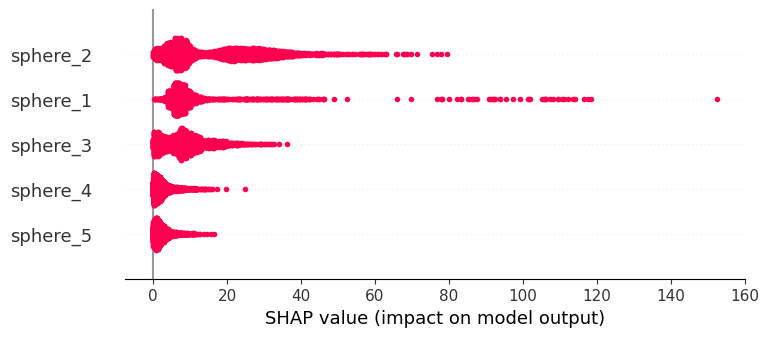

In [ ]:
shap.plots.beeswarm(new_shap_train.abs, color = 'shap_red')

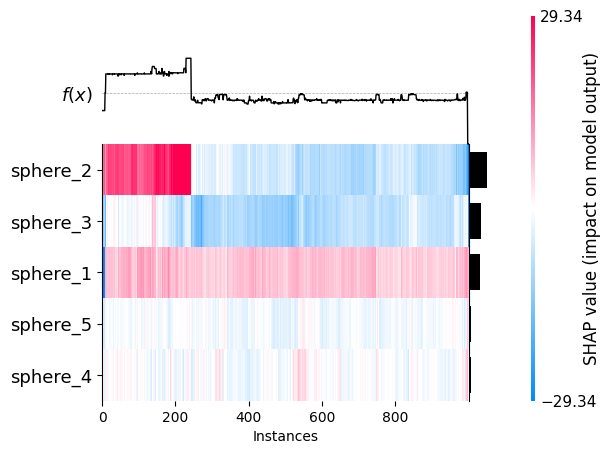

<Axes: xlabel='Instances'>

In [231]:
shap.plots.heatmap(new_shap_train[:1000])

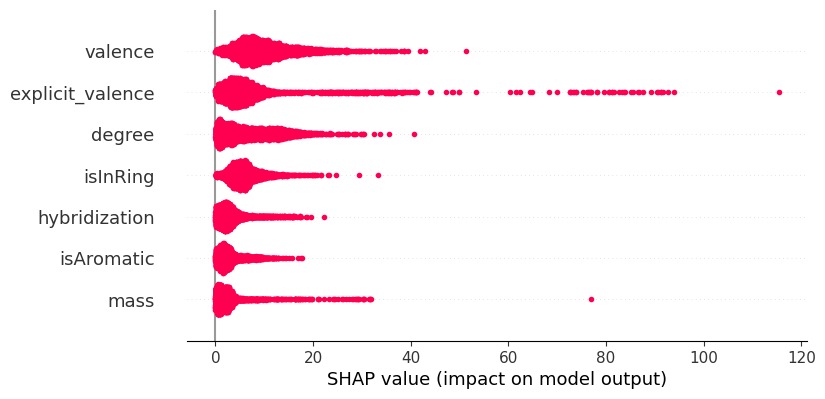

In [258]:
descriptor_list = [
    "mass",
    "hybridization",
    "isAromatic",
    "degree",
    "valence",
    "explicit_valence",
    "isInRing",
]
nums = [0, 1, 2, 3, 4, 5, 6]

mass_features = [str(i) for i in range(0, 197) if i % 7 == 0]
hybridization_features = [str(i) for i in range(0, 197) if i % 7 == 1]
isAromatic_features = [str(i) for i in range(0, 197) if i % 7 == 2]
degree_features = [str(i) for i in range(0, 197) if i % 7 == 3]
valence_features = [str(i) for i in range(0, 197) if i % 7 == 4]
explicit_valence_features = [str(i) for i in range(0, 197) if i % 7 == 5]
isInRing_features = [str(i) for i in range(0, 197) if i % 7 == 6]

# Only keep the features that are present in the shap_values_df.
mass_cols = [col for col in mass_features if col in shap_values_train_df.columns]
hybridization_cols = [col for col in hybridization_features if col in shap_values_train_df.columns]
isAromatic_cols = [col for col in isAromatic_features if col in shap_values_train_df.columns]
degree_cols = [col for col in degree_features if col in shap_values_train_df.columns]
valence_cols = [col for col in valence_features if col in shap_values_train_df.columns]
explicit_valence_cols = [col for col in explicit_valence_features if col in shap_values_train_df.columns]
isInRing_cols = [col for col in isInRing_features if col in shap_values_train_df.columns]

# Sum the SHAP values for each descriptor
mass_sum_shap_values = shap_values_train_df[mass_cols].sum(axis=1)
hybridization_sum_shap_values = shap_values_train_df[hybridization_cols].sum(axis=1)
isAromatic_sum_shap_values = shap_values_train_df[isAromatic_cols].sum(axis=1)
degree_sum_shap_values = shap_values_train_df[degree_cols].sum(axis=1)
valence_sum_shap_values = shap_values_train_df[valence_cols].sum(axis=1)
explicit_valence_sum_shap_values = shap_values_train_df[explicit_valence_cols].sum(axis=1)
isInRing_sum_shap_values = shap_values_train_df[isInRing_cols].sum(axis=1)

# Create a DataFrame to hold the summed SHAP values for each descriptor
descriptor_shap_values = pd.DataFrame({
    "mass": mass_sum_shap_values,
    "hybridization": hybridization_sum_shap_values,
    "isAromatic": isAromatic_sum_shap_values,
    "degree": degree_sum_shap_values,
    "valence": valence_sum_shap_values,
    "explicit_valence": explicit_valence_sum_shap_values,
    "isInRing": isInRing_sum_shap_values
}, index=shap_values_train_df.index)

# Create a DataFrame to hold the summed SHAP data (input features) for each descriptor
descriptor_shap_data = pd.DataFrame({
    "mass": shap_values_train_data[mass_cols].sum(axis=1),
    "hybridization": shap_values_train_data[hybridization_cols].sum(axis=1),
    "isAromatic": shap_values_train_data[isAromatic_cols].sum(axis=1),
    "degree": shap_values_train_data[degree_cols].sum(axis=1),
    "valence": shap_values_train_data[valence_cols].sum(axis=1),
    "explicit_valence": shap_values_train_data[explicit_valence_cols].sum(axis=1),
    "isInRing": shap_values_train_data[isInRing_cols].sum(axis=1)
}, index=shap_values_train_df.index)

new_descriptor_shap = shap.Explanation(
    values=descriptor_shap_values.values,                # your modified SHAP values
    base_values=shap_values_train.base_values.ravel(),          # original model expected value(s)
    data=descriptor_shap_data,                        # the input features for those rows
    feature_names=list(descriptor_shap_values.columns)        # feature names
)

shap.plots.beeswarm(new_descriptor_shap.abs, color='shap_red')

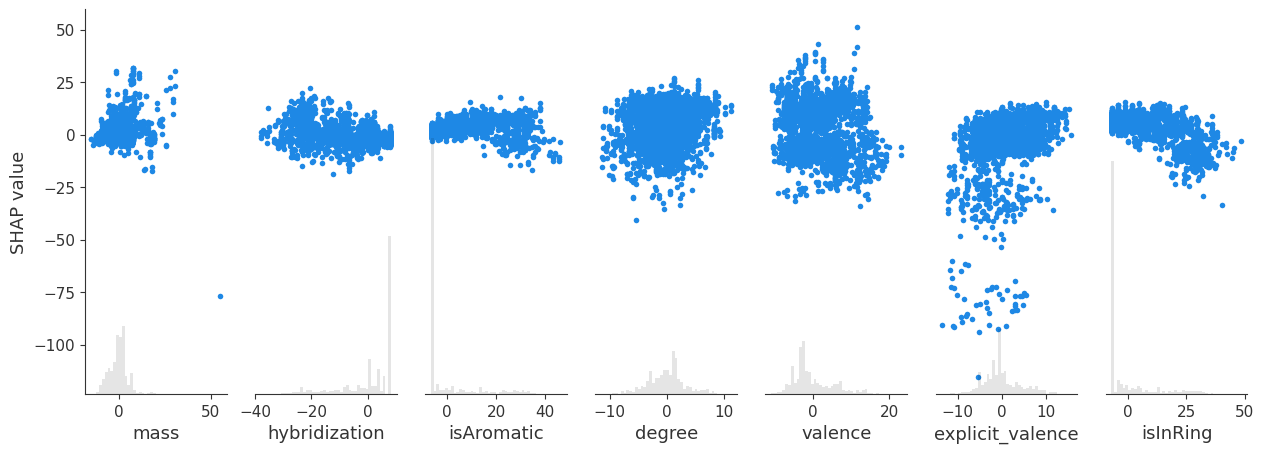

In [263]:
new_descriptor_shap = shap.Explanation(
    values=descriptor_shap_values.values.reshape(-1, 1) if descriptor_shap_values.values.ndim == 1 else descriptor_shap_values.values,
    base_values=shap_values_train.base_values.ravel(),
    data=descriptor_shap_data.values if hasattr(descriptor_shap_data, 'values') else descriptor_shap_data,
    feature_names=list(descriptor_shap_values.columns)
)

shap.plots.scatter(new_descriptor_shap, ylabel="SHAP value")

In [256]:
print(descriptor_shap_values.shape)
print(descriptor_shap_data.shape)
print(shap_values_train.base_values.shape)

(3500, 7)
(3500, 7)
(3500, 1)


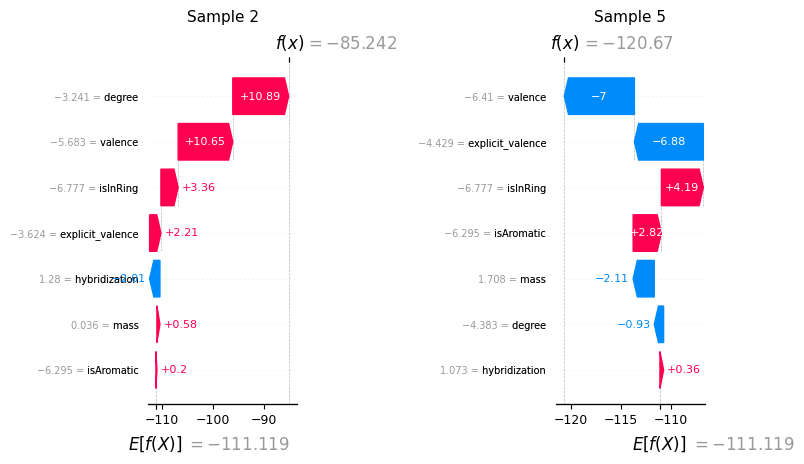

In [265]:
compare_shap_waterfall(sample_indices = [2, 5], shap_values = new_descriptor_shap, max_display=7)

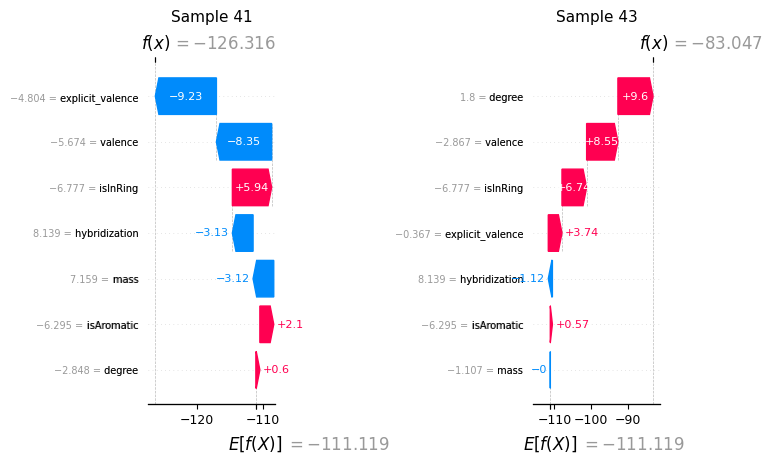

In [266]:
compare_shap_waterfall(sample_indices = [41, 43], shap_values = new_descriptor_shap, max_display=7)

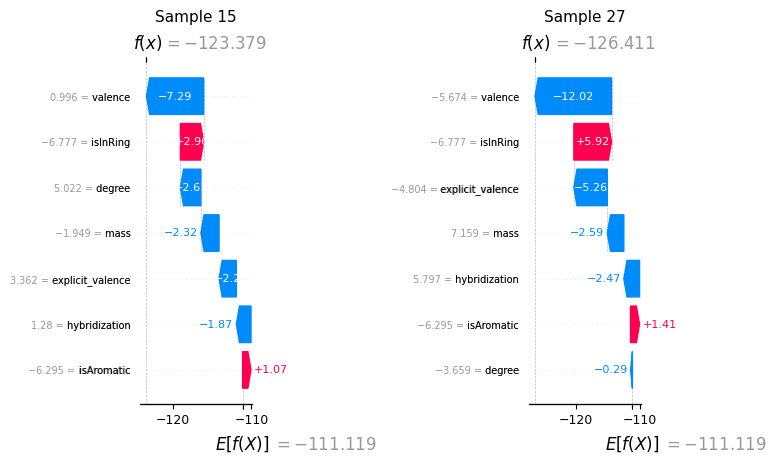

In [267]:
compare_shap_waterfall(sample_indices = [15, 27], shap_values = new_descriptor_shap, max_display=7)